In [1]:
import sys  
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
path_dir = r"/Users/../Volumes/Affiliations/"

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from src.utils import import_dta, import_tracks_dta, successful_creators_followers,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import datetime
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
pd.plotting.register_matplotlib_converters()
import os

import src.probability_utils
from src.probability_utils import volume_analysis, valence_analysis
import math
import matplotlib.ticker as plticker
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from numpy import random
from tabulate import tabulate
from IPython.display import display
from tqdm import tqdm

In [3]:
def process_date(date):
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

In [4]:
path_dir = r"/Users/../Volumes/Raw/"
music_before = 30
low_success = 0.25
high_success = 0.75

In [5]:
#we will skip comments for now

#affiliations :follows
#favoritings :likes

tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

user_info = import_dta(path_dir, "12sample_user_infos.dta");
user_info.columns = ['user_id', 'type', 'entered_platform']
user_info_2 = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_2.columns = ['user_id', 'type', 'entered_platform']
user_info = pd.concat([user_info, user_info_2]);
user_info.drop_duplicates(subset='user_id', keep='first', inplace=True, ignore_index=False);


########
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");
comments_received = import_dta(path_dir, "12sample_comments_received.dta");
shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received = import_dta(path_dir, "12sample_messages_received.dta");

########
follows = import_dta(path_dir, "12sample_affiliations.dta");
comments = import_dta(path_dir, "12sample_comments.dta");
shares = import_dta(path_dir, "12sample_reposts.dta");
likes = import_dta(path_dir, "12sample_favoritings.dta");
messages = import_dta(path_dir, "12sample_messages.dta");

tracks_first_month = sample_creators_music(tracks, music_before)
mask = tracks_first_month.track_available == 1
tracks_first_month = tracks_first_month[mask]

mask = follows_received.contact_id.isin(tracks_first_month.user_id)
follows_received_30 = follows_received[mask]
followers_per_creator_60 = successful_creators_followers(follows_received_30, 60, tracks_first_month)
followers_per_creator_60_static = successful_creators_followers(follows_received_30, 60, tracks_first_month, always_same_batches = True, 
                                                        perc1 = low_success, perc2 = high_success)

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)
%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)
%%%%%%%%%% 12sample_affiliations.dta %%%%%%%%%%
(1233416, 3)
%%%%%%%%%% 12sample_comments.dta %%%%%%%%%%
(50644, 4)
%%%%%%%%%% 12sample_reposts.dta %%%%%%%%%%
(262342, 4)
%%%%%%%%%% 12sam

In [6]:
d = {}
for i in range(6):
   d[str(i)] = pd.read_pickle('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/{}.pkl'.format(i)) 
   d[str(i)]['created_at'] =  pd.to_datetime(d[str(i)]['created_at'])#.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [7]:
data = pd.concat([d['0'], d['1'], d['2'], d['3'], d['4'], d['5']])

In [8]:
#data['created_at'] = pd.to_datetime(data['created_at'])

In [9]:
data.set_index('created_at', inplace = True)

In [10]:
#outdegree = data.groupby('sender_id').agg(following=('contact_id', pd.Series.nunique))
#outdegree_info = user_info_2.merge(outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
#outdegree_info.loc[outdegree_info.following.isnull(), 'following'] = 0 

In [11]:
#outdegree_info['decile'] = pd.qcut(outdegree_info['following'], 10, labels=False)

In [12]:
#outdegree_info.head(10)

In [13]:
#outdegree_info['decile'].value_counts()

In [14]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = True)
mask = actions_sent.user_id.isin(tracks_first_month.user_id.unique())
actions_sent = actions_sent[mask]

In [15]:
#filter only outbound activities before the follow is received
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent = actions_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

Obtaining fanbase...


In [16]:
mask = (actions_sent.date_sent < actions_sent.follower_since) | (actions_sent.follower_since.isnull())
actions_sent_non_followers =  actions_sent[mask]
actions_sent_non_followers['week_yr_date'] = actions_sent_non_followers.week_yr.apply(lambda x: process_date(x))

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_85766/3898105865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_followers['week_yr_date'] = actions_sent_non_followers.week_yr.apply(lambda x: process_date(x))


# MAB

In [17]:
def create_trials_rewards(df):
    '''
    Creates reward counts, trial counts and keys to be used in the thompson sampling function
    '''
    Sent = df.groupby('outbound_activity', as_index = True).size().to_frame(name='sent')\
    .reset_index()
    Reward = df.groupby('outbound_activity', as_index = True)\
    .agg(b_Reward = ('reward', 'sum')).reset_index()


    keys  = Sent.outbound_activity

    return np.array(Sent.sent), np.array(Reward.b_Reward), keys

In [18]:
def update_1_step(Sent, Reward):
    
    alpha = Reward + 1 
    beta = (Sent-Reward)+1

    mean = alpha/(alpha+beta)
    variance = (alpha*beta)/((alpha+beta+1)*((alpha+beta)**2))

    return np.around(mean,3), np.around(np.sqrt(variance),3)

In [19]:
def real_time(df, outdegree_df, interval):
    
    d = {}
    
    for user_id in df.user_id.unique():
        
        experiment = {'1':{'Sent':0,'Reward':0}, 
             '2':{'Sent':0,'Reward':0},
             '3':{'Sent':0,'Reward':0},
             '4':{'Sent':0,'Reward':0},
             '5':{'Sent':0,'Reward':0}, 
             '6':{'Sent':0,'Reward':0},
             '7':{'Sent':0,'Reward':0},
             '8':{'Sent':0,'Reward':0},
             '9':{'Sent':0,'Reward':0},
             '10':{'Sent':0,'Reward':0}}
        
        dataset_mean = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1), 
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0})
    
        dataset_std = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),  
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0}) 
    
        d[user_id] = {'experiment': experiment,'dataset_std': dataset_std, 'dataset_mean': dataset_mean, 'j' : 0}

    date_l = min(df.date_sent)
    old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
    old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
    old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0
    old_outdegree = old_outdegree[['user_id', 'size']].set_index('user_id')
    old_outdegree['decile'] = pd.qcut(old_outdegree['size'], 10, labels=False, duplicates='drop') + 1
    old_outdegree['decile'] = old_outdegree[['decile']]  
    
    for i in tqdm(range(df.shape[0])):
        
        user_id = df.iloc[i].user_id
        fan_id = df.iloc[i].fan_id
        j = d[user_id]['j']
        d[user_id]['j'] = j + 1
        
        if i%interval == 0:
            date_h = df.iloc[i,:]['date_sent']
            new_outdegree = outdegree_df.iloc[outdegree_df.index.values.searchsorted(np.datetime64(date_l)):
                  outdegree_df.index.values.searchsorted(np.datetime64(date_h))].groupby('sender_id', as_index = False).size()
        
            old_outdegree = old_outdegree.add(new_outdegree.set_index('sender_id'), fill_value= 0)
            old_outdegree['decile'] = pd.qcut(old_outdegree['size'], 10, labels=False, duplicates='drop') + 1
            old_outdegree['decile'] = old_outdegree[['decile']]  
            date_l = date_h
            
        if i%1000 == 0:
            print(old_outdegree.decile.value_counts(normalize=True))
        
        try:
            d[user_id]['experiment'][str(int(old_outdegree.loc[fan_id]['decile']))]['Sent'] += 1
            d[user_id]['experiment'][str(int(old_outdegree.loc[fan_id]['decile']))]['Reward'] += df.iloc[i, -1]
            Sent = np.array([a[1]['Sent'] for a in d[user_id]['experiment'].items()])
            Reward = np.array([a[1]['Reward'] for a in d[user_id]['experiment'].items()])
        
            mean, std = update_1_step(Sent, Reward)
        
            d[user_id]['dataset_mean'].loc[j, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = np.transpose(mean)
            d[user_id]['dataset_std'].loc[j, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = np.transpose(std)
        
            print('.', end='')
        
        except:
            print('x', end ='')
        
    for user_id in df.user_id.unique(): 
        d[user_id]['dataset_mean'] = pd.concat([d[user_id]['dataset_mean'], df.loc[df['user_id'] == user_id].reset_index()['date_sent']], axis = 1)
        
        
    return d

# Real time updating

In [20]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = False)

In [21]:
mask = actions_sent.user_id.isin(tracks_first_month.user_id) 
actions_sent = actions_sent[mask]
actions_sent_filtered = actions_sent.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = "inner")

In [22]:
#filter only outbound activities before the follow is received
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent_filtered = actions_sent_filtered.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

mask = (actions_sent_filtered.date_sent < actions_sent_filtered.follower_since) | (actions_sent_filtered.follower_since.isnull())
actions_sent_filtered_non_followers =  actions_sent_filtered[mask]
actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))

Obtaining fanbase...


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_85766/1142436393.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))


In [23]:
mask = actions_sent_filtered_non_followers['fan_id'].isin(data.sender_id.unique())
actions_sent_filtered_non_followers = actions_sent_filtered_non_followers.loc[mask]

In [24]:
import datetime
# Target Creation
delta = datetime.timedelta(days = 7)
mask = (actions_sent_filtered_non_followers['follower_since'] <= (actions_sent_filtered_non_followers['date_sent'] + delta))

actions_sent_filtered_non_followers.loc[mask, 'reward'] = 1
mask = actions_sent_filtered_non_followers['reward'].isnull()
actions_sent_filtered_non_followers.loc[mask, 'reward'] = 0

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_85766/2954351983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers.loc[mask, 'reward'] = 1


In [25]:
actions_sent_filtered_non_followers.sort_values(by = 'date_sent', inplace = True)
                                                
mask = actions_sent_filtered_non_followers.high_low == 'high'
successful_df = actions_sent_filtered_non_followers[mask]

mask = actions_sent_filtered_non_followers.high_low == 'low'
unsuccessful_df = actions_sent_filtered_non_followers[mask]

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_85766/3523808898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers.sort_values(by = 'date_sent', inplace = True)


In [26]:
dict_successful_df =  real_time(successful_df, data, 3)
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/dict_sucessful_df.pkl', 'wb') as handle:
    pickle.dump(dict_successful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|                                                                                                                                     | 7/79862 [00:00<37:10, 35.81it/s]

1    0.701449
2    0.102789
4    0.099397
3    0.096366
Name: decile, dtype: float64
............

  0%|                                                                                                                                    | 20/79862 [00:00<24:47, 53.69it/s]

.........

  0%|                                                                                                                                    | 31/79862 [00:00<31:49, 41.81it/s]

............

  0%|                                                                                                                                    | 40/79862 [00:00<26:47, 49.66it/s]

...............

  0%|                                                                                                                                    | 58/79862 [00:01<23:12, 57.32it/s]

...............

  0%|                                                                                                                                    | 70/79862 [00:01<29:44, 44.72it/s]

.........

  0%|▏                                                                                                                                   | 84/79862 [00:01<25:42, 51.73it/s]

...............

  0%|▏                                                                                                                                  | 100/79862 [00:02<23:39, 56.21it/s]

...............

  0%|▏                                                                                                                                  | 109/79862 [00:02<22:25, 59.28it/s]

...............

  0%|▏                                                                                                                                  | 127/79862 [00:02<21:07, 62.92it/s]

...............

  0%|▏                                                                                                                                  | 145/79862 [00:02<20:29, 64.85it/s]

...............

  0%|▎                                                                                                                                  | 154/79862 [00:02<20:20, 65.29it/s]

...............

  0%|▎                                                                                                                                  | 170/79862 [00:03<23:23, 56.79it/s]

............

  0%|▎                                                                                                                                  | 187/79862 [00:03<21:59, 60.37it/s]

...............

  0%|▎                                                                                                                                  | 196/79862 [00:03<21:27, 61.86it/s]

...............

  0%|▎                                                                                                                                  | 214/79862 [00:03<21:34, 61.53it/s]

............

  0%|▍                                                                                                                                  | 229/79862 [00:04<22:42, 58.45it/s]

...............

  0%|▍                                                                                                                                  | 238/79862 [00:04<21:50, 60.75it/s]

...............

  0%|▍                                                                                                                                  | 256/79862 [00:04<20:51, 63.59it/s]

...............

  0%|▍                                                                                                                                  | 274/79862 [00:04<20:19, 65.25it/s]

...............

  0%|▍                                                                                                                                  | 288/79862 [00:05<22:49, 58.09it/s]

............

  0%|▍                                                                                                                                  | 301/79862 [00:05<23:51, 55.57it/s]

...............

  0%|▌                                                                                                                                  | 310/79862 [00:05<22:32, 58.82it/s]

...............

  0%|▌                                                                                                                                  | 328/79862 [00:05<21:16, 62.31it/s]

...............

  0%|▌                                                                                                                                  | 346/79862 [00:05<20:33, 64.47it/s]

...............

  0%|▌                                                                                                                                  | 361/79862 [00:06<21:21, 62.05it/s]

.............

  0%|▌                                                                                                                                  | 368/79862 [00:06<21:29, 61.63it/s]

...........

  0%|▋                                                                                                                                  | 382/79862 [00:06<23:44, 55.81it/s]

...............

  0%|▋                                                                                                                                  | 397/79862 [00:06<24:24, 54.25it/s]

............

  1%|▋                                                                                                                                  | 406/79862 [00:07<22:46, 58.14it/s]

...............

  1%|▋                                                                                                                                  | 422/79862 [00:07<21:47, 60.76it/s]

...............

  1%|▋                                                                                                                                  | 439/79862 [00:07<21:08, 62.61it/s]

...............

  1%|▋                                                                                                                                  | 457/79862 [00:07<20:28, 64.66it/s]

...............

  1%|▊                                                                                                                                  | 471/79862 [00:08<22:15, 59.43it/s]

............

  1%|▊                                                                                                                                  | 478/79862 [00:08<22:59, 57.54it/s]

...............

  1%|▊                                                                                                                                  | 496/79862 [00:08<22:28, 58.86it/s]

............

  1%|▊                                                                                                                                  | 505/79862 [00:08<21:47, 60.70it/s]

...............

  1%|▊                                                                                                                                  | 520/79862 [00:08<23:58, 55.17it/s]

............

  1%|▉                                                                                                                                  | 535/79862 [00:09<22:37, 58.44it/s]

...............

  1%|▉                                                                                                                                  | 550/79862 [00:09<21:54, 60.32it/s]

...............

  1%|▉                                                                                                                                  | 565/79862 [00:09<23:17, 56.75it/s]

...............

  1%|▉                                                                                                                                  | 577/79862 [00:09<25:17, 52.24it/s]

............

  1%|▉                                                                                                                                  | 595/79862 [00:10<21:59, 60.06it/s]

...............

  1%|▉                                                                                                                                  | 604/79862 [00:10<21:14, 62.17it/s]

...............

  1%|█                                                                                                                                  | 622/79862 [00:10<20:23, 64.74it/s]

...............

  1%|█                                                                                                                                  | 636/79862 [00:10<22:05, 59.79it/s]

............

  1%|█                                                                                                                                  | 648/79862 [00:11<22:30, 58.66it/s]

...............

  1%|█                                                                                                                                  | 661/79862 [00:11<23:31, 56.11it/s]

...............

  1%|█                                                                                                                                  | 679/79862 [00:11<21:18, 61.92it/s]

...............

  1%|█▏                                                                                                                                 | 697/79862 [00:11<20:23, 64.71it/s]

...............

  1%|█▏                                                                                                                                 | 706/79862 [00:12<20:11, 65.36it/s]

...............

  1%|█▏                                                                                                                                 | 722/79862 [00:12<20:21, 64.78it/s]

...............

  1%|█▏                                                                                                                                 | 739/79862 [00:12<20:27, 64.45it/s]

...............

  1%|█▏                                                                                                                                 | 757/79862 [00:12<20:02, 65.77it/s]

...............

  1%|█▎                                                                                                                                 | 766/79862 [00:12<19:56, 66.09it/s]

...............

  1%|█▎                                                                                                                                 | 784/79862 [00:13<19:47, 66.59it/s]

...............

  1%|█▎                                                                                                                                 | 802/79862 [00:13<19:43, 66.81it/s]

...............

  1%|█▎                                                                                                                                 | 811/79862 [00:13<19:43, 66.80it/s]

...............

  1%|█▎                                                                                                                                 | 829/79862 [00:13<19:41, 66.87it/s]

...............

  1%|█▍                                                                                                                                 | 843/79862 [00:14<20:34, 64.01it/s]

...............

  1%|█▍                                                                                                                                 | 859/79862 [00:14<22:19, 58.99it/s]

...............

  1%|█▍                                                                                                                                 | 877/79862 [00:14<21:39, 60.78it/s]

...............

  1%|█▍                                                                                                                                 | 886/79862 [00:14<21:02, 62.57it/s]

...............

  1%|█▍                                                                                                                                 | 904/79862 [00:15<20:18, 64.80it/s]

...............

  1%|█▌                                                                                                                                 | 922/79862 [00:15<19:55, 66.00it/s]

...............

  1%|█▌                                                                                                                                 | 931/79862 [00:15<20:55, 62.85it/s]

............

  1%|█▌                                                                                                                                 | 945/79862 [00:15<21:22, 61.51it/s]

............

  1%|█▌                                                                                                                                 | 961/79862 [00:16<23:20, 56.33it/s]

...............

  1%|█▌                                                                                                                                 | 973/79862 [00:16<25:20, 51.87it/s]

............

  1%|█▌                                                                                                                                 | 982/79862 [00:16<23:22, 56.26it/s]

...............

  1%|█▋                                                                                                                                 | 997/79862 [00:16<23:34, 55.75it/s]

..........1    0.701441
2    0.102789
4    0.099401
3    0.096369
Name: decile, dtype: float64
..

  1%|█▋                                                                                                                                | 1009/79862 [00:16<24:08, 54.46it/s]

............

  1%|█▋                                                                                                                                | 1021/79862 [00:17<26:51, 48.93it/s]

............

  1%|█▋                                                                                                                                | 1033/79862 [00:17<25:43, 51.08it/s]

...............

  1%|█▋                                                                                                                                | 1048/79862 [00:17<25:53, 50.74it/s]

............

  1%|█▋                                                                                                                                | 1066/79862 [00:18<23:30, 55.86it/s]

...............

  1%|█▊                                                                                                                                | 1081/79862 [00:18<22:52, 57.42it/s]

...............

  1%|█▊                                                                                                                                | 1090/79862 [00:18<21:56, 59.83it/s]

...............

  1%|█▊                                                                                                                                | 1108/79862 [00:18<20:52, 62.87it/s]

...............

  1%|█▊                                                                                                                                | 1126/79862 [00:18<20:25, 64.23it/s]

...............

  1%|█▊                                                                                                                                | 1135/79862 [00:19<20:14, 64.84it/s]

...............

  1%|█▉                                                                                                                                | 1153/79862 [00:19<20:00, 65.59it/s]

...............

  1%|█▉                                                                                                                                | 1171/79862 [00:19<20:01, 65.47it/s]

...............

  1%|█▉                                                                                                                                | 1180/79862 [00:19<19:59, 65.60it/s]

...............

  2%|█▉                                                                                                                                | 1198/79862 [00:20<19:51, 66.03it/s]

...............

  2%|█▉                                                                                                                                | 1216/79862 [00:20<19:46, 66.28it/s]

...............

  2%|█▉                                                                                                                                | 1225/79862 [00:20<19:46, 66.29it/s]

...............

  2%|██                                                                                                                                | 1243/79862 [00:20<19:48, 66.16it/s]

...............

  2%|██                                                                                                                                | 1261/79862 [00:21<19:53, 65.84it/s]

...............

  2%|██                                                                                                                                | 1270/79862 [00:21<19:49, 66.05it/s]

...............

  2%|██                                                                                                                                | 1288/79862 [00:21<19:45, 66.27it/s]

...............

  2%|██▏                                                                                                                               | 1306/79862 [00:21<19:42, 66.42it/s]

...............

  2%|██▏                                                                                                                               | 1315/79862 [00:21<19:42, 66.42it/s]

...............

  2%|██▏                                                                                                                               | 1333/79862 [00:22<19:41, 66.48it/s]

...............

  2%|██▏                                                                                                                               | 1351/79862 [00:22<19:39, 66.58it/s]

...............

  2%|██▏                                                                                                                               | 1360/79862 [00:22<19:41, 66.46it/s]

...............

  2%|██▏                                                                                                                               | 1378/79862 [00:22<19:40, 66.49it/s]

...............

  2%|██▎                                                                                                                               | 1396/79862 [00:23<19:38, 66.56it/s]

...............

  2%|██▎                                                                                                                               | 1405/79862 [00:23<19:39, 66.52it/s]

...............

  2%|██▎                                                                                                                               | 1423/79862 [00:23<19:51, 65.83it/s]

...............

  2%|██▎                                                                                                                               | 1441/79862 [00:23<19:43, 66.27it/s]

...............

  2%|██▎                                                                                                                               | 1450/79862 [00:23<19:43, 66.27it/s]

...............

  2%|██▍                                                                                                                               | 1468/79862 [00:24<19:41, 66.36it/s]

...............

  2%|██▍                                                                                                                               | 1486/79862 [00:24<19:43, 66.24it/s]

...............

  2%|██▍                                                                                                                               | 1495/79862 [00:24<19:47, 66.02it/s]

...............

  2%|██▍                                                                                                                               | 1513/79862 [00:24<19:46, 66.04it/s]

...............

  2%|██▍                                                                                                                               | 1531/79862 [00:25<19:42, 66.26it/s]

...............

  2%|██▌                                                                                                                               | 1540/79862 [00:25<19:42, 66.24it/s]

...............

  2%|██▌                                                                                                                               | 1558/79862 [00:25<19:39, 66.37it/s]

...............

  2%|██▌                                                                                                                               | 1576/79862 [00:25<19:37, 66.49it/s]

...............

  2%|██▌                                                                                                                               | 1585/79862 [00:25<19:38, 66.43it/s]

...............

  2%|██▌                                                                                                                               | 1603/79862 [00:26<19:47, 65.92it/s]

...............

  2%|██▋                                                                                                                               | 1621/79862 [00:26<19:46, 65.95it/s]

...............

  2%|██▋                                                                                                                               | 1630/79862 [00:26<19:45, 66.01it/s]

...............

  2%|██▋                                                                                                                               | 1648/79862 [00:26<19:40, 66.25it/s]

...............

  2%|██▋                                                                                                                               | 1666/79862 [00:27<19:39, 66.30it/s]

...............

  2%|██▋                                                                                                                               | 1675/79862 [00:27<19:39, 66.28it/s]

...............

  2%|██▊                                                                                                                               | 1693/79862 [00:27<19:37, 66.36it/s]

...............

  2%|██▊                                                                                                                               | 1711/79862 [00:27<19:35, 66.48it/s]

...............

  2%|██▊                                                                                                                               | 1720/79862 [00:27<19:38, 66.30it/s]

...............

  2%|██▊                                                                                                                               | 1738/79862 [00:28<19:48, 65.74it/s]

...............

  2%|██▊                                                                                                                               | 1756/79862 [00:28<19:46, 65.84it/s]

...............

  2%|██▊                                                                                                                               | 1765/79862 [00:28<19:42, 66.07it/s]

...............

  2%|██▉                                                                                                                               | 1783/79862 [00:28<19:44, 65.91it/s]

...............

  2%|██▉                                                                                                                               | 1801/79862 [00:29<19:38, 66.26it/s]

...............

  2%|██▉                                                                                                                               | 1810/79862 [00:29<19:37, 66.28it/s]

...............

  2%|██▉                                                                                                                               | 1828/79862 [00:29<19:35, 66.40it/s]

...............

  2%|███                                                                                                                               | 1846/79862 [00:29<19:34, 66.40it/s]

...............

  2%|███                                                                                                                               | 1862/79862 [00:30<19:23, 67.06it/s]

...............

  2%|███                                                                                                                               | 1870/79862 [00:30<20:03, 64.78it/s]

...............

  2%|███                                                                                                                               | 1888/79862 [00:30<19:53, 65.35it/s]

...............

  2%|███                                                                                                                               | 1906/79862 [00:30<19:40, 66.04it/s]

...............

  2%|███                                                                                                                               | 1915/79862 [00:30<19:39, 66.10it/s]

...............

  2%|███▏                                                                                                                              | 1933/79862 [00:31<19:37, 66.19it/s]

...............

  2%|███▏                                                                                                                              | 1951/79862 [00:31<19:40, 66.03it/s]

...............

  2%|███▏                                                                                                                              | 1960/79862 [00:31<19:48, 65.56it/s]

...............

  2%|███▏                                                                                                                              | 1978/79862 [00:31<19:39, 66.06it/s]

...............

  2%|███▏                                                                                                                              | 1996/79862 [00:32<19:40, 65.97it/s]

...............

  3%|███▎                                                                                                                              | 2005/79862 [00:32<19:47, 65.58it/s]

..1    0.718021
4    0.099604
3    0.098253
2    0.084121
Name: decile, dtype: float64
.............

  3%|███▎                                                                                                                              | 2023/79862 [00:32<19:39, 65.98it/s]

...............

  3%|███▎                                                                                                                              | 2041/79862 [00:32<19:34, 66.28it/s]

...............

  3%|███▎                                                                                                                              | 2050/79862 [00:32<19:37, 66.10it/s]

...............

  3%|███▎                                                                                                                              | 2068/79862 [00:33<19:43, 65.72it/s]

...............

  3%|███▍                                                                                                                              | 2086/79862 [00:33<19:40, 65.87it/s]

...............

  3%|███▍                                                                                                                              | 2095/79862 [00:33<19:38, 65.99it/s]

...............

  3%|███▍                                                                                                                              | 2113/79862 [00:33<19:45, 65.56it/s]

...............

  3%|███▍                                                                                                                              | 2131/79862 [00:34<19:37, 66.02it/s]

...............

  3%|███▍                                                                                                                              | 2140/79862 [00:34<19:35, 66.11it/s]

...............

  3%|███▌                                                                                                                              | 2158/79862 [00:34<19:32, 66.26it/s]

...............

  3%|███▌                                                                                                                              | 2176/79862 [00:34<19:30, 66.39it/s]

...............

  3%|███▌                                                                                                                              | 2185/79862 [00:34<19:31, 66.33it/s]

...............

  3%|███▌                                                                                                                              | 2203/79862 [00:35<19:31, 66.30it/s]

...............

  3%|███▌                                                                                                                              | 2221/79862 [00:35<19:32, 66.21it/s]

...............

  3%|███▋                                                                                                                              | 2230/79862 [00:35<19:31, 66.27it/s]

...............

  3%|███▋                                                                                                                              | 2248/79862 [00:35<19:29, 66.34it/s]

...............

  3%|███▋                                                                                                                              | 2266/79862 [00:36<19:28, 66.40it/s]

...............

  3%|███▋                                                                                                                              | 2275/79862 [00:36<19:28, 66.38it/s]

...............

  3%|███▋                                                                                                                              | 2293/79862 [00:36<19:35, 65.96it/s]

...............

  3%|███▊                                                                                                                              | 2311/79862 [00:36<19:29, 66.31it/s]

...............

  3%|███▊                                                                                                                              | 2320/79862 [00:37<19:30, 66.23it/s]

...............

  3%|███▊                                                                                                                              | 2338/79862 [00:37<19:26, 66.44it/s]

...............

  3%|███▊                                                                                                                              | 2356/79862 [00:37<19:31, 66.16it/s]

...............

  3%|███▊                                                                                                                              | 2365/79862 [00:37<19:30, 66.18it/s]

...............

  3%|███▉                                                                                                                              | 2383/79862 [00:37<19:38, 65.74it/s]

...............

  3%|███▉                                                                                                                              | 2401/79862 [00:38<19:35, 65.87it/s]

...............

  3%|███▉                                                                                                                              | 2410/79862 [00:38<19:35, 65.88it/s]

...............

  3%|███▉                                                                                                                              | 2428/79862 [00:38<19:30, 66.17it/s]

...............

  3%|███▉                                                                                                                              | 2446/79862 [00:38<19:30, 66.16it/s]

...............

  3%|███▉                                                                                                                              | 2455/79862 [00:39<19:34, 65.93it/s]

...............

  3%|████                                                                                                                              | 2473/79862 [00:39<19:34, 65.92it/s]

...............

  3%|████                                                                                                                              | 2491/79862 [00:39<19:41, 65.49it/s]

...............

  3%|████                                                                                                                              | 2500/79862 [00:39<19:37, 65.69it/s]

...............

  3%|████                                                                                                                              | 2518/79862 [00:40<19:32, 65.96it/s]

...............

  3%|████▏                                                                                                                             | 2536/79862 [00:40<19:36, 65.72it/s]

...............

  3%|████▏                                                                                                                             | 2545/79862 [00:40<19:44, 65.27it/s]

...............

  3%|████▏                                                                                                                             | 2563/79862 [00:40<19:33, 65.87it/s]

...............

  3%|████▏                                                                                                                             | 2581/79862 [00:40<19:28, 66.14it/s]

...............

  3%|████▏                                                                                                                             | 2590/79862 [00:41<19:28, 66.14it/s]

...............

  3%|████▏                                                                                                                             | 2608/79862 [00:41<19:25, 66.28it/s]

...............

  3%|████▎                                                                                                                             | 2626/79862 [00:41<19:28, 66.12it/s]

...............

  3%|████▎                                                                                                                             | 2635/79862 [00:41<19:27, 66.12it/s]

...............

  3%|████▎                                                                                                                             | 2653/79862 [00:42<19:24, 66.33it/s]

...............

  3%|████▎                                                                                                                             | 2671/79862 [00:42<19:30, 65.95it/s]

...............

  3%|████▎                                                                                                                             | 2680/79862 [00:42<19:27, 66.09it/s]

...............

  3%|████▍                                                                                                                             | 2698/79862 [00:42<19:35, 65.62it/s]

...............

  3%|████▍                                                                                                                             | 2716/79862 [00:43<19:30, 65.90it/s]

...............

  3%|████▍                                                                                                                             | 2725/79862 [00:43<19:27, 66.07it/s]

...............

  3%|████▍                                                                                                                             | 2743/79862 [00:43<19:41, 65.26it/s]

...............

  3%|████▍                                                                                                                             | 2761/79862 [00:43<19:43, 65.14it/s]

...............

  3%|████▌                                                                                                                             | 2776/79862 [00:43<20:13, 63.50it/s]

...............

  3%|████▌                                                                                                                             | 2792/79862 [00:44<20:20, 63.13it/s]

...............

  4%|████▌                                                                                                                             | 2800/79862 [00:44<20:43, 61.96it/s]

...............

  4%|████▌                                                                                                                             | 2818/79862 [00:44<20:00, 64.16it/s]

...............

  4%|████▌                                                                                                                             | 2832/79862 [00:44<21:42, 59.12it/s]

............

  4%|████▋                                                                                                                             | 2848/79862 [00:45<21:23, 60.00it/s]

...............

  4%|████▋                                                                                                                             | 2857/79862 [00:45<20:45, 61.82it/s]

...............

  4%|████▋                                                                                                                             | 2875/79862 [00:45<20:01, 64.07it/s]

...............

  4%|████▋                                                                                                                             | 2891/79862 [00:45<20:06, 63.79it/s]

...............

  4%|████▋                                                                                                                             | 2908/79862 [00:46<20:08, 63.69it/s]

...............

  4%|████▋                                                                                                                             | 2917/79862 [00:46<19:53, 64.44it/s]

...............

  4%|████▊                                                                                                                             | 2935/79862 [00:46<19:37, 65.35it/s]

...............

  4%|████▊                                                                                                                             | 2953/79862 [00:46<19:26, 65.96it/s]

...............

  4%|████▊                                                                                                                             | 2962/79862 [00:46<19:24, 66.04it/s]

...............

  4%|████▊                                                                                                                             | 2980/79862 [00:47<19:21, 66.16it/s]

...............

  4%|████▉                                                                                                                             | 2998/79862 [00:47<20:15, 63.26it/s]

...............

  4%|████▉                                                                                                                             | 3005/79862 [00:47<21:49, 58.68it/s]

1    0.718020
4    0.099606
3    0.098253
2    0.084121
Name: decile, dtype: float64
............

  4%|████▉                                                                                                                             | 3019/79862 [00:47<23:27, 54.58it/s]

............

  4%|████▉                                                                                                                             | 3031/79862 [00:48<23:50, 53.71it/s]

...............

  4%|████▉                                                                                                                             | 3046/79862 [00:48<22:37, 56.59it/s]

............

  4%|████▉                                                                                                                             | 3061/79862 [00:48<22:33, 56.75it/s]

...............

  4%|█████                                                                                                                             | 3079/79862 [00:48<20:41, 61.82it/s]

...............

  4%|█████                                                                                                                             | 3088/79862 [00:49<20:16, 63.13it/s]

...............

  4%|█████                                                                                                                             | 3106/79862 [00:49<20:11, 63.35it/s]

...............

  4%|█████                                                                                                                             | 3120/79862 [00:49<19:33, 65.41it/s]

...............

  4%|█████                                                                                                                             | 3136/79862 [00:49<21:20, 59.93it/s]

...............

  4%|█████▏                                                                                                                            | 3154/79862 [00:50<20:13, 63.24it/s]

...............

  4%|█████▏                                                                                                                            | 3163/79862 [00:50<19:55, 64.14it/s]

...............

  4%|█████▏                                                                                                                            | 3181/79862 [00:50<19:35, 65.24it/s]

............

  4%|█████▏                                                                                                                            | 3195/79862 [00:50<21:14, 60.17it/s]

............

  4%|█████▏                                                                                                                            | 3202/79862 [00:50<24:19, 52.53it/s]

............

  4%|█████▏                                                                                                                            | 3214/79862 [00:51<26:22, 48.44it/s]

............

  4%|█████▎                                                                                                                            | 3226/79862 [00:51<27:38, 46.20it/s]

............

  4%|█████▎                                                                                                                            | 3238/79862 [00:51<28:18, 45.12it/s]

............

  4%|█████▎                                                                                                                            | 3256/79862 [00:52<22:48, 55.96it/s]

...............

  4%|█████▎                                                                                                                            | 3265/79862 [00:52<22:41, 56.27it/s]

...............

  4%|█████▎                                                                                                                            | 3283/79862 [00:52<21:50, 58.45it/s]

...............

  4%|█████▎                                                                                                                            | 3301/79862 [00:52<20:27, 62.39it/s]

...............

  4%|█████▍                                                                                                                            | 3310/79862 [00:52<20:05, 63.49it/s]

...............

  4%|█████▍                                                                                                                            | 3328/79862 [00:53<19:44, 64.59it/s]

...............

  4%|█████▍                                                                                                                            | 3346/79862 [00:53<19:29, 65.40it/s]

...............

  4%|█████▍                                                                                                                            | 3355/79862 [00:53<19:26, 65.59it/s]

...............

  4%|█████▍                                                                                                                            | 3373/79862 [00:53<19:21, 65.86it/s]

...............

  4%|█████▌                                                                                                                            | 3389/79862 [00:54<19:46, 64.46it/s]

...............

  4%|█████▌                                                                                                                            | 3406/79862 [00:54<19:52, 64.09it/s]

...............

  4%|█████▌                                                                                                                            | 3422/79862 [00:54<20:00, 63.68it/s]

...............

  4%|█████▌                                                                                                                            | 3430/79862 [00:54<20:25, 62.35it/s]

...............

  4%|█████▌                                                                                                                            | 3448/79862 [00:54<19:45, 64.47it/s]

...............

  4%|█████▋                                                                                                                            | 3464/79862 [00:55<19:56, 63.87it/s]

...............

  4%|█████▋                                                                                                                            | 3479/79862 [00:55<20:27, 62.21it/s]

...............

  4%|█████▋                                                                                                                            | 3496/79862 [00:55<20:15, 62.84it/s]

...............

  4%|█████▋                                                                                                                            | 3505/79862 [00:55<19:57, 63.78it/s]

...............

  4%|█████▋                                                                                                                            | 3523/79862 [00:56<19:33, 65.07it/s]

...............

  4%|█████▊                                                                                                                            | 3541/79862 [00:56<19:21, 65.69it/s]

...............

  4%|█████▊                                                                                                                            | 3550/79862 [00:56<19:17, 65.91it/s]

...............

  4%|█████▊                                                                                                                            | 3568/79862 [00:56<19:12, 66.22it/s]

...............

  4%|█████▊                                                                                                                            | 3586/79862 [00:57<19:12, 66.21it/s]

...............

  5%|█████▊                                                                                                                            | 3595/79862 [00:57<19:12, 66.18it/s]

...............

  5%|█████▉                                                                                                                            | 3611/79862 [00:57<19:33, 64.98it/s]

............

  5%|█████▉                                                                                                                            | 3625/79862 [00:57<21:05, 60.26it/s]

...............

  5%|█████▉                                                                                                                            | 3640/79862 [00:58<21:14, 59.80it/s]

...............

  5%|█████▉                                                                                                                            | 3655/79862 [00:58<20:59, 60.51it/s]

...............

  5%|█████▉                                                                                                                            | 3673/79862 [00:58<19:54, 63.78it/s]

...............

  5%|█████▉                                                                                                                            | 3682/79862 [00:58<19:39, 64.57it/s]

...............

  5%|██████                                                                                                                            | 3700/79862 [00:58<19:23, 65.43it/s]

...............

  5%|██████                                                                                                                            | 3718/79862 [00:59<19:13, 66.00it/s]

...............

  5%|██████                                                                                                                            | 3727/79862 [00:59<19:11, 66.10it/s]

...............

  5%|██████                                                                                                                            | 3745/79862 [00:59<19:08, 66.27it/s]

...............

  5%|██████▏                                                                                                                           | 3763/79862 [00:59<19:07, 66.30it/s]

...............

  5%|██████▏                                                                                                                           | 3772/79862 [01:00<19:07, 66.30it/s]

...............

  5%|██████▏                                                                                                                           | 3790/79862 [01:00<19:10, 66.12it/s]

...............

  5%|██████▏                                                                                                                           | 3808/79862 [01:00<19:06, 66.32it/s]

...............

  5%|██████▏                                                                                                                           | 3817/79862 [01:00<19:08, 66.23it/s]

...............

  5%|██████▏                                                                                                                           | 3835/79862 [01:00<19:08, 66.22it/s]

...............

  5%|██████▎                                                                                                                           | 3853/79862 [01:01<19:05, 66.34it/s]

...............

  5%|██████▎                                                                                                                           | 3862/79862 [01:01<20:09, 62.85it/s]

............

  5%|██████▎                                                                                                                           | 3877/79862 [01:01<20:38, 61.33it/s]

...............

  5%|██████▎                                                                                                                           | 3895/79862 [01:01<19:49, 63.88it/s]

...............

  5%|██████▎                                                                                                                           | 3904/79862 [01:02<19:36, 64.56it/s]

...............

  5%|██████▍                                                                                                                           | 3922/79862 [01:02<19:23, 65.29it/s]

...............

  5%|██████▍                                                                                                                           | 3940/79862 [01:02<19:12, 65.90it/s]

...............

  5%|██████▍                                                                                                                           | 3956/79862 [01:02<19:40, 64.29it/s]

...............

  5%|██████▍                                                                                                                           | 3970/79862 [01:03<21:09, 59.79it/s]

.............

  5%|██████▍                                                                                                                           | 3979/79862 [01:03<20:28, 61.76it/s]

..............

  5%|██████▌                                                                                                                           | 3997/79862 [01:03<19:44, 64.07it/s]

...............

  5%|██████▌                                                                                                                           | 4006/79862 [01:03<19:39, 64.32it/s]

.1    0.718012
4    0.099607
3    0.098255
2    0.084126
Name: decile, dtype: float64
..............

  5%|██████▌                                                                                                                           | 4024/79862 [01:03<19:24, 65.12it/s]

...............

  5%|██████▌                                                                                                                           | 4042/79862 [01:04<19:12, 65.80it/s]

...............

  5%|██████▌                                                                                                                           | 4051/79862 [01:04<19:09, 65.92it/s]

...............

  5%|██████▌                                                                                                                           | 4067/79862 [01:04<19:30, 64.75it/s]

...............

  5%|██████▋                                                                                                                           | 4084/79862 [01:04<19:39, 64.23it/s]

...............

  5%|██████▋                                                                                                                           | 4102/79862 [01:05<19:20, 65.26it/s]

...............

  5%|██████▋                                                                                                                           | 4118/79862 [01:05<19:39, 64.23it/s]

...............

  5%|██████▋                                                                                                                           | 4126/79862 [01:05<20:09, 62.62it/s]

...............

  5%|██████▋                                                                                                                           | 4144/79862 [01:05<19:33, 64.51it/s]

...............

  5%|██████▊                                                                                                                           | 4162/79862 [01:06<19:15, 65.52it/s]

...............

  5%|██████▊                                                                                                                           | 4177/79862 [01:06<20:03, 62.88it/s]

...............

  5%|██████▊                                                                                                                           | 4193/79862 [01:06<19:57, 63.19it/s]

...............

  5%|██████▊                                                                                                                           | 4201/79862 [01:06<21:24, 58.91it/s]

............

  5%|██████▊                                                                                                                           | 4216/79862 [01:06<21:09, 59.60it/s]

...............

  5%|██████▉                                                                                                                           | 4234/79862 [01:07<19:58, 63.10it/s]

...............

  5%|██████▉                                                                                                                           | 4243/79862 [01:07<19:42, 63.95it/s]

...............

  5%|██████▉                                                                                                                           | 4259/79862 [01:07<19:52, 63.39it/s]

...............

  5%|██████▉                                                                                                                           | 4276/79862 [01:07<20:58, 60.08it/s]

............

  5%|██████▉                                                                                                                           | 4285/79862 [01:08<21:20, 59.00it/s]

............

  5%|██████▉                                                                                                                           | 4297/79862 [01:08<23:15, 54.17it/s]

...............

  5%|███████                                                                                                                           | 4315/79862 [01:08<20:51, 60.38it/s]

...............

  5%|███████                                                                                                                           | 4333/79862 [01:08<19:52, 63.32it/s]

...............

  5%|███████                                                                                                                           | 4342/79862 [01:09<19:39, 64.01it/s]

...............

  5%|███████                                                                                                                           | 4360/79862 [01:09<19:19, 65.09it/s]

...............

  5%|███████▏                                                                                                                          | 4378/79862 [01:09<19:08, 65.72it/s]

...............

  5%|███████▏                                                                                                                          | 4387/79862 [01:09<19:06, 65.84it/s]

...............

  6%|███████▏                                                                                                                          | 4405/79862 [01:09<19:06, 65.83it/s]

............

  6%|███████▏                                                                                                                          | 4419/79862 [01:10<20:42, 60.71it/s]

............

  6%|███████▏                                                                                                                          | 4426/79862 [01:10<22:42, 55.37it/s]

...............

  6%|███████▏                                                                                                                          | 4441/79862 [01:10<22:08, 56.76it/s]

............

  6%|███████▏                                                                                                                          | 4453/79862 [01:10<23:05, 54.43it/s]

............

  6%|███████▎                                                                                                                          | 4465/79862 [01:11<24:28, 51.34it/s]

............

  6%|███████▎                                                                                                                          | 4477/79862 [01:11<25:35, 49.10it/s]

.........

  6%|███████▎                                                                                                                          | 4492/79862 [01:11<22:48, 55.07it/s]

...............

  6%|███████▎                                                                                                                          | 4501/79862 [01:11<21:27, 58.55it/s]

...............

  6%|███████▎                                                                                                                          | 4519/79862 [01:12<20:03, 62.61it/s]

...............

  6%|███████▍                                                                                                                          | 4535/79862 [01:12<19:56, 62.95it/s]

...............

  6%|███████▍                                                                                                                          | 4552/79862 [01:12<19:48, 63.36it/s]

...............

  6%|███████▍                                                                                                                          | 4561/79862 [01:12<20:30, 61.18it/s]

...............

  6%|███████▍                                                                                                                          | 4579/79862 [01:12<19:39, 63.81it/s]

...............

  6%|███████▍                                                                                                                          | 4597/79862 [01:13<19:16, 65.08it/s]

...............

  6%|███████▍                                                                                                                          | 4606/79862 [01:13<19:09, 65.45it/s]

...............

  6%|███████▌                                                                                                                          | 4624/79862 [01:13<19:01, 65.93it/s]

...............

  6%|███████▌                                                                                                                          | 4642/79862 [01:13<18:58, 66.10it/s]

...............

  6%|███████▌                                                                                                                          | 4651/79862 [01:14<19:02, 65.85it/s]

...............

  6%|███████▌                                                                                                                          | 4669/79862 [01:14<19:08, 65.45it/s]

...............

  6%|███████▋                                                                                                                          | 4685/79862 [01:14<19:15, 65.07it/s]

...............

  6%|███████▋                                                                                                                          | 4700/79862 [01:14<19:56, 62.81it/s]

...............

  6%|███████▋                                                                                                                          | 4715/79862 [01:15<20:20, 61.59it/s]

...............

  6%|███████▋                                                                                                                          | 4732/79862 [01:15<19:56, 62.80it/s]

...............

  6%|███████▋                                                                                                                          | 4747/79862 [01:15<20:17, 61.70it/s]

...............

  6%|███████▋                                                                                                                          | 4756/79862 [01:15<19:48, 63.21it/s]

...............

  6%|███████▊                                                                                                                          | 4774/79862 [01:16<20:16, 61.73it/s]

...............

  6%|███████▊                                                                                                                          | 4792/79862 [01:16<19:33, 63.95it/s]

...............

  6%|███████▊                                                                                                                          | 4801/79862 [01:16<20:11, 61.97it/s]

...............

  6%|███████▊                                                                                                                          | 4817/79862 [01:16<19:50, 63.03it/s]

...............

  6%|███████▊                                                                                                                          | 4832/79862 [01:16<20:13, 61.83it/s]

...............

  6%|███████▉                                                                                                                          | 4849/79862 [01:17<20:55, 59.75it/s]

...............

  6%|███████▉                                                                                                                          | 4867/79862 [01:17<19:46, 63.22it/s]

...............

  6%|███████▉                                                                                                                          | 4876/79862 [01:17<19:28, 64.17it/s]

...............

  6%|███████▉                                                                                                                          | 4894/79862 [01:17<19:07, 65.31it/s]

...............

  6%|███████▉                                                                                                                          | 4912/79862 [01:18<18:57, 65.88it/s]

...............

  6%|████████                                                                                                                          | 4921/79862 [01:18<18:56, 65.94it/s]

...............

  6%|████████                                                                                                                          | 4939/79862 [01:18<18:56, 65.90it/s]

...............

  6%|████████                                                                                                                          | 4957/79862 [01:18<18:48, 66.37it/s]

...............

  6%|████████                                                                                                                          | 4966/79862 [01:19<18:47, 66.41it/s]

...............

  6%|████████                                                                                                                          | 4984/79862 [01:19<18:45, 66.52it/s]

...............

  6%|████████▏                                                                                                                         | 5002/79862 [01:19<18:52, 66.12it/s]

...........1    0.718009
4    0.099608
3    0.098255
2    0.084127
Name: decile, dtype: float64
....

  6%|████████▏                                                                                                                         | 5011/79862 [01:19<19:47, 63.01it/s]

...............

  6%|████████▏                                                                                                                         | 5029/79862 [01:19<19:17, 64.68it/s]

...............

  6%|████████▏                                                                                                                         | 5045/79862 [01:20<19:28, 64.02it/s]

...............

  6%|████████▏                                                                                                                         | 5059/79862 [01:20<23:09, 53.84it/s]

............

  6%|████████▏                                                                                                                         | 5068/79862 [01:20<21:45, 57.31it/s]

...............

  6%|████████▎                                                                                                                         | 5086/79862 [01:20<20:12, 61.65it/s]

...............

  6%|████████▎                                                                                                                         | 5099/79862 [01:21<23:02, 54.08it/s]

............

  6%|████████▎                                                                                                                         | 5113/79862 [01:21<24:33, 50.72it/s]

............

  6%|████████▎                                                                                                                         | 5128/79862 [01:21<22:22, 55.67it/s]

...............

  6%|████████▎                                                                                                                         | 5137/79862 [01:21<22:13, 56.05it/s]

............

  6%|████████▍                                                                                                                         | 5149/79862 [01:22<23:49, 52.28it/s]

...............

  6%|████████▍                                                                                                                         | 5167/79862 [01:22<20:54, 59.55it/s]

...............

  6%|████████▍                                                                                                                         | 5185/79862 [01:22<19:42, 63.16it/s]

...............

  7%|████████▍                                                                                                                         | 5194/79862 [01:22<19:23, 64.18it/s]

...............

  7%|████████▍                                                                                                                         | 5212/79862 [01:23<19:06, 65.12it/s]

...............

  7%|████████▌                                                                                                                         | 5228/79862 [01:23<21:16, 58.49it/s]

...........

  7%|████████▌                                                                                                                         | 5234/79862 [01:23<21:47, 57.09it/s]

.............

  7%|████████▌                                                                                                                         | 5251/79862 [01:23<20:33, 60.48it/s]

...............

  7%|████████▌                                                                                                                         | 5269/79862 [01:24<19:33, 63.55it/s]

...............

  7%|████████▌                                                                                                                         | 5278/79862 [01:24<19:20, 64.27it/s]

...............

  7%|████████▌                                                                                                                         | 5296/79862 [01:24<19:05, 65.09it/s]

...............

  7%|████████▋                                                                                                                         | 5310/79862 [01:24<20:31, 60.55it/s]

............

  7%|████████▋                                                                                                                         | 5323/79862 [01:25<22:45, 54.59it/s]

............

  7%|████████▋                                                                                                                         | 5329/79862 [01:25<24:18, 51.12it/s]

..........

  7%|████████▋                                                                                                                         | 5341/79862 [01:25<26:23, 47.06it/s]

........

  7%|████████▋                                                                                                                         | 5356/79862 [01:25<23:01, 53.92it/s]

...............

  7%|████████▋                                                                                                                         | 5365/79862 [01:25<21:29, 57.76it/s]

...............

  7%|████████▊                                                                                                                         | 5383/79862 [01:26<19:59, 62.11it/s]

...............

  7%|████████▊                                                                                                                         | 5401/79862 [01:26<19:15, 64.43it/s]

...............

  7%|████████▊                                                                                                                         | 5410/79862 [01:26<19:05, 64.99it/s]

...............

  7%|████████▊                                                                                                                         | 5426/79862 [01:26<20:09, 61.52it/s]

............

  7%|████████▊                                                                                                                         | 5440/79862 [01:27<23:14, 53.35it/s]

............

  7%|████████▊                                                                                                                         | 5446/79862 [01:27<24:38, 50.34it/s]

............

  7%|████████▉                                                                                                                         | 5461/79862 [01:27<23:44, 52.24it/s]

...............

  7%|████████▉                                                                                                                         | 5479/79862 [01:27<20:53, 59.33it/s]

...............

  7%|████████▉                                                                                                                         | 5497/79862 [01:28<19:43, 62.83it/s]

...............

  7%|████████▉                                                                                                                         | 5506/79862 [01:28<19:24, 63.85it/s]

...............

  7%|████████▉                                                                                                                         | 5524/79862 [01:28<19:08, 64.74it/s]

..............

  7%|█████████                                                                                                                         | 5538/79862 [01:28<21:31, 57.55it/s]

..........

  7%|█████████                                                                                                                         | 5550/79862 [01:28<24:25, 50.72it/s]

............

  7%|█████████                                                                                                                         | 5561/79862 [01:29<27:28, 45.08it/s]

...........

  7%|█████████                                                                                                                         | 5566/79862 [01:29<28:56, 42.78it/s]

..........

  7%|█████████                                                                                                                         | 5581/79862 [01:29<26:33, 46.60it/s]

............

  7%|█████████                                                                                                                         | 5596/79862 [01:29<23:01, 53.77it/s]

...............

  7%|█████████▏                                                                                                                        | 5611/79862 [01:30<21:27, 57.67it/s]

...............

  7%|█████████▏                                                                                                                        | 5620/79862 [01:30<20:29, 60.39it/s]

...............

  7%|█████████▏                                                                                                                        | 5638/79862 [01:30<19:27, 63.59it/s]

...............

  7%|█████████▏                                                                                                                        | 5656/79862 [01:30<18:55, 65.33it/s]

...............

  7%|█████████▏                                                                                                                        | 5670/79862 [01:31<19:33, 63.22it/s]

...............

  7%|█████████▎                                                                                                                        | 5686/79862 [01:31<20:02, 61.67it/s]

...............

  7%|█████████▎                                                                                                                        | 5701/79862 [01:31<21:24, 57.73it/s]

...............

  7%|█████████▎                                                                                                                        | 5713/79862 [01:31<23:02, 53.64it/s]

............

  7%|█████████▎                                                                                                                        | 5728/79862 [01:32<22:22, 55.22it/s]

.............

  7%|█████████▎                                                                                                                        | 5737/79862 [01:32<21:04, 58.60it/s]

..............

  7%|█████████▎                                                                                                                        | 5752/79862 [01:32<20:43, 59.62it/s]

...............

  7%|█████████▍                                                                                                                        | 5770/79862 [01:32<19:31, 63.24it/s]

...............

  7%|█████████▍                                                                                                                        | 5786/79862 [01:33<19:27, 63.44it/s]

...............

  7%|█████████▍                                                                                                                        | 5793/79862 [01:33<20:45, 59.48it/s]

............

  7%|█████████▍                                                                                                                        | 5809/79862 [01:33<21:30, 57.38it/s]

...............

  7%|█████████▍                                                                                                                        | 5827/79862 [01:33<19:56, 61.87it/s]

...............

  7%|█████████▍                                                                                                                        | 5836/79862 [01:33<19:30, 63.25it/s]

...............

  7%|█████████▌                                                                                                                        | 5854/79862 [01:34<20:03, 61.51it/s]

............

  7%|█████████▌                                                                                                                        | 5869/79862 [01:34<20:17, 60.77it/s]

...............

  7%|█████████▌                                                                                                                        | 5885/79862 [01:34<19:55, 61.89it/s]

...............

  7%|█████████▌                                                                                                                        | 5900/79862 [01:34<20:17, 60.77it/s]

...............

  7%|█████████▋                                                                                                                        | 5913/79862 [01:35<21:51, 56.40it/s]

............

  7%|█████████▋                                                                                                                        | 5925/79862 [01:35<24:48, 49.67it/s]

............

  7%|█████████▋                                                                                                                        | 5935/79862 [01:35<27:11, 45.32it/s]

............

  7%|█████████▋                                                                                                                        | 5944/79862 [01:35<23:45, 51.85it/s]

...............

  7%|█████████▋                                                                                                                        | 5959/79862 [01:36<22:19, 55.16it/s]

...............

  7%|█████████▋                                                                                                                        | 5974/79862 [01:36<21:38, 56.92it/s]

............

  7%|█████████▋                                                                                                                        | 5989/79862 [01:36<21:42, 56.72it/s]

...............

  8%|█████████▊                                                                                                                        | 6004/79862 [01:36<21:00, 58.62it/s]

......1    0.717993
4    0.099616
3    0.098255
2    0.084136
Name: decile, dtype: float64
.........

  8%|█████████▊                                                                                                                        | 6016/79862 [01:37<22:02, 55.83it/s]

............

  8%|█████████▊                                                                                                                        | 6028/79862 [01:37<22:36, 54.42it/s]

............

  8%|█████████▊                                                                                                                        | 6040/79862 [01:37<25:18, 48.61it/s]

............

  8%|█████████▊                                                                                                                        | 6052/79862 [01:37<24:08, 50.97it/s]

...............

  8%|█████████▉                                                                                                                        | 6067/79862 [01:38<22:09, 55.52it/s]

............

  8%|█████████▉                                                                                                                        | 6082/79862 [01:38<20:59, 58.58it/s]

...............

  8%|█████████▉                                                                                                                        | 6100/79862 [01:38<20:31, 59.90it/s]

...............

  8%|█████████▉                                                                                                                        | 6109/79862 [01:38<19:52, 61.86it/s]

...............

  8%|█████████▉                                                                                                                        | 6125/79862 [01:39<20:28, 60.04it/s]

...............

  8%|█████████▉                                                                                                                        | 6142/79862 [01:39<19:47, 62.05it/s]

...............

  8%|██████████                                                                                                                        | 6160/79862 [01:39<19:02, 64.52it/s]

...............

  8%|██████████                                                                                                                        | 6176/79862 [01:39<19:10, 64.05it/s]

...............

  8%|██████████                                                                                                                        | 6184/79862 [01:39<19:34, 62.74it/s]

...............

  8%|██████████                                                                                                                        | 6202/79862 [01:40<18:59, 64.64it/s]

...............

  8%|██████████                                                                                                                        | 6218/79862 [01:40<19:06, 64.24it/s]

...............

  8%|██████████▏                                                                                                                       | 6235/79862 [01:40<19:52, 61.73it/s]

...............

  8%|██████████▏                                                                                                                       | 6250/79862 [01:41<20:12, 60.72it/s]

...............

  8%|██████████▏                                                                                                                       | 6259/79862 [01:41<19:40, 62.37it/s]

...............

  8%|██████████▏                                                                                                                       | 6277/79862 [01:41<19:03, 64.35it/s]

...............

  8%|██████████▏                                                                                                                       | 6295/79862 [01:41<18:40, 65.66it/s]

...............

  8%|██████████▎                                                                                                                       | 6304/79862 [01:41<18:38, 65.77it/s]

...............

  8%|██████████▎                                                                                                                       | 6322/79862 [01:42<18:30, 66.19it/s]

...............

  8%|██████████▎                                                                                                                       | 6340/79862 [01:42<18:25, 66.48it/s]

...............

  8%|██████████▎                                                                                                                       | 6349/79862 [01:42<18:25, 66.49it/s]

...............

  8%|██████████▎                                                                                                                       | 6367/79862 [01:42<18:22, 66.63it/s]

...............

  8%|██████████▍                                                                                                                       | 6383/79862 [01:43<18:45, 65.31it/s]

............

  8%|██████████▍                                                                                                                       | 6397/79862 [01:43<20:06, 60.87it/s]

...............

  8%|██████████▍                                                                                                                       | 6411/79862 [01:43<20:14, 60.48it/s]

............

  8%|██████████▍                                                                                                                       | 6418/79862 [01:43<21:04, 58.08it/s]

...............

  8%|██████████▍                                                                                                                       | 6434/79862 [01:43<20:09, 60.69it/s]

............

  8%|██████████▍                                                                                                                       | 6448/79862 [01:44<21:49, 56.05it/s]

...............

  8%|██████████▌                                                                                                                       | 6463/79862 [01:44<22:00, 55.58it/s]

............

  8%|██████████▌                                                                                                                       | 6478/79862 [01:44<22:07, 55.27it/s]

...............

  8%|██████████▌                                                                                                                       | 6487/79862 [01:44<21:56, 55.72it/s]

...............

  8%|██████████▌                                                                                                                       | 6505/79862 [01:45<21:01, 58.16it/s]

...............

  8%|██████████▌                                                                                                                       | 6523/79862 [01:45<19:41, 62.08it/s]

...............

  8%|██████████▋                                                                                                                       | 6532/79862 [01:45<19:22, 63.09it/s]

...............

  8%|██████████▋                                                                                                                       | 6550/79862 [01:45<18:49, 64.92it/s]

...............

  8%|██████████▋                                                                                                                       | 6566/79862 [01:46<19:05, 64.01it/s]

............

  8%|██████████▋                                                                                                                       | 6580/79862 [01:46<21:08, 57.75it/s]

...............

  8%|██████████▋                                                                                                                       | 6589/79862 [01:46<21:16, 57.42it/s]

............

  8%|██████████▊                                                                                                                       | 6604/79862 [01:46<20:34, 59.34it/s]

...............

  8%|██████████▊                                                                                                                       | 6622/79862 [01:47<19:20, 63.09it/s]

...............

  8%|██████████▊                                                                                                                       | 6631/79862 [01:47<19:02, 64.11it/s]

...............

  8%|██████████▊                                                                                                                       | 6649/79862 [01:47<19:42, 61.89it/s]

...............

  8%|██████████▊                                                                                                                       | 6667/79862 [01:47<19:04, 63.93it/s]

...............

  8%|██████████▊                                                                                                                       | 6676/79862 [01:47<18:51, 64.70it/s]

...............

  8%|██████████▉                                                                                                                       | 6694/79862 [01:48<19:12, 63.50it/s]

...............

  8%|██████████▉                                                                                                                       | 6712/79862 [01:48<18:43, 65.10it/s]

...............

  8%|██████████▉                                                                                                                       | 6721/79862 [01:48<18:36, 65.49it/s]

...............

  8%|██████████▉                                                                                                                       | 6739/79862 [01:48<18:29, 65.89it/s]

...............

  8%|██████████▉                                                                                                                       | 6757/79862 [01:49<18:21, 66.37it/s]

...............

  8%|███████████                                                                                                                       | 6773/79862 [01:49<18:42, 65.08it/s]

...............

  8%|███████████                                                                                                                       | 6780/79862 [01:49<19:02, 63.96it/s]

............

  9%|███████████                                                                                                                       | 6793/79862 [01:49<23:08, 52.63it/s]

............

  9%|███████████                                                                                                                       | 6808/79862 [01:50<21:20, 57.04it/s]

...............

  9%|███████████                                                                                                                       | 6826/79862 [01:50<20:35, 59.14it/s]

...............

  9%|███████████▏                                                                                                                      | 6838/79862 [01:50<21:36, 56.31it/s]

...............

  9%|███████████▏                                                                                                                      | 6856/79862 [01:50<19:47, 61.47it/s]

...............

  9%|███████████▏                                                                                                                      | 6872/79862 [01:51<19:26, 62.57it/s]

...............

  9%|███████████▏                                                                                                                      | 6879/79862 [01:51<20:45, 58.61it/s]

............

  9%|███████████▏                                                                                                                      | 6897/79862 [01:51<22:20, 54.45it/s]

...............

  9%|███████████▏                                                                                                                      | 6910/79862 [01:51<23:11, 52.41it/s]

...............

  9%|███████████▎                                                                                                                      | 6925/79862 [01:52<21:18, 57.06it/s]

...............

  9%|███████████▎                                                                                                                      | 6943/79862 [01:52<19:31, 62.22it/s]

...............

  9%|███████████▎                                                                                                                      | 6952/79862 [01:52<19:08, 63.48it/s]

...............

  9%|███████████▎                                                                                                                      | 6970/79862 [01:52<18:44, 64.83it/s]

...............

  9%|███████████▍                                                                                                                      | 6988/79862 [01:53<19:35, 62.00it/s]

.............

  9%|███████████▍                                                                                                                      | 6997/79862 [01:53<20:14, 60.00it/s]

............1    0.717983
4    0.099619
3    0.098259
2    0.084139
Name: decile, dtype: float64
..

  9%|███████████▍                                                                                                                      | 7012/79862 [01:53<21:32, 56.36it/s]

............

  9%|███████████▍                                                                                                                      | 7027/79862 [01:53<20:46, 58.43it/s]

...............

  9%|███████████▍                                                                                                                      | 7036/79862 [01:53<21:06, 57.52it/s]

............

  9%|███████████▍                                                                                                                      | 7048/79862 [01:54<22:55, 52.95it/s]

............

  9%|███████████▍                                                                                                                      | 7063/79862 [01:54<21:50, 55.54it/s]

............

  9%|███████████▌                                                                                                                      | 7078/79862 [01:54<21:44, 55.80it/s]

.............

  9%|███████████▌                                                                                                                      | 7087/79862 [01:54<20:38, 58.77it/s]

..............

  9%|███████████▌                                                                                                                      | 7105/79862 [01:55<19:24, 62.49it/s]

...............

  9%|███████████▌                                                                                                                      | 7112/79862 [01:55<19:36, 61.83it/s]

............

  9%|███████████▌                                                                                                                      | 7126/79862 [01:55<21:25, 56.56it/s]

...............

  9%|███████████▋                                                                                                                      | 7144/79862 [01:55<19:44, 61.39it/s]

...............

  9%|███████████▋                                                                                                                      | 7157/79862 [01:56<22:32, 53.74it/s]

............

  9%|███████████▋                                                                                                                      | 7174/79862 [01:56<20:43, 58.46it/s]

...............

  9%|███████████▋                                                                                                                      | 7183/79862 [01:56<19:58, 60.63it/s]

...............

  9%|███████████▋                                                                                                                      | 7201/79862 [01:56<19:07, 63.34it/s]

...............

  9%|███████████▊                                                                                                                      | 7219/79862 [01:57<18:47, 64.44it/s]

...............

  9%|███████████▊                                                                                                                      | 7228/79862 [01:57<18:40, 64.85it/s]

............

  9%|███████████▊                                                                                                                      | 7242/79862 [01:57<20:11, 59.92it/s]

..............

  9%|███████████▊                                                                                                                      | 7255/79862 [01:57<22:15, 54.36it/s]

..........

  9%|███████████▊                                                                                                                      | 7270/79862 [01:57<21:19, 56.72it/s]

...............

  9%|███████████▊                                                                                                                      | 7285/79862 [01:58<20:59, 57.64it/s]

...............

  9%|███████████▊                                                                                                                      | 7294/79862 [01:58<20:01, 60.42it/s]

...............

  9%|███████████▉                                                                                                                      | 7312/79862 [01:58<19:41, 61.43it/s]

...............

  9%|███████████▉                                                                                                                      | 7327/79862 [01:58<20:06, 60.10it/s]

...............

  9%|███████████▉                                                                                                                      | 7345/79862 [01:59<19:08, 63.13it/s]

...............

  9%|███████████▉                                                                                                                      | 7360/79862 [01:59<19:37, 61.56it/s]

...............

  9%|███████████▉                                                                                                                      | 7369/79862 [01:59<19:13, 62.86it/s]

...............

  9%|████████████                                                                                                                      | 7387/79862 [01:59<18:53, 63.92it/s]

...............

  9%|████████████                                                                                                                      | 7405/79862 [02:00<18:40, 64.64it/s]

...............

  9%|████████████                                                                                                                      | 7414/79862 [02:00<18:37, 64.81it/s]

...............

  9%|████████████                                                                                                                      | 7432/79862 [02:00<18:30, 65.24it/s]

...............

  9%|████████████▏                                                                                                                     | 7450/79862 [02:00<18:26, 65.41it/s]

...............

  9%|████████████▏                                                                                                                     | 7459/79862 [02:00<18:26, 65.45it/s]

...............

  9%|████████████▏                                                                                                                     | 7477/79862 [02:01<18:26, 65.40it/s]

...............

  9%|████████████▏                                                                                                                     | 7493/79862 [02:01<18:46, 64.25it/s]

...............

  9%|████████████▏                                                                                                                     | 7510/79862 [02:01<19:08, 63.01it/s]

...............

  9%|████████████▏                                                                                                                     | 7519/79862 [02:01<18:56, 63.65it/s]

...............

  9%|████████████▎                                                                                                                     | 7535/79862 [02:02<18:36, 64.79it/s]

............

  9%|████████████▎                                                                                                                     | 7549/79862 [02:02<20:21, 59.22it/s]

...............

  9%|████████████▎                                                                                                                     | 7567/79862 [02:02<19:09, 62.89it/s]

...............

  9%|████████████▎                                                                                                                     | 7576/79862 [02:02<18:56, 63.59it/s]

...............

 10%|████████████▎                                                                                                                     | 7594/79862 [02:03<19:48, 60.79it/s]

............

 10%|████████████▍                                                                                                                     | 7610/79862 [02:03<19:03, 63.19it/s]

...............

 10%|████████████▍                                                                                                                     | 7624/79862 [02:03<19:59, 60.21it/s]

...............

 10%|████████████▍                                                                                                                     | 7633/79862 [02:03<19:37, 61.35it/s]

...............

 10%|████████████▍                                                                                                                     | 7651/79862 [02:03<19:16, 62.45it/s]

...............

 10%|████████████▍                                                                                                                     | 7669/79862 [02:04<18:50, 63.84it/s]

...............

 10%|████████████▍                                                                                                                     | 7678/79862 [02:04<18:44, 64.20it/s]

...............

 10%|████████████▌                                                                                                                     | 7696/79862 [02:04<18:37, 64.59it/s]

...............

 10%|████████████▌                                                                                                                     | 7714/79862 [02:04<18:32, 64.85it/s]

...............

 10%|████████████▌                                                                                                                     | 7721/79862 [02:05<19:15, 62.43it/s]

............

 10%|████████████▌                                                                                                                     | 7737/79862 [02:05<18:25, 65.26it/s]

............

 10%|████████████▌                                                                                                                     | 7750/79862 [02:05<21:47, 55.15it/s]

............

 10%|████████████▋                                                                                                                     | 7762/79862 [02:05<23:09, 51.88it/s]

............

 10%|████████████▋                                                                                                                     | 7771/79862 [02:05<21:37, 55.56it/s]

...............

 10%|████████████▋                                                                                                                     | 7789/79862 [02:06<20:01, 60.01it/s]

...............

 10%|████████████▋                                                                                                                     | 7804/79862 [02:06<19:49, 60.56it/s]

...............

 10%|████████████▋                                                                                                                     | 7822/79862 [02:06<19:17, 62.23it/s]

...............

 10%|████████████▊                                                                                                                     | 7836/79862 [02:07<20:00, 60.01it/s]

............

 10%|████████████▊                                                                                                                     | 7843/79862 [02:07<21:01, 57.11it/s]

...............

 10%|████████████▊                                                                                                                     | 7861/79862 [02:07<19:39, 61.03it/s]

...............

 10%|████████████▊                                                                                                                     | 7879/79862 [02:07<19:08, 62.70it/s]

...............

 10%|████████████▊                                                                                                                     | 7894/79862 [02:07<19:21, 61.98it/s]

...............

 10%|████████████▉                                                                                                                     | 7911/79862 [02:08<17:52, 67.09it/s]

...............

 10%|████████████▉                                                                                                                     | 7918/79862 [02:08<19:23, 61.84it/s]

............

 10%|████████████▉                                                                                                                     | 7933/79862 [02:08<20:45, 57.77it/s]

...............

 10%|████████████▉                                                                                                                     | 7951/79862 [02:08<20:32, 58.33it/s]

...............

 10%|████████████▉                                                                                                                     | 7966/79862 [02:09<20:41, 57.90it/s]

...............

 10%|████████████▉                                                                                                                     | 7975/79862 [02:09<20:02, 59.78it/s]

.............

 10%|█████████████                                                                                                                     | 7990/79862 [02:09<20:18, 58.97it/s]

..............

 10%|█████████████                                                                                                                     | 8002/79862 [02:09<22:54, 52.27it/s]

.....1    0.717977
4    0.099620
3    0.098261
2    0.084142
Name: decile, dtype: float64
.......

 10%|█████████████                                                                                                                     | 8020/79862 [02:10<20:03, 59.68it/s]

...............

 10%|█████████████                                                                                                                     | 8026/79862 [02:10<21:41, 55.21it/s]

..........

 10%|█████████████                                                                                                                     | 8038/79862 [02:10<24:38, 48.57it/s]

...........

 10%|█████████████                                                                                                                     | 8050/79862 [02:10<24:43, 48.42it/s]

............

 10%|█████████████▏                                                                                                                    | 8068/79862 [02:11<20:35, 58.13it/s]

...............

 10%|█████████████▏                                                                                                                    | 8083/79862 [02:11<20:00, 59.80it/s]

...............

 10%|█████████████▏                                                                                                                    | 8092/79862 [02:11<19:24, 61.61it/s]

...............

 10%|█████████████▏                                                                                                                    | 8110/79862 [02:11<19:16, 62.02it/s]

...............

 10%|█████████████▏                                                                                                                    | 8125/79862 [02:11<19:31, 61.23it/s]

...............

 10%|█████████████▎                                                                                                                    | 8143/79862 [02:12<18:50, 63.43it/s]

...............

 10%|█████████████▎                                                                                                                    | 8152/79862 [02:12<18:44, 63.78it/s]

...............

 10%|█████████████▎                                                                                                                    | 8170/79862 [02:12<18:26, 64.78it/s]

...............

 10%|█████████████▎                                                                                                                    | 8186/79862 [02:12<18:37, 64.16it/s]

............

 10%|█████████████▎                                                                                                                    | 8200/79862 [02:13<20:00, 59.72it/s]

...............

 10%|█████████████▎                                                                                                                    | 8209/79862 [02:13<19:22, 61.65it/s]

...............

 10%|█████████████▍                                                                                                                    | 8227/79862 [02:13<18:38, 64.07it/s]

...............

 10%|█████████████▍                                                                                                                    | 8245/79862 [02:13<18:19, 65.16it/s]

...............

 10%|█████████████▍                                                                                                                    | 8254/79862 [02:13<18:15, 65.37it/s]

...............

 10%|█████████████▍                                                                                                                    | 8272/79862 [02:14<18:09, 65.71it/s]

...............

 10%|█████████████▍                                                                                                                    | 8288/79862 [02:14<18:36, 64.10it/s]

...............

 10%|█████████████▌                                                                                                                    | 8303/79862 [02:14<19:21, 61.63it/s]

...............

 10%|█████████████▌                                                                                                                    | 8320/79862 [02:15<19:04, 62.49it/s]

...............

 10%|█████████████▌                                                                                                                    | 8329/79862 [02:15<18:42, 63.72it/s]

...............

 10%|█████████████▌                                                                                                                    | 8347/79862 [02:15<18:21, 64.93it/s]

...............

 10%|█████████████▌                                                                                                                    | 8365/79862 [02:15<18:07, 65.75it/s]

...............

 10%|█████████████▋                                                                                                                    | 8381/79862 [02:15<18:28, 64.47it/s]

...............

 11%|█████████████▋                                                                                                                    | 8389/79862 [02:16<18:57, 62.81it/s]

...............

 11%|█████████████▋                                                                                                                    | 8407/79862 [02:16<18:26, 64.56it/s]

...............

 11%|█████████████▋                                                                                                                    | 8423/79862 [02:16<19:26, 61.26it/s]

............

 11%|█████████████▋                                                                                                                    | 8438/79862 [02:16<19:43, 60.35it/s]

..............

 11%|█████████████▋                                                                                                                    | 8446/79862 [02:17<19:49, 60.02it/s]

.............

 11%|█████████████▊                                                                                                                    | 8459/79862 [02:17<21:41, 54.87it/s]

............

 11%|█████████████▊                                                                                                                    | 8476/79862 [02:17<20:08, 59.07it/s]

...............

 11%|█████████████▊                                                                                                                    | 8485/79862 [02:17<19:28, 61.06it/s]

...............

 11%|█████████████▊                                                                                                                    | 8503/79862 [02:17<18:41, 63.63it/s]

...............

 11%|█████████████▊                                                                                                                    | 8521/79862 [02:18<18:15, 65.15it/s]

...............

 11%|█████████████▉                                                                                                                    | 8530/79862 [02:18<18:09, 65.47it/s]

...............

 11%|█████████████▉                                                                                                                    | 8548/79862 [02:18<18:04, 65.76it/s]

...............

 11%|█████████████▉                                                                                                                    | 8566/79862 [02:18<17:57, 66.19it/s]

...............

 11%|█████████████▉                                                                                                                    | 8575/79862 [02:19<17:55, 66.27it/s]

...............

 11%|█████████████▉                                                                                                                    | 8591/79862 [02:19<18:23, 64.59it/s]

...............

 11%|██████████████                                                                                                                    | 8608/79862 [02:19<18:31, 64.09it/s]

...............

 11%|██████████████                                                                                                                    | 8626/79862 [02:19<18:11, 65.28it/s]

...............

 11%|██████████████                                                                                                                    | 8635/79862 [02:19<19:01, 62.41it/s]

...............

 11%|██████████████                                                                                                                    | 8653/79862 [02:20<18:28, 64.25it/s]

...............

 11%|██████████████                                                                                                                    | 8671/79862 [02:20<19:13, 61.70it/s]

...............

 11%|██████████████▏                                                                                                                   | 8678/79862 [02:20<20:48, 57.03it/s]

............

 11%|██████████████▏                                                                                                                   | 8695/79862 [02:20<19:50, 59.78it/s]

...............

 11%|██████████████▏                                                                                                                   | 8713/79862 [02:21<18:48, 63.02it/s]

...............

 11%|██████████████▏                                                                                                                   | 8722/79862 [02:21<18:31, 63.98it/s]

...............

 11%|██████████████▏                                                                                                                   | 8740/79862 [02:21<18:08, 65.32it/s]

...............

 11%|██████████████▎                                                                                                                   | 8756/79862 [02:21<18:26, 64.28it/s]

............

 11%|██████████████▎                                                                                                                   | 8770/79862 [02:22<19:46, 59.91it/s]

...............

 11%|██████████████▎                                                                                                                   | 8779/79862 [02:22<19:07, 61.94it/s]

...............

 11%|██████████████▎                                                                                                                   | 8797/79862 [02:22<18:29, 64.05it/s]

...............

 11%|██████████████▎                                                                                                                   | 8815/79862 [02:22<18:51, 62.79it/s]

...............

 11%|██████████████▎                                                                                                                   | 8829/79862 [02:23<19:10, 61.73it/s]

............

 11%|██████████████▍                                                                                                                   | 8836/79862 [02:23<21:08, 56.00it/s]

............

 11%|██████████████▍                                                                                                                   | 8851/79862 [02:23<20:21, 58.15it/s]

...............

 11%|██████████████▍                                                                                                                   | 8869/79862 [02:23<18:55, 62.54it/s]

...............

 11%|██████████████▍                                                                                                                   | 8878/79862 [02:23<18:33, 63.73it/s]

...............

 11%|██████████████▍                                                                                                                   | 8896/79862 [02:24<18:12, 64.95it/s]

...............

 11%|██████████████▌                                                                                                                   | 8910/79862 [02:24<18:43, 63.17it/s]

...............

 11%|██████████████▌                                                                                                                   | 8923/79862 [02:24<22:12, 53.25it/s]

............

 11%|██████████████▌                                                                                                                   | 8938/79862 [02:24<20:50, 56.71it/s]

...............

 11%|██████████████▌                                                                                                                   | 8953/79862 [02:25<20:03, 58.90it/s]

...............

 11%|██████████████▌                                                                                                                   | 8971/79862 [02:25<18:48, 62.80it/s]

...............

 11%|██████████████▌                                                                                                                   | 8980/79862 [02:25<18:33, 63.66it/s]

...............

 11%|██████████████▋                                                                                                                   | 8998/79862 [02:25<18:14, 64.72it/s]

............1    0.717966
4    0.099622
3    0.098262
2    0.084150
Name: decile, dtype: float64
...

 11%|██████████████▋                                                                                                                   | 9014/79862 [02:26<18:35, 63.50it/s]

...............

 11%|██████████████▋                                                                                                                   | 9031/79862 [02:26<18:37, 63.38it/s]

...............

 11%|██████████████▋                                                                                                                   | 9040/79862 [02:26<18:23, 64.18it/s]

...............

 11%|██████████████▋                                                                                                                   | 9058/79862 [02:26<18:08, 65.05it/s]

...............

 11%|██████████████▊                                                                                                                   | 9074/79862 [02:27<20:01, 58.91it/s]

...........

 11%|██████████████▊                                                                                                                   | 9082/79862 [02:27<20:00, 58.98it/s]

.............

 11%|██████████████▊                                                                                                                   | 9100/79862 [02:27<18:48, 62.69it/s]

...............

 11%|██████████████▊                                                                                                                   | 9109/79862 [02:27<18:29, 63.80it/s]

...............

 11%|██████████████▊                                                                                                                   | 9127/79862 [02:27<18:10, 64.87it/s]

...............

 11%|██████████████▉                                                                                                                   | 9141/79862 [02:28<18:51, 62.50it/s]

............

 11%|██████████████▉                                                                                                                   | 9157/79862 [02:28<21:42, 54.29it/s]

...............

 11%|██████████████▉                                                                                                                   | 9166/79862 [02:28<20:30, 57.44it/s]

...............

 11%|██████████████▉                                                                                                                   | 9184/79862 [02:28<19:07, 61.57it/s]

...............

 12%|██████████████▉                                                                                                                   | 9202/79862 [02:29<18:29, 63.70it/s]

...............

 12%|██████████████▉                                                                                                                   | 9211/79862 [02:29<18:19, 64.25it/s]

............

 12%|███████████████                                                                                                                   | 9226/79862 [02:29<19:50, 59.33it/s]

...............

 12%|███████████████                                                                                                                   | 9244/79862 [02:29<18:51, 62.42it/s]

...............

 12%|███████████████                                                                                                                   | 9260/79862 [02:30<18:46, 62.65it/s]

..............

 12%|███████████████                                                                                                                   | 9267/79862 [02:30<18:54, 62.21it/s]

..........

 12%|███████████████                                                                                                                   | 9280/79862 [02:30<22:52, 51.42it/s]

............

 12%|███████████████                                                                                                                   | 9289/79862 [02:30<21:09, 55.58it/s]

...............

 12%|███████████████▏                                                                                                                  | 9307/79862 [02:31<20:01, 58.73it/s]

...............

 12%|███████████████▏                                                                                                                  | 9323/79862 [02:31<19:18, 60.90it/s]

............

 12%|███████████████▏                                                                                                                  | 9337/79862 [02:31<21:18, 55.15it/s]

.............

 12%|███████████████▏                                                                                                                  | 9346/79862 [02:31<20:10, 58.27it/s]

..............

 12%|███████████████▏                                                                                                                  | 9361/79862 [02:31<19:39, 59.77it/s]

...............

 12%|███████████████▎                                                                                                                  | 9379/79862 [02:32<18:34, 63.25it/s]

...............

 12%|███████████████▎                                                                                                                  | 9388/79862 [02:32<18:21, 63.98it/s]

...............

 12%|███████████████▎                                                                                                                  | 9406/79862 [02:32<18:00, 65.19it/s]

...............

 12%|███████████████▎                                                                                                                  | 9424/79862 [02:32<18:32, 63.31it/s]

.............

 12%|███████████████▎                                                                                                                  | 9433/79862 [02:33<18:17, 64.18it/s]

..............

 12%|███████████████▍                                                                                                                  | 9451/79862 [02:33<17:58, 65.31it/s]

...............

 12%|███████████████▍                                                                                                                  | 9460/79862 [02:33<17:56, 65.42it/s]

...............

 12%|███████████████▍                                                                                                                  | 9478/79862 [02:33<17:47, 65.91it/s]

...............

 12%|███████████████▍                                                                                                                  | 9496/79862 [02:33<17:45, 66.07it/s]

...............

 12%|███████████████▍                                                                                                                  | 9505/79862 [02:34<17:45, 66.04it/s]

...............

 12%|███████████████▌                                                                                                                  | 9523/79862 [02:34<17:42, 66.17it/s]

...............

 12%|███████████████▌                                                                                                                  | 9539/79862 [02:34<19:45, 59.33it/s]

...........

 12%|███████████████▌                                                                                                                  | 9545/79862 [02:34<20:23, 57.48it/s]

.............

 12%|███████████████▌                                                                                                                  | 9559/79862 [02:35<21:35, 54.26it/s]

...............

 12%|███████████████▌                                                                                                                  | 9577/79862 [02:35<19:22, 60.45it/s]

...............

 12%|███████████████▌                                                                                                                  | 9595/79862 [02:35<18:29, 63.30it/s]

...............

 12%|███████████████▋                                                                                                                  | 9612/79862 [02:35<17:29, 66.91it/s]

...............

 12%|███████████████▋                                                                                                                  | 9619/79862 [02:36<18:46, 62.37it/s]

...............

 12%|███████████████▋                                                                                                                  | 9637/79862 [02:36<18:09, 64.44it/s]

...............

 12%|███████████████▋                                                                                                                  | 9653/79862 [02:36<19:08, 61.11it/s]

............

 12%|███████████████▋                                                                                                                  | 9668/79862 [02:36<19:24, 60.29it/s]

...............

 12%|███████████████▊                                                                                                                  | 9681/79862 [02:37<21:07, 55.37it/s]

............

 12%|███████████████▊                                                                                                                  | 9688/79862 [02:37<22:33, 51.86it/s]

............

 12%|███████████████▊                                                                                                                  | 9703/79862 [02:37<20:51, 56.05it/s]

...............

 12%|███████████████▊                                                                                                                  | 9718/79862 [02:37<20:32, 56.92it/s]

............

 12%|███████████████▊                                                                                                                  | 9730/79862 [02:37<22:12, 52.65it/s]

............

 12%|███████████████▊                                                                                                                  | 9739/79862 [02:38<20:34, 56.79it/s]

...............

 12%|███████████████▉                                                                                                                  | 9757/79862 [02:38<19:38, 59.49it/s]

...............

 12%|███████████████▉                                                                                                                  | 9775/79862 [02:38<18:32, 63.00it/s]

...............

 12%|███████████████▉                                                                                                                  | 9784/79862 [02:38<18:14, 64.01it/s]

...............

 12%|███████████████▉                                                                                                                  | 9802/79862 [02:39<17:58, 64.94it/s]

...............

 12%|███████████████▉                                                                                                                  | 9820/79862 [02:39<17:49, 65.51it/s]

...............

 12%|███████████████▉                                                                                                                  | 9829/79862 [02:39<17:45, 65.71it/s]

...............

 12%|████████████████                                                                                                                  | 9847/79862 [02:39<17:45, 65.69it/s]

...............

 12%|████████████████                                                                                                                  | 9865/79862 [02:40<17:38, 66.10it/s]

...............

 12%|████████████████                                                                                                                  | 9874/79862 [02:40<17:39, 66.04it/s]

............

 12%|████████████████                                                                                                                  | 9889/79862 [02:40<19:18, 60.38it/s]

...............

 12%|████████████████                                                                                                                  | 9904/79862 [02:40<20:12, 57.71it/s]

............

 12%|████████████████▏                                                                                                                 | 9913/79862 [02:40<19:20, 60.26it/s]

...............

 12%|████████████████▏                                                                                                                 | 9931/79862 [02:41<18:26, 63.18it/s]

...............

 12%|████████████████▏                                                                                                                 | 9949/79862 [02:41<18:01, 64.65it/s]

...............

 12%|████████████████▏                                                                                                                 | 9958/79862 [02:41<17:54, 65.03it/s]

...............

 12%|████████████████▏                                                                                                                 | 9976/79862 [02:41<17:46, 65.52it/s]

...............

 13%|████████████████▎                                                                                                                 | 9994/79862 [02:42<17:43, 65.68it/s]

...............

 13%|████████████████▏                                                                                                                | 10003/79862 [02:42<18:42, 62.22it/s]

....1    0.717954
4    0.099623
3    0.098267
2    0.084156
Name: decile, dtype: float64
........

 13%|████████████████▏                                                                                                                | 10016/79862 [02:42<21:37, 53.81it/s]

............

 13%|████████████████▏                                                                                                                | 10028/79862 [02:42<23:49, 48.85it/s]

............

 13%|████████████████▏                                                                                                                | 10039/79862 [02:43<23:38, 49.23it/s]

...............

 13%|████████████████▏                                                                                                                | 10057/79862 [02:43<20:01, 58.10it/s]

...............

 13%|████████████████▎                                                                                                                | 10075/79862 [02:43<18:38, 62.41it/s]

...............

 13%|████████████████▎                                                                                                                | 10084/79862 [02:43<18:19, 63.44it/s]

...............

 13%|████████████████▎                                                                                                                | 10102/79862 [02:44<17:58, 64.65it/s]

...............

 13%|████████████████▎                                                                                                                | 10120/79862 [02:44<17:46, 65.41it/s]

...............

 13%|████████████████▎                                                                                                                | 10136/79862 [02:44<18:04, 64.27it/s]

...............

 13%|████████████████▍                                                                                                                | 10144/79862 [02:44<19:27, 59.72it/s]

...............

 13%|████████████████▍                                                                                                                | 10159/79862 [02:44<20:16, 57.31it/s]

............

 13%|████████████████▍                                                                                                                | 10171/79862 [02:45<21:04, 55.10it/s]

............

 13%|████████████████▍                                                                                                                | 10186/79862 [02:45<19:56, 58.22it/s]

...............

 13%|████████████████▍                                                                                                                | 10204/79862 [02:45<18:36, 62.40it/s]

...............

 13%|████████████████▍                                                                                                                | 10213/79862 [02:45<19:12, 60.45it/s]

............

 13%|████████████████▌                                                                                                                | 10227/79862 [02:46<19:18, 60.13it/s]

............

 13%|████████████████▌                                                                                                                | 10243/79862 [02:46<20:50, 55.68it/s]

...............

 13%|████████████████▌                                                                                                                | 10252/79862 [02:46<19:48, 58.58it/s]

............

 13%|████████████████▌                                                                                                                | 10267/79862 [02:46<21:10, 54.76it/s]

............

 13%|████████████████▌                                                                                                                | 10276/79862 [02:46<20:02, 57.85it/s]

...............

 13%|████████████████▋                                                                                                                | 10294/79862 [02:47<18:47, 61.73it/s]

...............

 13%|████████████████▋                                                                                                                | 10312/79862 [02:47<18:46, 61.74it/s]

.............

 13%|████████████████▋                                                                                                                | 10321/79862 [02:47<18:24, 62.97it/s]

..............

 13%|████████████████▋                                                                                                                | 10339/79862 [02:47<17:59, 64.41it/s]

...............

 13%|████████████████▋                                                                                                                | 10348/79862 [02:48<17:50, 64.95it/s]

............

 13%|████████████████▋                                                                                                                | 10363/79862 [02:48<19:11, 60.35it/s]

...............

 13%|████████████████▊                                                                                                                | 10381/79862 [02:48<19:12, 60.30it/s]

...............

 13%|████████████████▊                                                                                                                | 10395/79862 [02:48<19:14, 60.15it/s]

............

 13%|████████████████▊                                                                                                                | 10402/79862 [02:49<21:04, 54.91it/s]

...............

 13%|████████████████▊                                                                                                                | 10417/79862 [02:49<20:28, 56.53it/s]

............

 13%|████████████████▊                                                                                                                | 10432/79862 [02:49<20:52, 55.44it/s]

............

 13%|████████████████▊                                                                                                                | 10441/79862 [02:49<19:47, 58.44it/s]

...............

 13%|████████████████▉                                                                                                                | 10457/79862 [02:50<20:11, 57.28it/s]

............

 13%|████████████████▉                                                                                                                | 10471/79862 [02:50<21:09, 54.67it/s]

............

 13%|████████████████▉                                                                                                                | 10480/79862 [02:50<19:55, 58.02it/s]

...............

 13%|████████████████▉                                                                                                                | 10498/79862 [02:50<18:35, 62.17it/s]

...............

 13%|████████████████▉                                                                                                                | 10511/79862 [02:50<20:13, 57.16it/s]

............

 13%|█████████████████                                                                                                                | 10525/79862 [02:51<20:17, 56.97it/s]

...............

 13%|█████████████████                                                                                                                | 10534/79862 [02:51<20:19, 56.86it/s]

..........

 13%|█████████████████                                                                                                                | 10546/79862 [02:51<22:01, 52.45it/s]

..............

 13%|█████████████████                                                                                                                | 10564/79862 [02:51<19:30, 59.19it/s]

...............

 13%|█████████████████                                                                                                                | 10582/79862 [02:52<18:27, 62.57it/s]

...............

 13%|█████████████████                                                                                                                | 10591/79862 [02:52<18:09, 63.56it/s]

...............

 13%|█████████████████▏                                                                                                               | 10609/79862 [02:52<17:51, 64.63it/s]

...............

 13%|█████████████████▏                                                                                                               | 10625/79862 [02:52<19:36, 58.85it/s]

............

 13%|█████████████████▏                                                                                                               | 10631/79862 [02:52<21:19, 54.13it/s]

.............

 13%|█████████████████▏                                                                                                               | 10648/79862 [02:53<19:43, 58.49it/s]

..............

 13%|█████████████████▏                                                                                                               | 10657/79862 [02:53<20:02, 57.56it/s]

.........

 13%|█████████████████▏                                                                                                               | 10672/79862 [02:53<20:35, 55.98it/s]

...............

 13%|█████████████████▎                                                                                                               | 10690/79862 [02:53<18:56, 60.86it/s]

...............

 13%|█████████████████▎                                                                                                               | 10699/79862 [02:54<18:31, 62.21it/s]

...............

 13%|█████████████████▎                                                                                                               | 10717/79862 [02:54<17:58, 64.11it/s]

...............

 13%|█████████████████▎                                                                                                               | 10735/79862 [02:54<17:42, 65.07it/s]

...............

 13%|█████████████████▎                                                                                                               | 10750/79862 [02:54<18:36, 61.89it/s]

...............

 13%|█████████████████▍                                                                                                               | 10763/79862 [02:55<20:17, 56.77it/s]

............

 13%|█████████████████▍                                                                                                               | 10771/79862 [02:55<20:03, 57.43it/s]

............

 14%|█████████████████▍                                                                                                               | 10786/79862 [02:55<20:18, 56.67it/s]

............

 14%|█████████████████▍                                                                                                               | 10801/79862 [02:55<19:44, 58.29it/s]

...............

 14%|█████████████████▍                                                                                                               | 10810/79862 [02:55<19:00, 60.55it/s]

...............

 14%|█████████████████▍                                                                                                               | 10828/79862 [02:56<18:14, 63.10it/s]

...............

 14%|█████████████████▌                                                                                                               | 10846/79862 [02:56<17:51, 64.42it/s]

...............

 14%|█████████████████▌                                                                                                               | 10861/79862 [02:56<18:33, 61.95it/s]

.............

 14%|█████████████████▌                                                                                                               | 10870/79862 [02:56<18:15, 62.98it/s]

..............

 14%|█████████████████▌                                                                                                               | 10888/79862 [02:57<17:55, 64.11it/s]

...............

 14%|█████████████████▌                                                                                                               | 10904/79862 [02:57<18:13, 63.04it/s]

...............

 14%|█████████████████▋                                                                                                               | 10912/79862 [02:57<18:40, 61.54it/s]

...............

 14%|█████████████████▋                                                                                                               | 10930/79862 [02:57<18:06, 63.44it/s]

...............

 14%|█████████████████▋                                                                                                               | 10944/79862 [02:58<19:33, 58.74it/s]

............

 14%|█████████████████▋                                                                                                               | 10956/79862 [02:58<20:45, 55.33it/s]

............

 14%|█████████████████▋                                                                                                               | 10968/79862 [02:58<21:32, 53.30it/s]

...............

 14%|█████████████████▋                                                                                                               | 10984/79862 [02:58<20:05, 57.12it/s]

...............

 14%|█████████████████▊                                                                                                               | 11002/79862 [02:59<18:47, 61.05it/s]

...........1    0.717948
4    0.099625
3    0.098273
2    0.084154
Name: decile, dtype: float64
....

 14%|█████████████████▊                                                                                                               | 11016/79862 [02:59<18:56, 60.59it/s]

............

 14%|█████████████████▊                                                                                                               | 11023/79862 [02:59<19:46, 58.04it/s]

...............

 14%|█████████████████▊                                                                                                               | 11041/79862 [02:59<18:35, 61.72it/s]

...............

 14%|█████████████████▊                                                                                                               | 11059/79862 [03:00<17:59, 63.73it/s]

...............

 14%|█████████████████▉                                                                                                               | 11068/79862 [03:00<17:45, 64.55it/s]

...............

 14%|█████████████████▉                                                                                                               | 11086/79862 [03:00<17:35, 65.17it/s]

...............

 14%|█████████████████▉                                                                                                               | 11104/79862 [03:00<17:26, 65.71it/s]

...............

 14%|█████████████████▉                                                                                                               | 11113/79862 [03:00<17:26, 65.71it/s]

...............

 14%|█████████████████▉                                                                                                               | 11131/79862 [03:01<17:22, 65.92it/s]

...............

 14%|██████████████████                                                                                                               | 11146/79862 [03:01<18:21, 62.40it/s]

...............

 14%|██████████████████                                                                                                               | 11164/79862 [03:01<17:42, 64.65it/s]

...............

 14%|██████████████████                                                                                                               | 11178/79862 [03:01<18:32, 61.73it/s]

............

 14%|██████████████████                                                                                                               | 11185/79862 [03:02<19:35, 58.45it/s]

...............

 14%|██████████████████                                                                                                               | 11203/79862 [03:02<18:29, 61.86it/s]

...............

 14%|██████████████████▏                                                                                                              | 11221/79862 [03:02<17:59, 63.57it/s]

...............

 14%|██████████████████▏                                                                                                              | 11230/79862 [03:02<17:54, 63.85it/s]

...............

 14%|██████████████████▏                                                                                                              | 11248/79862 [03:03<17:45, 64.37it/s]

...............

 14%|██████████████████▏                                                                                                              | 11266/79862 [03:03<17:37, 64.86it/s]

...............

 14%|██████████████████▏                                                                                                              | 11273/79862 [03:03<18:59, 60.17it/s]

............

 14%|██████████████████▏                                                                                                              | 11287/79862 [03:03<20:36, 55.45it/s]

...............

 14%|██████████████████▎                                                                                                              | 11302/79862 [03:03<20:13, 56.52it/s]

............

 14%|██████████████████▎                                                                                                              | 11320/79862 [03:04<18:40, 61.18it/s]

...............

 14%|██████████████████▎                                                                                                              | 11329/79862 [03:04<18:18, 62.39it/s]

...............

 14%|██████████████████▎                                                                                                              | 11347/79862 [03:04<17:51, 63.93it/s]

...............

 14%|██████████████████▎                                                                                                              | 11365/79862 [03:04<17:41, 64.53it/s]

...............

 14%|██████████████████▍                                                                                                              | 11379/79862 [03:05<18:18, 62.35it/s]

............

 14%|██████████████████▍                                                                                                              | 11386/79862 [03:05<21:21, 53.45it/s]

............

 14%|██████████████████▍                                                                                                              | 11401/79862 [03:05<21:11, 53.86it/s]

............

 14%|██████████████████▍                                                                                                              | 11413/79862 [03:05<23:31, 48.49it/s]

..........

 14%|██████████████████▍                                                                                                              | 11419/79862 [03:06<23:02, 49.49it/s]

..............

 14%|██████████████████▍                                                                                                              | 11437/79862 [03:06<21:18, 53.50it/s]

...............

 14%|██████████████████▌                                                                                                              | 11455/79862 [03:06<19:04, 59.75it/s]

...............

 14%|██████████████████▌                                                                                                              | 11470/79862 [03:06<18:50, 60.52it/s]

...............

 14%|██████████████████▌                                                                                                              | 11479/79862 [03:07<18:22, 62.05it/s]

...............

 14%|██████████████████▌                                                                                                              | 11495/79862 [03:07<19:16, 59.13it/s]

............

 14%|██████████████████▌                                                                                                              | 11512/79862 [03:07<18:37, 61.15it/s]

...............

 14%|██████████████████▌                                                                                                              | 11528/79862 [03:07<18:19, 62.14it/s]

...............

 14%|██████████████████▋                                                                                                              | 11535/79862 [03:07<19:39, 57.93it/s]

.........

 14%|██████████████████▋                                                                                                              | 11547/79862 [03:08<22:41, 50.19it/s]

............

 14%|██████████████████▋                                                                                                              | 11560/79862 [03:08<23:06, 49.25it/s]

...............

 14%|██████████████████▋                                                                                                              | 11578/79862 [03:08<19:44, 57.66it/s]

...............

 15%|██████████████████▋                                                                                                              | 11587/79862 [03:08<18:58, 59.96it/s]

...............

 15%|██████████████████▋                                                                                                              | 11605/79862 [03:09<18:59, 59.91it/s]

............

 15%|██████████████████▊                                                                                                              | 11618/79862 [03:09<20:23, 55.79it/s]

............

 15%|██████████████████▊                                                                                                              | 11632/79862 [03:09<20:16, 56.07it/s]

...............

 15%|██████████████████▊                                                                                                              | 11641/79862 [03:09<19:20, 58.78it/s]

...............

 15%|██████████████████▊                                                                                                              | 11659/79862 [03:10<18:20, 61.96it/s]

...............

 15%|██████████████████▊                                                                                                              | 11677/79862 [03:10<17:48, 63.83it/s]

...............

 15%|██████████████████▉                                                                                                              | 11686/79862 [03:10<17:40, 64.30it/s]

...............

 15%|██████████████████▉                                                                                                              | 11704/79862 [03:10<17:33, 64.68it/s]

...............

 15%|██████████████████▉                                                                                                              | 11718/79862 [03:11<19:05, 59.49it/s]

............

 15%|██████████████████▉                                                                                                              | 11730/79862 [03:11<21:06, 53.79it/s]

...............

 15%|██████████████████▉                                                                                                              | 11746/79862 [03:11<19:45, 57.44it/s]

...............

 15%|███████████████████                                                                                                              | 11764/79862 [03:11<18:15, 62.15it/s]

...............

 15%|███████████████████                                                                                                              | 11773/79862 [03:12<17:58, 63.13it/s]

...............

 15%|███████████████████                                                                                                              | 11791/79862 [03:12<17:35, 64.47it/s]

...............

 15%|███████████████████                                                                                                              | 11807/79862 [03:12<17:47, 63.77it/s]

...............

 15%|███████████████████                                                                                                              | 11824/79862 [03:12<17:52, 63.43it/s]

...............

 15%|███████████████████                                                                                                              | 11833/79862 [03:12<17:39, 64.23it/s]

...............

 15%|███████████████████▏                                                                                                             | 11851/79862 [03:13<17:22, 65.22it/s]

...............

 15%|███████████████████▏                                                                                                             | 11866/79862 [03:13<18:44, 60.46it/s]

...............

 15%|███████████████████▏                                                                                                             | 11880/79862 [03:13<19:46, 57.32it/s]

............

 15%|███████████████████▏                                                                                                             | 11892/79862 [03:13<21:16, 53.26it/s]

............

 15%|███████████████████▏                                                                                                             | 11905/79862 [03:14<22:37, 50.07it/s]

............

 15%|███████████████████▎                                                                                                             | 11920/79862 [03:14<20:40, 54.79it/s]

...............

 15%|███████████████████▎                                                                                                             | 11929/79862 [03:14<19:33, 57.90it/s]

...............

 15%|███████████████████▎                                                                                                             | 11947/79862 [03:14<18:20, 61.72it/s]

...............

 15%|███████████████████▎                                                                                                             | 11965/79862 [03:15<17:51, 63.35it/s]

...............

 15%|███████████████████▎                                                                                                             | 11974/79862 [03:15<18:02, 62.71it/s]

...............

 15%|███████████████████▎                                                                                                             | 11992/79862 [03:15<17:49, 63.46it/s]

...............

 15%|███████████████████▍                                                                                                             | 12010/79862 [03:15<17:41, 63.91it/s]

...1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
............

 15%|███████████████████▍                                                                                                             | 12019/79862 [03:16<17:36, 64.20it/s]

...............

 15%|███████████████████▍                                                                                                             | 12037/79862 [03:16<17:31, 64.50it/s]

...............

 15%|███████████████████▍                                                                                                             | 12055/79862 [03:16<17:22, 65.03it/s]

...............

 15%|███████████████████▍                                                                                                             | 12064/79862 [03:16<17:20, 65.15it/s]

...............

 15%|███████████████████▌                                                                                                             | 12082/79862 [03:17<17:31, 64.47it/s]

...............

 15%|███████████████████▌                                                                                                             | 12100/79862 [03:17<17:38, 64.02it/s]

...............

 15%|███████████████████▌                                                                                                             | 12109/79862 [03:17<17:32, 64.35it/s]

...............

 15%|███████████████████▌                                                                                                             | 12127/79862 [03:17<17:29, 64.52it/s]

...............

 15%|███████████████████▌                                                                                                             | 12145/79862 [03:18<17:23, 64.86it/s]

...............

 15%|███████████████████▋                                                                                                             | 12154/79862 [03:18<17:25, 64.78it/s]

...............

 15%|███████████████████▋                                                                                                             | 12172/79862 [03:18<17:22, 64.94it/s]

...............

 15%|███████████████████▋                                                                                                             | 12190/79862 [03:18<17:20, 65.03it/s]

...............

 15%|███████████████████▋                                                                                                             | 12199/79862 [03:18<17:18, 65.15it/s]

...............

 15%|███████████████████▋                                                                                                             | 12217/79862 [03:19<17:20, 65.01it/s]

...............

 15%|███████████████████▊                                                                                                             | 12235/79862 [03:19<17:20, 64.99it/s]

...............

 15%|███████████████████▊                                                                                                             | 12244/79862 [03:19<17:21, 64.90it/s]

...............

 15%|███████████████████▊                                                                                                             | 12262/79862 [03:19<17:21, 64.88it/s]

...............

 15%|███████████████████▊                                                                                                             | 12280/79862 [03:20<17:19, 65.04it/s]

...............

 15%|███████████████████▊                                                                                                             | 12289/79862 [03:20<17:26, 64.60it/s]

...............

 15%|███████████████████▉                                                                                                             | 12307/79862 [03:20<17:26, 64.53it/s]

...............

 15%|███████████████████▉                                                                                                             | 12325/79862 [03:20<17:18, 65.01it/s]

...............

 15%|███████████████████▉                                                                                                             | 12334/79862 [03:20<17:19, 64.99it/s]

...............

 15%|███████████████████▉                                                                                                             | 12352/79862 [03:21<17:16, 65.15it/s]

...............

 15%|███████████████████▉                                                                                                             | 12370/79862 [03:21<17:13, 65.34it/s]

...............

 16%|███████████████████▉                                                                                                             | 12379/79862 [03:21<17:17, 65.03it/s]

...............

 16%|████████████████████                                                                                                             | 12397/79862 [03:21<17:19, 64.91it/s]

...............

 16%|████████████████████                                                                                                             | 12415/79862 [03:22<17:26, 64.44it/s]

...............

 16%|████████████████████                                                                                                             | 12424/79862 [03:22<17:23, 64.61it/s]

...............

 16%|████████████████████                                                                                                             | 12442/79862 [03:22<17:28, 64.29it/s]

...............

 16%|████████████████████▏                                                                                                            | 12460/79862 [03:22<17:27, 64.36it/s]

...............

 16%|████████████████████▏                                                                                                            | 12469/79862 [03:23<17:24, 64.53it/s]

...............

 16%|████████████████████▏                                                                                                            | 12487/79862 [03:23<17:24, 64.52it/s]

...............

 16%|████████████████████▏                                                                                                            | 12505/79862 [03:23<17:20, 64.74it/s]

...............

 16%|████████████████████▏                                                                                                            | 12514/79862 [03:23<17:18, 64.83it/s]

...............

 16%|████████████████████▏                                                                                                            | 12532/79862 [03:23<17:25, 64.40it/s]

...............

 16%|████████████████████▎                                                                                                            | 12550/79862 [03:24<17:22, 64.57it/s]

...............

 16%|████████████████████▎                                                                                                            | 12559/79862 [03:24<17:23, 64.50it/s]

...............

 16%|████████████████████▎                                                                                                            | 12577/79862 [03:24<17:16, 64.92it/s]

...............

 16%|████████████████████▎                                                                                                            | 12595/79862 [03:24<17:16, 64.91it/s]

...............

 16%|████████████████████▎                                                                                                            | 12604/79862 [03:25<17:14, 64.99it/s]

...............

 16%|████████████████████▍                                                                                                            | 12622/79862 [03:25<17:16, 64.85it/s]

...............

 16%|████████████████████▍                                                                                                            | 12640/79862 [03:25<17:15, 64.92it/s]

...............

 16%|████████████████████▍                                                                                                            | 12649/79862 [03:25<17:20, 64.62it/s]

...............

 16%|████████████████████▍                                                                                                            | 12667/79862 [03:26<17:18, 64.70it/s]

...............

 16%|████████████████████▍                                                                                                            | 12685/79862 [03:26<17:10, 65.16it/s]

...............

 16%|████████████████████▌                                                                                                            | 12694/79862 [03:26<17:12, 65.08it/s]

...............

 16%|████████████████████▌                                                                                                            | 12712/79862 [03:26<17:08, 65.26it/s]

...............

 16%|████████████████████▌                                                                                                            | 12730/79862 [03:27<17:14, 64.92it/s]

...............

 16%|████████████████████▌                                                                                                            | 12739/79862 [03:27<17:10, 65.12it/s]

...............

 16%|████████████████████▌                                                                                                            | 12757/79862 [03:27<17:10, 65.13it/s]

...............

 16%|████████████████████▋                                                                                                            | 12775/79862 [03:27<17:25, 64.20it/s]

...............

 16%|████████████████████▋                                                                                                            | 12784/79862 [03:27<17:32, 63.73it/s]

...............

 16%|████████████████████▋                                                                                                            | 12802/79862 [03:28<17:32, 63.71it/s]

...............

 16%|████████████████████▋                                                                                                            | 12819/79862 [03:28<16:30, 67.68it/s]

...............

 16%|████████████████████▋                                                                                                            | 12835/79862 [03:28<17:32, 63.70it/s]

...............

 16%|████████████████████▋                                                                                                            | 12844/79862 [03:28<17:31, 63.75it/s]

...............

 16%|████████████████████▊                                                                                                            | 12862/79862 [03:29<17:21, 64.32it/s]

...............

 16%|████████████████████▊                                                                                                            | 12880/79862 [03:29<17:15, 64.69it/s]

...............

 16%|████████████████████▊                                                                                                            | 12889/79862 [03:29<17:13, 64.79it/s]

...............

 16%|████████████████████▊                                                                                                            | 12907/79862 [03:29<17:17, 64.51it/s]

...............

 16%|████████████████████▉                                                                                                            | 12925/79862 [03:30<17:10, 64.92it/s]

...............

 16%|████████████████████▉                                                                                                            | 12934/79862 [03:30<17:10, 64.94it/s]

...............

 16%|████████████████████▉                                                                                                            | 12952/79862 [03:30<17:12, 64.83it/s]

...............

 16%|████████████████████▉                                                                                                            | 12970/79862 [03:30<17:05, 65.22it/s]

...............

 16%|████████████████████▉                                                                                                            | 12979/79862 [03:30<17:07, 65.07it/s]

...............

 16%|████████████████████▉                                                                                                            | 12997/79862 [03:31<17:05, 65.22it/s]

.............1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
..

 16%|█████████████████████                                                                                                            | 13015/79862 [03:31<17:07, 65.06it/s]

...............

 16%|█████████████████████                                                                                                            | 13024/79862 [03:31<17:12, 64.75it/s]

...............

 16%|█████████████████████                                                                                                            | 13042/79862 [03:31<17:17, 64.40it/s]

...............

 16%|█████████████████████                                                                                                            | 13060/79862 [03:32<17:10, 64.82it/s]

...............

 16%|█████████████████████                                                                                                            | 13069/79862 [03:32<17:10, 64.82it/s]

...............

 16%|█████████████████████▏                                                                                                           | 13085/79862 [03:32<16:50, 66.09it/s]

...............

 16%|█████████████████████▏                                                                                                           | 13102/79862 [03:32<17:21, 64.12it/s]

...............

 16%|█████████████████████▏                                                                                                           | 13120/79862 [03:33<17:15, 64.44it/s]

...............

 16%|█████████████████████▏                                                                                                           | 13129/79862 [03:33<17:23, 63.95it/s]

...............

 16%|█████████████████████▏                                                                                                           | 13147/79862 [03:33<17:18, 64.23it/s]

...............

 16%|█████████████████████▎                                                                                                           | 13165/79862 [03:33<17:12, 64.61it/s]

...............

 16%|█████████████████████▎                                                                                                           | 13174/79862 [03:33<17:08, 64.85it/s]

...............

 17%|█████████████████████▎                                                                                                           | 13192/79862 [03:34<17:08, 64.82it/s]

...............

 17%|█████████████████████▎                                                                                                           | 13210/79862 [03:34<17:05, 64.98it/s]

...............

 17%|█████████████████████▎                                                                                                           | 13219/79862 [03:34<17:13, 64.48it/s]

...............

 17%|█████████████████████▍                                                                                                           | 13237/79862 [03:34<17:11, 64.59it/s]

...............

 17%|█████████████████████▍                                                                                                           | 13255/79862 [03:35<17:03, 65.09it/s]

...............

 17%|█████████████████████▍                                                                                                           | 13264/79862 [03:35<17:03, 65.06it/s]

...............

 17%|█████████████████████▍                                                                                                           | 13282/79862 [03:35<17:01, 65.16it/s]

...............

 17%|█████████████████████▍                                                                                                           | 13300/79862 [03:35<17:08, 64.75it/s]

...............

 17%|█████████████████████▍                                                                                                           | 13309/79862 [03:35<17:09, 64.64it/s]

...............

 17%|█████████████████████▌                                                                                                           | 13327/79862 [03:36<17:07, 64.77it/s]

...............

 17%|█████████████████████▌                                                                                                           | 13345/79862 [03:36<17:00, 65.15it/s]

...............

 17%|█████████████████████▌                                                                                                           | 13354/79862 [03:36<17:03, 64.99it/s]

...............

 17%|█████████████████████▌                                                                                                           | 13372/79862 [03:36<17:05, 64.85it/s]

...............

 17%|█████████████████████▋                                                                                                           | 13390/79862 [03:37<17:05, 64.83it/s]

...............

 17%|█████████████████████▋                                                                                                           | 13399/79862 [03:37<17:09, 64.56it/s]

...............

 17%|█████████████████████▋                                                                                                           | 13417/79862 [03:37<17:03, 64.91it/s]

...............

 17%|█████████████████████▋                                                                                                           | 13435/79862 [03:37<17:08, 64.57it/s]

...............

 17%|█████████████████████▋                                                                                                           | 13444/79862 [03:38<17:05, 64.75it/s]

...............

 17%|█████████████████████▋                                                                                                           | 13461/79862 [03:38<16:13, 68.18it/s]

...............

 17%|█████████████████████▊                                                                                                           | 13477/79862 [03:38<17:25, 63.47it/s]

...............

 17%|█████████████████████▊                                                                                                           | 13495/79862 [03:38<17:21, 63.70it/s]

...............

 17%|█████████████████████▊                                                                                                           | 13504/79862 [03:39<17:18, 63.89it/s]

...............

 17%|█████████████████████▊                                                                                                           | 13521/79862 [03:39<16:18, 67.79it/s]

...............

 17%|█████████████████████▊                                                                                                           | 13537/79862 [03:39<17:22, 63.60it/s]

...............

 17%|█████████████████████▉                                                                                                           | 13554/79862 [03:39<16:21, 67.54it/s]

...............

 17%|█████████████████████▉                                                                                                           | 13570/79862 [03:40<17:30, 63.09it/s]

...............

 17%|█████████████████████▉                                                                                                           | 13579/79862 [03:40<17:21, 63.66it/s]

...............

 17%|█████████████████████▉                                                                                                           | 13597/79862 [03:40<17:12, 64.16it/s]

...............

 17%|█████████████████████▉                                                                                                           | 13615/79862 [03:40<17:04, 64.65it/s]

...............

 17%|██████████████████████                                                                                                           | 13624/79862 [03:40<17:01, 64.82it/s]

...............

 17%|██████████████████████                                                                                                           | 13642/79862 [03:41<16:59, 64.95it/s]

...............

 17%|██████████████████████                                                                                                           | 13660/79862 [03:41<17:04, 64.65it/s]

...............

 17%|██████████████████████                                                                                                           | 13669/79862 [03:41<17:03, 64.67it/s]

...............

 17%|██████████████████████                                                                                                           | 13687/79862 [03:41<17:03, 64.67it/s]

...............

 17%|██████████████████████▏                                                                                                          | 13705/79862 [03:42<16:56, 65.06it/s]

...............

 17%|██████████████████████▏                                                                                                          | 13714/79862 [03:42<17:01, 64.73it/s]

...............

 17%|██████████████████████▏                                                                                                          | 13732/79862 [03:42<17:00, 64.80it/s]

...............

 17%|██████████████████████▏                                                                                                          | 13750/79862 [03:42<16:54, 65.15it/s]

...............

 17%|██████████████████████▏                                                                                                          | 13759/79862 [03:42<17:00, 64.75it/s]

...............

 17%|██████████████████████▎                                                                                                          | 13777/79862 [03:43<17:04, 64.51it/s]

...............

 17%|██████████████████████▎                                                                                                          | 13795/79862 [03:43<16:58, 64.85it/s]

...............

 17%|██████████████████████▎                                                                                                          | 13804/79862 [03:43<16:55, 65.06it/s]

...............

 17%|██████████████████████▎                                                                                                          | 13822/79862 [03:43<16:57, 64.88it/s]

...............

 17%|██████████████████████▎                                                                                                          | 13840/79862 [03:44<16:51, 65.26it/s]

...............

 17%|██████████████████████▍                                                                                                          | 13857/79862 [03:44<16:02, 68.55it/s]

...............

 17%|██████████████████████▍                                                                                                          | 13864/79862 [03:44<17:23, 63.24it/s]

...............

 17%|██████████████████████▍                                                                                                          | 13882/79862 [03:44<17:10, 64.00it/s]

...............

 17%|██████████████████████▍                                                                                                          | 13900/79862 [03:45<17:06, 64.24it/s]

...............

 17%|██████████████████████▍                                                                                                          | 13909/79862 [03:45<17:05, 64.33it/s]

...............

 17%|██████████████████████▍                                                                                                          | 13927/79862 [03:45<17:01, 64.57it/s]

...............

 17%|██████████████████████▌                                                                                                          | 13945/79862 [03:45<16:57, 64.77it/s]

...............

 17%|██████████████████████▌                                                                                                          | 13954/79862 [03:45<16:56, 64.83it/s]

...............

 17%|██████████████████████▌                                                                                                          | 13970/79862 [03:46<16:54, 64.95it/s]

...............

 18%|██████████████████████▌                                                                                                          | 13984/79862 [03:46<17:52, 61.44it/s]

...............

 18%|██████████████████████▌                                                                                                          | 14002/79862 [03:46<17:25, 62.98it/s]

........1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
.......

 18%|██████████████████████▋                                                                                                          | 14020/79862 [03:47<17:05, 64.18it/s]

...............

 18%|██████████████████████▋                                                                                                          | 14029/79862 [03:47<17:02, 64.36it/s]

...............

 18%|██████████████████████▋                                                                                                          | 14047/79862 [03:47<17:02, 64.37it/s]

...............

 18%|██████████████████████▋                                                                                                          | 14065/79862 [03:47<17:04, 64.22it/s]

...............

 18%|██████████████████████▋                                                                                                          | 14074/79862 [03:47<17:03, 64.27it/s]

...............

 18%|██████████████████████▊                                                                                                          | 14092/79862 [03:48<17:02, 64.31it/s]

...............

 18%|██████████████████████▊                                                                                                          | 14110/79862 [03:48<16:57, 64.65it/s]

...............

 18%|██████████████████████▊                                                                                                          | 14119/79862 [03:48<16:58, 64.52it/s]

...............

 18%|██████████████████████▊                                                                                                          | 14137/79862 [03:48<16:55, 64.70it/s]

...............

 18%|██████████████████████▊                                                                                                          | 14155/79862 [03:49<16:56, 64.66it/s]

...............

 18%|██████████████████████▉                                                                                                          | 14164/79862 [03:49<16:56, 64.61it/s]

...............

 18%|██████████████████████▉                                                                                                          | 14182/79862 [03:49<16:54, 64.76it/s]

...............

 18%|██████████████████████▉                                                                                                          | 14200/79862 [03:49<16:54, 64.73it/s]

...............

 18%|██████████████████████▉                                                                                                          | 14209/79862 [03:49<16:53, 64.80it/s]

...............

 18%|██████████████████████▉                                                                                                          | 14227/79862 [03:50<16:52, 64.80it/s]

...............

 18%|███████████████████████                                                                                                          | 14245/79862 [03:50<16:50, 64.94it/s]

...............

 18%|███████████████████████                                                                                                          | 14254/79862 [03:50<16:49, 64.96it/s]

...............

 18%|███████████████████████                                                                                                          | 14272/79862 [03:50<16:48, 65.06it/s]

...............

 18%|███████████████████████                                                                                                          | 14290/79862 [03:51<16:44, 65.27it/s]

...............

 18%|███████████████████████                                                                                                          | 14299/79862 [03:51<16:46, 65.11it/s]

...............

 18%|███████████████████████▏                                                                                                         | 14317/79862 [03:51<16:56, 64.49it/s]

...............

 18%|███████████████████████▏                                                                                                         | 14335/79862 [03:51<16:57, 64.42it/s]

...............

 18%|███████████████████████▏                                                                                                         | 14344/79862 [03:52<16:53, 64.64it/s]

...............

 18%|███████████████████████▏                                                                                                         | 14362/79862 [03:52<16:50, 64.80it/s]

...............

 18%|███████████████████████▏                                                                                                         | 14380/79862 [03:52<16:59, 64.24it/s]

...............

 18%|███████████████████████▏                                                                                                         | 14389/79862 [03:52<17:00, 64.17it/s]

...............

 18%|███████████████████████▎                                                                                                         | 14407/79862 [03:52<16:50, 64.74it/s]

...............

 18%|███████████████████████▎                                                                                                         | 14425/79862 [03:53<16:48, 64.87it/s]

...............

 18%|███████████████████████▎                                                                                                         | 14442/79862 [03:53<15:59, 68.19it/s]

...............

 18%|███████████████████████▎                                                                                                         | 14449/79862 [03:53<17:18, 63.01it/s]

...............

 18%|███████████████████████▎                                                                                                         | 14467/79862 [03:53<17:02, 63.93it/s]

...............

 18%|███████████████████████▍                                                                                                         | 14482/79862 [03:54<17:18, 62.96it/s]

...............

 18%|███████████████████████▍                                                                                                         | 14500/79862 [03:54<16:59, 64.13it/s]

...............

 18%|███████████████████████▍                                                                                                         | 14509/79862 [03:54<16:56, 64.31it/s]

...............

 18%|███████████████████████▍                                                                                                         | 14527/79862 [03:54<16:49, 64.72it/s]

...............

 18%|███████████████████████▍                                                                                                         | 14545/79862 [03:55<16:47, 64.86it/s]

...............

 18%|███████████████████████▌                                                                                                         | 14554/79862 [03:55<16:54, 64.39it/s]

...............

 18%|███████████████████████▌                                                                                                         | 14572/79862 [03:55<16:53, 64.39it/s]

...............

 18%|███████████████████████▌                                                                                                         | 14590/79862 [03:55<16:46, 64.82it/s]

...............

 18%|███████████████████████▌                                                                                                         | 14599/79862 [03:55<16:45, 64.88it/s]

...............

 18%|███████████████████████▌                                                                                                         | 14617/79862 [03:56<16:42, 65.07it/s]

...............

 18%|███████████████████████▋                                                                                                         | 14635/79862 [03:56<16:43, 64.98it/s]

...............

 18%|███████████████████████▋                                                                                                         | 14644/79862 [03:56<16:47, 64.72it/s]

...............

 18%|███████████████████████▋                                                                                                         | 14662/79862 [03:56<16:49, 64.62it/s]

...............

 18%|███████████████████████▋                                                                                                         | 14680/79862 [03:57<16:42, 65.00it/s]

...............

 18%|███████████████████████▋                                                                                                         | 14689/79862 [03:57<16:43, 64.98it/s]

...............

 18%|███████████████████████▊                                                                                                         | 14707/79862 [03:57<16:40, 65.15it/s]

...............

 18%|███████████████████████▊                                                                                                         | 14725/79862 [03:57<16:38, 65.24it/s]

...............

 18%|███████████████████████▊                                                                                                         | 14734/79862 [03:58<16:40, 65.11it/s]

...............

 18%|███████████████████████▊                                                                                                         | 14752/79862 [03:58<16:38, 65.19it/s]

...............

 18%|███████████████████████▊                                                                                                         | 14770/79862 [03:58<16:43, 64.85it/s]

...............

 19%|███████████████████████▊                                                                                                         | 14779/79862 [03:58<16:49, 64.47it/s]

...............

 19%|███████████████████████▉                                                                                                         | 14797/79862 [03:59<16:50, 64.37it/s]

...............

 19%|███████████████████████▉                                                                                                         | 14815/79862 [03:59<16:45, 64.67it/s]

...............

 19%|███████████████████████▉                                                                                                         | 14824/79862 [03:59<16:44, 64.75it/s]

...............

 19%|███████████████████████▉                                                                                                         | 14842/79862 [03:59<16:44, 64.72it/s]

...............

 19%|████████████████████████                                                                                                         | 14860/79862 [03:59<16:38, 65.09it/s]

...............

 19%|████████████████████████                                                                                                         | 14869/79862 [04:00<16:40, 64.98it/s]

...............

 19%|████████████████████████                                                                                                         | 14887/79862 [04:00<16:41, 64.90it/s]

...............

 19%|████████████████████████                                                                                                         | 14905/79862 [04:00<16:36, 65.18it/s]

...............

 19%|████████████████████████                                                                                                         | 14914/79862 [04:00<16:38, 65.07it/s]

...............

 19%|████████████████████████                                                                                                         | 14932/79862 [04:01<16:40, 64.90it/s]

...............

 19%|████████████████████████▏                                                                                                        | 14950/79862 [04:01<16:37, 65.07it/s]

...............

 19%|████████████████████████▏                                                                                                        | 14965/79862 [04:01<17:07, 63.18it/s]

...............

 19%|████████████████████████▏                                                                                                        | 14974/79862 [04:01<16:56, 63.84it/s]

...............

 19%|████████████████████████▏                                                                                                        | 14992/79862 [04:02<16:46, 64.44it/s]

...............

 19%|████████████████████████▏                                                                                                        | 15010/79862 [04:02<16:46, 64.43it/s]

...1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
............

 19%|████████████████████████▎                                                                                                        | 15019/79862 [04:02<16:43, 64.63it/s]

...............

 19%|████████████████████████▎                                                                                                        | 15037/79862 [04:02<16:41, 64.73it/s]

...............

 19%|████████████████████████▎                                                                                                        | 15055/79862 [04:02<16:39, 64.86it/s]

...............

 19%|████████████████████████▎                                                                                                        | 15064/79862 [04:03<16:39, 64.85it/s]

...............

 19%|████████████████████████▎                                                                                                        | 15082/79862 [04:03<16:41, 64.70it/s]

...............

 19%|████████████████████████▍                                                                                                        | 15100/79862 [04:03<16:37, 64.94it/s]

...............

 19%|████████████████████████▍                                                                                                        | 15109/79862 [04:03<16:39, 64.79it/s]

...............

 19%|████████████████████████▍                                                                                                        | 15127/79862 [04:04<16:41, 64.66it/s]

...............

 19%|████████████████████████▍                                                                                                        | 15145/79862 [04:04<16:39, 64.72it/s]

...............

 19%|████████████████████████▍                                                                                                        | 15154/79862 [04:04<16:40, 64.68it/s]

...............

 19%|████████████████████████▌                                                                                                        | 15172/79862 [04:04<16:42, 64.56it/s]

...............

 19%|████████████████████████▌                                                                                                        | 15190/79862 [04:05<16:37, 64.82it/s]

...............

 19%|████████████████████████▌                                                                                                        | 15205/79862 [04:05<17:01, 63.33it/s]

...............

 19%|████████████████████████▌                                                                                                        | 15214/79862 [04:05<16:54, 63.72it/s]

...............

 19%|████████████████████████▌                                                                                                        | 15232/79862 [04:05<16:51, 63.92it/s]

...............

 19%|████████████████████████▋                                                                                                        | 15250/79862 [04:06<16:37, 64.76it/s]

...............

 19%|████████████████████████▋                                                                                                        | 15259/79862 [04:06<16:38, 64.73it/s]

...............

 19%|████████████████████████▋                                                                                                        | 15277/79862 [04:06<16:34, 64.92it/s]

...............

 19%|████████████████████████▋                                                                                                        | 15295/79862 [04:06<16:37, 64.70it/s]

...............

 19%|████████████████████████▋                                                                                                        | 15304/79862 [04:06<16:41, 64.45it/s]

...............

 19%|████████████████████████▋                                                                                                        | 15322/79862 [04:07<16:36, 64.76it/s]

...............

 19%|████████████████████████▊                                                                                                        | 15340/79862 [04:07<16:31, 65.05it/s]

...............

 19%|████████████████████████▊                                                                                                        | 15349/79862 [04:07<16:34, 64.87it/s]

...............

 19%|████████████████████████▊                                                                                                        | 15367/79862 [04:07<16:36, 64.75it/s]

...............

 19%|████████████████████████▊                                                                                                        | 15385/79862 [04:08<16:31, 65.02it/s]

...............

 19%|████████████████████████▊                                                                                                        | 15394/79862 [04:08<16:37, 64.63it/s]

...............

 19%|████████████████████████▉                                                                                                        | 15412/79862 [04:08<16:36, 64.70it/s]

...............

 19%|████████████████████████▉                                                                                                        | 15430/79862 [04:08<16:31, 65.01it/s]

...............

 19%|████████████████████████▉                                                                                                        | 15439/79862 [04:08<16:34, 64.79it/s]

...............

 19%|████████████████████████▉                                                                                                        | 15457/79862 [04:09<16:35, 64.72it/s]

...............

 19%|████████████████████████▉                                                                                                        | 15475/79862 [04:09<16:30, 65.01it/s]

...............

 19%|█████████████████████████                                                                                                        | 15484/79862 [04:09<16:31, 64.90it/s]

...............

 19%|█████████████████████████                                                                                                        | 15502/79862 [04:09<16:32, 64.84it/s]

...............

 19%|█████████████████████████                                                                                                        | 15520/79862 [04:10<16:42, 64.20it/s]

...............

 19%|█████████████████████████                                                                                                        | 15529/79862 [04:10<16:41, 64.24it/s]

...............

 19%|█████████████████████████                                                                                                        | 15547/79862 [04:10<16:35, 64.63it/s]

...............

 19%|█████████████████████████▏                                                                                                       | 15565/79862 [04:10<16:36, 64.52it/s]

...............

 20%|█████████████████████████▏                                                                                                       | 15574/79862 [04:11<16:35, 64.58it/s]

...............

 20%|█████████████████████████▏                                                                                                       | 15592/79862 [04:11<16:32, 64.73it/s]

...............

 20%|█████████████████████████▏                                                                                                       | 15607/79862 [04:11<17:00, 62.99it/s]

...............

 20%|█████████████████████████▏                                                                                                       | 15625/79862 [04:11<16:41, 64.13it/s]

...............

 20%|█████████████████████████▎                                                                                                       | 15634/79862 [04:11<16:42, 64.06it/s]

...............

 20%|█████████████████████████▎                                                                                                       | 15652/79862 [04:12<16:46, 63.81it/s]

...............

 20%|█████████████████████████▎                                                                                                       | 15670/79862 [04:12<16:34, 64.54it/s]

...............

 20%|█████████████████████████▎                                                                                                       | 15679/79862 [04:12<16:35, 64.47it/s]

...............

 20%|█████████████████████████▎                                                                                                       | 15697/79862 [04:12<16:34, 64.51it/s]

...............

 20%|█████████████████████████▍                                                                                                       | 15715/79862 [04:13<16:28, 64.91it/s]

...............

 20%|█████████████████████████▍                                                                                                       | 15724/79862 [04:13<16:27, 64.92it/s]

...............

 20%|█████████████████████████▍                                                                                                       | 15742/79862 [04:13<16:30, 64.73it/s]

...............

 20%|█████████████████████████▍                                                                                                       | 15760/79862 [04:13<16:29, 64.79it/s]

...............

 20%|█████████████████████████▍                                                                                                       | 15769/79862 [04:14<16:29, 64.77it/s]

...............

 20%|█████████████████████████▌                                                                                                       | 15787/79862 [04:14<16:29, 64.73it/s]

...............

 20%|█████████████████████████▌                                                                                                       | 15805/79862 [04:14<16:30, 64.65it/s]

...............

 20%|█████████████████████████▌                                                                                                       | 15814/79862 [04:14<16:33, 64.44it/s]

...............

 20%|█████████████████████████▌                                                                                                       | 15832/79862 [04:15<16:29, 64.69it/s]

...............

 20%|█████████████████████████▌                                                                                                       | 15850/79862 [04:15<16:23, 65.09it/s]

...............

 20%|█████████████████████████▌                                                                                                       | 15859/79862 [04:15<16:22, 65.11it/s]

...............

 20%|█████████████████████████▋                                                                                                       | 15877/79862 [04:15<16:32, 64.48it/s]

...............

 20%|█████████████████████████▋                                                                                                       | 15895/79862 [04:15<16:31, 64.54it/s]

...............

 20%|█████████████████████████▋                                                                                                       | 15904/79862 [04:16<16:28, 64.73it/s]

...............

 20%|█████████████████████████▋                                                                                                       | 15922/79862 [04:16<16:27, 64.76it/s]

...............

 20%|█████████████████████████▋                                                                                                       | 15940/79862 [04:16<16:25, 64.85it/s]

...............

 20%|█████████████████████████▊                                                                                                       | 15949/79862 [04:16<16:27, 64.72it/s]

...............

 20%|█████████████████████████▊                                                                                                       | 15967/79862 [04:17<16:26, 64.75it/s]

...............

 20%|█████████████████████████▊                                                                                                       | 15985/79862 [04:17<16:25, 64.80it/s]

...............

 20%|█████████████████████████▊                                                                                                       | 15994/79862 [04:17<16:28, 64.61it/s]

.............1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
..

 20%|█████████████████████████▊                                                                                                       | 16012/79862 [04:17<16:30, 64.49it/s]

...............

 20%|█████████████████████████▉                                                                                                       | 16030/79862 [04:18<16:25, 64.80it/s]

...............

 20%|█████████████████████████▉                                                                                                       | 16039/79862 [04:18<16:25, 64.79it/s]

...............

 20%|█████████████████████████▉                                                                                                       | 16057/79862 [04:18<16:23, 64.86it/s]

...............

 20%|█████████████████████████▉                                                                                                       | 16075/79862 [04:18<16:22, 64.93it/s]

...............

 20%|█████████████████████████▉                                                                                                       | 16084/79862 [04:18<16:24, 64.81it/s]

...............

 20%|██████████████████████████                                                                                                       | 16102/79862 [04:19<16:25, 64.72it/s]

...............

 20%|██████████████████████████                                                                                                       | 16120/79862 [04:19<16:19, 65.07it/s]

...............

 20%|██████████████████████████                                                                                                       | 16129/79862 [04:19<16:23, 64.78it/s]

...............

 20%|██████████████████████████                                                                                                       | 16147/79862 [04:19<16:23, 64.77it/s]

...............

 20%|██████████████████████████                                                                                                       | 16165/79862 [04:20<16:21, 64.92it/s]

...............

 20%|██████████████████████████▏                                                                                                      | 16174/79862 [04:20<16:20, 64.94it/s]

...............

 20%|██████████████████████████▏                                                                                                      | 16192/79862 [04:20<16:16, 65.19it/s]

...............

 20%|██████████████████████████▏                                                                                                      | 16210/79862 [04:20<16:19, 64.97it/s]

...............

 20%|██████████████████████████▏                                                                                                      | 16219/79862 [04:20<16:23, 64.71it/s]

...............

 20%|██████████████████████████▏                                                                                                      | 16237/79862 [04:21<16:19, 64.97it/s]

...............

 20%|██████████████████████████▎                                                                                                      | 16255/79862 [04:21<16:15, 65.20it/s]

...............

 20%|██████████████████████████▎                                                                                                      | 16264/79862 [04:21<16:15, 65.20it/s]

...............

 20%|██████████████████████████▎                                                                                                      | 16282/79862 [04:21<16:19, 64.94it/s]

...............

 20%|██████████████████████████▎                                                                                                      | 16300/79862 [04:22<16:20, 64.84it/s]

...............

 20%|██████████████████████████▎                                                                                                      | 16309/79862 [04:22<16:21, 64.72it/s]

...............

 20%|██████████████████████████▎                                                                                                      | 16327/79862 [04:22<16:24, 64.51it/s]

...............

 20%|██████████████████████████▍                                                                                                      | 16345/79862 [04:22<16:22, 64.65it/s]

...............

 20%|██████████████████████████▍                                                                                                      | 16354/79862 [04:23<16:24, 64.52it/s]

...............

 21%|██████████████████████████▍                                                                                                      | 16372/79862 [04:23<16:19, 64.79it/s]

...............

 21%|██████████████████████████▍                                                                                                      | 16390/79862 [04:23<16:25, 64.42it/s]

...............

 21%|██████████████████████████▍                                                                                                      | 16399/79862 [04:23<16:23, 64.52it/s]

...............

 21%|██████████████████████████▌                                                                                                      | 16417/79862 [04:24<16:20, 64.68it/s]

...............

 21%|██████████████████████████▌                                                                                                      | 16435/79862 [04:24<16:26, 64.33it/s]

...............

 21%|██████████████████████████▌                                                                                                      | 16450/79862 [04:24<16:45, 63.04it/s]

...............

 21%|██████████████████████████▌                                                                                                      | 16459/79862 [04:24<16:44, 63.13it/s]

...............

 21%|██████████████████████████▌                                                                                                      | 16476/79862 [04:24<15:44, 67.13it/s]

...............

 21%|██████████████████████████▋                                                                                                      | 16492/79862 [04:25<16:40, 63.34it/s]

...............

 21%|██████████████████████████▋                                                                                                      | 16510/79862 [04:25<16:29, 64.00it/s]

...............

 21%|██████████████████████████▋                                                                                                      | 16525/79862 [04:25<16:47, 62.85it/s]

...............

 21%|██████████████████████████▋                                                                                                      | 16534/79862 [04:25<16:39, 63.38it/s]

...............

 21%|██████████████████████████▋                                                                                                      | 16552/79862 [04:26<16:26, 64.21it/s]

...............

 21%|██████████████████████████▊                                                                                                      | 16570/79862 [04:26<16:16, 64.80it/s]

...............

 21%|██████████████████████████▊                                                                                                      | 16579/79862 [04:26<16:16, 64.82it/s]

...............

 21%|██████████████████████████▊                                                                                                      | 16597/79862 [04:26<16:15, 64.84it/s]

...............

 21%|██████████████████████████▊                                                                                                      | 16615/79862 [04:27<16:17, 64.69it/s]

...............

 21%|██████████████████████████▊                                                                                                      | 16624/79862 [04:27<16:18, 64.60it/s]

...............

 21%|██████████████████████████▉                                                                                                      | 16642/79862 [04:27<16:18, 64.60it/s]

...............

 21%|██████████████████████████▉                                                                                                      | 16660/79862 [04:27<16:21, 64.37it/s]

...............

 21%|██████████████████████████▉                                                                                                      | 16669/79862 [04:27<16:19, 64.49it/s]

...............

 21%|██████████████████████████▉                                                                                                      | 16687/79862 [04:28<16:17, 64.63it/s]

...............

 21%|██████████████████████████▉                                                                                                      | 16705/79862 [04:28<16:14, 64.78it/s]

...............

 21%|██████████████████████████▉                                                                                                      | 16714/79862 [04:28<16:15, 64.73it/s]

...............

 21%|███████████████████████████                                                                                                      | 16732/79862 [04:28<16:19, 64.44it/s]

...............

 21%|███████████████████████████                                                                                                      | 16747/79862 [04:29<16:40, 63.06it/s]

...............

 21%|███████████████████████████                                                                                                      | 16765/79862 [04:29<16:27, 63.91it/s]

...............

 21%|███████████████████████████                                                                                                      | 16774/79862 [04:29<16:25, 64.04it/s]

...............

 21%|███████████████████████████                                                                                                      | 16792/79862 [04:29<16:20, 64.34it/s]

...............

 21%|███████████████████████████▏                                                                                                     | 16810/79862 [04:30<16:15, 64.64it/s]

...............

 21%|███████████████████████████▏                                                                                                     | 16819/79862 [04:30<16:14, 64.69it/s]

...............

 21%|███████████████████████████▏                                                                                                     | 16837/79862 [04:30<16:10, 64.91it/s]

...............

 21%|███████████████████████████▏                                                                                                     | 16855/79862 [04:30<16:07, 65.10it/s]

...............

 21%|███████████████████████████▏                                                                                                     | 16864/79862 [04:30<16:09, 64.96it/s]

...............

 21%|███████████████████████████▎                                                                                                     | 16882/79862 [04:31<16:10, 64.90it/s]

...............

 21%|███████████████████████████▎                                                                                                     | 16900/79862 [04:31<16:06, 65.11it/s]

...............

 21%|███████████████████████████▎                                                                                                     | 16909/79862 [04:31<16:11, 64.78it/s]

...............

 21%|███████████████████████████▎                                                                                                     | 16927/79862 [04:31<16:15, 64.51it/s]

...............

 21%|███████████████████████████▎                                                                                                     | 16945/79862 [04:32<16:09, 64.87it/s]

...............

 21%|███████████████████████████▍                                                                                                     | 16954/79862 [04:32<16:09, 64.87it/s]

...............

 21%|███████████████████████████▍                                                                                                     | 16972/79862 [04:32<16:09, 64.84it/s]

...............

 21%|███████████████████████████▍                                                                                                     | 16990/79862 [04:32<16:16, 64.41it/s]

...............

 21%|███████████████████████████▍                                                                                                     | 16999/79862 [04:33<16:20, 64.12it/s]

........1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
.......

 21%|███████████████████████████▍                                                                                                     | 17017/79862 [04:33<16:19, 64.16it/s]

...............

 21%|███████████████████████████▌                                                                                                     | 17035/79862 [04:33<16:17, 64.30it/s]

...............

 21%|███████████████████████████▌                                                                                                     | 17044/79862 [04:33<16:14, 64.43it/s]

...............

 21%|███████████████████████████▌                                                                                                     | 17062/79862 [04:34<16:13, 64.48it/s]

...............

 21%|███████████████████████████▌                                                                                                     | 17080/79862 [04:34<16:06, 64.94it/s]

...............

 21%|███████████████████████████▌                                                                                                     | 17089/79862 [04:34<16:08, 64.83it/s]

...............

 21%|███████████████████████████▋                                                                                                     | 17107/79862 [04:34<16:11, 64.58it/s]

...............

 21%|███████████████████████████▋                                                                                                     | 17125/79862 [04:35<16:11, 64.60it/s]

...............

 21%|███████████████████████████▋                                                                                                     | 17140/79862 [04:35<16:33, 63.15it/s]

...............

 21%|███████████████████████████▋                                                                                                     | 17149/79862 [04:35<16:27, 63.52it/s]

...............

 21%|███████████████████████████▋                                                                                                     | 17167/79862 [04:35<16:23, 63.73it/s]

...............

 22%|███████████████████████████▊                                                                                                     | 17185/79862 [04:35<16:14, 64.30it/s]

...............

 22%|███████████████████████████▊                                                                                                     | 17194/79862 [04:36<16:17, 64.13it/s]

...............

 22%|███████████████████████████▊                                                                                                     | 17212/79862 [04:36<16:15, 64.20it/s]

...............

 22%|███████████████████████████▊                                                                                                     | 17230/79862 [04:36<16:10, 64.53it/s]

...............

 22%|███████████████████████████▊                                                                                                     | 17239/79862 [04:36<16:11, 64.44it/s]

...............

 22%|███████████████████████████▊                                                                                                     | 17257/79862 [04:37<16:10, 64.49it/s]

...............

 22%|███████████████████████████▉                                                                                                     | 17275/79862 [04:37<16:08, 64.65it/s]

...............

 22%|███████████████████████████▉                                                                                                     | 17284/79862 [04:37<16:05, 64.78it/s]

...............

 22%|███████████████████████████▉                                                                                                     | 17302/79862 [04:37<16:05, 64.76it/s]

...............

 22%|███████████████████████████▉                                                                                                     | 17320/79862 [04:38<16:05, 64.77it/s]

...............

 22%|███████████████████████████▉                                                                                                     | 17329/79862 [04:38<16:06, 64.72it/s]

...............

 22%|████████████████████████████                                                                                                     | 17347/79862 [04:38<16:08, 64.56it/s]

...............

 22%|████████████████████████████                                                                                                     | 17365/79862 [04:38<16:01, 64.97it/s]

...............

 22%|████████████████████████████                                                                                                     | 17374/79862 [04:38<16:09, 64.47it/s]

...............

 22%|████████████████████████████                                                                                                     | 17392/79862 [04:39<16:08, 64.51it/s]

...............

 22%|████████████████████████████                                                                                                     | 17410/79862 [04:39<16:01, 64.93it/s]

...............

 22%|████████████████████████████▏                                                                                                    | 17419/79862 [04:39<16:01, 64.94it/s]

...............

 22%|████████████████████████████▏                                                                                                    | 17437/79862 [04:39<16:04, 64.74it/s]

...............

 22%|████████████████████████████▏                                                                                                    | 17455/79862 [04:40<16:03, 64.75it/s]

...............

 22%|████████████████████████████▏                                                                                                    | 17464/79862 [04:40<16:03, 64.77it/s]

...............

 22%|████████████████████████████▏                                                                                                    | 17482/79862 [04:40<16:05, 64.61it/s]

...............

 22%|████████████████████████████▎                                                                                                    | 17500/79862 [04:40<16:02, 64.77it/s]

...............

 22%|████████████████████████████▎                                                                                                    | 17509/79862 [04:40<16:03, 64.75it/s]

...............

 22%|████████████████████████████▎                                                                                                    | 17527/79862 [04:41<16:03, 64.68it/s]

...............

 22%|████████████████████████████▎                                                                                                    | 17545/79862 [04:41<15:58, 65.02it/s]

...............

 22%|████████████████████████████▎                                                                                                    | 17554/79862 [04:41<16:01, 64.81it/s]

...............

 22%|████████████████████████████▍                                                                                                    | 17572/79862 [04:41<16:04, 64.59it/s]

...............

 22%|████████████████████████████▍                                                                                                    | 17588/79862 [04:42<15:52, 65.37it/s]

...............

 22%|████████████████████████████▍                                                                                                    | 17602/79862 [04:42<16:51, 61.54it/s]

...............

 22%|████████████████████████████▍                                                                                                    | 17620/79862 [04:42<16:21, 63.42it/s]

...............

 22%|████████████████████████████▍                                                                                                    | 17629/79862 [04:42<16:15, 63.81it/s]

...............

 22%|████████████████████████████▌                                                                                                    | 17647/79862 [04:43<16:06, 64.40it/s]

...............

 22%|████████████████████████████▌                                                                                                    | 17664/79862 [04:43<15:13, 68.09it/s]

...............

 22%|████████████████████████████▌                                                                                                    | 17680/79862 [04:43<16:16, 63.69it/s]

...............

 22%|████████████████████████████▌                                                                                                    | 17689/79862 [04:43<16:14, 63.83it/s]

...............

 22%|████████████████████████████▌                                                                                                    | 17707/79862 [04:44<16:06, 64.30it/s]

...............

 22%|████████████████████████████▋                                                                                                    | 17725/79862 [04:44<16:01, 64.64it/s]

...............

 22%|████████████████████████████▋                                                                                                    | 17734/79862 [04:44<16:03, 64.48it/s]

...............

 22%|████████████████████████████▋                                                                                                    | 17751/79862 [04:44<15:11, 68.12it/s]

...............

 22%|████████████████████████████▋                                                                                                    | 17767/79862 [04:44<16:23, 63.13it/s]

...............

 22%|████████████████████████████▋                                                                                                    | 17785/79862 [04:45<16:11, 63.91it/s]

...............

 22%|████████████████████████████▋                                                                                                    | 17794/79862 [04:45<16:08, 64.07it/s]

...............

 22%|████████████████████████████▊                                                                                                    | 17812/79862 [04:45<16:03, 64.39it/s]

...............

 22%|████████████████████████████▊                                                                                                    | 17830/79862 [04:45<15:55, 64.92it/s]

...............

 22%|████████████████████████████▊                                                                                                    | 17839/79862 [04:46<15:57, 64.77it/s]

...............

 22%|████████████████████████████▊                                                                                                    | 17857/79862 [04:46<15:57, 64.75it/s]

...............

 22%|████████████████████████████▊                                                                                                    | 17875/79862 [04:46<15:53, 65.01it/s]

...............

 22%|████████████████████████████▉                                                                                                    | 17884/79862 [04:46<15:54, 64.94it/s]

...............

 22%|████████████████████████████▉                                                                                                    | 17902/79862 [04:47<15:56, 64.75it/s]

...............

 22%|████████████████████████████▉                                                                                                    | 17920/79862 [04:47<15:54, 64.90it/s]

...............

 22%|████████████████████████████▉                                                                                                    | 17929/79862 [04:47<15:54, 64.87it/s]

...............

 22%|████████████████████████████▉                                                                                                    | 17947/79862 [04:47<15:55, 64.81it/s]

...............

 22%|█████████████████████████████                                                                                                    | 17965/79862 [04:48<15:55, 64.79it/s]

...............

 23%|█████████████████████████████                                                                                                    | 17974/79862 [04:48<15:56, 64.73it/s]

...............

 23%|█████████████████████████████                                                                                                    | 17992/79862 [04:48<15:56, 64.69it/s]

...............

 23%|█████████████████████████████                                                                                                    | 18010/79862 [04:48<15:57, 64.59it/s]

...1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
............

 23%|█████████████████████████████                                                                                                    | 18019/79862 [04:48<15:56, 64.67it/s]

...............

 23%|█████████████████████████████▏                                                                                                   | 18037/79862 [04:49<15:59, 64.42it/s]

...............

 23%|█████████████████████████████▏                                                                                                   | 18055/79862 [04:49<15:55, 64.71it/s]

...............

 23%|█████████████████████████████▏                                                                                                   | 18064/79862 [04:49<15:55, 64.67it/s]

...............

 23%|█████████████████████████████▏                                                                                                   | 18082/79862 [04:49<15:53, 64.78it/s]

...............

 23%|█████████████████████████████▏                                                                                                   | 18100/79862 [04:50<15:52, 64.86it/s]

...............

 23%|█████████████████████████████▎                                                                                                   | 18109/79862 [04:50<15:52, 64.82it/s]

...............

 23%|█████████████████████████████▎                                                                                                   | 18127/79862 [04:50<15:53, 64.75it/s]

...............

 23%|█████████████████████████████▎                                                                                                   | 18145/79862 [04:50<15:49, 65.00it/s]

...............

 23%|█████████████████████████████▎                                                                                                   | 18154/79862 [04:50<15:50, 64.89it/s]

...............

 23%|█████████████████████████████▎                                                                                                   | 18172/79862 [04:51<15:52, 64.78it/s]

...............

 23%|█████████████████████████████▍                                                                                                   | 18190/79862 [04:51<15:50, 64.85it/s]

...............

 23%|█████████████████████████████▍                                                                                                   | 18199/79862 [04:51<15:55, 64.51it/s]

...............

 23%|█████████████████████████████▍                                                                                                   | 18217/79862 [04:51<15:54, 64.60it/s]

...............

 23%|█████████████████████████████▍                                                                                                   | 18235/79862 [04:52<15:49, 64.92it/s]

...............

 23%|█████████████████████████████▍                                                                                                   | 18244/79862 [04:52<15:51, 64.73it/s]

...............

 23%|█████████████████████████████▍                                                                                                   | 18262/79862 [04:52<15:52, 64.66it/s]

...............

 23%|█████████████████████████████▌                                                                                                   | 18280/79862 [04:52<15:48, 64.94it/s]

...............

 23%|█████████████████████████████▌                                                                                                   | 18289/79862 [04:53<15:50, 64.80it/s]

...............

 23%|█████████████████████████████▌                                                                                                   | 18307/79862 [04:53<15:48, 64.87it/s]

...............

 23%|█████████████████████████████▌                                                                                                   | 18325/79862 [04:53<15:46, 65.04it/s]

...............

 23%|█████████████████████████████▌                                                                                                   | 18334/79862 [04:53<15:50, 64.74it/s]

...............

 23%|█████████████████████████████▋                                                                                                   | 18352/79862 [04:54<15:55, 64.34it/s]

...............

 23%|█████████████████████████████▋                                                                                                   | 18370/79862 [04:54<15:52, 64.55it/s]

...............

 23%|█████████████████████████████▋                                                                                                   | 18379/79862 [04:54<15:56, 64.29it/s]

...............

 23%|█████████████████████████████▋                                                                                                   | 18397/79862 [04:54<15:52, 64.53it/s]

...............

 23%|█████████████████████████████▋                                                                                                   | 18415/79862 [04:54<15:46, 64.95it/s]

...............

 23%|█████████████████████████████▊                                                                                                   | 18424/79862 [04:55<15:46, 64.89it/s]

...............

 23%|█████████████████████████████▊                                                                                                   | 18442/79862 [04:55<15:50, 64.65it/s]

...............

 23%|█████████████████████████████▊                                                                                                   | 18460/79862 [04:55<15:49, 64.67it/s]

...............

 23%|█████████████████████████████▊                                                                                                   | 18469/79862 [04:55<15:54, 64.35it/s]

...............

 23%|█████████████████████████████▊                                                                                                   | 18487/79862 [04:56<15:51, 64.51it/s]

...............

 23%|█████████████████████████████▉                                                                                                   | 18505/79862 [04:56<15:48, 64.72it/s]

...............

 23%|█████████████████████████████▉                                                                                                   | 18514/79862 [04:56<15:49, 64.64it/s]

...............

 23%|█████████████████████████████▉                                                                                                   | 18532/79862 [04:56<15:50, 64.54it/s]

...............

 23%|█████████████████████████████▉                                                                                                   | 18550/79862 [04:57<15:46, 64.79it/s]

...............

 23%|█████████████████████████████▉                                                                                                   | 18559/79862 [04:57<15:48, 64.67it/s]

...............

 23%|██████████████████████████████                                                                                                   | 18577/79862 [04:57<15:44, 64.89it/s]

...............

 23%|██████████████████████████████                                                                                                   | 18595/79862 [04:57<15:44, 64.88it/s]

...............

 23%|██████████████████████████████                                                                                                   | 18604/79862 [04:57<15:45, 64.79it/s]

...............

 23%|██████████████████████████████                                                                                                   | 18622/79862 [04:58<15:43, 64.94it/s]

...............

 23%|██████████████████████████████                                                                                                   | 18640/79862 [04:58<15:40, 65.09it/s]

...............

 23%|██████████████████████████████                                                                                                   | 18649/79862 [04:58<15:41, 65.00it/s]

...............

 23%|██████████████████████████████▏                                                                                                  | 18667/79862 [04:58<15:44, 64.76it/s]

...............

 23%|██████████████████████████████▏                                                                                                  | 18685/79862 [04:59<15:41, 65.00it/s]

...............

 23%|██████████████████████████████▏                                                                                                  | 18694/79862 [04:59<15:41, 64.95it/s]

...............

 23%|██████████████████████████████▏                                                                                                  | 18712/79862 [04:59<15:42, 64.85it/s]

...............

 23%|██████████████████████████████▎                                                                                                  | 18730/79862 [04:59<15:40, 64.97it/s]

...............

 23%|██████████████████████████████▎                                                                                                  | 18739/79862 [04:59<15:43, 64.75it/s]

...............

 23%|██████████████████████████████▎                                                                                                  | 18757/79862 [05:00<15:48, 64.39it/s]

...............

 24%|██████████████████████████████▎                                                                                                  | 18775/79862 [05:00<15:44, 64.71it/s]

...............

 24%|██████████████████████████████▎                                                                                                  | 18784/79862 [05:00<15:43, 64.77it/s]

...............

 24%|██████████████████████████████▎                                                                                                  | 18802/79862 [05:00<15:50, 64.27it/s]

...............

 24%|██████████████████████████████▍                                                                                                  | 18820/79862 [05:01<15:45, 64.55it/s]

...............

 24%|██████████████████████████████▍                                                                                                  | 18829/79862 [05:01<15:43, 64.69it/s]

...............

 24%|██████████████████████████████▍                                                                                                  | 18847/79862 [05:01<15:43, 64.68it/s]

...............

 24%|██████████████████████████████▍                                                                                                  | 18865/79862 [05:01<15:39, 64.90it/s]

...............

 24%|██████████████████████████████▍                                                                                                  | 18874/79862 [05:02<15:43, 64.66it/s]

...............

 24%|██████████████████████████████▌                                                                                                  | 18892/79862 [05:02<15:41, 64.77it/s]

...............

 24%|██████████████████████████████▌                                                                                                  | 18910/79862 [05:02<15:39, 64.86it/s]

...............

 24%|██████████████████████████████▌                                                                                                  | 18919/79862 [05:02<15:41, 64.75it/s]

...............

 24%|██████████████████████████████▌                                                                                                  | 18937/79862 [05:03<15:47, 64.30it/s]

...............

 24%|██████████████████████████████▌                                                                                                  | 18955/79862 [05:03<15:41, 64.70it/s]

...............

 24%|██████████████████████████████▋                                                                                                  | 18964/79862 [05:03<15:40, 64.77it/s]

...............

 24%|██████████████████████████████▋                                                                                                  | 18982/79862 [05:03<15:41, 64.70it/s]

...............

 24%|██████████████████████████████▋                                                                                                  | 19000/79862 [05:04<15:41, 64.67it/s]

.............1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
..

 24%|██████████████████████████████▋                                                                                                  | 19009/79862 [05:04<15:45, 64.37it/s]

...............

 24%|██████████████████████████████▋                                                                                                  | 19027/79862 [05:04<15:40, 64.67it/s]

...............

 24%|██████████████████████████████▊                                                                                                  | 19045/79862 [05:04<15:40, 64.69it/s]

...............

 24%|██████████████████████████████▊                                                                                                  | 19054/79862 [05:04<15:45, 64.29it/s]

...............

 24%|██████████████████████████████▊                                                                                                  | 19072/79862 [05:05<15:44, 64.36it/s]

...............

 24%|██████████████████████████████▊                                                                                                  | 19090/79862 [05:05<15:36, 64.92it/s]

...............

 24%|██████████████████████████████▊                                                                                                  | 19099/79862 [05:05<15:36, 64.90it/s]

...............

 24%|██████████████████████████████▉                                                                                                  | 19117/79862 [05:05<15:37, 64.76it/s]

...............

 24%|██████████████████████████████▉                                                                                                  | 19135/79862 [05:06<15:38, 64.68it/s]

...............

 24%|██████████████████████████████▉                                                                                                  | 19144/79862 [05:06<15:38, 64.68it/s]

...............

 24%|██████████████████████████████▉                                                                                                  | 19162/79862 [05:06<15:39, 64.62it/s]

...............

 24%|██████████████████████████████▉                                                                                                  | 19180/79862 [05:06<15:38, 64.69it/s]

...............

 24%|██████████████████████████████▉                                                                                                  | 19189/79862 [05:06<15:39, 64.60it/s]

...............

 24%|███████████████████████████████                                                                                                  | 19207/79862 [05:07<15:38, 64.64it/s]

...............

 24%|███████████████████████████████                                                                                                  | 19225/79862 [05:07<15:40, 64.50it/s]

...............

 24%|███████████████████████████████                                                                                                  | 19234/79862 [05:07<15:40, 64.44it/s]

...............

 24%|███████████████████████████████                                                                                                  | 19252/79862 [05:07<15:37, 64.67it/s]

............

 24%|███████████████████████████████                                                                                                  | 19266/79862 [05:08<16:46, 60.18it/s]

............

 24%|███████████████████████████████▏                                                                                                 | 19273/79862 [05:08<18:24, 54.87it/s]

............

 24%|███████████████████████████████▏                                                                                                 | 19288/79862 [05:08<19:10, 52.63it/s]

............

 24%|███████████████████████████████▏                                                                                                 | 19297/79862 [05:08<18:44, 53.85it/s]

............

 24%|███████████████████████████████▏                                                                                                 | 19312/79862 [05:09<18:23, 54.87it/s]

............

 24%|███████████████████████████████▏                                                                                                 | 19324/79862 [05:09<20:29, 49.22it/s]

..........

 24%|███████████████████████████████▏                                                                                                 | 19330/79862 [05:09<21:13, 47.53it/s]

...........

 24%|███████████████████████████████▏                                                                                                 | 19342/79862 [05:09<22:16, 45.27it/s]

............

 24%|███████████████████████████████▎                                                                                                 | 19360/79862 [05:10<18:07, 55.64it/s]

...............

 24%|███████████████████████████████▎                                                                                                 | 19369/79862 [05:10<17:16, 58.37it/s]

...............

 24%|███████████████████████████████▎                                                                                                 | 19387/79862 [05:10<16:16, 61.92it/s]

...............

 24%|███████████████████████████████▎                                                                                                 | 19405/79862 [05:10<15:48, 63.74it/s]

...............

 24%|███████████████████████████████▎                                                                                                 | 19414/79862 [05:10<15:43, 64.05it/s]

...............

 24%|███████████████████████████████▍                                                                                                 | 19432/79862 [05:11<16:19, 61.71it/s]

...............

 24%|███████████████████████████████▍                                                                                                 | 19450/79862 [05:11<15:47, 63.74it/s]

...............

 24%|███████████████████████████████▍                                                                                                 | 19459/79862 [05:11<15:43, 64.05it/s]

...............

 24%|███████████████████████████████▍                                                                                                 | 19477/79862 [05:11<15:32, 64.79it/s]

...............

 24%|███████████████████████████████▍                                                                                                 | 19493/79862 [05:12<15:55, 63.19it/s]

............

 24%|███████████████████████████████▍                                                                                                 | 19500/79862 [05:12<17:02, 59.04it/s]

............

 24%|███████████████████████████████▌                                                                                                 | 19513/79862 [05:12<19:49, 50.73it/s]

............

 24%|███████████████████████████████▌                                                                                                 | 19525/79862 [05:12<21:16, 47.26it/s]

............

 24%|███████████████████████████████▌                                                                                                 | 19537/79862 [05:13<21:16, 47.24it/s]

............

 24%|███████████████████████████████▌                                                                                                 | 19552/79862 [05:13<19:19, 52.02it/s]

...............

 24%|███████████████████████████████▌                                                                                                 | 19564/79862 [05:13<19:56, 50.39it/s]

............

 25%|███████████████████████████████▌                                                                                                 | 19576/79862 [05:13<19:30, 51.52it/s]

............

 25%|███████████████████████████████▋                                                                                                 | 19591/79862 [05:14<19:11, 52.34it/s]

............

 25%|███████████████████████████████▋                                                                                                 | 19603/79862 [05:14<21:16, 47.20it/s]

..........

 25%|███████████████████████████████▋                                                                                                 | 19609/79862 [05:14<21:40, 46.33it/s]

...........

 25%|███████████████████████████████▋                                                                                                 | 19624/79862 [05:14<18:46, 53.47it/s]

............

 25%|███████████████████████████████▋                                                                                                 | 19639/79862 [05:15<18:32, 54.14it/s]

...............

 25%|███████████████████████████████▋                                                                                                 | 19648/79862 [05:15<17:31, 57.29it/s]

...............

 25%|███████████████████████████████▊                                                                                                 | 19663/79862 [05:15<18:16, 54.90it/s]

.........

 25%|███████████████████████████████▊                                                                                                 | 19675/79862 [05:15<20:27, 49.02it/s]

..........

 25%|███████████████████████████████▊                                                                                                 | 19681/79862 [05:15<21:10, 47.37it/s]

........

 25%|███████████████████████████████▊                                                                                                 | 19693/79862 [05:16<22:02, 45.50it/s]

..........

 25%|███████████████████████████████▊                                                                                                 | 19699/79862 [05:16<22:27, 44.65it/s]

........

 25%|███████████████████████████████▊                                                                                                 | 19711/79862 [05:16<22:40, 44.20it/s]

............

 25%|███████████████████████████████▊                                                                                                 | 19717/79862 [05:16<22:41, 44.17it/s]

............

 25%|███████████████████████████████▊                                                                                                 | 19732/79862 [05:17<21:22, 46.87it/s]

.........

 25%|███████████████████████████████▉                                                                                                 | 19744/79862 [05:17<21:02, 47.61it/s]

............

 25%|███████████████████████████████▉                                                                                                 | 19753/79862 [05:17<18:53, 53.03it/s]

............

 25%|███████████████████████████████▉                                                                                                 | 19765/79862 [05:17<20:55, 47.88it/s]

.........

 25%|███████████████████████████████▉                                                                                                 | 19777/79862 [05:17<22:00, 45.49it/s]

..........

 25%|███████████████████████████████▉                                                                                                 | 19783/79862 [05:18<22:20, 44.82it/s]

........

 25%|███████████████████████████████▉                                                                                                 | 19798/79862 [05:18<19:53, 50.32it/s]

...............

 25%|███████████████████████████████▉                                                                                                 | 19810/79862 [05:18<20:24, 49.05it/s]

............

 25%|████████████████████████████████                                                                                                 | 19816/79862 [05:18<20:10, 49.59it/s]

.........

 25%|████████████████████████████████                                                                                                 | 19827/79862 [05:19<22:26, 44.58it/s]

.........

 25%|████████████████████████████████                                                                                                 | 19836/79862 [05:19<50:08, 19.95it/s]

......

 25%|████████████████████████████████                                                                                                 | 19846/79862 [05:20<38:24, 26.05it/s]

............

 25%|████████████████████████████████                                                                                                 | 19852/79862 [05:20<34:22, 29.10it/s]

.........

 25%|████████████████████████████████                                                                                                 | 19864/79862 [05:20<29:58, 33.36it/s]

.........

 25%|████████████████████████████████                                                                                                 | 19873/79862 [05:20<28:08, 35.53it/s]

.........

 25%|████████████████████████████████                                                                                                 | 19886/79862 [05:21<22:08, 45.16it/s]

...............

 25%|████████████████████████████████▏                                                                                                | 19899/79862 [05:21<19:40, 50.79it/s]

............

 25%|████████████████████████████████▏                                                                                                | 19905/79862 [05:21<23:54, 41.80it/s]

........

 25%|████████████████████████████████▏                                                                                                | 19915/79862 [05:21<28:30, 35.04it/s]

..........

 25%|████████████████████████████████▏                                                                                                | 19933/79862 [05:22<20:26, 48.87it/s]

...............

 25%|████████████████████████████████▏                                                                                                | 19939/79862 [05:22<20:15, 49.29it/s]

............

 25%|████████████████████████████████▏                                                                                                | 19956/79862 [05:22<17:36, 56.69it/s]

............

 25%|████████████████████████████████▎                                                                                                | 19968/79862 [05:22<20:29, 48.70it/s]

.........

 25%|████████████████████████████████▎                                                                                                | 19980/79862 [05:23<20:10, 49.45it/s]

............

 25%|████████████████████████████████▎                                                                                                | 19992/79862 [05:23<21:55, 45.52it/s]

............

 25%|████████████████████████████████▎                                                                                                | 19997/79862 [05:23<23:23, 42.66it/s]

........1    0.717021
3    0.099488
4    0.099176
2    0.084315
Name: decile, dtype: float64
.

 25%|████████████████████████████████▎                                                                                                | 20008/79862 [05:23<25:16, 39.48it/s]

.........

 25%|████████████████████████████████▎                                                                                                | 20020/79862 [05:24<21:56, 45.47it/s]

...............

 25%|████████████████████████████████▎                                                                                                | 20032/79862 [05:24<21:22, 46.67it/s]

.........

 25%|████████████████████████████████▎                                                                                                | 20038/79862 [05:24<22:11, 44.92it/s]

.........

 25%|███████████████████████████████▋                                                                                              | 20050/79862 [06:46<48:22:40,  2.91s/it]

............

 25%|███████████████████████████████▋                                                                                              | 20062/79862 [06:47<23:49:10,  1.43s/it]

............

 25%|███████████████████████████████▋                                                                                              | 20074/79862 [06:47<11:51:26,  1.40it/s]

............

 25%|███████████████████████████████▉                                                                                               | 20086/79862 [06:47<5:58:04,  2.78it/s]

............

 25%|███████████████████████████████▉                                                                                               | 20098/79862 [06:47<3:07:06,  5.32it/s]

............

 25%|███████████████████████████████▉                                                                                               | 20113/79862 [06:48<1:32:28, 10.77it/s]

............

 25%|████████████████████████████████▌                                                                                                | 20125/79862 [06:48<58:43, 16.95it/s]

............

 25%|████████████████████████████████▌                                                                                                | 20134/79862 [06:48<42:13, 23.57it/s]

...............

 25%|████████████████████████████████▌                                                                                                | 20152/79862 [06:48<26:58, 36.90it/s]

...............

 25%|████████████████████████████████▌                                                                                                | 20170/79862 [06:49<20:40, 48.13it/s]

...............

 25%|████████████████████████████████▌                                                                                                | 20179/79862 [06:49<18:57, 52.47it/s]

...............

 25%|████████████████████████████████▌                                                                                                | 20197/79862 [06:49<16:55, 58.77it/s]

...............

 25%|████████████████████████████████▋                                                                                                | 20215/79862 [06:49<15:54, 62.48it/s]

...............

 25%|████████████████████████████████▋                                                                                                | 20230/79862 [06:50<16:10, 61.47it/s]

...............

 25%|████████████████████████████████▋                                                                                                | 20237/79862 [06:50<15:38, 63.54it/s]

............

 25%|████████████████████████████████▋                                                                                                | 20252/79862 [06:50<18:23, 54.00it/s]

.........

 25%|████████████████████████████████▋                                                                                                | 20258/79862 [06:50<20:34, 48.30it/s]

.............

 25%|████████████████████████████████▋                                                                                                | 20272/79862 [06:50<19:17, 51.48it/s]

...........

 25%|████████████████████████████████▊                                                                                                | 20284/79862 [06:51<20:50, 47.64it/s]

............

 25%|████████████████████████████████▊                                                                                                | 20298/79862 [06:51<18:22, 54.02it/s]

...............

 25%|████████████████████████████████▊                                                                                                | 20316/79862 [06:51<18:49, 52.70it/s]

............

 25%|████████████████████████████████▊                                                                                                | 20323/79862 [06:51<18:48, 52.74it/s]

................

 25%|████████████████████████████████▊                                                                                                | 20341/79862 [06:52<16:27, 60.24it/s]

..............

 25%|████████████████████████████████▉                                                                                                | 20359/79862 [06:52<15:30, 63.91it/s]

...............

 26%|████████████████████████████████▉                                                                                                | 20368/79862 [06:52<15:17, 64.83it/s]

...............

 26%|████████████████████████████████▉                                                                                                | 20386/79862 [06:52<15:00, 66.05it/s]

...............

 26%|████████████████████████████████▉                                                                                                | 20404/79862 [06:53<14:51, 66.66it/s]

...............

 26%|████████████████████████████████▉                                                                                                | 20413/79862 [06:53<14:51, 66.65it/s]

...............

 26%|█████████████████████████████████                                                                                                | 20431/79862 [06:53<14:48, 66.87it/s]

...............

 26%|█████████████████████████████████                                                                                                | 20449/79862 [06:53<14:47, 66.97it/s]

...............

 26%|█████████████████████████████████                                                                                                | 20458/79862 [06:53<14:48, 66.83it/s]

................

 26%|█████████████████████████████████                                                                                                | 20476/79862 [06:54<14:48, 66.85it/s]

..............

 26%|█████████████████████████████████                                                                                                | 20494/79862 [06:54<14:52, 66.50it/s]

...............

 26%|█████████████████████████████████                                                                                                | 20503/79862 [06:54<14:54, 66.35it/s]

...............

 26%|█████████████████████████████████▏                                                                                               | 20521/79862 [06:54<14:48, 66.79it/s]

...............

 26%|█████████████████████████████████▏                                                                                               | 20537/79862 [06:55<15:45, 62.72it/s]

............

 26%|█████████████████████████████████▏                                                                                               | 20544/79862 [06:55<16:35, 59.61it/s]

............

 26%|█████████████████████████████████▏                                                                                               | 20562/79862 [06:55<19:04, 51.81it/s]

............

 26%|█████████████████████████████████▏                                                                                               | 20574/79862 [06:55<18:44, 52.71it/s]

...............

 26%|█████████████████████████████████▎                                                                                               | 20587/79862 [06:56<19:33, 50.49it/s]

............

 26%|█████████████████████████████████▎                                                                                               | 20593/79862 [06:56<20:15, 48.77it/s]

.........

 26%|█████████████████████████████████▎                                                                                               | 20605/79862 [06:56<23:26, 42.12it/s]

............

 26%|█████████████████████████████████▎                                                                                               | 20617/79862 [06:56<22:47, 43.33it/s]

............

 26%|█████████████████████████████████▎                                                                                               | 20629/79862 [06:57<22:56, 43.03it/s]

............

 26%|████████████████████████████████▎                                                                                            | 20635/79862 [13:43<333:36:54, 20.28s/it]

......

 26%|████████████████████████████████▎                                                                                            | 20649/79862 [13:44<149:05:05,  9.06s/it]

...............

 26%|████████████████████████████████▌                                                                                             | 20670/79862 [13:44<48:44:52,  2.96s/it]

...............

 26%|████████████████████████████████▌                                                                                             | 20677/79862 [13:44<34:09:12,  2.08s/it]

...............

 26%|████████████████████████████████▋                                                                                             | 20695/79862 [13:44<14:42:39,  1.12it/s]

...............

 26%|████████████████████████████████▉                                                                                              | 20712/79862 [13:45<7:08:34,  2.30it/s]

...............

 26%|████████████████████████████████▉                                                                                              | 20728/79862 [13:45<3:38:47,  4.50it/s]

...............

 26%|████████████████████████████████▉                                                                                              | 20737/79862 [13:45<2:33:33,  6.42it/s]

...............

 26%|█████████████████████████████████                                                                                              | 20755/79862 [13:45<1:20:42, 12.21it/s]

...............

 26%|█████████████████████████████████▌                                                                                               | 20773/79862 [13:46<46:37, 21.13it/s]

...............

 26%|█████████████████████████████████▌                                                                                               | 20789/79862 [13:46<31:28, 31.27it/s]

...............

 26%|█████████████████████████████████▌                                                                                               | 20803/79862 [13:46<24:36, 40.00it/s]

...............

 26%|█████████████████████████████████▌                                                                                               | 20812/79862 [13:46<21:23, 46.01it/s]

...............

 26%|█████████████████████████████████▋                                                                                               | 20830/79862 [13:47<18:01, 54.60it/s]

...............

 26%|█████████████████████████████████▋                                                                                               | 20848/79862 [13:47<16:21, 60.14it/s]

...............

 26%|█████████████████████████████████▋                                                                                               | 20857/79862 [13:47<15:57, 61.61it/s]

...............

 26%|█████████████████████████████████▋                                                                                               | 20875/79862 [13:47<15:22, 63.96it/s]

...............

 26%|█████████████████████████████████▋                                                                                               | 20893/79862 [13:48<15:08, 64.94it/s]

...............

 26%|█████████████████████████████████▊                                                                                               | 20902/79862 [13:48<15:11, 64.70it/s]

...............

 26%|█████████████████████████████████▊                                                                                               | 20920/79862 [13:48<15:02, 65.28it/s]

...............

 26%|█████████████████████████████████▊                                                                                               | 20938/79862 [13:48<15:00, 65.45it/s]

...............

 26%|█████████████████████████████████▊                                                                                               | 20953/79862 [13:48<15:20, 64.02it/s]

...............

 26%|█████████████████████████████████▊                                                                                               | 20962/79862 [13:49<15:19, 64.03it/s]

...............

 26%|█████████████████████████████████▉                                                                                               | 20980/79862 [13:49<15:13, 64.44it/s]

...............

 26%|█████████████████████████████████▉                                                                                               | 20998/79862 [13:49<15:04, 65.11it/s]

...............

 26%|█████████████████████████████████▉                                                                                               | 21007/79862 [13:49<15:05, 65.01it/s]

1    0.712402
4    0.099376
3    0.097090
2    0.091131
Name: decile, dtype: float64
...............

 26%|█████████████████████████████████▉                                                                                               | 21025/79862 [13:50<14:55, 65.69it/s]

...............

 26%|█████████████████████████████████▉                                                                                               | 21043/79862 [13:50<14:51, 66.01it/s]

...............

 26%|██████████████████████████████████                                                                                               | 21059/79862 [13:50<14:46, 66.32it/s]

...............

 26%|██████████████████████████████████                                                                                               | 21073/79862 [13:50<15:44, 62.27it/s]

...............

 26%|██████████████████████████████████                                                                                               | 21082/79862 [13:50<15:26, 63.44it/s]

...............

 26%|██████████████████████████████████                                                                                               | 21100/79862 [13:51<15:05, 64.88it/s]

...............

 26%|██████████████████████████████████                                                                                               | 21118/79862 [13:51<14:54, 65.65it/s]

...............

 26%|██████████████████████████████████▏                                                                                              | 21127/79862 [13:51<14:53, 65.74it/s]

...............

 26%|██████████████████████████████████▏                                                                                              | 21145/79862 [13:51<14:48, 66.06it/s]

...............

 26%|██████████████████████████████████▏                                                                                              | 21163/79862 [13:52<14:45, 66.26it/s]

...............

 27%|██████████████████████████████████▏                                                                                              | 21172/79862 [13:52<14:53, 65.69it/s]

...............

 27%|██████████████████████████████████▏                                                                                              | 21190/79862 [13:52<14:47, 66.09it/s]

...............

 27%|██████████████████████████████████▎                                                                                              | 21208/79862 [13:52<14:44, 66.31it/s]

...............

 27%|██████████████████████████████████▎                                                                                              | 21217/79862 [13:52<14:52, 65.74it/s]

...............

 27%|██████████████████████████████████▎                                                                                              | 21235/79862 [13:53<14:53, 65.64it/s]

..................

 27%|██████████████████████████████████▎                                                                                              | 21250/79862 [13:54<37:09, 26.29it/s]

............

 27%|██████████████████████████████████▎                                                                                              | 21265/79862 [13:54<26:59, 36.19it/s]

...............

 27%|██████████████████████████████████▍                                                                                              | 21283/79862 [13:54<20:29, 47.66it/s]

...............

 27%|██████████████████████████████████▍                                                                                              | 21297/79862 [13:55<17:45, 54.98it/s]

...............

 27%|██████████████████████████████████▍                                                                                              | 21310/79862 [13:55<18:27, 52.88it/s]

.............

 27%|██████████████████████████████████▍                                                                                              | 21322/79862 [13:55<18:14, 53.49it/s]

..............

 27%|██████████████████████████████████▍                                                                                              | 21338/79862 [13:55<16:13, 60.12it/s]

...............

 27%|██████████████████████████████████▍                                                                                              | 21352/79862 [13:56<16:32, 58.98it/s]

...............

 27%|██████████████████████████████████▌                                                                                              | 21367/79862 [13:56<16:14, 60.02it/s]

...............

 27%|██████████████████████████████████▌                                                                                              | 21385/79862 [13:56<15:32, 62.73it/s]

...............

 27%|██████████████████████████████████▌                                                                                              | 21394/79862 [13:56<15:13, 63.98it/s]

...............

 27%|██████████████████████████████████▌                                                                                              | 21412/79862 [13:56<14:51, 65.59it/s]

...............

 27%|██████████████████████████████████▌                                                                                              | 21430/79862 [13:57<14:40, 66.35it/s]

...............

 27%|██████████████████████████████████▋                                                                                              | 21439/79862 [13:57<14:38, 66.50it/s]

...............

 27%|██████████████████████████████████▋                                                                                              | 21457/79862 [13:57<14:34, 66.76it/s]

...............

 27%|██████████████████████████████████▋                                                                                              | 21475/79862 [13:57<14:32, 66.89it/s]

...............

 27%|██████████████████████████████████▋                                                                                              | 21484/79862 [13:58<14:33, 66.87it/s]

...............

 27%|██████████████████████████████████▋                                                                                              | 21502/79862 [13:58<14:31, 66.97it/s]

...............

 27%|██████████████████████████████████▊                                                                                              | 21520/79862 [13:58<14:30, 66.99it/s]

...............

 27%|██████████████████████████████████▊                                                                                              | 21529/79862 [13:58<14:31, 66.96it/s]

...............

 27%|██████████████████████████████████▊                                                                                              | 21547/79862 [13:58<14:29, 67.04it/s]

...............

 27%|██████████████████████████████████▊                                                                                              | 21565/79862 [13:59<14:29, 67.03it/s]

...............

 27%|██████████████████████████████████▊                                                                                              | 21574/79862 [13:59<14:30, 67.00it/s]

...............

 27%|██████████████████████████████████▉                                                                                              | 21592/79862 [13:59<14:28, 67.06it/s]

...............

 27%|██████████████████████████████████▉                                                                                              | 21610/79862 [13:59<14:28, 67.08it/s]

...............

 27%|██████████████████████████████████▉                                                                                              | 21619/79862 [14:00<14:29, 66.98it/s]

...............

 27%|██████████████████████████████████▉                                                                                              | 21637/79862 [14:00<14:30, 66.92it/s]

...............

 27%|██████████████████████████████████▉                                                                                              | 21655/79862 [14:00<14:28, 67.03it/s]

...............

 27%|██████████████████████████████████▉                                                                                              | 21664/79862 [14:00<14:28, 66.98it/s]

...............

 27%|███████████████████████████████████                                                                                              | 21682/79862 [14:01<14:29, 66.94it/s]

...............

 27%|███████████████████████████████████                                                                                              | 21700/79862 [14:01<14:27, 67.01it/s]

...............

 27%|███████████████████████████████████                                                                                              | 21709/79862 [14:01<14:28, 66.95it/s]

...............

 27%|███████████████████████████████████                                                                                              | 21727/79862 [14:01<14:28, 66.92it/s]

...............

 27%|███████████████████████████████████                                                                                              | 21745/79862 [14:01<14:29, 66.85it/s]

...............

 27%|███████████████████████████████████▏                                                                                             | 21754/79862 [14:02<14:29, 66.82it/s]

...............

 27%|███████████████████████████████████▏                                                                                             | 21772/79862 [14:02<14:27, 66.97it/s]

...............

 27%|███████████████████████████████████▏                                                                                             | 21790/79862 [14:02<14:31, 66.64it/s]

...............

 27%|███████████████████████████████████▏                                                                                             | 21799/79862 [14:02<14:34, 66.37it/s]

...............

 27%|███████████████████████████████████▏                                                                                             | 21817/79862 [14:03<14:45, 65.54it/s]

...............

 27%|███████████████████████████████████▎                                                                                             | 21835/79862 [14:03<14:37, 66.13it/s]

...............

 27%|███████████████████████████████████▎                                                                                             | 21844/79862 [14:03<14:35, 66.23it/s]

...............

 27%|███████████████████████████████████▎                                                                                             | 21862/79862 [14:03<14:39, 65.96it/s]

...............

 27%|███████████████████████████████████▎                                                                                             | 21880/79862 [14:03<14:36, 66.14it/s]

...............

 27%|███████████████████████████████████▎                                                                                             | 21889/79862 [14:04<14:34, 66.31it/s]

...............

 27%|███████████████████████████████████▍                                                                                             | 21907/79862 [14:04<14:39, 65.87it/s]

...............

 27%|██████████████████████████████████▊                                                                                            | 21922/79862 [14:18<6:01:52,  2.67it/s]

...............

 27%|██████████████████████████████████▉                                                                                            | 21940/79862 [14:19<2:57:33,  5.44it/s]

...............

 27%|██████████████████████████████████▉                                                                                            | 21954/79862 [14:19<1:43:06,  9.36it/s]

...............

 28%|███████████████████████████████████▍                                                                                             | 21970/79862 [14:19<58:03, 16.62it/s]

...............

 28%|███████████████████████████████████▌                                                                                             | 21985/79862 [14:19<37:40, 25.60it/s]

...............

 28%|███████████████████████████████████▌                                                                                             | 22000/79862 [14:20<26:30, 36.39it/s]

.............1    0.712402
4    0.099376
3    0.097090
2    0.091131
Name: decile, dtype: float64
..

 28%|███████████████████████████████████▌                                                                                             | 22015/79862 [14:20<21:13, 45.42it/s]

...............

 28%|███████████████████████████████████▌                                                                                             | 22024/79862 [14:20<19:05, 50.51it/s]

...............

 28%|███████████████████████████████████▌                                                                                             | 22042/79862 [14:20<16:37, 57.97it/s]

...............

 28%|███████████████████████████████████▋                                                                                             | 22060/79862 [14:20<15:27, 62.31it/s]

...............

 28%|███████████████████████████████████▋                                                                                             | 22069/79862 [14:21<15:08, 63.59it/s]

...............

 28%|███████████████████████████████████▋                                                                                             | 22087/79862 [14:21<14:44, 65.29it/s]

...............

 28%|███████████████████████████████████▋                                                                                             | 22105/79862 [14:21<14:33, 66.15it/s]

...............

 28%|███████████████████████████████████▋                                                                                             | 22114/79862 [14:21<14:29, 66.39it/s]

...............

 28%|███████████████████████████████████▋                                                                                             | 22132/79862 [14:22<14:32, 66.20it/s]

...............

 28%|███████████████████████████████████▊                                                                                             | 22150/79862 [14:22<15:21, 62.61it/s]

...............

 28%|███████████████████████████████████▊                                                                                             | 22167/79862 [14:22<14:18, 67.24it/s]

...............

 28%|███████████████████████████████████▊                                                                                             | 22174/79862 [14:22<15:19, 62.75it/s]

...............

 28%|███████████████████████████████████▊                                                                                             | 22192/79862 [14:22<14:58, 64.16it/s]

...............

 28%|███████████████████████████████████▉                                                                                             | 22210/79862 [14:23<14:43, 65.26it/s]

...............

 28%|███████████████████████████████████▉                                                                                             | 22219/79862 [14:23<14:37, 65.71it/s]

...............

 28%|███████████████████████████████████▉                                                                                             | 22237/79862 [14:23<14:29, 66.25it/s]

...............

 28%|███████████████████████████████████▉                                                                                             | 22255/79862 [14:23<14:23, 66.68it/s]

...............

 28%|███████████████████████████████████▉                                                                                             | 22264/79862 [14:24<14:25, 66.56it/s]

...............

 28%|███████████████████████████████████▉                                                                                             | 22282/79862 [14:24<14:22, 66.77it/s]

...............

 28%|████████████████████████████████████                                                                                             | 22300/79862 [14:24<14:21, 66.84it/s]

...............

 28%|████████████████████████████████████                                                                                             | 22309/79862 [14:24<14:20, 66.85it/s]

...............

 28%|████████████████████████████████████                                                                                             | 22327/79862 [14:25<14:19, 66.90it/s]

...............

 28%|████████████████████████████████████                                                                                             | 22345/79862 [14:25<14:19, 66.92it/s]

...............

 28%|████████████████████████████████████                                                                                             | 22354/79862 [14:25<14:21, 66.74it/s]

...............

 28%|████████████████████████████████████▏                                                                                            | 22372/79862 [14:25<14:19, 66.91it/s]

...............

 28%|████████████████████████████████████▏                                                                                            | 22390/79862 [14:25<14:19, 66.84it/s]

...............

 28%|████████████████████████████████████▏                                                                                            | 22399/79862 [14:26<14:32, 65.86it/s]

.........

 28%|███████████████████████████████████▋                                                                                           | 22414/79862 [14:46<8:16:32,  1.93it/s]

...............

 28%|███████████████████████████████████▋                                                                                           | 22428/79862 [14:46<4:31:15,  3.53it/s]

............

 28%|███████████████████████████████████▋                                                                                           | 22441/79862 [14:46<2:33:54,  6.22it/s]

.............

 28%|███████████████████████████████████▋                                                                                           | 22450/79862 [14:46<1:44:40,  9.14it/s]

..............

 28%|███████████████████████████████████▋                                                                                           | 22465/79862 [14:47<1:00:20, 15.85it/s]

...............

 28%|████████████████████████████████████▎                                                                                            | 22483/79862 [14:47<34:01, 28.11it/s]

.............

 28%|████████████████████████████████████▎                                                                                            | 22489/79862 [14:47<29:17, 32.65it/s]

...........

 28%|████████████████████████████████████▎                                                                                            | 22501/79862 [14:47<25:48, 37.05it/s]

............

 28%|████████████████████████████████████▎                                                                                            | 22515/79862 [14:47<19:03, 50.13it/s]

...............

 28%|████████████████████████████████████▍                                                                                            | 22536/79862 [14:48<16:26, 58.13it/s]

...............

 28%|████████████████████████████████████▍                                                                                            | 22543/79862 [14:48<18:01, 53.02it/s]

..............

 28%|████████████████████████████████████▍                                                                                            | 22557/79862 [14:48<15:48, 60.42it/s]

.............

 28%|████████████████████████████████████▍                                                                                            | 22570/79862 [14:48<17:52, 53.43it/s]

............

 28%|████████████████████████████████████▍                                                                                            | 22582/79862 [14:49<17:40, 53.99it/s]

.............

 28%|████████████████████████████████████▍                                                                                            | 22588/79862 [14:49<17:19, 55.09it/s]

.....

 28%|████████████████████████████████████▌                                                                                            | 22599/79862 [14:49<23:45, 40.16it/s]

.........

 28%|████████████████████████████████████▌                                                                                            | 22615/79862 [14:49<20:36, 46.31it/s]

.............

 28%|████████████████████████████████████▌                                                                                            | 22621/79862 [14:50<19:33, 48.78it/s]

...........

 28%|████████████████████████████████████▌                                                                                            | 22633/79862 [14:50<19:01, 50.13it/s]

...............

 28%|████████████████████████████████████▌                                                                                            | 22653/79862 [14:50<17:53, 53.27it/s]

............

 28%|████████████████████████████████████▌                                                                                            | 22666/79862 [14:50<17:49, 53.49it/s]

...............

 28%|████████████████████████████████████▋                                                                                            | 22681/79862 [14:51<16:51, 56.51it/s]

...............

 28%|████████████████████████████████████▋                                                                                            | 22695/79862 [14:51<15:23, 61.93it/s]

...............

 28%|████████████████████████████████████▋                                                                                            | 22708/79862 [14:51<16:26, 57.91it/s]

...............

 28%|████████████████████████████████████▋                                                                                            | 22723/79862 [14:51<16:10, 58.85it/s]

...............

 28%|████████████████████████████████████▋                                                                                            | 22735/79862 [14:52<16:06, 59.08it/s]

...............

 28%|████████████████████████████████████▊                                                                                            | 22758/79862 [14:52<14:47, 64.35it/s]

...............

 29%|████████████████████████████████████▊                                                                                            | 22773/79862 [14:52<14:56, 63.65it/s]

...............

 29%|████████████████████████████████████▊                                                                                            | 22788/79862 [14:52<14:47, 64.31it/s]

...............

 29%|████████████████████████████████████▊                                                                                            | 22795/79862 [14:53<16:05, 59.13it/s]

...............

 29%|████████████████████████████████████▊                                                                                            | 22812/79862 [14:53<14:36, 65.05it/s]

...............

 29%|████████████████████████████████████▊                                                                                            | 22828/79862 [14:53<15:38, 60.80it/s]

...............

 29%|████████████████████████████████████▉                                                                                            | 22844/79862 [14:53<14:58, 63.43it/s]

...............

 29%|████████████████████████████████████▉                                                                                            | 22861/79862 [14:54<15:25, 61.58it/s]

...............

 29%|████████████████████████████████████▉                                                                                            | 22878/79862 [14:54<14:20, 66.18it/s]

...............

 29%|████████████████████████████████████▉                                                                                            | 22885/79862 [14:54<15:37, 60.79it/s]

...............

 29%|████████████████████████████████████▉                                                                                            | 22902/79862 [14:54<14:25, 65.81it/s]

...............

 29%|█████████████████████████████████████                                                                                            | 22918/79862 [14:55<15:31, 61.12it/s]

...............

 29%|█████████████████████████████████████                                                                                            | 22933/79862 [14:55<15:46, 60.14it/s]

...............

 29%|█████████████████████████████████████                                                                                            | 22947/79862 [14:55<14:43, 64.39it/s]

..............

 29%|█████████████████████████████████████                                                                                            | 22962/79862 [14:55<15:13, 62.29it/s]

.............

 29%|█████████████████████████████████████                                                                                            | 22976/79862 [14:56<17:56, 52.83it/s]

............

 29%|█████████████████████████████████████▏                                                                                           | 22984/79862 [14:56<17:37, 53.77it/s]

...............

 29%|█████████████████████████████████████▏                                                                                           | 22999/79862 [14:56<16:50, 56.27it/s]

........1    0.712402
4    0.099376
3    0.097090
2    0.091131
Name: decile, dtype: float64
....

 29%|█████████████████████████████████████▏                                                                                           | 23017/79862 [14:56<16:40, 56.80it/s]

.............

 29%|█████████████████████████████████████▏                                                                                           | 23026/79862 [14:56<16:06, 58.82it/s]

...........

 29%|█████████████████████████████████████▏                                                                                           | 23040/79862 [14:57<15:26, 61.33it/s]

...............

 29%|█████████████████████████████████████▏                                                                                           | 23054/79862 [14:57<15:39, 60.44it/s]

...............

 29%|█████████████████████████████████████▎                                                                                           | 23071/79862 [14:57<15:32, 60.92it/s]

...............

 29%|█████████████████████████████████████▎                                                                                           | 23080/79862 [14:57<15:12, 62.23it/s]

...............

 29%|█████████████████████████████████████▎                                                                                           | 23098/79862 [14:58<14:57, 63.23it/s]

...............

 29%|█████████████████████████████████████▎                                                                                           | 23116/79862 [14:58<14:41, 64.38it/s]

...............

 29%|█████████████████████████████████████▎                                                                                           | 23131/79862 [14:58<14:56, 63.27it/s]

...............

 29%|█████████████████████████████████████▍                                                                                           | 23140/79862 [14:58<14:43, 64.21it/s]

...............

 29%|█████████████████████████████████████▍                                                                                           | 23158/79862 [14:58<14:40, 64.40it/s]

...............

 29%|█████████████████████████████████████▍                                                                                           | 23176/79862 [14:59<14:25, 65.50it/s]

...............

 29%|█████████████████████████████████████▍                                                                                           | 23185/79862 [14:59<14:22, 65.74it/s]

...............

 29%|█████████████████████████████████████▍                                                                                           | 23201/79862 [14:59<14:13, 66.39it/s]

...............

 29%|█████████████████████████████████████▌                                                                                           | 23218/79862 [14:59<14:39, 64.40it/s]

...............

 29%|█████████████████████████████████████▌                                                                                           | 23236/79862 [15:00<14:47, 63.80it/s]

...............

 29%|█████████████████████████████████████▌                                                                                           | 23245/79862 [15:00<14:41, 64.23it/s]

...............

 29%|█████████████████████████████████████▌                                                                                           | 23263/79862 [15:00<14:29, 65.08it/s]

...............

 29%|█████████████████████████████████████▌                                                                                           | 23279/79862 [15:00<14:22, 65.63it/s]

...............

 29%|█████████████████████████████████████▋                                                                                           | 23296/79862 [15:01<14:38, 64.40it/s]

...............

 29%|█████████████████████████████████████▋                                                                                           | 23305/79862 [15:01<14:40, 64.24it/s]

...............

 29%|█████████████████████████████████████▋                                                                                           | 23323/79862 [15:01<14:28, 65.11it/s]

...............

 29%|█████████████████████████████████████▋                                                                                           | 23341/79862 [15:01<14:23, 65.49it/s]

...............

 29%|█████████████████████████████████████▋                                                                                           | 23356/79862 [15:02<14:50, 63.43it/s]

...............

 29%|█████████████████████████████████████▊                                                                                           | 23371/79862 [15:02<15:00, 62.72it/s]

...............

 29%|█████████████████████████████████████▊                                                                                           | 23380/79862 [15:02<14:46, 63.72it/s]

...............

 29%|█████████████████████████████████████▊                                                                                           | 23398/79862 [15:02<14:26, 65.14it/s]

...............

 29%|█████████████████████████████████████▊                                                                                           | 23416/79862 [15:02<14:20, 65.59it/s]

...............

 29%|█████████████████████████████████████▊                                                                                           | 23432/79862 [15:03<14:54, 63.11it/s]

..............

 29%|█████████████████████████████████████▊                                                                                           | 23440/79862 [15:03<15:12, 61.86it/s]

.............

 29%|█████████████████████████████████████▉                                                                                           | 23458/79862 [15:03<14:40, 64.09it/s]

...............

 29%|█████████████████████████████████████▉                                                                                           | 23467/79862 [15:03<14:31, 64.72it/s]

...............

 29%|█████████████████████████████████████▉                                                                                           | 23485/79862 [15:04<14:17, 65.72it/s]

...............

 29%|█████████████████████████████████████▉                                                                                           | 23503/79862 [15:04<14:09, 66.31it/s]

...............

 29%|█████████████████████████████████████▉                                                                                           | 23512/79862 [15:04<14:07, 66.51it/s]

...............

 29%|██████████████████████████████████████                                                                                           | 23530/79862 [15:04<14:09, 66.31it/s]

...............

 29%|██████████████████████████████████████                                                                                           | 23548/79862 [15:04<14:05, 66.61it/s]

...............

 29%|██████████████████████████████████████                                                                                           | 23557/79862 [15:05<14:08, 66.40it/s]

...............

 30%|██████████████████████████████████████                                                                                           | 23575/79862 [15:05<14:04, 66.69it/s]

...............

 30%|██████████████████████████████████████                                                                                           | 23593/79862 [15:05<14:04, 66.66it/s]

...............

 30%|██████████████████████████████████████                                                                                           | 23602/79862 [15:05<14:10, 66.15it/s]

...............

 30%|██████████████████████████████████████▏                                                                                          | 23620/79862 [15:06<14:14, 65.81it/s]

...............

 30%|██████████████████████████████████████▏                                                                                          | 23638/79862 [15:06<14:08, 66.29it/s]

...............

 30%|██████████████████████████████████████▏                                                                                          | 23647/79862 [15:06<14:08, 66.27it/s]

...............

 30%|██████████████████████████████████████▏                                                                                          | 23663/79862 [15:06<14:09, 66.17it/s]

...............

 30%|██████████████████████████████████████▏                                                                                          | 23680/79862 [15:06<14:25, 64.92it/s]

...............

 30%|██████████████████████████████████████▎                                                                                          | 23698/79862 [15:07<14:14, 65.69it/s]

...............

 30%|██████████████████████████████████████▎                                                                                          | 23707/79862 [15:07<14:10, 66.02it/s]

...............

 30%|██████████████████████████████████████▎                                                                                          | 23725/79862 [15:07<14:12, 65.89it/s]

...............

 30%|██████████████████████████████████████▎                                                                                          | 23743/79862 [15:07<14:05, 66.40it/s]

...............

 30%|██████████████████████████████████████▎                                                                                          | 23752/79862 [15:08<14:05, 66.34it/s]

...............

 30%|██████████████████████████████████████▍                                                                                          | 23770/79862 [15:08<14:03, 66.47it/s]

...............

 30%|██████████████████████████████████████▍                                                                                          | 23788/79862 [15:08<14:02, 66.55it/s]

...............

 30%|██████████████████████████████████████▍                                                                                          | 23797/79862 [15:08<14:03, 66.46it/s]

...............

 30%|██████████████████████████████████████▍                                                                                          | 23815/79862 [15:09<14:04, 66.37it/s]

...............

 30%|██████████████████████████████████████▍                                                                                          | 23833/79862 [15:09<14:07, 66.09it/s]

...............

 30%|██████████████████████████████████████▌                                                                                          | 23842/79862 [15:09<14:08, 66.02it/s]

...............

 30%|██████████████████████████████████████▌                                                                                          | 23860/79862 [15:09<14:07, 66.04it/s]

...............

 30%|██████████████████████████████████████▌                                                                                          | 23876/79862 [15:09<14:04, 66.31it/s]

...............

 30%|██████████████████████████████████████▌                                                                                          | 23893/79862 [15:10<14:21, 65.00it/s]

...............

 30%|██████████████████████████████████████▌                                                                                          | 23909/79862 [15:10<14:31, 64.21it/s]

...............

 30%|██████████████████████████████████████▋                                                                                          | 23917/79862 [15:10<15:02, 61.98it/s]

...............

 30%|██████████████████████████████████████▋                                                                                          | 23935/79862 [15:10<14:28, 64.38it/s]

...............

 30%|██████████████████████████████████████▋                                                                                          | 23953/79862 [15:11<14:12, 65.57it/s]

...............

 30%|██████████████████████████████████████▋                                                                                          | 23962/79862 [15:11<14:08, 65.87it/s]

...............

 30%|██████████████████████████████████████▋                                                                                          | 23980/79862 [15:11<14:04, 66.14it/s]

...............

 30%|██████████████████████████████████████▊                                                                                          | 23998/79862 [15:11<14:15, 65.32it/s]

...............

 30%|█████████████████████████████████████▉                                                                                        | 24010/79862 [17:15<52:27:00,  3.38s/it]

1    0.712402
4    0.099376
3    0.097090
2    0.091131
Name: decile, dtype: float64
...............

 30%|█████████████████████████████████████▉                                                                                        | 24024/79862 [17:15<27:05:47,  1.75s/it]

...............

 30%|█████████████████████████████████████▉                                                                                        | 24040/79862 [17:16<12:41:57,  1.22it/s]

...............

 30%|██████████████████████████████████████▎                                                                                        | 24058/79862 [17:16<5:53:02,  2.63it/s]

...............

 30%|██████████████████████████████████████▎                                                                                        | 24067/79862 [17:16<4:06:16,  3.78it/s]

...............

 30%|██████████████████████████████████████▎                                                                                        | 24085/79862 [17:16<2:04:56,  7.44it/s]

...............

 30%|██████████████████████████████████████▎                                                                                        | 24103/79862 [17:17<1:07:45, 13.72it/s]

...............

 30%|██████████████████████████████████████▉                                                                                          | 24112/79862 [17:17<51:28, 18.05it/s]

...............

 30%|██████████████████████████████████████▉                                                                                          | 24130/79862 [17:17<32:14, 28.82it/s]

...............

 30%|███████████████████████████████████████                                                                                          | 24148/79862 [17:17<22:52, 40.60it/s]

...............

 30%|███████████████████████████████████████                                                                                          | 24157/79862 [17:17<20:13, 45.92it/s]

...............

 30%|███████████████████████████████████████                                                                                          | 24175/79862 [17:18<17:03, 54.38it/s]

............

 30%|███████████████████████████████████████                                                                                          | 24182/79862 [17:18<18:50, 49.27it/s]

...........

 30%|███████████████████████████████████████                                                                                          | 24194/79862 [17:18<19:39, 47.21it/s]

..........

 30%|███████████████████████████████████████                                                                                          | 24205/79862 [17:18<20:57, 44.27it/s]

............

 30%|███████████████████████████████████████                                                                                          | 24217/79862 [17:19<20:41, 44.84it/s]

............

 30%|███████████████████████████████████████▏                                                                                         | 24229/79862 [17:19<19:33, 47.40it/s]

............

 30%|███████████████████████████████████████▏                                                                                         | 24241/79862 [17:19<20:03, 46.23it/s]

.........

 30%|███████████████████████████████████████▏                                                                                         | 24253/79862 [17:20<19:43, 46.97it/s]

............

 30%|███████████████████████████████████████▏                                                                                         | 24265/79862 [17:20<19:28, 47.58it/s]

............

 30%|███████████████████████████████████████▏                                                                                         | 24277/79862 [17:20<18:22, 50.40it/s]

............

 30%|███████████████████████████████████████▏                                                                                         | 24292/79862 [17:20<16:56, 54.67it/s]

...............

 30%|███████████████████████████████████████▎                                                                                         | 24307/79862 [17:20<16:06, 57.50it/s]

...............

 30%|███████████████████████████████████████▎                                                                                         | 24316/79862 [17:21<15:23, 60.13it/s]

...............

 30%|███████████████████████████████████████▎                                                                                         | 24334/79862 [17:21<14:36, 63.34it/s]

...............

 30%|███████████████████████████████████████▎                                                                                         | 24352/79862 [17:21<14:58, 61.80it/s]

...............

 31%|███████████████████████████████████████▎                                                                                         | 24361/79862 [17:21<14:37, 63.25it/s]

...............

 31%|███████████████████████████████████████▍                                                                                         | 24379/79862 [17:22<14:11, 65.14it/s]

...............

 31%|███████████████████████████████████████▍                                                                                         | 24397/79862 [17:22<13:59, 66.05it/s]

...............

 31%|███████████████████████████████████████▍                                                                                         | 24413/79862 [17:22<14:07, 65.45it/s]

...............

 31%|███████████████████████████████████████▍                                                                                         | 24421/79862 [17:22<14:28, 63.81it/s]

...............

 31%|███████████████████████████████████████▍                                                                                         | 24439/79862 [17:23<14:05, 65.55it/s]

...............

 31%|███████████████████████████████████████▌                                                                                         | 24457/79862 [17:23<14:04, 65.60it/s]

...............

 31%|███████████████████████████████████████▌                                                                                         | 24466/79862 [17:23<14:37, 63.11it/s]

............

 31%|███████████████████████████████████████▌                                                                                         | 24479/79862 [17:23<16:30, 55.91it/s]

............

 31%|███████████████████████████████████████▌                                                                                         | 24491/79862 [17:23<18:14, 50.60it/s]

............

 31%|███████████████████████████████████████▌                                                                                         | 24503/79862 [17:24<18:29, 49.88it/s]

............

 31%|███████████████████████████████████████▌                                                                                         | 24514/79862 [17:24<19:53, 46.39it/s]

............

 31%|███████████████████████████████████████▌                                                                                         | 24520/79862 [17:24<19:52, 46.40it/s]

......

 31%|██████████████████████████████████████▋                                                                                       | 24532/79862 [19:48<77:38:11,  5.05s/it]

............

 31%|██████████████████████████████████████▋                                                                                       | 24544/79862 [19:48<38:11:33,  2.49s/it]

............

 31%|██████████████████████████████████████▋                                                                                       | 24556/79862 [19:48<18:53:08,  1.23s/it]

.........

 31%|███████████████████████████████████████                                                                                        | 24568/79862 [19:49<9:25:39,  1.63it/s]

............

 31%|███████████████████████████████████████                                                                                        | 24583/79862 [19:49<4:09:35,  3.69it/s]

...............

 31%|███████████████████████████████████████                                                                                        | 24592/79862 [19:49<2:45:12,  5.58it/s]

...............

 31%|███████████████████████████████████████▏                                                                                       | 24610/79862 [19:49<1:21:19, 11.32it/s]

...............

 31%|███████████████████████████████████████▊                                                                                         | 24624/79862 [19:50<50:54, 18.08it/s]

............

 31%|███████████████████████████████████████▊                                                                                         | 24636/79862 [19:50<35:39, 25.82it/s]

............

 31%|███████████████████████████████████████▊                                                                                         | 24648/79862 [19:50<28:11, 32.64it/s]

............

 31%|███████████████████████████████████████▊                                                                                         | 24660/79862 [19:50<22:38, 40.62it/s]

...............

 31%|███████████████████████████████████████▊                                                                                         | 24673/79862 [19:51<20:44, 44.36it/s]

............

 31%|███████████████████████████████████████▊                                                                                         | 24685/79862 [19:51<20:32, 44.76it/s]

............

 31%|███████████████████████████████████████▉                                                                                         | 24697/79862 [19:51<20:22, 45.11it/s]

............

 31%|███████████████████████████████████████▉                                                                                         | 24712/79862 [19:51<18:26, 49.86it/s]

............

 31%|███████████████████████████████████████▉                                                                                         | 24721/79862 [19:52<16:45, 54.85it/s]

...............

 31%|███████████████████████████████████████▉                                                                                         | 24736/79862 [19:52<16:35, 55.37it/s]

............

 31%|███████████████████████████████████████▉                                                                                         | 24748/79862 [19:52<18:21, 50.02it/s]

............

 31%|███████████████████████████████████████▉                                                                                         | 24760/79862 [19:52<19:15, 47.70it/s]

............

 31%|████████████████████████████████████████                                                                                         | 24772/79862 [19:53<19:47, 46.40it/s]

............

 31%|████████████████████████████████████████                                                                                         | 24784/79862 [19:53<20:10, 45.52it/s]

............

 31%|████████████████████████████████████████                                                                                         | 24796/79862 [19:53<20:02, 45.78it/s]

............

 31%|████████████████████████████████████████                                                                                         | 24808/79862 [19:53<19:31, 47.01it/s]

............

 31%|████████████████████████████████████████                                                                                         | 24823/79862 [19:54<16:57, 54.09it/s]

...............

 31%|████████████████████████████████████████                                                                                         | 24838/79862 [19:54<15:41, 58.45it/s]

...............

 31%|████████████████████████████████████████▏                                                                                        | 24856/79862 [19:54<14:49, 61.85it/s]

...............

 31%|████████████████████████████████████████▏                                                                                        | 24865/79862 [19:54<14:34, 62.86it/s]

...............

 31%|████████████████████████████████████████▏                                                                                        | 24883/79862 [19:55<14:19, 63.96it/s]

...............

 31%|████████████████████████████████████████▏                                                                                        | 24901/79862 [19:55<14:13, 64.41it/s]

...............

 31%|████████████████████████████████████████▏                                                                                        | 24910/79862 [19:55<14:10, 64.64it/s]

...............

 31%|████████████████████████████████████████▎                                                                                        | 24928/79862 [19:55<14:04, 65.06it/s]

...............

 31%|████████████████████████████████████████▎                                                                                        | 24946/79862 [19:56<14:13, 64.36it/s]

...............

 31%|████████████████████████████████████████▎                                                                                        | 24955/79862 [19:56<14:08, 64.68it/s]

...............

 31%|████████████████████████████████████████▎                                                                                        | 24973/79862 [19:56<14:03, 65.09it/s]

...............

 31%|████████████████████████████████████████▎                                                                                        | 24991/79862 [19:56<13:58, 65.48it/s]

...............

 31%|████████████████████████████████████████▍                                                                                        | 25000/79862 [19:56<13:58, 65.40it/s]

.......1    0.703227
3    0.100194
4    0.099770
2    0.096809
Name: decile, dtype: float64
........

 31%|████████████████████████████████████████▍                                                                                        | 25018/79862 [19:57<14:01, 65.17it/s]

...............

 31%|████████████████████████████████████████▍                                                                                        | 25036/79862 [19:57<14:01, 65.12it/s]

...............

 31%|████████████████████████████████████████▍                                                                                        | 25045/79862 [19:57<14:03, 64.99it/s]

...............

 31%|████████████████████████████████████████▍                                                                                        | 25063/79862 [19:57<13:58, 65.37it/s]

...............

 31%|████████████████████████████████████████▌                                                                                        | 25081/79862 [19:58<13:55, 65.60it/s]

...............

 31%|████████████████████████████████████████▌                                                                                        | 25090/79862 [19:58<13:54, 65.63it/s]

...............

 31%|████████████████████████████████████████▌                                                                                        | 25099/79862 [19:58<13:53, 65.70it/s]

.........

 31%|███████████████████████████████████████▌                                                                                      | 25114/79862 [22:10<52:02:41,  3.42s/it]

...............

 31%|███████████████████████████████████████▋                                                                                      | 25132/79862 [22:10<24:15:08,  1.60s/it]

...............

 31%|███████████████████████████████████████▋                                                                                      | 25147/79862 [22:10<12:43:42,  1.19it/s]

...............

 32%|████████████████████████████████████████                                                                                       | 25162/79862 [22:10<6:37:35,  2.29it/s]

...............

 32%|████████████████████████████████████████                                                                                       | 25180/79862 [22:11<3:07:20,  4.86it/s]

...............

 32%|████████████████████████████████████████                                                                                       | 25189/79862 [22:11<2:12:38,  6.87it/s]

...............

 32%|████████████████████████████████████████                                                                                       | 25207/79862 [22:11<1:10:36, 12.90it/s]

...............

 32%|████████████████████████████████████████▋                                                                                        | 25225/79862 [22:11<41:18, 22.04it/s]

...............

 32%|████████████████████████████████████████▊                                                                                        | 25234/79862 [22:11<33:00, 27.58it/s]

...............

 32%|████████████████████████████████████████▊                                                                                        | 25252/79862 [22:12<23:11, 39.24it/s]

...............

 32%|████████████████████████████████████████▊                                                                                        | 25270/79862 [22:12<18:25, 49.40it/s]

...............

 32%|████████████████████████████████████████▊                                                                                        | 25279/79862 [22:12<17:02, 53.36it/s]

...............

 32%|████████████████████████████████████████▊                                                                                        | 25297/79862 [22:12<15:26, 58.86it/s]

...............

 32%|████████████████████████████████████████▉                                                                                        | 25306/79862 [22:12<15:00, 60.60it/s]

.........

 32%|████████████████████████████████████████▉                                                                                        | 25321/79862 [22:13<17:28, 52.00it/s]

...............

 32%|████████████████████████████████████████▉                                                                                        | 25339/79862 [22:13<15:30, 58.58it/s]

...............

 32%|████████████████████████████████████████▉                                                                                        | 25348/79862 [22:13<15:00, 60.54it/s]

...............

 32%|████████████████████████████████████████▉                                                                                        | 25366/79862 [22:14<14:24, 63.01it/s]

...............

 32%|█████████████████████████████████████████                                                                                        | 25384/79862 [22:14<14:08, 64.18it/s]

...............

 32%|█████████████████████████████████████████                                                                                        | 25393/79862 [22:14<14:01, 64.74it/s]

...............

 32%|█████████████████████████████████████████                                                                                        | 25411/79862 [22:14<13:50, 65.53it/s]

...............

 32%|█████████████████████████████████████████                                                                                        | 25429/79862 [22:14<13:47, 65.78it/s]

...............

 32%|█████████████████████████████████████████                                                                                        | 25438/79862 [22:15<13:46, 65.89it/s]

...............

 32%|█████████████████████████████████████████                                                                                        | 25456/79862 [22:15<13:47, 65.74it/s]

...............

 32%|█████████████████████████████████████████▏                                                                                       | 25474/79862 [22:15<13:45, 65.92it/s]

...............

 32%|█████████████████████████████████████████▏                                                                                       | 25483/79862 [22:15<13:44, 65.96it/s]

...............

 32%|█████████████████████████████████████████▏                                                                                       | 25501/79862 [22:16<13:42, 66.11it/s]

...............

 32%|█████████████████████████████████████████▏                                                                                       | 25519/79862 [22:16<13:42, 66.08it/s]

...............

 32%|█████████████████████████████████████████▏                                                                                       | 25528/79862 [22:16<13:42, 66.08it/s]

...............

 32%|█████████████████████████████████████████▎                                                                                       | 25546/79862 [22:16<13:40, 66.16it/s]

...............

 32%|█████████████████████████████████████████▎                                                                                       | 25564/79862 [22:17<13:41, 66.13it/s]

...............

 32%|█████████████████████████████████████████▎                                                                                       | 25573/79862 [22:17<13:40, 66.13it/s]

...............

 32%|█████████████████████████████████████████▎                                                                                       | 25591/79862 [22:17<13:39, 66.19it/s]

...............

 32%|█████████████████████████████████████████▎                                                                                       | 25609/79862 [22:17<13:39, 66.18it/s]

...............

 32%|█████████████████████████████████████████▍                                                                                       | 25618/79862 [22:17<13:39, 66.15it/s]

...............

 32%|█████████████████████████████████████████▍                                                                                       | 25636/79862 [22:18<13:40, 66.13it/s]

...............

 32%|█████████████████████████████████████████▍                                                                                       | 25654/79862 [22:18<13:47, 65.52it/s]

...............

 32%|█████████████████████████████████████████▍                                                                                       | 25663/79862 [22:18<13:48, 65.43it/s]

...............

 32%|█████████████████████████████████████████▍                                                                                       | 25681/79862 [22:18<13:51, 65.13it/s]

...............

 32%|█████████████████████████████████████████▌                                                                                       | 25699/79862 [22:19<13:51, 65.15it/s]

...............

 32%|█████████████████████████████████████████▌                                                                                       | 25708/79862 [22:19<13:48, 65.37it/s]

...............

 32%|█████████████████████████████████████████▌                                                                                       | 25726/79862 [22:19<13:44, 65.68it/s]

...............

 32%|█████████████████████████████████████████▌                                                                                       | 25744/79862 [22:19<13:58, 64.55it/s]

...............

 32%|█████████████████████████████████████████▌                                                                                       | 25751/79862 [22:19<13:42, 65.76it/s]

......

 32%|████████████████████████████████████████▋                                                                                     | 25762/79862 [24:35<63:06:11,  4.20s/it]

...............

 32%|████████████████████████████████████████▋                                                                                     | 25777/79862 [24:35<29:39:11,  1.97s/it]

...............

 32%|████████████████████████████████████████▋                                                                                     | 25795/79862 [24:35<12:55:20,  1.16it/s]

...............

 32%|█████████████████████████████████████████                                                                                      | 25810/79862 [24:35<6:43:26,  2.23it/s]

...............

 32%|█████████████████████████████████████████                                                                                      | 25819/79862 [24:36<4:33:41,  3.29it/s]

...............

 32%|█████████████████████████████████████████                                                                                      | 25837/79862 [24:36<2:14:20,  6.70it/s]

...............

 32%|█████████████████████████████████████████                                                                                      | 25855/79862 [24:36<1:11:18, 12.62it/s]

...............

 32%|█████████████████████████████████████████▊                                                                                       | 25864/79862 [24:36<53:42, 16.76it/s]

...............

 32%|█████████████████████████████████████████▊                                                                                       | 25881/79862 [24:37<33:17, 27.02it/s]

...............

 32%|█████████████████████████████████████████▊                                                                                       | 25897/79862 [24:37<24:13, 37.13it/s]

...............

 32%|█████████████████████████████████████████▊                                                                                       | 25915/79862 [24:37<18:51, 47.67it/s]

...............

 32%|█████████████████████████████████████████▊                                                                                       | 25924/79862 [24:37<17:15, 52.07it/s]

...............

 32%|█████████████████████████████████████████▉                                                                                       | 25942/79862 [24:37<15:22, 58.45it/s]

...............

 33%|█████████████████████████████████████████▉                                                                                       | 25960/79862 [24:38<14:27, 62.14it/s]

...............

 33%|█████████████████████████████████████████▉                                                                                       | 25969/79862 [24:38<14:13, 63.14it/s]

...............

 33%|█████████████████████████████████████████▉                                                                                       | 25987/79862 [24:38<13:58, 64.29it/s]

...............

 33%|██████████████████████████████████████████                                                                                       | 26005/79862 [24:38<13:52, 64.72it/s]

........1    0.707236
4    0.099989
3    0.099561
2    0.093214
Name: decile, dtype: float64
.......

 33%|██████████████████████████████████████████                                                                                       | 26014/79862 [24:39<13:51, 64.75it/s]

...............

 33%|██████████████████████████████████████████                                                                                       | 26032/79862 [24:39<13:45, 65.22it/s]

...............

 33%|██████████████████████████████████████████                                                                                       | 26050/79862 [24:39<13:39, 65.65it/s]

...............

 33%|██████████████████████████████████████████                                                                                       | 26059/79862 [24:39<13:36, 65.88it/s]

...............

 33%|██████████████████████████████████████████                                                                                       | 26077/79862 [24:40<13:36, 65.91it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                      | 26095/79862 [24:40<13:38, 65.72it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                      | 26104/79862 [24:40<13:35, 65.89it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                      | 26122/79862 [24:40<13:32, 66.15it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                      | 26140/79862 [24:41<13:30, 66.31it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                      | 26149/79862 [24:41<13:29, 66.33it/s]

...............

 33%|██████████████████████████████████████████▎                                                                                      | 26167/79862 [24:41<13:29, 66.34it/s]

...............

 33%|██████████████████████████████████████████▎                                                                                      | 26185/79862 [24:41<13:28, 66.39it/s]

...............

 33%|██████████████████████████████████████████▎                                                                                      | 26194/79862 [24:41<13:29, 66.34it/s]

...............

 33%|██████████████████████████████████████████▎                                                                                      | 26212/79862 [24:42<13:28, 66.40it/s]

...............

 33%|██████████████████████████████████████████▎                                                                                      | 26230/79862 [24:42<13:28, 66.35it/s]

...............

 33%|██████████████████████████████████████████▍                                                                                      | 26239/79862 [24:42<13:28, 66.36it/s]

...............

 33%|██████████████████████████████████████████▍                                                                                      | 26257/79862 [24:42<13:27, 66.38it/s]

...............

 33%|██████████████████████████████████████████▍                                                                                      | 26275/79862 [24:43<13:28, 66.31it/s]

...............

 33%|██████████████████████████████████████████▍                                                                                      | 26284/79862 [24:43<13:31, 66.02it/s]

...............

 33%|██████████████████████████████████████████▍                                                                                      | 26302/79862 [24:43<13:29, 66.19it/s]

...............

 33%|██████████████████████████████████████████▌                                                                                      | 26320/79862 [24:43<13:27, 66.28it/s]

...............

 33%|██████████████████████████████████████████▌                                                                                      | 26329/79862 [24:43<13:27, 66.30it/s]

...............

 33%|██████████████████████████████████████████▌                                                                                      | 26347/79862 [24:44<13:26, 66.36it/s]

...............

 33%|██████████████████████████████████████████▌                                                                                      | 26365/79862 [24:44<13:26, 66.34it/s]

...............

 33%|██████████████████████████████████████████▌                                                                                      | 26374/79862 [24:44<13:26, 66.32it/s]

...............

 33%|██████████████████████████████████████████▋                                                                                      | 26392/79862 [24:44<13:25, 66.39it/s]

...............

 33%|██████████████████████████████████████████▋                                                                                      | 26401/79862 [24:44<13:35, 65.56it/s]

.......

 33%|█████████████████████████████████████████▎                                                                                   | 26414/79862 [39:34<361:26:19, 24.34s/it]

..............

 33%|█████████████████████████████████████████▎                                                                                   | 26431/79862 [39:35<167:06:26, 11.26s/it]

...............

 33%|█████████████████████████████████████████▋                                                                                    | 26446/79862 [39:35<84:55:31,  5.72s/it]

...............

 33%|█████████████████████████████████████████▋                                                                                    | 26455/79862 [39:35<57:02:01,  3.84s/it]

...............

 33%|█████████████████████████████████████████▊                                                                                    | 26473/79862 [39:35<26:44:09,  1.80s/it]

...............

 33%|█████████████████████████████████████████▊                                                                                    | 26491/79862 [39:36<12:54:58,  1.15it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                    | 26500/79862 [39:36<9:02:57,  1.64it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                    | 26518/79862 [39:36<4:30:48,  3.28it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                    | 26536/79862 [39:36<2:19:00,  6.39it/s]

...............

 33%|██████████████████████████████████████████▏                                                                                    | 26545/79862 [39:36<1:41:12,  8.78it/s]

...............

 33%|██████████████████████████████████████████▉                                                                                      | 26563/79862 [39:37<56:20, 15.77it/s]

...............

 33%|██████████████████████████████████████████▉                                                                                      | 26581/79862 [39:37<34:45, 25.55it/s]

...............

 33%|██████████████████████████████████████████▉                                                                                      | 26590/79862 [39:37<28:20, 31.32it/s]

...............

 33%|██████████████████████████████████████████▉                                                                                      | 26608/79862 [39:37<20:45, 42.77it/s]

...............

 33%|███████████████████████████████████████████                                                                                      | 26626/79862 [39:38<17:06, 51.85it/s]

...............

 33%|███████████████████████████████████████████                                                                                      | 26635/79862 [39:38<16:03, 55.25it/s]

...............

 33%|███████████████████████████████████████████                                                                                      | 26653/79862 [39:38<14:50, 59.76it/s]

...............

 33%|███████████████████████████████████████████                                                                                      | 26671/79862 [39:38<14:04, 62.98it/s]

...............

 33%|███████████████████████████████████████████                                                                                      | 26680/79862 [39:38<13:52, 63.86it/s]

...............

 33%|███████████████████████████████████████████                                                                                      | 26696/79862 [39:39<13:40, 64.80it/s]

...............

 33%|███████████████████████████████████████████▏                                                                                     | 26712/79862 [39:39<13:24, 66.07it/s]

...............

 33%|███████████████████████████████████████████▏                                                                                     | 26727/79862 [39:39<13:35, 65.14it/s]

...............

 33%|███████████████████████████████████████████▏                                                                                     | 26743/79862 [39:39<14:08, 62.59it/s]

...............

 34%|███████████████████████████████████████████▏                                                                                     | 26761/79862 [39:40<13:53, 63.71it/s]

...............

 34%|███████████████████████████████████████████▏                                                                                     | 26770/79862 [39:40<13:49, 63.97it/s]

...............

 34%|███████████████████████████████████████████▎                                                                                     | 26786/79862 [39:40<13:29, 65.59it/s]

...............

 34%|███████████████████████████████████████████▎                                                                                     | 26803/79862 [39:40<13:53, 63.63it/s]

...............

 34%|███████████████████████████████████████████▎                                                                                     | 26821/79862 [39:41<13:51, 63.82it/s]

...............

 34%|███████████████████████████████████████████▎                                                                                     | 26830/79862 [39:41<13:43, 64.40it/s]

...............

 34%|███████████████████████████████████████████▎                                                                                     | 26848/79862 [39:41<13:36, 64.94it/s]

...............

 34%|███████████████████████████████████████████▍                                                                                     | 26866/79862 [39:41<13:30, 65.40it/s]

...............

 34%|███████████████████████████████████████████▍                                                                                     | 26875/79862 [39:42<13:27, 65.58it/s]

...............

 34%|███████████████████████████████████████████▍                                                                                     | 26893/79862 [39:42<13:24, 65.88it/s]

...............

 34%|███████████████████████████████████████████▍                                                                                     | 26911/79862 [39:42<13:22, 65.99it/s]

...............

 34%|███████████████████████████████████████████▍                                                                                     | 26920/79862 [39:42<13:21, 66.05it/s]

...............

 34%|███████████████████████████████████████████▌                                                                                     | 26938/79862 [39:42<13:21, 66.00it/s]

...............

 34%|███████████████████████████████████████████▌                                                                                     | 26956/79862 [39:43<13:23, 65.86it/s]

...............

 34%|███████████████████████████████████████████▌                                                                                     | 26965/79862 [39:43<13:23, 65.81it/s]

...............

 34%|███████████████████████████████████████████▌                                                                                     | 26983/79862 [39:43<13:21, 65.96it/s]

...............

 34%|███████████████████████████████████████████▌                                                                                     | 27001/79862 [39:43<13:25, 65.65it/s]

............1    0.707236
4    0.099989
3    0.099561
2    0.093214
Name: decile, dtype: float64
...

 34%|███████████████████████████████████████████▋                                                                                     | 27010/79862 [39:44<13:22, 65.85it/s]

...............

 34%|███████████████████████████████████████████▋                                                                                     | 27028/79862 [39:44<13:25, 65.61it/s]

...............

 34%|██████████████████████████████████████████▋                                                                                   | 27040/79862 [42:00<57:06:58,  3.89s/it]

...............

 34%|██████████████████████████████████████████▋                                                                                   | 27058/79862 [42:01<25:17:15,  1.72s/it]

...............

 34%|██████████████████████████████████████████▋                                                                                   | 27074/79862 [42:01<12:48:25,  1.14it/s]

...............

 34%|███████████████████████████████████████████                                                                                    | 27091/79862 [42:01<6:10:37,  2.37it/s]

...............

 34%|███████████████████████████████████████████                                                                                    | 27100/79862 [42:01<4:17:16,  3.42it/s]

............

 34%|███████████████████████████████████████████                                                                                    | 27113/79862 [42:02<2:32:47,  5.75it/s]

............

 34%|███████████████████████████████████████████▏                                                                                   | 27125/79862 [42:02<1:30:24,  9.72it/s]

...............

 34%|███████████████████████████████████████████▊                                                                                     | 27141/79862 [42:02<47:19, 18.57it/s]

...............

 34%|███████████████████████████████████████████▊                                                                                     | 27157/79862 [42:02<29:49, 29.46it/s]

...............

 34%|███████████████████████████████████████████▉                                                                                     | 27175/79862 [42:03<20:46, 42.25it/s]

...............

 34%|███████████████████████████████████████████▉                                                                                     | 27184/79862 [42:03<18:28, 47.54it/s]

...............

 34%|███████████████████████████████████████████▉                                                                                     | 27202/79862 [42:03<15:43, 55.79it/s]

...............

 34%|███████████████████████████████████████████▉                                                                                     | 27220/79862 [42:03<14:28, 60.59it/s]

...............

 34%|███████████████████████████████████████████▉                                                                                     | 27229/79862 [42:03<14:11, 61.84it/s]

...............

 34%|████████████████████████████████████████████                                                                                     | 27247/79862 [42:04<13:41, 64.02it/s]

...............

 34%|████████████████████████████████████████████                                                                                     | 27265/79862 [42:04<13:27, 65.16it/s]

...............

 34%|████████████████████████████████████████████                                                                                     | 27274/79862 [42:04<13:28, 65.02it/s]

...............

 34%|████████████████████████████████████████████                                                                                     | 27292/79862 [42:04<13:23, 65.45it/s]

...............

 34%|████████████████████████████████████████████                                                                                     | 27310/79862 [42:05<13:20, 65.65it/s]

...............

 34%|████████████████████████████████████████████▏                                                                                    | 27325/79862 [42:05<13:43, 63.83it/s]

...............

 34%|████████████████████████████████████████████▏                                                                                    | 27334/79862 [42:05<13:35, 64.43it/s]

...............

 34%|████████████████████████████████████████████▏                                                                                    | 27352/79862 [42:05<13:22, 65.41it/s]

...............

 34%|████████████████████████████████████████████▏                                                                                    | 27370/79862 [42:05<13:17, 65.85it/s]

...............

 34%|████████████████████████████████████████████▏                                                                                    | 27379/79862 [42:06<13:16, 65.93it/s]

...............

 34%|████████████████████████████████████████████▎                                                                                    | 27397/79862 [42:06<13:13, 66.09it/s]

...............

 34%|████████████████████████████████████████████▎                                                                                    | 27415/79862 [42:06<13:12, 66.19it/s]

...............

 34%|████████████████████████████████████████████▎                                                                                    | 27424/79862 [42:06<13:15, 65.96it/s]

...............

 34%|████████████████████████████████████████████▎                                                                                    | 27442/79862 [42:07<13:13, 66.09it/s]

...............

 34%|████████████████████████████████████████████▎                                                                                    | 27460/79862 [42:07<13:16, 65.76it/s]

...............

 34%|████████████████████████████████████████████▎                                                                                    | 27469/79862 [42:07<13:17, 65.73it/s]

...............

 34%|████████████████████████████████████████████▍                                                                                    | 27487/79862 [42:07<13:16, 65.74it/s]

...............

 34%|████████████████████████████████████████████▍                                                                                    | 27505/79862 [42:08<13:18, 65.60it/s]

...............

 34%|████████████████████████████████████████████▍                                                                                    | 27514/79862 [42:08<13:17, 65.67it/s]

...............

 34%|████████████████████████████████████████████▍                                                                                    | 27532/79862 [42:08<13:13, 65.92it/s]

...............

 34%|████████████████████████████████████████████▌                                                                                    | 27550/79862 [42:08<13:16, 65.69it/s]

...............

 35%|████████████████████████████████████████████▌                                                                                    | 27559/79862 [42:08<13:18, 65.52it/s]

...............

 35%|████████████████████████████████████████████▌                                                                                    | 27577/79862 [42:09<13:14, 65.80it/s]

...............

 35%|████████████████████████████████████████████▌                                                                                    | 27595/79862 [42:09<13:14, 65.82it/s]

...............

 35%|████████████████████████████████████████████▌                                                                                    | 27604/79862 [42:09<13:12, 65.92it/s]

...............

 35%|████████████████████████████████████████████▌                                                                                    | 27622/79862 [42:09<13:15, 65.66it/s]

...............

 35%|████████████████████████████████████████████▋                                                                                    | 27640/79862 [42:10<13:11, 65.98it/s]

...............

 35%|███████████████████████████████████████████▌                                                                                  | 27647/79862 [44:18<66:42:15,  4.60s/it]

......

 35%|███████████████████████████████████████████▋                                                                                  | 27661/79862 [44:18<35:01:18,  2.42s/it]

...............

 35%|███████████████████████████████████████████▋                                                                                  | 27670/79862 [44:18<23:34:02,  1.63s/it]

...............

 35%|███████████████████████████████████████████▋                                                                                  | 27688/79862 [44:19<11:07:12,  1.30it/s]

...............

 35%|████████████████████████████████████████████                                                                                   | 27706/79862 [44:19<5:26:19,  2.66it/s]

...............

 35%|████████████████████████████████████████████                                                                                   | 27715/79862 [44:19<3:50:55,  3.76it/s]

...............

 35%|████████████████████████████████████████████                                                                                   | 27733/79862 [44:19<1:58:59,  7.30it/s]

...............

 35%|████████████████████████████████████████████▏                                                                                  | 27751/79862 [44:20<1:04:47, 13.41it/s]

...............

 35%|████████████████████████████████████████████▊                                                                                    | 27760/79862 [44:20<49:15, 17.63it/s]

...............

 35%|████████████████████████████████████████████▊                                                                                    | 27778/79862 [44:20<30:51, 28.13it/s]

...............

 35%|████████████████████████████████████████████▉                                                                                    | 27796/79862 [44:20<21:47, 39.82it/s]

...............

 35%|████████████████████████████████████████████▉                                                                                    | 27812/79862 [44:21<17:35, 49.33it/s]

...............

 35%|████████████████████████████████████████████▉                                                                                    | 27820/79862 [44:21<16:48, 51.61it/s]

...............

 35%|████████████████████████████████████████████▉                                                                                    | 27838/79862 [44:21<14:50, 58.42it/s]

...............

 35%|████████████████████████████████████████████▉                                                                                    | 27856/79862 [44:21<13:57, 62.12it/s]

...............

 35%|█████████████████████████████████████████████                                                                                    | 27865/79862 [44:21<13:41, 63.27it/s]

...............

 35%|█████████████████████████████████████████████                                                                                    | 27883/79862 [44:22<13:25, 64.53it/s]

...............

 35%|█████████████████████████████████████████████                                                                                    | 27901/79862 [44:22<13:24, 64.58it/s]

...............

 35%|█████████████████████████████████████████████                                                                                    | 27910/79862 [44:22<13:29, 64.21it/s]

...............

 35%|█████████████████████████████████████████████                                                                                    | 27928/79862 [44:22<13:22, 64.70it/s]

...............

 35%|█████████████████████████████████████████████▏                                                                                   | 27946/79862 [44:23<13:14, 65.31it/s]

...............

 35%|█████████████████████████████████████████████▏                                                                                   | 27955/79862 [44:23<13:19, 64.89it/s]

...............

 35%|█████████████████████████████████████████████▏                                                                                   | 27973/79862 [44:23<13:18, 64.94it/s]

...............

 35%|█████████████████████████████████████████████▏                                                                                   | 27991/79862 [44:23<13:12, 65.47it/s]

...............

 35%|█████████████████████████████████████████████▏                                                                                   | 28000/79862 [44:23<13:10, 65.61it/s]

.......1    0.707236
4    0.099989
3    0.099561
2    0.093214
Name: decile, dtype: float64
........

 35%|█████████████████████████████████████████████▎                                                                                   | 28018/79862 [44:24<13:09, 65.65it/s]

...............

 35%|█████████████████████████████████████████████▎                                                                                   | 28036/79862 [44:24<13:10, 65.54it/s]

...............

 35%|█████████████████████████████████████████████▎                                                                                   | 28045/79862 [44:24<13:13, 65.31it/s]

...............

 35%|█████████████████████████████████████████████▎                                                                                   | 28063/79862 [44:24<13:07, 65.77it/s]

...............

 35%|█████████████████████████████████████████████▎                                                                                   | 28081/79862 [44:25<13:05, 65.94it/s]

...............

 35%|█████████████████████████████████████████████▎                                                                                   | 28088/79862 [44:25<14:31, 59.41it/s]

.........

 35%|█████████████████████████████████████████████▍                                                                                   | 28100/79862 [44:25<16:36, 51.94it/s]

............

 35%|█████████████████████████████████████████████▍                                                                                   | 28114/79862 [44:25<17:08, 50.29it/s]

............

 35%|█████████████████████████████████████████████▍                                                                                   | 28126/79862 [44:26<17:38, 48.89it/s]

............

 35%|█████████████████████████████████████████████▍                                                                                   | 28138/79862 [44:26<18:11, 47.38it/s]

............

 35%|█████████████████████████████████████████████▍                                                                                   | 28150/79862 [44:26<18:30, 46.55it/s]

............

 35%|█████████████████████████████████████████████▍                                                                                   | 28162/79862 [44:26<18:02, 47.76it/s]

............

 35%|█████████████████████████████████████████████▌                                                                                   | 28174/79862 [44:27<18:34, 46.39it/s]

............

 35%|█████████████████████████████████████████████▌                                                                                   | 28186/79862 [44:27<18:05, 47.62it/s]

............

 35%|█████████████████████████████████████████████▌                                                                                   | 28192/79862 [44:27<18:19, 46.98it/s]

.........

 35%|████████████████████████████████████████████▍                                                                                 | 28204/79862 [46:00<46:40:01,  3.25s/it]

............

 35%|████████████████████████████████████████████▌                                                                                 | 28216/79862 [46:00<23:01:26,  1.60s/it]

............

 35%|████████████████████████████████████████████▌                                                                                 | 28228/79862 [46:00<11:26:09,  1.25it/s]

............

 35%|████████████████████████████████████████████▉                                                                                  | 28240/79862 [46:01<5:46:03,  2.49it/s]

............

 35%|████████████████████████████████████████████▉                                                                                  | 28252/79862 [46:01<2:59:16,  4.80it/s]

............

 35%|████████████████████████████████████████████▉                                                                                  | 28264/79862 [46:01<1:37:01,  8.86it/s]

............

 35%|█████████████████████████████████████████████▋                                                                                   | 28279/79862 [46:01<50:38, 16.98it/s]

...............

 35%|█████████████████████████████████████████████▋                                                                                   | 28291/79862 [46:02<35:10, 24.43it/s]

............

 35%|█████████████████████████████████████████████▋                                                                                   | 28303/79862 [46:02<27:15, 31.52it/s]

............

 35%|█████████████████████████████████████████████▋                                                                                   | 28315/79862 [46:02<22:52, 37.55it/s]

............

 35%|█████████████████████████████████████████████▊                                                                                   | 28333/79862 [46:02<16:51, 50.96it/s]

...............

 35%|█████████████████████████████████████████████▊                                                                                   | 28348/79862 [46:03<15:37, 54.97it/s]

...............

 36%|█████████████████████████████████████████████▊                                                                                   | 28363/79862 [46:03<15:07, 56.76it/s]

...............

 36%|█████████████████████████████████████████████▊                                                                                   | 28378/79862 [46:03<14:52, 57.68it/s]

...............

 36%|█████████████████████████████████████████████▊                                                                                   | 28394/79862 [46:03<14:03, 61.01it/s]

...............

 36%|█████████████████████████████████████████████▉                                                                                   | 28408/79862 [46:04<14:34, 58.84it/s]

...............

 36%|█████████████████████████████████████████████▉                                                                                   | 28420/79862 [46:04<16:36, 51.64it/s]

............

 36%|█████████████████████████████████████████████▉                                                                                   | 28435/79862 [46:04<15:36, 54.92it/s]

...............

 36%|█████████████████████████████████████████████▉                                                                                   | 28444/79862 [46:04<14:40, 58.42it/s]

...............

 36%|█████████████████████████████████████████████▉                                                                                   | 28462/79862 [46:05<13:40, 62.63it/s]

...............

 36%|██████████████████████████████████████████████                                                                                   | 28480/79862 [46:05<13:15, 64.61it/s]

...............

 36%|██████████████████████████████████████████████                                                                                   | 28489/79862 [46:05<13:09, 65.03it/s]

...............

 36%|██████████████████████████████████████████████                                                                                   | 28507/79862 [46:05<13:00, 65.81it/s]

...............

 36%|██████████████████████████████████████████████                                                                                   | 28525/79862 [46:06<12:56, 66.11it/s]

...............

 36%|██████████████████████████████████████████████                                                                                   | 28534/79862 [46:06<12:55, 66.18it/s]

...............

 36%|██████████████████████████████████████████████                                                                                   | 28552/79862 [46:06<12:53, 66.34it/s]

...............

 36%|██████████████████████████████████████████████▏                                                                                  | 28570/79862 [46:06<12:52, 66.37it/s]

...............

 36%|██████████████████████████████████████████████▏                                                                                  | 28579/79862 [46:06<12:52, 66.39it/s]

...............

 36%|██████████████████████████████████████████████▏                                                                                  | 28597/79862 [46:07<13:02, 65.47it/s]

............

 36%|█████████████████████████████████████████████▏                                                                                | 28604/79862 [48:10<62:56:36,  4.42s/it]

.........

 36%|█████████████████████████████████████████████▏                                                                                | 28615/79862 [48:10<37:18:58,  2.62s/it]

............

 36%|█████████████████████████████████████████████▏                                                                                | 28627/79862 [48:11<19:48:13,  1.39s/it]

............

 36%|█████████████████████████████████████████████▌                                                                                 | 28642/79862 [48:11<8:55:48,  1.59it/s]

...............

 36%|█████████████████████████████████████████████▌                                                                                 | 28660/79862 [48:11<3:58:51,  3.57it/s]

...............

 36%|█████████████████████████████████████████████▌                                                                                 | 28669/79862 [48:11<2:45:51,  5.14it/s]

...............

 36%|█████████████████████████████████████████████▌                                                                                 | 28687/79862 [48:11<1:25:02, 10.03it/s]

...............

 36%|█████████████████████████████████████████████▋                                                                                 | 28696/79862 [48:12<1:03:42, 13.39it/s]

.........

 36%|██████████████████████████████████████████████▎                                                                                  | 28709/79862 [48:12<43:49, 19.45it/s]

............

 36%|██████████████████████████████████████████████▍                                                                                  | 28721/79862 [48:12<31:00, 27.49it/s]

............

 36%|██████████████████████████████████████████████▍                                                                                  | 28735/79862 [48:12<22:28, 37.91it/s]

...............

 36%|██████████████████████████████████████████████▍                                                                                  | 28753/79862 [48:13<17:14, 49.40it/s]

...............

 36%|██████████████████████████████████████████████▍                                                                                  | 28762/79862 [48:13<15:54, 53.54it/s]

...............

 36%|██████████████████████████████████████████████▍                                                                                  | 28778/79862 [48:13<14:43, 57.84it/s]

...............

 36%|██████████████████████████████████████████████▌                                                                                  | 28793/79862 [48:13<14:04, 60.49it/s]

...............

 36%|██████████████████████████████████████████████▌                                                                                  | 28809/79862 [48:14<13:15, 64.15it/s]

...............

 36%|██████████████████████████████████████████████▌                                                                                  | 28825/79862 [48:14<13:53, 61.26it/s]

...............

 36%|██████████████████████████████████████████████▌                                                                                  | 28843/79862 [48:14<13:38, 62.32it/s]

...............

 36%|██████████████████████████████████████████████▌                                                                                  | 28858/79862 [48:14<13:51, 61.34it/s]

...............

 36%|██████████████████████████████████████████████▋                                                                                  | 28873/79862 [48:15<14:03, 60.44it/s]

...............

 36%|██████████████████████████████████████████████▋                                                                                  | 28889/79862 [48:15<13:26, 63.22it/s]

...............

 36%|██████████████████████████████████████████████▋                                                                                  | 28903/79862 [48:15<14:21, 59.18it/s]

...............

 36%|██████████████████████████████████████████████▋                                                                                  | 28918/79862 [48:15<14:18, 59.31it/s]

...............

 36%|██████████████████████████████████████████████▋                                                                                  | 28927/79862 [48:15<13:54, 61.02it/s]

...............

 36%|██████████████████████████████████████████████▊                                                                                  | 28943/79862 [48:16<13:15, 63.99it/s]

...............

 36%|██████████████████████████████████████████████▊                                                                                  | 28959/79862 [48:16<12:48, 66.23it/s]

...............

 36%|██████████████████████████████████████████████▊                                                                                  | 28974/79862 [48:16<13:05, 64.83it/s]

...............

 36%|██████████████████████████████████████████████▊                                                                                  | 28988/79862 [48:16<13:35, 62.36it/s]

...............

 36%|██████████████████████████████████████████████▊                                                                                  | 29004/79862 [48:17<13:03, 64.95it/s]

.....1    0.706500
4    0.099674
3    0.097035
2    0.096791
Name: decile, dtype: float64
..........

 36%|██████████████████████████████████████████████▉                                                                                  | 29020/79862 [48:17<13:54, 60.93it/s]

...............

 36%|██████████████████████████████████████████████▉                                                                                  | 29038/79862 [48:17<13:39, 62.05it/s]

...............

 36%|██████████████████████████████████████████████▉                                                                                  | 29052/79862 [48:17<12:59, 65.17it/s]

...............

 36%|██████████████████████████████████████████████▉                                                                                  | 29066/79862 [48:18<13:46, 61.46it/s]

...............

 36%|██████████████████████████████████████████████▉                                                                                  | 29080/79862 [48:18<14:24, 58.77it/s]

............

 36%|██████████████████████████████████████████████▉                                                                                  | 29092/79862 [48:18<16:17, 51.91it/s]

............

 36%|███████████████████████████████████████████████                                                                                  | 29098/79862 [48:18<18:30, 45.70it/s]

..........

 36%|███████████████████████████████████████████████                                                                                  | 29112/79862 [48:19<15:36, 54.21it/s]

...........

 36%|███████████████████████████████████████████████                                                                                  | 29124/79862 [48:19<16:53, 50.06it/s]

............

 36%|███████████████████████████████████████████████                                                                                  | 29135/79862 [48:19<18:11, 46.47it/s]

............

 37%|███████████████████████████████████████████████                                                                                  | 29152/79862 [48:19<15:39, 53.96it/s]

...............

 37%|███████████████████████████████████████████████                                                                                  | 29164/79862 [48:20<15:38, 54.02it/s]

...............

 37%|███████████████████████████████████████████████▏                                                                                 | 29176/79862 [48:20<15:11, 55.59it/s]

.............

 37%|███████████████████████████████████████████████▏                                                                                 | 29188/79862 [48:20<16:57, 49.81it/s]

........

 37%|███████████████████████████████████████████████▏                                                                                 | 29194/79862 [48:20<18:06, 46.65it/s]

.........

 37%|███████████████████████████████████████████████▏                                                                                 | 29206/79862 [48:21<18:49, 44.86it/s]

............

 37%|███████████████████████████████████████████████▏                                                                                 | 29218/79862 [48:21<18:43, 45.09it/s]

............

 37%|███████████████████████████████████████████████▏                                                                                 | 29232/79862 [48:21<16:22, 51.52it/s]

............

 37%|███████████████████████████████████████████████▏                                                                                 | 29243/79862 [48:21<19:35, 43.04it/s]

.........

 37%|███████████████████████████████████████████████▎                                                                                 | 29254/79862 [48:22<18:47, 44.90it/s]

............

 37%|███████████████████████████████████████████████▎                                                                                 | 29260/79862 [48:22<19:55, 42.34it/s]

.........

 37%|███████████████████████████████████████████████▎                                                                                 | 29272/79862 [48:22<20:30, 41.10it/s]

............

 37%|███████████████████████████████████████████████▎                                                                                 | 29284/79862 [48:22<19:39, 42.90it/s]

.........

 37%|███████████████████████████████████████████████▎                                                                                 | 29290/79862 [48:22<19:45, 42.65it/s]

.........

 37%|███████████████████████████████████████████████▎                                                                                 | 29302/79862 [48:23<18:41, 45.06it/s]

............

 37%|███████████████████████████████████████████████▎                                                                                 | 29314/79862 [48:23<18:25, 45.73it/s]

............

 37%|███████████████████████████████████████████████▎                                                                                 | 29326/79862 [48:23<19:40, 42.81it/s]

.........

 37%|███████████████████████████████████████████████▍                                                                                 | 29332/79862 [48:23<20:04, 41.95it/s]

.........

 37%|███████████████████████████████████████████████▍                                                                                 | 29344/79862 [48:24<19:55, 42.25it/s]

.........

 37%|███████████████████████████████████████████████▍                                                                                 | 29350/79862 [48:24<19:58, 42.15it/s]

..........

 37%|███████████████████████████████████████████████▍                                                                                 | 29362/79862 [48:24<18:50, 44.69it/s]

...........

 37%|███████████████████████████████████████████████▍                                                                                 | 29380/79862 [48:24<15:16, 55.07it/s]

...............

 37%|███████████████████████████████████████████████▍                                                                                 | 29386/79862 [48:24<16:27, 51.12it/s]

.........

 37%|███████████████████████████████████████████████▍                                                                                 | 29401/79862 [48:25<15:55, 52.79it/s]

...............

 37%|███████████████████████████████████████████████▌                                                                                 | 29417/79862 [48:25<14:14, 59.00it/s]

...............

 37%|███████████████████████████████████████████████▌                                                                                 | 29434/79862 [48:25<14:35, 57.61it/s]

...............

 37%|███████████████████████████████████████████████▌                                                                                 | 29443/79862 [48:25<14:03, 59.74it/s]

...............

 37%|███████████████████████████████████████████████▌                                                                                 | 29459/79862 [48:26<13:55, 60.36it/s]

............

 37%|███████████████████████████████████████████████▌                                                                                 | 29472/79862 [48:26<15:03, 55.76it/s]

............

 37%|███████████████████████████████████████████████▋                                                                                 | 29484/79862 [48:26<17:11, 48.82it/s]

.........

 37%|███████████████████████████████████████████████▋                                                                                 | 29494/79862 [48:26<19:16, 43.54it/s]

............

 37%|███████████████████████████████████████████████▋                                                                                 | 29506/79862 [48:27<19:21, 43.36it/s]

..........

 37%|███████████████████████████████████████████████▋                                                                                 | 29512/79862 [48:27<18:50, 44.54it/s]

...........

 37%|███████████████████████████████████████████████▋                                                                                 | 29527/79862 [48:27<16:01, 52.35it/s]

...............

 37%|███████████████████████████████████████████████▋                                                                                 | 29545/79862 [48:27<14:24, 58.20it/s]

...............

 37%|███████████████████████████████████████████████▋                                                                                 | 29553/79862 [48:28<13:13, 63.36it/s]

............

 37%|███████████████████████████████████████████████▊                                                                                 | 29566/79862 [48:28<15:27, 54.22it/s]

............

 37%|███████████████████████████████████████████████▊                                                                                 | 29578/79862 [48:28<15:22, 54.50it/s]

............

 37%|███████████████████████████████████████████████▊                                                                                 | 29590/79862 [48:28<17:01, 49.20it/s]

............

 37%|███████████████████████████████████████████████▊                                                                                 | 29605/79862 [48:29<15:41, 53.39it/s]

...............

 37%|███████████████████████████████████████████████▊                                                                                 | 29620/79862 [48:29<14:52, 56.26it/s]

...............

 37%|███████████████████████████████████████████████▊                                                                                 | 29638/79862 [48:29<14:00, 59.78it/s]

...............

 37%|███████████████████████████████████████████████▉                                                                                 | 29653/79862 [48:29<13:53, 60.20it/s]

...............

 37%|███████████████████████████████████████████████▉                                                                                 | 29668/79862 [48:30<13:50, 60.41it/s]

...............

 37%|███████████████████████████████████████████████▉                                                                                 | 29683/79862 [48:30<14:00, 59.70it/s]

...............

 37%|███████████████████████████████████████████████▉                                                                                 | 29692/79862 [48:30<13:41, 61.08it/s]

...............

 37%|███████████████████████████████████████████████▉                                                                                 | 29709/79862 [48:30<12:36, 66.29it/s]

...............

 37%|████████████████████████████████████████████████                                                                                 | 29725/79862 [48:30<13:34, 61.55it/s]

...............

 37%|████████████████████████████████████████████████                                                                                 | 29740/79862 [48:31<13:59, 59.70it/s]

...............

 37%|████████████████████████████████████████████████                                                                                 | 29758/79862 [48:31<13:31, 61.74it/s]

...............

 37%|████████████████████████████████████████████████                                                                                 | 29773/79862 [48:31<14:26, 57.83it/s]

.............

 37%|████████████████████████████████████████████████                                                                                 | 29782/79862 [48:31<13:57, 59.78it/s]

..............

 37%|████████████████████████████████████████████████▏                                                                                | 29798/79862 [48:32<13:43, 60.79it/s]

...............

 37%|████████████████████████████████████████████████▏                                                                                | 29812/79862 [48:32<16:00, 52.09it/s]

............

 37%|████████████████████████████████████████████████▏                                                                                | 29818/79862 [48:32<17:00, 49.02it/s]

.........

 37%|████████████████████████████████████████████████▏                                                                                | 29832/79862 [48:32<15:29, 53.84it/s]

...............

 37%|████████████████████████████████████████████████▏                                                                                | 29847/79862 [48:33<13:59, 59.58it/s]

...............

 37%|████████████████████████████████████████████████▏                                                                                | 29863/79862 [48:33<14:09, 58.86it/s]

...............

 37%|████████████████████████████████████████████████▎                                                                                | 29878/79862 [48:33<13:54, 59.92it/s]

...............

 37%|████████████████████████████████████████████████▎                                                                                | 29896/79862 [48:33<13:19, 62.50it/s]

...............

 37%|████████████████████████████████████████████████▎                                                                                | 29912/79862 [48:34<12:57, 64.22it/s]

...............

 37%|████████████████████████████████████████████████▎                                                                                | 29919/79862 [48:34<12:56, 64.29it/s]

............

 37%|████████████████████████████████████████████████▎                                                                                | 29932/79862 [48:34<14:58, 55.56it/s]

...............

 37%|████████████████████████████████████████████████▎                                                                                | 29948/79862 [48:34<13:43, 60.63it/s]

...............

 38%|████████████████████████████████████████████████▍                                                                                | 29965/79862 [48:35<13:35, 61.18it/s]

...............

 38%|████████████████████████████████████████████████▍                                                                                | 29981/79862 [48:35<13:35, 61.16it/s]

...............

 38%|████████████████████████████████████████████████▍                                                                                | 29996/79862 [48:35<14:01, 59.26it/s]

............

 38%|████████████████████████████████████████████████▍                                                                                | 30010/79862 [48:35<14:19, 58.03it/s]

...1    0.703117
3    0.099737
4    0.099665
2    0.097481
Name: decile, dtype: float64
............

 38%|████████████████████████████████████████████████▍                                                                                | 30019/79862 [48:36<14:39, 56.68it/s]

............

 38%|████████████████████████████████████████████████▌                                                                                | 30031/79862 [48:36<16:25, 50.57it/s]

.........

 38%|████████████████████████████████████████████████▌                                                                                | 30046/79862 [48:36<15:22, 53.99it/s]

...............

 38%|████████████████████████████████████████████████▌                                                                                | 30061/79862 [48:36<14:42, 56.41it/s]

...............

 38%|████████████████████████████████████████████████▌                                                                                | 30073/79862 [48:37<16:27, 50.44it/s]

............

 38%|████████████████████████████████████████████████▌                                                                                | 30085/79862 [48:37<17:45, 46.72it/s]

............

 38%|████████████████████████████████████████████████▌                                                                                | 30099/79862 [48:37<15:27, 53.66it/s]

............

 38%|████████████████████████████████████████████████▋                                                                                | 30111/79862 [48:37<17:09, 48.33it/s]

............

 38%|████████████████████████████████████████████████▋                                                                                | 30124/79862 [48:38<17:28, 47.46it/s]

...............

 38%|████████████████████████████████████████████████▋                                                                                | 30130/79862 [48:38<17:11, 48.23it/s]

.............

 38%|████████████████████████████████████████████████▋                                                                                | 30148/79862 [48:38<14:41, 56.39it/s]

..............

 38%|████████████████████████████████████████████████▋                                                                                | 30163/79862 [48:38<14:30, 57.07it/s]

...............

 38%|████████████████████████████████████████████████▋                                                                                | 30175/79862 [48:39<15:23, 53.83it/s]

............

 38%|████████████████████████████████████████████████▊                                                                                | 30192/79862 [48:39<13:17, 62.31it/s]

............

 38%|████████████████████████████████████████████████▊                                                                                | 30199/79862 [48:39<16:31, 50.09it/s]

.........

 38%|████████████████████████████████████████████████▊                                                                                | 30214/79862 [48:39<15:14, 54.28it/s]

...............

 38%|████████████████████████████████████████████████▊                                                                                | 30223/79862 [48:39<14:27, 57.23it/s]

...............

 38%|████████████████████████████████████████████████▊                                                                                | 30241/79862 [48:40<13:33, 61.02it/s]

...............

 38%|████████████████████████████████████████████████▊                                                                                | 30249/79862 [48:40<12:39, 65.31it/s]

.........

 38%|████████████████████████████████████████████████▉                                                                                | 30262/79862 [48:40<15:56, 51.86it/s]

............

 38%|████████████████████████████████████████████████▉                                                                                | 30274/79862 [48:40<16:56, 48.80it/s]

.........

 38%|████████████████████████████████████████████████▉                                                                                | 30280/79862 [48:40<18:11, 45.44it/s]

.........

 38%|████████████████████████████████████████████████▉                                                                                | 30292/79862 [48:41<18:49, 43.87it/s]

.........

 38%|████████████████████████████████████████████████▉                                                                                | 30304/79862 [48:41<18:26, 44.78it/s]

............

 38%|████████████████████████████████████████████████▉                                                                                | 30310/79862 [48:41<18:53, 43.72it/s]

.........

 38%|████████████████████████████████████████████████▉                                                                                | 30322/79862 [48:41<19:19, 42.71it/s]

.........

 38%|████████████████████████████████████████████████▉                                                                                | 30334/79862 [48:42<17:55, 46.06it/s]

...............

 38%|█████████████████████████████████████████████████                                                                                | 30349/79862 [48:42<16:33, 49.84it/s]

............

 38%|█████████████████████████████████████████████████                                                                                | 30361/79862 [48:42<16:29, 50.05it/s]

...............

 38%|█████████████████████████████████████████████████                                                                                | 30376/79862 [48:43<15:22, 53.64it/s]

............

 38%|█████████████████████████████████████████████████                                                                                | 30388/79862 [48:43<16:04, 51.28it/s]

............

 38%|█████████████████████████████████████████████████                                                                                | 30394/79862 [48:43<16:16, 50.67it/s]

............

 38%|█████████████████████████████████████████████████                                                                                | 30412/79862 [48:43<15:35, 52.88it/s]

............

 38%|█████████████████████████████████████████████████▏                                                                               | 30418/79862 [48:43<16:45, 49.18it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 30430/79862 [48:44<17:08, 48.07it/s]

...........

 38%|█████████████████████████████████████████████████▏                                                                               | 30442/79862 [48:44<17:41, 46.55it/s]

.........

 38%|█████████████████████████████████████████████████▏                                                                               | 30448/79862 [48:44<18:16, 45.05it/s]

.............

 38%|█████████████████████████████████████████████████▏                                                                               | 30466/79862 [48:44<14:59, 54.94it/s]

..............

 38%|█████████████████████████████████████████████████▏                                                                               | 30481/79862 [48:45<14:16, 57.67it/s]

...............

 38%|█████████████████████████████████████████████████▎                                                                               | 30496/79862 [48:45<15:30, 53.05it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30505/79862 [48:45<14:36, 56.32it/s]

..............

 38%|█████████████████████████████████████████████████▎                                                                               | 30520/79862 [48:45<14:09, 58.09it/s]

...............

 38%|█████████████████████████████████████████████████▎                                                                               | 30535/79862 [48:45<14:35, 56.31it/s]

............

 38%|█████████████████████████████████████████████████▎                                                                               | 30541/79862 [48:46<16:02, 51.27it/s]

.........

 38%|█████████████████████████████████████████████████▎                                                                               | 30553/79862 [48:46<16:23, 50.12it/s]

............

 38%|█████████████████████████████████████████████████▎                                                                               | 30565/79862 [48:46<16:34, 49.57it/s]

............

 38%|█████████████████████████████████████████████████▍                                                                               | 30579/79862 [48:46<14:21, 57.24it/s]

...............

 38%|█████████████████████████████████████████████████▍                                                                               | 30592/79862 [48:47<15:31, 52.87it/s]

............

 38%|█████████████████████████████████████████████████▍                                                                               | 30610/79862 [48:47<14:35, 56.23it/s]

...............

 38%|█████████████████████████████████████████████████▍                                                                               | 30616/79862 [48:47<15:46, 52.00it/s]

.............

 38%|█████████████████████████████████████████████████▍                                                                               | 30634/79862 [48:47<14:13, 57.70it/s]

..............

 38%|█████████████████████████████████████████████████▌                                                                               | 30652/79862 [48:48<13:26, 61.00it/s]

...............

 38%|█████████████████████████████████████████████████▌                                                                               | 30667/79862 [48:48<13:46, 59.56it/s]

...............

 38%|█████████████████████████████████████████████████▌                                                                               | 30676/79862 [48:48<13:29, 60.75it/s]

...............

 38%|█████████████████████████████████████████████████▌                                                                               | 30694/79862 [48:48<13:08, 62.32it/s]

...............

 38%|█████████████████████████████████████████████████▌                                                                               | 30710/79862 [48:49<13:13, 61.97it/s]

............

 38%|█████████████████████████████████████████████████▋                                                                               | 30724/79862 [48:49<14:18, 57.21it/s]

...............

 38%|█████████████████████████████████████████████████▋                                                                               | 30739/79862 [48:49<13:52, 58.97it/s]

...............

 39%|█████████████████████████████████████████████████▋                                                                               | 30754/79862 [48:49<14:00, 58.44it/s]

.............

 39%|█████████████████████████████████████████████████▋                                                                               | 30760/79862 [48:49<14:31, 56.34it/s]

..............

 39%|█████████████████████████████████████████████████▋                                                                               | 30775/79862 [48:50<14:24, 56.80it/s]

............

 39%|█████████████████████████████████████████████████▋                                                                               | 30784/79862 [48:50<14:34, 56.12it/s]

............

 39%|█████████████████████████████████████████████████▊                                                                               | 30802/79862 [48:50<14:44, 55.46it/s]

............

 39%|█████████████████████████████████████████████████▊                                                                               | 30810/79862 [48:50<13:25, 60.89it/s]

............

 39%|█████████████████████████████████████████████████▊                                                                               | 30823/79862 [48:51<15:42, 52.03it/s]

............

 39%|█████████████████████████████████████████████████▊                                                                               | 30835/79862 [48:51<17:09, 47.62it/s]

............

 39%|█████████████████████████████████████████████████▊                                                                               | 30847/79862 [48:51<17:15, 47.35it/s]

............

 39%|█████████████████████████████████████████████████▊                                                                               | 30859/79862 [48:51<17:58, 45.42it/s]

............

 39%|█████████████████████████████████████████████████▊                                                                               | 30871/79862 [48:52<16:53, 48.33it/s]

............

 39%|█████████████████████████████████████████████████▉                                                                               | 30883/79862 [48:52<17:58, 45.39it/s]

.........

 39%|█████████████████████████████████████████████████▉                                                                               | 30898/79862 [48:52<15:30, 52.63it/s]

...............

 39%|█████████████████████████████████████████████████▉                                                                               | 30907/79862 [48:52<14:30, 56.23it/s]

...............

 39%|█████████████████████████████████████████████████▉                                                                               | 30925/79862 [48:53<13:30, 60.39it/s]

...............

 39%|█████████████████████████████████████████████████▉                                                                               | 30940/79862 [48:53<14:19, 56.90it/s]

............

 39%|█████████████████████████████████████████████████▉                                                                               | 30952/79862 [48:53<15:49, 51.49it/s]

............

 39%|██████████████████████████████████████████████████                                                                               | 30964/79862 [48:53<15:29, 52.61it/s]

...............

 39%|██████████████████████████████████████████████████                                                                               | 30979/79862 [48:54<14:47, 55.09it/s]

............

 39%|██████████████████████████████████████████████████                                                                               | 30994/79862 [48:54<14:13, 57.28it/s]

...............

 39%|██████████████████████████████████████████████████                                                                               | 31009/79862 [48:54<13:39, 59.59it/s]

....1    0.703104
3    0.099735
4    0.099677
2    0.097484
Name: decile, dtype: float64
...........

 39%|██████████████████████████████████████████████████                                                                               | 31024/79862 [48:54<14:13, 57.19it/s]

...............

 39%|██████████████████████████████████████████████████▏                                                                              | 31039/79862 [48:55<13:45, 59.17it/s]

...............

 39%|██████████████████████████████████████████████████▏                                                                              | 31048/79862 [48:55<14:04, 57.79it/s]

............

 39%|██████████████████████████████████████████████████▏                                                                              | 31060/79862 [48:55<15:40, 51.89it/s]

.........

 39%|██████████████████████████████████████████████████▏                                                                              | 31072/79862 [48:55<17:16, 47.05it/s]

..........

 39%|██████████████████████████████████████████████████▏                                                                              | 31078/79862 [48:55<17:48, 45.64it/s]

...........

 39%|██████████████████████████████████████████████████▏                                                                              | 31093/79862 [48:56<15:29, 52.48it/s]

...............

 39%|██████████████████████████████████████████████████▏                                                                              | 31105/79862 [48:56<16:30, 49.24it/s]

.........

 39%|██████████████████████████████████████████████████▎                                                                              | 31117/79862 [48:56<16:52, 48.14it/s]

............

 39%|██████████████████████████████████████████████████▎                                                                              | 31126/79862 [48:56<16:03, 50.57it/s]

............

 39%|██████████████████████████████████████████████████▎                                                                              | 31138/79862 [48:57<16:49, 48.24it/s]

.........

 39%|██████████████████████████████████████████████████▎                                                                              | 31150/79862 [48:57<17:54, 45.33it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31156/79862 [48:57<18:13, 44.54it/s]

........

 39%|██████████████████████████████████████████████████▎                                                                              | 31168/79862 [48:57<17:39, 45.95it/s]

............

 39%|██████████████████████████████████████████████████▎                                                                              | 31180/79862 [48:58<18:23, 44.12it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31186/79862 [48:58<18:37, 43.55it/s]

........

 39%|██████████████████████████████████████████████████▍                                                                              | 31201/79862 [48:58<15:48, 51.31it/s]

...............

 39%|██████████████████████████████████████████████████▍                                                                              | 31210/79862 [48:58<14:40, 55.25it/s]

...............

 39%|██████████████████████████████████████████████████▍                                                                              | 31228/79862 [48:58<13:32, 59.86it/s]

...............

 39%|██████████████████████████████████████████████████▍                                                                              | 31246/79862 [48:59<13:00, 62.33it/s]

...............

 39%|██████████████████████████████████████████████████▍                                                                              | 31255/79862 [48:59<12:56, 62.62it/s]

...............

 39%|██████████████████████████████████████████████████▌                                                                              | 31273/79862 [48:59<12:46, 63.40it/s]

...............

 39%|██████████████████████████████████████████████████▌                                                                              | 31290/79862 [48:59<12:02, 67.27it/s]

...............

 39%|██████████████████████████████████████████████████▌                                                                              | 31306/79862 [49:00<12:49, 63.11it/s]

...............

 39%|██████████████████████████████████████████████████▌                                                                              | 31315/79862 [49:00<12:46, 63.31it/s]

...............

 39%|██████████████████████████████████████████████████▌                                                                              | 31333/79862 [49:00<12:39, 63.89it/s]

...............

 39%|██████████████████████████████████████████████████▋                                                                              | 31351/79862 [49:00<12:33, 64.37it/s]

...............

 39%|██████████████████████████████████████████████████▋                                                                              | 31360/79862 [49:00<12:34, 64.33it/s]

...............

 39%|██████████████████████████████████████████████████▋                                                                              | 31378/79862 [49:01<12:31, 64.48it/s]

...............

 39%|██████████████████████████████████████████████████▋                                                                              | 31396/79862 [49:01<12:31, 64.47it/s]

...............

 39%|██████████████████████████████████████████████████▋                                                                              | 31405/79862 [49:01<12:31, 64.49it/s]

...............

 39%|██████████████████████████████████████████████████▊                                                                              | 31423/79862 [49:01<12:28, 64.68it/s]

...............

 39%|██████████████████████████████████████████████████▊                                                                              | 31441/79862 [49:02<12:25, 64.93it/s]

...............

 39%|██████████████████████████████████████████████████▊                                                                              | 31450/79862 [49:02<12:26, 64.86it/s]

...............

 39%|██████████████████████████████████████████████████▊                                                                              | 31468/79862 [49:02<12:28, 64.64it/s]

...............

 39%|██████████████████████████████████████████████████▊                                                                              | 31486/79862 [49:02<12:26, 64.79it/s]

...............

 39%|██████████████████████████████████████████████████▊                                                                              | 31495/79862 [49:03<12:27, 64.72it/s]

...............

 39%|██████████████████████████████████████████████████▉                                                                              | 31513/79862 [49:03<12:25, 64.89it/s]

...............

 39%|██████████████████████████████████████████████████▉                                                                              | 31531/79862 [49:03<12:27, 64.69it/s]

...............

 39%|██████████████████████████████████████████████████▉                                                                              | 31540/79862 [49:03<12:28, 64.52it/s]

.........

 40%|██████████████████████████████████████████████████▉                                                                              | 31555/79862 [49:04<14:54, 53.98it/s]

...............

 40%|██████████████████████████████████████████████████▉                                                                              | 31564/79862 [49:04<14:08, 56.91it/s]

...............

 40%|███████████████████████████████████████████████████                                                                              | 31582/79862 [49:04<13:13, 60.87it/s]

...............

 40%|███████████████████████████████████████████████████                                                                              | 31600/79862 [49:04<12:45, 63.01it/s]

...............

 40%|███████████████████████████████████████████████████                                                                              | 31609/79862 [49:04<12:40, 63.45it/s]

...............

 40%|███████████████████████████████████████████████████                                                                              | 31627/79862 [49:05<12:31, 64.16it/s]

...............

 40%|███████████████████████████████████████████████████                                                                              | 31645/79862 [49:05<12:25, 64.65it/s]

...............

 40%|███████████████████████████████████████████████████▏                                                                             | 31654/79862 [49:05<12:26, 64.60it/s]

...............

 40%|███████████████████████████████████████████████████▏                                                                             | 31672/79862 [49:05<12:25, 64.67it/s]

...............

 40%|███████████████████████████████████████████████████▏                                                                             | 31690/79862 [49:06<12:24, 64.67it/s]

...............

 40%|███████████████████████████████████████████████████▏                                                                             | 31705/79862 [49:06<12:39, 63.44it/s]

...............

 40%|███████████████████████████████████████████████████▏                                                                             | 31720/79862 [49:06<12:50, 62.50it/s]

...............

 40%|███████████████████████████████████████████████████▎                                                                             | 31735/79862 [49:06<13:01, 61.60it/s]

...............

 40%|███████████████████████████████████████████████████▎                                                                             | 31744/79862 [49:07<12:52, 62.25it/s]

...............

 40%|███████████████████████████████████████████████████▎                                                                             | 31762/79862 [49:07<12:38, 63.42it/s]

...............

 40%|███████████████████████████████████████████████████▎                                                                             | 31777/79862 [49:07<12:50, 62.40it/s]

...............

 40%|███████████████████████████████████████████████████▎                                                                             | 31795/79862 [49:07<12:31, 63.93it/s]

...............

 40%|███████████████████████████████████████████████████▎                                                                             | 31804/79862 [49:08<13:07, 61.03it/s]

............

 40%|███████████████████████████████████████████████████▍                                                                             | 31817/79862 [49:08<14:19, 55.90it/s]

............

 40%|███████████████████████████████████████████████████▍                                                                             | 31829/79862 [49:08<16:25, 48.72it/s]

.........

 40%|███████████████████████████████████████████████████▍                                                                             | 31834/79862 [49:08<17:56, 44.60it/s]

.........

 40%|███████████████████████████████████████████████████▍                                                                             | 31845/79862 [49:08<18:03, 44.32it/s]

.........

 40%|███████████████████████████████████████████████████▍                                                                             | 31855/79862 [49:09<21:25, 37.33it/s]

.........

 40%|███████████████████████████████████████████████████▍                                                                             | 31861/79862 [49:09<21:39, 36.93it/s]

.........

 40%|███████████████████████████████████████████████████▍                                                                             | 31873/79862 [49:09<20:17, 39.40it/s]

............

 40%|███████████████████████████████████████████████████▌                                                                             | 31885/79862 [49:09<17:52, 44.75it/s]

............

 40%|███████████████████████████████████████████████████▌                                                                             | 31900/79862 [49:10<16:27, 48.56it/s]

............

 40%|███████████████████████████████████████████████████▌                                                                             | 31912/79862 [49:10<17:33, 45.53it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31921/79862 [49:10<15:33, 51.34it/s]

..............

 40%|███████████████████████████████████████████████████▌                                                                             | 31933/79862 [49:10<16:17, 49.03it/s]

............

 40%|███████████████████████████████████████████████████▌                                                                             | 31945/79862 [49:11<16:51, 47.36it/s]

............

 40%|███████████████████████████████████████████████████▋                                                                             | 31963/79862 [49:11<14:49, 53.83it/s]

...............

 40%|███████████████████████████████████████████████████▋                                                                             | 31975/79862 [49:11<16:32, 48.27it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 31981/79862 [49:11<17:14, 46.30it/s]

........

 40%|███████████████████████████████████████████████████▋                                                                             | 31993/79862 [49:12<16:59, 46.98it/s]

............

 40%|███████████████████████████████████████████████████▋                                                                             | 32005/79862 [49:12<17:07, 46.58it/s]

.....1    0.708304
4    0.099910
3    0.099011
2    0.092776
Name: decile, dtype: float64
.......

 40%|███████████████████████████████████████████████████▋                                                                             | 32022/79862 [49:12<13:34, 58.73it/s]

...............

 40%|███████████████████████████████████████████████████▋                                                                             | 32029/79862 [49:12<14:12, 56.11it/s]

...............

 40%|███████████████████████████████████████████████████▊                                                                             | 32044/79862 [49:13<14:04, 56.63it/s]

............

 40%|███████████████████████████████████████████████████▊                                                                             | 32056/79862 [49:13<15:21, 51.90it/s]

............

 40%|███████████████████████████████████████████████████▊                                                                             | 32074/79862 [49:13<13:37, 58.44it/s]

...............

 40%|███████████████████████████████████████████████████▊                                                                             | 32089/79862 [49:13<13:32, 58.77it/s]

...............

 40%|███████████████████████████████████████████████████▊                                                                             | 32101/79862 [49:14<15:46, 50.44it/s]

..........

 40%|███████████████████████████████████████████████████▊                                                                             | 32107/79862 [49:14<15:47, 50.41it/s]

...........

 40%|███████████████████████████████████████████████████▉                                                                             | 32122/79862 [49:14<15:13, 52.26it/s]

............

 40%|███████████████████████████████████████████████████▉                                                                             | 32134/79862 [49:14<16:47, 47.36it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 32140/79862 [49:14<17:28, 45.50it/s]

........

 40%|███████████████████████████████████████████████████▉                                                                             | 32155/79862 [49:15<15:10, 52.37it/s]

...............

 40%|███████████████████████████████████████████████████▉                                                                             | 32164/79862 [49:15<14:15, 55.77it/s]

...............

 40%|███████████████████████████████████████████████████▉                                                                             | 32182/79862 [49:15<13:12, 60.16it/s]

...............

 40%|████████████████████████████████████████████████████                                                                             | 32200/79862 [49:15<12:42, 62.53it/s]

...............

 40%|████████████████████████████████████████████████████                                                                             | 32209/79862 [49:16<12:35, 63.11it/s]

...............

 40%|████████████████████████████████████████████████████                                                                             | 32227/79862 [49:16<12:24, 63.96it/s]

...............

 40%|████████████████████████████████████████████████████                                                                             | 32245/79862 [49:16<12:18, 64.43it/s]

...............

 40%|████████████████████████████████████████████████████                                                                             | 32254/79862 [49:16<12:21, 64.25it/s]

...............

 40%|████████████████████████████████████████████████████▏                                                                            | 32272/79862 [49:17<12:22, 64.13it/s]

...............

 40%|████████████████████████████████████████████████████▏                                                                            | 32290/79862 [49:17<12:18, 64.43it/s]

...............

 40%|████████████████████████████████████████████████████▏                                                                            | 32299/79862 [49:17<12:20, 64.23it/s]

...............

 40%|████████████████████████████████████████████████████▏                                                                            | 32317/79862 [49:17<12:21, 64.15it/s]

...............

 40%|████████████████████████████████████████████████████▏                                                                            | 32335/79862 [49:18<12:15, 64.59it/s]

...............

 41%|████████████████████████████████████████████████████▎                                                                            | 32350/79862 [49:18<12:33, 63.02it/s]

...............

 41%|████████████████████████████████████████████████████▎                                                                            | 32359/79862 [49:18<12:30, 63.29it/s]

...............

 41%|████████████████████████████████████████████████████▎                                                                            | 32377/79862 [49:18<12:26, 63.57it/s]

...............

 41%|████████████████████████████████████████████████████▎                                                                            | 32395/79862 [49:18<12:27, 63.53it/s]

...............

 41%|████████████████████████████████████████████████████▎                                                                            | 32402/79862 [49:19<12:53, 61.34it/s]

.........

 41%|████████████████████████████████████████████████████▎                                                                            | 32415/79862 [49:19<14:46, 53.54it/s]

............

 41%|████████████████████████████████████████████████████▍                                                                            | 32427/79862 [49:19<16:26, 48.07it/s]

............

 41%|████████████████████████████████████████████████████▍                                                                            | 32437/79862 [49:19<18:43, 42.21it/s]

............

 41%|████████████████████████████████████████████████████▍                                                                            | 32449/79862 [49:20<18:28, 42.78it/s]

.........

 41%|████████████████████████████████████████████████████▍                                                                            | 32461/79862 [49:20<18:25, 42.88it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32467/79862 [49:20<17:40, 44.68it/s]

...........

 41%|████████████████████████████████████████████████████▍                                                                            | 32485/79862 [49:20<14:23, 54.85it/s]

...............

 41%|████████████████████████████████████████████████████▍                                                                            | 32494/79862 [49:21<13:42, 57.58it/s]

...............

 41%|████████████████████████████████████████████████████▌                                                                            | 32512/79862 [49:21<12:56, 60.95it/s]

...............

 41%|████████████████████████████████████████████████████▌                                                                            | 32530/79862 [49:21<12:37, 62.52it/s]

...............

 41%|████████████████████████████████████████████████████▌                                                                            | 32539/79862 [49:21<13:08, 59.98it/s]

...............

 41%|████████████████████████████████████████████████████▌                                                                            | 32557/79862 [49:22<12:39, 62.26it/s]

............

 41%|████████████████████████████████████████████████████▌                                                                            | 32570/79862 [49:22<14:37, 53.90it/s]

...........

 41%|████████████████████████████████████████████████████▌                                                                            | 32576/79862 [49:22<15:29, 50.88it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32588/79862 [49:22<16:14, 48.52it/s]

.........

 41%|████████████████████████████████████████████████████▋                                                                            | 32599/79862 [49:22<16:55, 46.54it/s]

............

 41%|████████████████████████████████████████████████████▋                                                                            | 32614/79862 [49:23<14:54, 52.85it/s]

...............

 41%|████████████████████████████████████████████████████▋                                                                            | 32623/79862 [49:23<13:59, 56.26it/s]

............

 41%|████████████████████████████████████████████████████▋                                                                            | 32635/79862 [49:23<15:14, 51.65it/s]

............

 41%|████████████████████████████████████████████████████▋                                                                            | 32647/79862 [49:23<15:22, 51.16it/s]

............

 41%|████████████████████████████████████████████████████▊                                                                            | 32662/79862 [49:24<15:19, 51.31it/s]

............

 41%|████████████████████████████████████████████████████▊                                                                            | 32674/79862 [49:24<15:27, 50.85it/s]

...............

 41%|████████████████████████████████████████████████████▊                                                                            | 32692/79862 [49:24<14:10, 55.44it/s]

...............

 41%|████████████████████████████████████████████████████▊                                                                            | 32704/79862 [49:24<16:03, 48.96it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32710/79862 [49:25<16:44, 46.96it/s]

........

 41%|████████████████████████████████████████████████████▊                                                                            | 32722/79862 [49:25<17:30, 44.86it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32728/79862 [49:25<17:46, 44.18it/s]

........

 41%|████████████████████████████████████████████████████▊                                                                            | 32734/79862 [49:25<18:00, 43.63it/s]

.........

 41%|████████████████████████████████████████████████████▉                                                                            | 32746/79862 [49:25<18:20, 42.83it/s]

............

 41%|████████████████████████████████████████████████████▉                                                                            | 32764/79862 [49:26<14:31, 54.06it/s]

...............

 41%|████████████████████████████████████████████████████▉                                                                            | 32773/79862 [49:26<13:47, 56.90it/s]

...............

 41%|████████████████████████████████████████████████████▉                                                                            | 32791/79862 [49:26<12:59, 60.42it/s]

...............

 41%|████████████████████████████████████████████████████▉                                                                            | 32809/79862 [49:26<12:28, 62.83it/s]

...............

 41%|█████████████████████████████████████████████████████                                                                            | 32818/79862 [49:27<12:22, 63.34it/s]

...............

 41%|█████████████████████████████████████████████████████                                                                            | 32836/79862 [49:27<12:13, 64.09it/s]

...............

 41%|█████████████████████████████████████████████████████                                                                            | 32852/79862 [49:27<13:38, 57.43it/s]

............

 41%|█████████████████████████████████████████████████████                                                                            | 32860/79862 [49:27<14:20, 54.62it/s]

............

 41%|█████████████████████████████████████████████████████                                                                            | 32875/79862 [49:28<14:29, 54.06it/s]

............

 41%|█████████████████████████████████████████████████████                                                                            | 32887/79862 [49:28<16:14, 48.20it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32893/79862 [49:28<16:11, 48.33it/s]

...........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32908/79862 [49:28<15:20, 51.03it/s]

............

 41%|█████████████████████████████████████████████████████▏                                                                           | 32920/79862 [49:29<15:56, 49.07it/s]

............

 41%|█████████████████████████████████████████████████████▏                                                                           | 32934/79862 [49:29<15:01, 52.06it/s]

............

 41%|█████████████████████████████████████████████████████▏                                                                           | 32946/79862 [49:29<16:07, 48.51it/s]

............

 41%|█████████████████████████████████████████████████████▏                                                                           | 32956/79862 [49:29<18:44, 41.70it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32962/79862 [49:29<18:44, 41.71it/s]

........

 41%|█████████████████████████████████████████████████████▎                                                                           | 32968/79862 [49:30<18:43, 41.74it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 32980/79862 [49:30<18:28, 42.30it/s]

........

 41%|█████████████████████████████████████████████████████▎                                                                           | 32992/79862 [49:30<16:54, 46.22it/s]

............

 41%|█████████████████████████████████████████████████████▎                                                                           | 33004/79862 [49:30<17:11, 45.44it/s]

......1    0.634262
4    0.099500
5    0.099363
3    0.096415
2    0.070460
Name: decile, dtype: float64
......

 41%|█████████████████████████████████████████████████████▎                                                                           | 33013/79862 [49:31<16:05, 48.54it/s]

............

 41%|█████████████████████████████████████████████████████▎                                                                           | 33025/79862 [49:31<17:07, 45.57it/s]

............

 41%|█████████████████████████████████████████████████████▎                                                                           | 33037/79862 [49:31<17:04, 45.69it/s]

.........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33043/79862 [49:31<17:31, 44.52it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33055/79862 [49:31<16:19, 47.77it/s]

..............

 41%|█████████████████████████████████████████████████████▍                                                                           | 33073/79862 [49:32<13:57, 55.85it/s]

...............

 41%|█████████████████████████████████████████████████████▍                                                                           | 33088/79862 [49:32<13:26, 58.00it/s]

...............

 41%|█████████████████████████████████████████████████████▍                                                                           | 33096/79862 [49:32<12:17, 63.44it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33109/79862 [49:32<15:22, 50.67it/s]

...........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33121/79862 [49:33<16:39, 46.74it/s]

.........

 41%|█████████████████████████████████████████████████████▌                                                                           | 33127/79862 [49:33<17:13, 45.20it/s]

..........

 41%|█████████████████████████████████████████████████████▌                                                                           | 33139/79862 [49:33<17:42, 43.97it/s]

........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33145/79862 [49:33<17:59, 43.28it/s]

............

 42%|█████████████████████████████████████████████████████▌                                                                           | 33160/79862 [49:34<16:59, 45.79it/s]

.........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33166/79862 [49:34<17:27, 44.57it/s]

.........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33178/79862 [49:34<17:44, 43.87it/s]

.........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33190/79862 [49:34<17:56, 43.36it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33196/79862 [49:34<18:05, 42.98it/s]

........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33208/79862 [49:35<18:10, 42.79it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33214/79862 [49:35<18:56, 41.06it/s]

........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33220/79862 [49:35<19:45, 39.33it/s]

.........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33232/79862 [49:35<19:26, 39.97it/s]

............

 42%|█████████████████████████████████████████████████████▋                                                                           | 33244/79862 [49:36<18:15, 42.57it/s]

.........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33250/79862 [49:36<18:20, 42.34it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33262/79862 [49:36<18:14, 42.58it/s]

........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33268/79862 [49:36<18:22, 42.28it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                           | 33280/79862 [49:36<18:21, 42.29it/s]

........

 42%|█████████████████████████████████████████████████████▊                                                                           | 33295/79862 [49:37<15:24, 50.35it/s]

...............

 42%|█████████████████████████████████████████████████████▊                                                                           | 33310/79862 [49:37<14:01, 55.33it/s]

...............

 42%|█████████████████████████████████████████████████████▊                                                                           | 33327/79862 [49:37<12:26, 62.35it/s]

...............

 42%|█████████████████████████████████████████████████████▊                                                                           | 33341/79862 [49:37<12:44, 60.86it/s]

...............

 42%|█████████████████████████████████████████████████████▊                                                                           | 33349/79862 [49:38<13:03, 59.37it/s]

...............

 42%|█████████████████████████████████████████████████████▉                                                                           | 33367/79862 [49:38<12:35, 61.55it/s]

...............

 42%|█████████████████████████████████████████████████████▉                                                                           | 33385/79862 [49:38<12:21, 62.72it/s]

...............

 42%|█████████████████████████████████████████████████████▉                                                                           | 33394/79862 [49:38<12:19, 62.85it/s]

...............

 42%|█████████████████████████████████████████████████████▉                                                                           | 33412/79862 [49:39<12:15, 63.18it/s]

...............

 42%|█████████████████████████████████████████████████████▉                                                                           | 33430/79862 [49:39<12:11, 63.49it/s]

...............

 42%|██████████████████████████████████████████████████████                                                                           | 33439/79862 [49:39<12:12, 63.36it/s]

...............

 42%|██████████████████████████████████████████████████████                                                                           | 33457/79862 [49:39<12:12, 63.37it/s]

...............

 42%|██████████████████████████████████████████████████████                                                                           | 33475/79862 [49:40<12:13, 63.23it/s]

...............

 42%|██████████████████████████████████████████████████████                                                                           | 33484/79862 [49:40<12:14, 63.15it/s]

...............

 42%|██████████████████████████████████████████████████████                                                                           | 33502/79862 [49:40<12:12, 63.27it/s]

...............

 42%|██████████████████████████████████████████████████████▏                                                                          | 33520/79862 [49:40<12:11, 63.33it/s]

...............

 42%|██████████████████████████████████████████████████████▏                                                                          | 33529/79862 [49:40<12:12, 63.22it/s]

...............

 42%|██████████████████████████████████████████████████████▏                                                                          | 33547/79862 [49:41<12:12, 63.23it/s]

...............

 42%|██████████████████████████████████████████████████████▏                                                                          | 33565/79862 [49:41<12:11, 63.30it/s]

...............

 42%|██████████████████████████████████████████████████████▏                                                                          | 33580/79862 [49:41<12:29, 61.79it/s]

...............

 42%|██████████████████████████████████████████████████████▎                                                                          | 33595/79862 [49:41<12:37, 61.12it/s]

...............

 42%|██████████████████████████████████████████████████████▎                                                                          | 33610/79862 [49:42<12:40, 60.79it/s]

...............

 42%|██████████████████████████████████████████████████████▎                                                                          | 33625/79862 [49:42<12:43, 60.53it/s]

...............

 42%|██████████████████████████████████████████████████████▎                                                                          | 33640/79862 [49:42<12:44, 60.50it/s]

...............

 42%|██████████████████████████████████████████████████████▎                                                                          | 33655/79862 [49:42<12:45, 60.40it/s]

...............

 42%|██████████████████████████████████████████████████████▍                                                                          | 33670/79862 [49:43<12:44, 60.45it/s]

...............

 42%|██████████████████████████████████████████████████████▍                                                                          | 33685/79862 [49:43<12:45, 60.32it/s]

...............

 42%|██████████████████████████████████████████████████████▍                                                                          | 33700/79862 [49:43<12:48, 60.10it/s]

...............

 42%|██████████████████████████████████████████████████████▍                                                                          | 33715/79862 [49:43<12:38, 60.81it/s]

...............

 42%|██████████████████████████████████████████████████████▍                                                                          | 33730/79862 [49:44<12:42, 60.53it/s]

...............

 42%|██████████████████████████████████████████████████████▌                                                                          | 33745/79862 [49:44<12:41, 60.58it/s]

...............

 42%|██████████████████████████████████████████████████████▌                                                                          | 33760/79862 [49:44<12:41, 60.52it/s]

...............

 42%|██████████████████████████████████████████████████████▌                                                                          | 33775/79862 [49:44<12:43, 60.39it/s]

...............

 42%|██████████████████████████████████████████████████████▌                                                                          | 33784/79862 [49:44<12:32, 61.26it/s]

...............

 42%|██████████████████████████████████████████████████████▌                                                                          | 33801/79862 [49:45<11:35, 66.21it/s]

...............

 42%|██████████████████████████████████████████████████████▌                                                                          | 33817/79862 [49:45<12:28, 61.54it/s]

...............

 42%|██████████████████████████████████████████████████████▋                                                                          | 33833/79862 [49:45<12:34, 61.02it/s]

............

 42%|██████████████████████████████████████████████████████▋                                                                          | 33847/79862 [49:46<14:52, 51.58it/s]

...............

 42%|██████████████████████████████████████████████████████▋                                                                          | 33861/79862 [49:46<12:57, 59.18it/s]

...............

 42%|██████████████████████████████████████████████████████▋                                                                          | 33876/79862 [49:46<12:22, 61.91it/s]

...............

 42%|██████████████████████████████████████████████████████▋                                                                          | 33892/79862 [49:46<12:51, 59.61it/s]

...............

 42%|██████████████████████████████████████████████████████▊                                                                          | 33907/79862 [49:47<12:48, 59.80it/s]

...............

 42%|██████████████████████████████████████████████████████▊                                                                          | 33922/79862 [49:47<12:40, 60.40it/s]

...............

 42%|██████████████████████████████████████████████████████▊                                                                          | 33937/79862 [49:47<12:40, 60.35it/s]

...............

 43%|██████████████████████████████████████████████████████▊                                                                          | 33952/79862 [49:47<12:38, 60.51it/s]

...............

 43%|██████████████████████████████████████████████████████▊                                                                          | 33967/79862 [49:48<12:36, 60.70it/s]

...............

 43%|██████████████████████████████████████████████████████▉                                                                          | 33982/79862 [49:48<12:41, 60.25it/s]

...............

 43%|██████████████████████████████████████████████████████▉                                                                          | 33997/79862 [49:48<12:49, 59.61it/s]

...............

 43%|██████████████████████████████████████████████████████▉                                                                          | 34012/79862 [49:48<12:43, 60.03it/s]

.1    0.621037
3    0.101077
5    0.099604
4    0.098262
2    0.080020
Name: decile, dtype: float64
..............

 43%|██████████████████████████████████████████████████████▉                                                                          | 34027/79862 [49:49<12:40, 60.29it/s]

...............

 43%|██████████████████████████████████████████████████████▉                                                                          | 34042/79862 [49:49<12:38, 60.45it/s]

...............

 43%|███████████████████████████████████████████████████████                                                                          | 34056/79862 [49:49<11:51, 64.38it/s]

...............

 43%|███████████████████████████████████████████████████████                                                                          | 34071/79862 [49:49<11:51, 64.36it/s]

...............

 43%|███████████████████████████████████████████████████████                                                                          | 34087/79862 [49:49<12:41, 60.14it/s]

...............

 43%|███████████████████████████████████████████████████████                                                                          | 34102/79862 [49:50<12:43, 59.93it/s]

...............

 43%|███████████████████████████████████████████████████████                                                                          | 34117/79862 [49:50<12:43, 59.91it/s]

...............

 43%|███████████████████████████████████████████████████████▏                                                                         | 34132/79862 [49:50<12:36, 60.48it/s]

...............

 43%|███████████████████████████████████████████████████████▏                                                                         | 34147/79862 [49:50<12:32, 60.72it/s]

...............

 43%|███████████████████████████████████████████████████████▏                                                                         | 34162/79862 [49:51<12:32, 60.71it/s]

...............

 43%|███████████████████████████████████████████████████████▏                                                                         | 34177/79862 [49:51<12:30, 60.88it/s]

...............

 43%|███████████████████████████████████████████████████████▏                                                                         | 34192/79862 [49:51<12:39, 60.10it/s]

...............

 43%|███████████████████████████████████████████████████████▎                                                                         | 34207/79862 [49:51<12:42, 59.90it/s]

...............

 43%|███████████████████████████████████████████████████████▎                                                                         | 34222/79862 [49:52<12:39, 60.12it/s]

...............

 43%|███████████████████████████████████████████████████████▎                                                                         | 34237/79862 [49:52<12:41, 59.94it/s]

...............

 43%|███████████████████████████████████████████████████████▎                                                                         | 34252/79862 [49:52<12:51, 59.14it/s]

...............

 43%|███████████████████████████████████████████████████████▎                                                                         | 34267/79862 [49:52<12:40, 59.99it/s]

...............

 43%|███████████████████████████████████████████████████████▎                                                                         | 34275/79862 [49:52<11:42, 64.90it/s]

............

 43%|███████████████████████████████████████████████████████▍                                                                         | 34289/79862 [49:53<12:44, 59.65it/s]

...............

 43%|███████████████████████████████████████████████████████▍                                                                         | 34306/79862 [49:53<12:38, 60.04it/s]

...............

 43%|███████████████████████████████████████████████████████▍                                                                         | 34324/79862 [49:53<12:19, 61.58it/s]

...............

 43%|███████████████████████████████████████████████████████▍                                                                         | 34339/79862 [49:54<12:25, 61.05it/s]

...............

 43%|███████████████████████████████████████████████████████▍                                                                         | 34354/79862 [49:54<12:32, 60.48it/s]

...............

 43%|███████████████████████████████████████████████████████▌                                                                         | 34369/79862 [49:54<12:32, 60.49it/s]

...............

 43%|███████████████████████████████████████████████████████▌                                                                         | 34384/79862 [49:54<12:28, 60.75it/s]

...............

 43%|███████████████████████████████████████████████████████▌                                                                         | 34399/79862 [49:55<12:35, 60.19it/s]

...............

 43%|███████████████████████████████████████████████████████▌                                                                         | 34414/79862 [49:55<12:31, 60.48it/s]

...............

 43%|███████████████████████████████████████████████████████▌                                                                         | 34429/79862 [49:55<12:28, 60.68it/s]

...............

 43%|███████████████████████████████████████████████████████▋                                                                         | 34444/79862 [49:55<13:13, 57.26it/s]

.............

 43%|███████████████████████████████████████████████████████▋                                                                         | 34450/79862 [49:55<14:22, 52.67it/s]

........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34456/79862 [49:56<15:23, 49.16it/s]

.........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34468/79862 [49:56<15:50, 47.76it/s]

............

 43%|███████████████████████████████████████████████████████▋                                                                         | 34480/79862 [49:56<16:16, 46.47it/s]

.........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34492/79862 [49:56<17:00, 44.46it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34498/79862 [49:57<17:18, 43.68it/s]

........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34513/79862 [49:57<15:36, 48.43it/s]

.............

 43%|███████████████████████████████████████████████████████▊                                                                         | 34521/79862 [49:57<13:35, 55.59it/s]

..............

 43%|███████████████████████████████████████████████████████▊                                                                         | 34537/79862 [49:57<13:19, 56.69it/s]

...............

 43%|███████████████████████████████████████████████████████▊                                                                         | 34552/79862 [49:57<13:36, 55.49it/s]

............

 43%|███████████████████████████████████████████████████████▊                                                                         | 34564/79862 [49:58<14:18, 52.77it/s]

...............

 43%|███████████████████████████████████████████████████████▊                                                                         | 34573/79862 [49:58<13:29, 55.97it/s]

.............

 43%|███████████████████████████████████████████████████████▊                                                                         | 34590/79862 [49:58<12:19, 61.21it/s]

..............

 43%|███████████████████████████████████████████████████████▉                                                                         | 34606/79862 [49:58<12:43, 59.27it/s]

...............

 43%|███████████████████████████████████████████████████████▉                                                                         | 34621/79862 [49:59<12:38, 59.67it/s]

...............

 43%|███████████████████████████████████████████████████████▉                                                                         | 34635/79862 [49:59<13:28, 55.97it/s]

.........

 43%|███████████████████████████████████████████████████████▉                                                                         | 34641/79862 [49:59<14:39, 51.41it/s]

............

 43%|███████████████████████████████████████████████████████▉                                                                         | 34652/79862 [49:59<16:55, 44.51it/s]

............

 43%|████████████████████████████████████████████████████████                                                                         | 34669/79862 [50:00<14:48, 50.84it/s]

...............

 43%|████████████████████████████████████████████████████████                                                                         | 34684/79862 [50:00<13:37, 55.26it/s]

...............

 43%|████████████████████████████████████████████████████████                                                                         | 34702/79862 [50:00<12:38, 59.53it/s]

...............

 43%|████████████████████████████████████████████████████████                                                                         | 34711/79862 [50:00<12:25, 60.56it/s]

...............

 43%|████████████████████████████████████████████████████████                                                                         | 34727/79862 [50:01<11:56, 62.96it/s]

...............

 44%|████████████████████████████████████████████████████████                                                                         | 34744/79862 [50:01<12:11, 61.64it/s]

...............

 44%|████████████████████████████████████████████████████████▏                                                                        | 34762/79862 [50:01<12:01, 62.51it/s]

...............

 44%|████████████████████████████████████████████████████████▏                                                                        | 34777/79862 [50:01<12:14, 61.36it/s]

...............

 44%|████████████████████████████████████████████████████████▏                                                                        | 34784/79862 [50:01<13:07, 57.26it/s]

.........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34796/79862 [50:02<15:17, 49.13it/s]

.........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34801/79862 [50:02<16:41, 44.97it/s]

.........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34813/79862 [50:02<17:15, 43.51it/s]

.........

 44%|████████████████████████████████████████████████████████▎                                                                        | 34828/79862 [50:02<14:46, 50.83it/s]

...............

 44%|████████████████████████████████████████████████████████▎                                                                        | 34837/79862 [50:03<13:41, 54.82it/s]

...............

 44%|████████████████████████████████████████████████████████▎                                                                        | 34855/79862 [50:03<12:35, 59.54it/s]

...............

 44%|████████████████████████████████████████████████████████▎                                                                        | 34873/79862 [50:03<12:08, 61.72it/s]

...............

 44%|████████████████████████████████████████████████████████▎                                                                        | 34889/79862 [50:03<12:10, 61.53it/s]

..............

 44%|████████████████████████████████████████████████████████▎                                                                        | 34897/79862 [50:04<12:26, 60.23it/s]

.............

 44%|████████████████████████████████████████████████████████▍                                                                        | 34915/79862 [50:04<12:02, 62.19it/s]

...............

 44%|████████████████████████████████████████████████████████▍                                                                        | 34924/79862 [50:04<11:58, 62.57it/s]

...............

 44%|████████████████████████████████████████████████████████▍                                                                        | 34942/79862 [50:04<11:50, 63.23it/s]

...............

 44%|████████████████████████████████████████████████████████▍                                                                        | 34960/79862 [50:05<11:44, 63.71it/s]

...............

 44%|████████████████████████████████████████████████████████▍                                                                        | 34976/79862 [50:05<12:01, 62.22it/s]

..............

 44%|████████████████████████████████████████████████████████▌                                                                        | 34984/79862 [50:05<12:56, 57.82it/s]

..........

 44%|████████████████████████████████████████████████████████▌                                                                        | 34996/79862 [50:05<14:29, 51.59it/s]

............

 44%|████████████████████████████████████████████████████████▌                                                                        | 35011/79862 [50:06<13:37, 54.83it/s]

..1    0.620478
3    0.101244
5    0.099817
4    0.098401
2    0.080060
Name: decile, dtype: float64
.............

 44%|████████████████████████████████████████████████████████▌                                                                        | 35026/79862 [50:06<12:58, 57.62it/s]

...............

 44%|████████████████████████████████████████████████████████▌                                                                        | 35041/79862 [50:06<12:38, 59.08it/s]

...............

 44%|████████████████████████████████████████████████████████▌                                                                        | 35048/79862 [50:06<12:40, 58.91it/s]

.............

 44%|████████████████████████████████████████████████████████▋                                                                        | 35062/79862 [50:06<12:44, 58.60it/s]

..............

 44%|████████████████████████████████████████████████████████▋                                                                        | 35080/79862 [50:07<12:10, 61.28it/s]

...............

 44%|████████████████████████████████████████████████████████▋                                                                        | 35098/79862 [50:07<11:55, 62.54it/s]

...............

 44%|████████████████████████████████████████████████████████▋                                                                        | 35107/79862 [50:07<11:53, 62.73it/s]

...............

 44%|████████████████████████████████████████████████████████▋                                                                        | 35123/79862 [50:07<12:04, 61.75it/s]

............

 44%|████████████████████████████████████████████████████████▊                                                                        | 35140/79862 [50:08<12:10, 61.19it/s]

...............

 44%|████████████████████████████████████████████████████████▊                                                                        | 35149/79862 [50:08<12:04, 61.75it/s]

...............

 44%|████████████████████████████████████████████████████████▊                                                                        | 35164/79862 [50:08<13:36, 54.75it/s]

.........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35176/79862 [50:08<14:47, 50.36it/s]

............

 44%|████████████████████████████████████████████████████████▊                                                                        | 35182/79862 [50:08<15:33, 47.87it/s]

..........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35194/79862 [50:09<15:49, 47.06it/s]

...........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35206/79862 [50:09<16:44, 44.46it/s]

.........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35212/79862 [50:09<17:01, 43.71it/s]

.........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35224/79862 [50:09<16:27, 45.22it/s]

............

 44%|████████████████████████████████████████████████████████▉                                                                        | 35236/79862 [50:10<17:00, 43.75it/s]

.........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35248/79862 [50:10<15:56, 46.65it/s]

...............

 44%|████████████████████████████████████████████████████████▉                                                                        | 35260/79862 [50:10<16:09, 45.99it/s]

.........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35266/79862 [50:10<16:37, 44.72it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35278/79862 [50:11<17:12, 43.18it/s]

........

 44%|█████████████████████████████████████████████████████████                                                                        | 35290/79862 [50:11<17:19, 42.87it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35296/79862 [50:11<16:43, 44.43it/s]

...........

 44%|█████████████████████████████████████████████████████████                                                                        | 35308/79862 [50:11<16:20, 45.45it/s]

............

 44%|█████████████████████████████████████████████████████████                                                                        | 35320/79862 [50:12<16:56, 43.82it/s]

............

 44%|█████████████████████████████████████████████████████████                                                                        | 35335/79862 [50:12<15:10, 48.91it/s]

............

 44%|█████████████████████████████████████████████████████████                                                                        | 35341/79862 [50:12<15:58, 46.43it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35353/79862 [50:12<17:13, 43.06it/s]

........

 44%|█████████████████████████████████████████████████████████                                                                        | 35365/79862 [50:13<16:39, 44.54it/s]

............

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35377/79862 [50:13<17:00, 43.59it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35383/79862 [50:13<16:27, 45.02it/s]

...........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35397/79862 [50:13<15:00, 49.36it/s]

.........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35403/79862 [50:13<15:47, 46.91it/s]

...........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35413/79862 [50:14<17:59, 41.18it/s]

.......

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35428/79862 [50:14<14:56, 49.56it/s]

...............

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35443/79862 [50:14<13:31, 54.75it/s]

...............

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35458/79862 [50:14<13:06, 56.44it/s]

...............

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35473/79862 [50:15<13:21, 55.42it/s]

.............

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35480/79862 [50:15<12:33, 58.90it/s]

...........

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35494/79862 [50:15<13:14, 55.81it/s]

............

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35500/79862 [50:15<14:24, 51.30it/s]

............

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35515/79862 [50:15<15:02, 49.15it/s]

.........

 44%|█████████████████████████████████████████████████████████▍                                                                       | 35527/79862 [50:16<15:27, 47.79it/s]

............

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35539/79862 [50:16<15:05, 48.97it/s]

............

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35545/79862 [50:16<15:55, 46.38it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35557/79862 [50:16<16:46, 44.01it/s]

........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35569/79862 [50:17<17:04, 43.24it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35575/79862 [50:17<16:30, 44.73it/s]

...........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35587/79862 [50:17<16:58, 43.48it/s]

.........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35593/79862 [50:17<17:10, 42.97it/s]

.........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35605/79862 [50:18<17:18, 42.61it/s]

.........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35611/79862 [50:18<17:27, 42.24it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35623/79862 [50:18<17:49, 41.38it/s]

........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35629/79862 [50:18<17:56, 41.09it/s]

.........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35641/79862 [50:18<17:48, 41.40it/s]

.........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35653/79862 [50:19<16:59, 43.35it/s]

............

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35659/79862 [50:19<17:20, 42.46it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35671/79862 [50:19<17:23, 42.35it/s]

...........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35683/79862 [50:19<16:52, 43.62it/s]

.........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35689/79862 [50:20<17:10, 42.88it/s]

.........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35703/79862 [50:20<14:21, 51.24it/s]

...............

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35716/79862 [50:20<15:49, 46.48it/s]

............

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35731/79862 [50:20<13:53, 52.97it/s]

...............

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35746/79862 [50:21<13:03, 56.32it/s]

...............

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35761/79862 [50:21<12:39, 58.09it/s]

...............

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35776/79862 [50:21<12:27, 58.97it/s]

...............

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35791/79862 [50:21<12:59, 56.53it/s]

............

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35806/79862 [50:22<12:30, 58.73it/s]

...............

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35821/79862 [50:22<12:15, 59.89it/s]

...............

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35836/79862 [50:22<12:14, 59.90it/s]

...............

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35851/79862 [50:22<12:08, 60.43it/s]

...............

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35859/79862 [50:22<11:14, 65.27it/s]

............

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35872/79862 [50:23<14:59, 48.92it/s]

.........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35878/79862 [50:23<15:41, 46.74it/s]

.........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35890/79862 [50:23<16:32, 44.29it/s]

.........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35896/79862 [50:23<16:52, 43.44it/s]

.........

 45%|██████████████████████████████████████████████████████████                                                                       | 35908/79862 [50:24<17:05, 42.88it/s]

.........

 45%|██████████████████████████████████████████████████████████                                                                       | 35914/79862 [50:24<17:21, 42.21it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35926/79862 [50:24<17:19, 42.27it/s]

........

 45%|██████████████████████████████████████████████████████████                                                                       | 35932/79862 [50:24<17:27, 41.93it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35944/79862 [50:24<18:04, 40.48it/s]

........

 45%|██████████████████████████████████████████████████████████                                                                       | 35950/79862 [50:25<18:01, 40.59it/s]

.........

 45%|██████████████████████████████████████████████████████████                                                                       | 35962/79862 [50:25<17:44, 41.24it/s]

.........

 45%|██████████████████████████████████████████████████████████                                                                       | 35968/79862 [50:25<17:46, 41.14it/s]

.........

 45%|██████████████████████████████████████████████████████████                                                                       | 35981/79862 [50:25<15:18, 47.76it/s]

...............

 45%|██████████████████████████████████████████████████████████▏                                                                      | 35995/79862 [50:26<15:15, 47.93it/s]

............

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36010/79862 [50:26<13:22, 54.66it/s]

1    0.616952
5    0.099892
4    0.098234
3    0.095671
2    0.089251
Name: decile, dtype: float64
...............

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36025/79862 [50:26<12:46, 57.22it/s]

...............

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36043/79862 [50:26<12:09, 60.09it/s]

...............

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36058/79862 [50:27<12:35, 58.02it/s]

...............

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36073/79862 [50:27<12:17, 59.39it/s]

...............

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36081/79862 [50:27<11:20, 64.33it/s]

............

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36094/79862 [50:27<15:04, 48.38it/s]

.........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36106/79862 [50:28<15:21, 47.51it/s]

............

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36118/79862 [50:28<16:15, 44.84it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36124/79862 [50:28<16:38, 43.79it/s]

........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36130/79862 [50:28<16:55, 43.08it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36142/79862 [50:28<16:56, 43.00it/s]

........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36154/79862 [50:29<16:17, 44.73it/s]

............

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36160/79862 [50:29<16:38, 43.75it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36172/79862 [50:29<16:16, 44.73it/s]

...........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36184/79862 [50:29<15:22, 47.36it/s]

............

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36196/79862 [50:30<16:23, 44.41it/s]

.........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36202/79862 [50:30<16:54, 43.05it/s]

.........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36214/79862 [50:30<17:07, 42.49it/s]

............

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36229/79862 [50:30<14:11, 51.27it/s]

...............

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36243/79862 [50:30<12:14, 59.39it/s]

...............

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36259/79862 [50:31<12:25, 58.52it/s]

...............

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36276/79862 [50:31<11:13, 64.74it/s]

...............

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36292/79862 [50:31<11:56, 60.81it/s]

...............

 45%|██████████████████████████████████████████████████████████▋                                                                      | 36307/79862 [50:32<11:55, 60.89it/s]

...............

 45%|██████████████████████████████████████████████████████████▋                                                                      | 36322/79862 [50:32<11:54, 60.97it/s]

...............

 45%|██████████████████████████████████████████████████████████▋                                                                      | 36337/79862 [50:32<11:59, 60.52it/s]

...............

 46%|██████████████████████████████████████████████████████████▋                                                                      | 36352/79862 [50:32<11:58, 60.57it/s]

...............

 46%|██████████████████████████████████████████████████████████▋                                                                      | 36367/79862 [50:32<12:03, 60.11it/s]

...............

 46%|██████████████████████████████████████████████████████████▊                                                                      | 36382/79862 [50:33<12:00, 60.34it/s]

...............

 46%|██████████████████████████████████████████████████████████▊                                                                      | 36397/79862 [50:33<12:02, 60.16it/s]

...............

 46%|██████████████████████████████████████████████████████████▊                                                                      | 36412/79862 [50:33<11:58, 60.44it/s]

...............

 46%|██████████████████████████████████████████████████████████▊                                                                      | 36427/79862 [50:33<12:01, 60.16it/s]

...............

 46%|██████████████████████████████████████████████████████████▊                                                                      | 36442/79862 [50:34<12:04, 59.97it/s]

...............

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36457/79862 [50:34<11:59, 60.33it/s]

...............

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36472/79862 [50:34<11:55, 60.67it/s]

...............

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36487/79862 [50:34<12:00, 60.18it/s]

...............

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36502/79862 [50:35<11:55, 60.59it/s]

...............

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36517/79862 [50:35<11:58, 60.32it/s]

...............

 46%|███████████████████████████████████████████████████████████                                                                      | 36532/79862 [50:35<12:00, 60.13it/s]

...............

 46%|███████████████████████████████████████████████████████████                                                                      | 36547/79862 [50:35<12:09, 59.41it/s]

...............

 46%|███████████████████████████████████████████████████████████                                                                      | 36562/79862 [50:36<12:01, 60.05it/s]

...............

 46%|███████████████████████████████████████████████████████████                                                                      | 36577/79862 [50:36<11:55, 60.52it/s]

...............

 46%|███████████████████████████████████████████████████████████                                                                      | 36592/79862 [50:36<12:00, 60.06it/s]

...............

 46%|███████████████████████████████████████████████████████████                                                                      | 36599/79862 [50:36<12:13, 59.01it/s]

.........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36612/79862 [50:37<14:04, 51.23it/s]

............

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36625/79862 [50:37<15:24, 46.76it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36631/79862 [50:37<15:18, 47.07it/s]

...........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36643/79862 [50:37<16:09, 44.56it/s]

.........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36649/79862 [50:37<16:28, 43.72it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36661/79862 [50:38<16:42, 43.11it/s]

........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36667/79862 [50:38<16:53, 42.63it/s]

.........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36679/79862 [50:38<16:59, 42.37it/s]

.........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36685/79862 [50:38<17:06, 42.06it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36697/79862 [50:39<17:00, 42.31it/s]

........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36703/79862 [50:39<17:03, 42.17it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36715/79862 [50:39<17:02, 42.18it/s]

...........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36727/79862 [50:39<16:31, 43.49it/s]

.........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36733/79862 [50:39<16:45, 42.88it/s]

.........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36745/79862 [50:40<16:56, 42.41it/s]

.........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36751/79862 [50:40<17:01, 42.19it/s]

.........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36763/79862 [50:40<16:56, 42.39it/s]

.........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36769/79862 [50:40<17:04, 42.06it/s]

.........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36781/79862 [50:40<17:03, 42.10it/s]

.........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36787/79862 [50:41<17:12, 41.70it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36799/79862 [50:41<18:26, 38.92it/s]

........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36811/79862 [50:41<16:32, 43.38it/s]

............

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36817/79862 [50:41<15:53, 45.14it/s]

.........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36829/79862 [50:42<16:30, 43.46it/s]

.........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36841/79862 [50:42<16:44, 42.83it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36847/79862 [50:42<16:49, 42.62it/s]

........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36859/79862 [50:42<16:07, 44.43it/s]

............

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36874/79862 [50:43<13:31, 52.96it/s]

...............

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36887/79862 [50:43<12:13, 58.58it/s]

...............

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36895/79862 [50:43<13:04, 54.76it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36907/79862 [50:43<15:01, 47.63it/s]

........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36913/79862 [50:43<15:42, 45.56it/s]

.........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36925/79862 [50:44<15:34, 45.94it/s]

............

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36937/79862 [50:44<16:17, 43.91it/s]

.........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36943/79862 [50:44<16:31, 43.28it/s]

.........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36955/79862 [50:44<16:47, 42.58it/s]

.........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36969/79862 [50:45<13:33, 52.73it/s]

...............

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36982/79862 [50:45<14:29, 49.32it/s]

............

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36988/79862 [50:45<15:15, 46.84it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37000/79862 [50:45<15:59, 44.69it/s]

......1    0.611061
4    0.099972
5    0.099750
3    0.099407
2    0.089809
Name: decile, dtype: float64
..

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37006/79862 [50:45<16:26, 43.45it/s]

.........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37018/79862 [50:46<16:41, 42.79it/s]

.........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37024/79862 [50:46<16:52, 42.29it/s]

.........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37036/79862 [50:46<16:54, 42.21it/s]

............

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37048/79862 [50:46<16:24, 43.51it/s]

.........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37054/79862 [50:47<16:41, 42.74it/s]

.........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37066/79862 [50:47<17:02, 41.84it/s]

.........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37078/79862 [50:47<16:23, 43.52it/s]

............

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37091/79862 [50:47<15:04, 47.29it/s]

............

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37096/79862 [50:47<16:18, 43.70it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37108/79862 [50:48<16:34, 43.00it/s]

........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37120/79862 [50:48<16:02, 44.43it/s]

............

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37126/79862 [50:48<16:22, 43.48it/s]

.........

 47%|███████████████████████████████████████████████████████████▉                                                                     | 37138/79862 [50:48<16:44, 42.53it/s]

.........

 47%|███████████████████████████████████████████████████████████▉                                                                     | 37144/79862 [50:49<16:51, 42.23it/s]

.........

 47%|████████████████████████████████████████████████████████████                                                                     | 37156/79862 [50:49<16:53, 42.15it/s]

.........

 47%|████████████████████████████████████████████████████████████                                                                     | 37162/79862 [50:49<17:03, 41.73it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37174/79862 [50:49<17:03, 41.72it/s]

........

 47%|████████████████████████████████████████████████████████████                                                                     | 37180/79862 [50:49<17:12, 41.34it/s]

.........

 47%|████████████████████████████████████████████████████████████                                                                     | 37192/79862 [50:50<17:04, 41.64it/s]

.........

 47%|████████████████████████████████████████████████████████████                                                                     | 37198/79862 [50:50<17:10, 41.38it/s]

.........

 47%|████████████████████████████████████████████████████████████                                                                     | 37210/79862 [50:50<17:03, 41.68it/s]

.........

 47%|████████████████████████████████████████████████████████████                                                                     | 37216/79862 [50:50<17:12, 41.30it/s]

.........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37228/79862 [50:51<17:02, 41.70it/s]

.........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37234/79862 [50:51<17:06, 41.53it/s]

.........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37246/79862 [50:51<17:11, 41.30it/s]

.........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37260/79862 [50:51<13:44, 51.68it/s]

...............

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37276/79862 [50:52<12:54, 54.98it/s]

...............

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37291/79862 [50:52<12:19, 57.53it/s]

...............

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37305/79862 [50:52<12:05, 58.64it/s]

...............

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37312/79862 [50:52<15:20, 46.21it/s]

............

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37327/79862 [50:53<14:10, 50.03it/s]

............

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37338/79862 [50:53<15:43, 45.09it/s]

.........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37348/79862 [50:53<17:47, 39.83it/s]

.........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37362/79862 [50:53<13:48, 51.27it/s]

............

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37374/79862 [50:54<14:08, 50.08it/s]

............

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37380/79862 [50:54<15:02, 47.08it/s]

.........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37390/79862 [50:54<17:25, 40.63it/s]

............

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37402/79862 [50:54<16:38, 42.53it/s]

.........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37408/79862 [50:54<16:55, 41.80it/s]

.........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37420/79862 [50:55<16:11, 43.68it/s]

............

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37433/79862 [50:55<13:45, 51.37it/s]

...............

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37447/79862 [50:55<14:48, 47.72it/s]

.........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37453/79862 [50:55<15:24, 45.88it/s]

.........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37465/79862 [50:56<15:21, 46.02it/s]

............

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37477/79862 [50:56<15:32, 45.47it/s]

.........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37483/79862 [50:56<16:03, 43.96it/s]

.........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37495/79862 [50:56<16:34, 42.62it/s]

.........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37501/79862 [50:56<16:51, 41.90it/s]

.........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37513/79862 [50:57<16:53, 41.77it/s]

.........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37519/79862 [50:57<16:59, 41.55it/s]

.........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37531/79862 [50:57<16:54, 41.72it/s]

.........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37537/79862 [50:57<17:03, 41.34it/s]

.........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37549/79862 [50:58<16:59, 41.51it/s]

.........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37555/79862 [50:58<17:00, 41.45it/s]

.........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37567/79862 [50:58<16:55, 41.65it/s]

.........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37573/79862 [50:58<17:01, 41.42it/s]

.........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37585/79862 [50:59<17:10, 41.02it/s]

.........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37591/79862 [50:59<17:15, 40.82it/s]

.........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37603/79862 [50:59<17:07, 41.14it/s]

.........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37615/79862 [50:59<16:20, 43.09it/s]

............

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37621/79862 [50:59<16:34, 42.49it/s]

.........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37633/79862 [51:00<15:58, 44.06it/s]

............

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37645/79862 [51:00<16:25, 42.83it/s]

.........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37657/79862 [51:00<15:55, 44.16it/s]

............

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37669/79862 [51:00<15:38, 44.95it/s]

............

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37676/79862 [51:01<13:49, 50.85it/s]

.............

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37690/79862 [51:01<14:54, 47.16it/s]

...........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37702/79862 [51:01<14:48, 47.47it/s]

.........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37708/79862 [51:01<15:34, 45.09it/s]

.........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37720/79862 [51:02<16:14, 43.23it/s]

............

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37735/79862 [51:02<13:40, 51.35it/s]

............

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37749/79862 [51:02<12:40, 55.39it/s]

............

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37762/79862 [51:02<12:59, 54.01it/s]

...............

 47%|█████████████████████████████████████████████████████████████                                                                    | 37768/79862 [51:02<14:06, 49.72it/s]

.........

 47%|█████████████████████████████████████████████████████████████                                                                    | 37780/79862 [51:03<14:40, 47.79it/s]

............

 47%|█████████████████████████████████████████████████████████████                                                                    | 37792/79862 [51:03<14:42, 47.66it/s]

............

 47%|█████████████████████████████████████████████████████████████                                                                    | 37807/79862 [51:03<13:00, 53.91it/s]

...............

 47%|█████████████████████████████████████████████████████████████                                                                    | 37822/79862 [51:03<12:17, 57.00it/s]

............

 47%|█████████████████████████████████████████████████████████████                                                                    | 37828/79862 [51:04<13:36, 51.47it/s]

.........

 47%|█████████████████████████████████████████████████████████████                                                                    | 37840/79862 [51:04<15:07, 46.33it/s]

............

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37852/79862 [51:04<14:49, 47.22it/s]

............

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37864/79862 [51:04<15:47, 44.32it/s]

.........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37870/79862 [51:05<16:05, 43.48it/s]

.........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37882/79862 [51:05<16:25, 42.60it/s]

.........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37888/79862 [51:05<16:40, 41.96it/s]

.........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37900/79862 [51:05<16:05, 43.44it/s]

............

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37912/79862 [51:06<15:55, 43.89it/s]

.........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37918/79862 [51:06<16:12, 43.14it/s]

.........

 47%|█████████████████████████████████████████████████████████████▎                                                                   | 37930/79862 [51:06<16:22, 42.68it/s]

............

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37944/79862 [51:06<13:41, 51.02it/s]

............

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37956/79862 [51:06<14:38, 47.71it/s]

.........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37961/79862 [51:07<16:02, 43.52it/s]

.........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37972/79862 [51:07<16:58, 41.12it/s]

.........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37978/79862 [51:07<17:00, 41.06it/s]

.........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37990/79862 [51:07<16:10, 43.16it/s]

............

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38002/79862 [51:08<14:24, 48.42it/s]

.....1    0.608807
5    0.099872
4    0.099568
3    0.099121
2    0.092631
Name: decile, dtype: float64
..........

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38019/79862 [51:08<11:43, 59.51it/s]

...............

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38034/79862 [51:08<11:18, 61.62it/s]

...............

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38049/79862 [51:08<11:06, 62.72it/s]

...............

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38070/79862 [51:09<10:59, 63.36it/s]

...............

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38085/79862 [51:09<10:57, 63.56it/s]

...............

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38099/79862 [51:09<11:24, 61.01it/s]

...............

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38113/79862 [51:09<11:57, 58.18it/s]

...............

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38127/79862 [51:10<11:07, 62.57it/s]

...............

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38142/79862 [51:10<11:00, 63.16it/s]

...............

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38157/79862 [51:10<10:59, 63.27it/s]

...............

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38172/79862 [51:10<10:56, 63.52it/s]

...............

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38187/79862 [51:11<10:52, 63.89it/s]

...............

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38202/79862 [51:11<10:51, 63.91it/s]

...............

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38217/79862 [51:11<10:53, 63.75it/s]

...............

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38232/79862 [51:11<10:49, 64.09it/s]

...............

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38247/79862 [51:12<10:47, 64.23it/s]

...............

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38262/79862 [51:12<10:47, 64.25it/s]

...............

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38276/79862 [51:12<11:12, 61.80it/s]

...............

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38290/79862 [51:12<11:51, 58.44it/s]

...............

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38305/79862 [51:12<11:39, 59.40it/s]

...............

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38320/79862 [51:13<11:35, 59.74it/s]

...............

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38334/79862 [51:13<10:46, 64.21it/s]

...............

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38349/79862 [51:13<10:48, 63.98it/s]

...............

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38364/79862 [51:13<10:46, 64.15it/s]

...............

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38379/79862 [51:14<10:50, 63.77it/s]

...............

 48%|██████████████████████████████████████████████████████████████                                                                   | 38393/79862 [51:14<11:16, 61.26it/s]

...............

 48%|██████████████████████████████████████████████████████████████                                                                   | 38408/79862 [51:14<11:11, 61.77it/s]

...............

 48%|██████████████████████████████████████████████████████████████                                                                   | 38424/79862 [51:14<10:41, 64.62it/s]

...............

 48%|██████████████████████████████████████████████████████████████                                                                   | 38439/79862 [51:15<10:43, 64.42it/s]

...............

 48%|██████████████████████████████████████████████████████████████                                                                   | 38454/79862 [51:15<10:47, 63.97it/s]

...............

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38475/79862 [51:15<10:53, 63.32it/s]

...............

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38490/79862 [51:15<10:51, 63.50it/s]

...............

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38505/79862 [51:16<10:50, 63.61it/s]

...............

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38520/79862 [51:16<10:49, 63.64it/s]

...............

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38535/79862 [51:16<10:48, 63.70it/s]

...............

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38549/79862 [51:16<11:18, 60.91it/s]

...............

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38563/79862 [51:17<11:53, 57.89it/s]

...............

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38577/79862 [51:17<10:44, 64.04it/s]

...............

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38592/79862 [51:17<10:45, 63.92it/s]

...............

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38607/79862 [51:17<10:43, 64.08it/s]

...............

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38622/79862 [51:18<10:45, 63.91it/s]

...............

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38637/79862 [51:18<10:44, 63.98it/s]

...............

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38652/79862 [51:18<10:44, 63.97it/s]

...............

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38668/79862 [51:18<11:27, 59.91it/s]

...............

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38683/79862 [51:19<11:26, 60.00it/s]

...............

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 38697/79862 [51:19<10:43, 64.00it/s]

...............

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 38712/79862 [51:19<10:44, 63.87it/s]

...............

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 38727/79862 [51:19<10:42, 64.05it/s]

...............

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38742/79862 [51:20<10:45, 63.68it/s]

...............

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38749/79862 [51:20<12:44, 53.76it/s]

.........

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38761/79862 [51:20<14:31, 47.18it/s]

.........

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38767/79862 [51:20<15:12, 45.06it/s]

.........

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38779/79862 [51:21<14:59, 45.66it/s]

............

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38793/79862 [51:21<12:10, 56.23it/s]

...............

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38808/79862 [51:21<11:21, 60.27it/s]

...............

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38823/79862 [51:21<10:58, 62.31it/s]

...............

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38838/79862 [51:21<10:47, 63.34it/s]

...............

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38853/79862 [51:22<10:41, 63.92it/s]

...............

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38868/79862 [51:22<10:39, 64.09it/s]

...............

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38883/79862 [51:22<10:37, 64.33it/s]

...............

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38898/79862 [51:22<10:36, 64.39it/s]

...............

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38913/79862 [51:23<10:36, 64.33it/s]

...............

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38927/79862 [51:23<11:05, 61.47it/s]

...............

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38943/79862 [51:23<10:33, 64.56it/s]

...............

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38958/79862 [51:23<10:34, 64.50it/s]

...............

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38973/79862 [51:24<10:33, 64.54it/s]

...............

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38988/79862 [51:24<10:34, 64.41it/s]

...............

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 39002/79862 [51:24<11:02, 61.71it/s]

......1    0.605930
5    0.099936
2    0.099376
4    0.099204
3    0.095553
Name: decile, dtype: float64
.........

 49%|███████████████████████████████████████████████████████████████                                                                  | 39017/79862 [51:24<10:57, 62.13it/s]

...............

 49%|███████████████████████████████████████████████████████████████                                                                  | 39039/79862 [51:25<10:38, 63.90it/s]

...............

 49%|███████████████████████████████████████████████████████████████                                                                  | 39054/79862 [51:25<10:37, 63.99it/s]

...............

 49%|███████████████████████████████████████████████████████████████                                                                  | 39069/79862 [51:25<10:35, 64.15it/s]

...............

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39084/79862 [51:25<10:36, 64.10it/s]

...............

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39098/79862 [51:26<11:04, 61.37it/s]

...............

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39112/79862 [51:26<11:33, 58.73it/s]

...............

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39127/79862 [51:26<11:23, 59.58it/s]

...............

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39141/79862 [51:26<10:47, 62.89it/s]

...............

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39156/79862 [51:27<10:41, 63.50it/s]

...............

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39171/79862 [51:27<10:36, 63.90it/s]

...............

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39186/79862 [51:27<10:33, 64.18it/s]

...............

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39202/79862 [51:27<11:15, 60.19it/s]

...............

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39217/79862 [51:28<11:13, 60.37it/s]

...............

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39232/79862 [51:28<11:13, 60.31it/s]

...............

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39247/79862 [51:28<11:15, 60.16it/s]

...............

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39262/79862 [51:28<11:14, 60.17it/s]

...............

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39277/79862 [51:29<11:14, 60.21it/s]

...............

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39292/79862 [51:29<11:13, 60.21it/s]

...............

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39307/79862 [51:29<11:13, 60.26it/s]

...............

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39322/79862 [51:29<11:12, 60.31it/s]

...............

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39337/79862 [51:30<11:11, 60.31it/s]

...............

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39352/79862 [51:30<11:10, 60.46it/s]

...............

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39367/79862 [51:30<11:11, 60.28it/s]

...............

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39382/79862 [51:30<11:10, 60.33it/s]

...............

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39397/79862 [51:31<11:09, 60.48it/s]

...............

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39412/79862 [51:31<11:09, 60.39it/s]

...............

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39427/79862 [51:31<11:12, 60.15it/s]

...............

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39442/79862 [51:31<11:12, 60.12it/s]

...............

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39456/79862 [51:32<10:27, 64.34it/s]

...............

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39471/79862 [51:32<10:29, 64.17it/s]

...............

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39486/79862 [51:32<10:36, 63.42it/s]

...............

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39500/79862 [51:32<10:57, 61.35it/s]

...............

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39514/79862 [51:33<11:28, 58.59it/s]

...............

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39528/79862 [51:33<10:32, 63.76it/s]

...............

 50%|███████████████████████████████████████████████████████████████▊                                                                 | 39541/79862 [51:33<11:52, 56.57it/s]

............

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39553/79862 [51:33<11:38, 57.67it/s]

..............

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39567/79862 [51:33<10:36, 63.28it/s]

.............

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39582/79862 [51:34<10:32, 63.65it/s]

...............

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39597/79862 [51:34<10:29, 63.92it/s]

...............

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39612/79862 [51:34<10:26, 64.21it/s]

...............

 50%|████████████████████████████████████████████████████████████████                                                                 | 39627/79862 [51:34<10:26, 64.23it/s]

...............

 50%|████████████████████████████████████████████████████████████████                                                                 | 39642/79862 [51:35<10:24, 64.37it/s]

...............

 50%|████████████████████████████████████████████████████████████████                                                                 | 39657/79862 [51:35<10:23, 64.46it/s]

...............

 50%|████████████████████████████████████████████████████████████████                                                                 | 39672/79862 [51:35<10:23, 64.44it/s]

...............

 50%|████████████████████████████████████████████████████████████████                                                                 | 39687/79862 [51:35<10:25, 64.26it/s]

...............

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39702/79862 [51:36<10:24, 64.35it/s]

...............

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39718/79862 [51:36<11:06, 60.26it/s]

...............

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39733/79862 [51:36<11:05, 60.32it/s]

...............

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39748/79862 [51:36<11:04, 60.36it/s]

...............

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39763/79862 [51:37<11:03, 60.43it/s]

...............

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39778/79862 [51:37<11:02, 60.48it/s]

...............

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39793/79862 [51:37<11:17, 59.14it/s]

...............

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39808/79862 [51:37<11:16, 59.25it/s]

...............

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39822/79862 [51:38<10:29, 63.57it/s]

...............

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39837/79862 [51:38<10:25, 64.00it/s]

...............

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39852/79862 [51:38<10:21, 64.36it/s]

...............

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39867/79862 [51:38<10:23, 64.15it/s]

...............

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39882/79862 [51:38<10:21, 64.29it/s]

...............

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39896/79862 [51:39<10:47, 61.69it/s]

...............

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39912/79862 [51:39<10:19, 64.48it/s]

...............

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39927/79862 [51:39<10:20, 64.41it/s]

...............

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39942/79862 [51:39<10:20, 64.29it/s]

...............

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39957/79862 [51:40<10:22, 64.12it/s]

...............

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39972/79862 [51:40<10:21, 64.22it/s]

...............

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39987/79862 [51:40<10:19, 64.41it/s]

...............

 50%|████████████████████████████████████████████████████████████████▌                                                                | 40001/79862 [51:40<10:47, 61.59it/s]

.......1    0.605930
5    0.099936
2    0.099376
4    0.099204
3    0.095553
Name: decile, dtype: float64
........

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40017/79862 [51:41<10:16, 64.62it/s]

...............

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40032/79862 [51:41<10:17, 64.50it/s]

...............

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40047/79862 [51:41<10:19, 64.25it/s]

...............

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40062/79862 [51:41<10:18, 64.36it/s]

...............

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40077/79862 [51:42<10:18, 64.31it/s]

...............

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40091/79862 [51:42<10:49, 61.25it/s]

...............

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40107/79862 [51:42<10:17, 64.36it/s]

...............

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40122/79862 [51:42<10:17, 64.39it/s]

...............

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40137/79862 [51:43<10:18, 64.28it/s]

...............

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40152/79862 [51:43<10:16, 64.38it/s]

...............

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40167/79862 [51:43<10:17, 64.28it/s]

...............

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40182/79862 [51:43<10:15, 64.45it/s]

...............

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40197/79862 [51:44<10:14, 64.55it/s]

...............

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40212/79862 [51:44<10:14, 64.49it/s]

...............

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40227/79862 [51:44<10:15, 64.42it/s]

...............

 50%|█████████████████████████████████████████████████████████████████                                                                | 40241/79862 [51:44<10:40, 61.90it/s]

...............

 50%|█████████████████████████████████████████████████████████████████                                                                | 40257/79862 [51:45<10:11, 64.81it/s]

...............

 50%|█████████████████████████████████████████████████████████████████                                                                | 40272/79862 [51:45<10:12, 64.62it/s]

...............

 50%|█████████████████████████████████████████████████████████████████                                                                | 40287/79862 [51:45<10:13, 64.49it/s]

...............

 50%|█████████████████████████████████████████████████████████████████                                                                | 40302/79862 [51:45<10:13, 64.43it/s]

...............

 50%|█████████████████████████████████████████████████████████████████                                                                | 40317/79862 [51:46<10:14, 64.39it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40332/79862 [51:46<10:14, 64.31it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40347/79862 [51:46<10:14, 64.26it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40362/79862 [51:46<10:13, 64.35it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40377/79862 [51:47<10:13, 64.35it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40392/79862 [51:47<10:14, 64.22it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40407/79862 [51:47<10:12, 64.41it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40422/79862 [51:47<10:11, 64.51it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40437/79862 [51:48<10:11, 64.52it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40452/79862 [51:48<10:11, 64.48it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40467/79862 [51:48<10:11, 64.42it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40481/79862 [51:48<10:42, 61.26it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40498/79862 [51:49<10:52, 60.30it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40513/79862 [51:49<10:52, 60.28it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40528/79862 [51:49<10:50, 60.45it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40543/79862 [51:49<10:56, 59.92it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40558/79862 [51:50<10:52, 60.22it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40573/79862 [51:50<10:56, 59.82it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40588/79862 [51:50<10:52, 60.19it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40603/79862 [51:50<10:56, 59.79it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40618/79862 [51:50<10:52, 60.13it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40633/79862 [51:51<10:50, 60.31it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40648/79862 [51:51<10:49, 60.41it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40663/79862 [51:51<10:48, 60.41it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40678/79862 [51:51<10:47, 60.55it/s]

............

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40685/79862 [51:52<13:44, 47.51it/s]

............

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40699/79862 [51:52<13:00, 50.19it/s]

..............

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40719/79862 [51:52<10:59, 59.33it/s]

.............

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40733/79862 [51:52<11:05, 58.80it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40747/79862 [51:53<11:29, 56.70it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40760/79862 [51:53<10:45, 60.62it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40774/79862 [51:53<11:19, 57.54it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40786/79862 [51:53<11:43, 55.53it/s]

............

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40798/79862 [51:54<11:28, 56.75it/s]

.............

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40817/79862 [51:54<10:38, 61.17it/s]

..............

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40831/79862 [51:54<11:44, 55.41it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40844/79862 [51:54<10:51, 59.85it/s]

...............

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40858/79862 [51:55<11:22, 57.13it/s]

...............

 51%|██████████████████████████████████████████████████████████████████                                                               | 40878/79862 [51:55<10:15, 63.32it/s]

...............

 51%|██████████████████████████████████████████████████████████████████                                                               | 40892/79862 [51:55<10:42, 60.66it/s]

...............

 51%|██████████████████████████████████████████████████████████████████                                                               | 40906/79862 [51:55<11:17, 57.51it/s]

...............

 51%|██████████████████████████████████████████████████████████████████                                                               | 40912/79862 [51:56<11:49, 54.90it/s]

.........

 51%|██████████████████████████████████████████████████████████████████                                                               | 40924/79862 [51:56<13:36, 47.71it/s]

.........

 51%|██████████████████████████████████████████████████████████████████                                                               | 40936/79862 [51:56<13:53, 46.71it/s]

............

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40948/79862 [51:56<14:18, 45.31it/s]

............

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40961/79862 [51:57<13:09, 49.26it/s]

............

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40973/79862 [51:57<12:04, 53.68it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40992/79862 [51:57<10:46, 60.11it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 41005/79862 [51:57<11:31, 56.17it/s]

........1    0.605909
3    0.099852
5    0.099696
4    0.098434
2    0.096109
Name: decile, dtype: float64
.......

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41018/79862 [51:58<10:42, 60.42it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41032/79862 [51:58<11:17, 57.34it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41045/79862 [51:58<10:34, 61.17it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41066/79862 [51:58<10:39, 60.66it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41080/79862 [51:59<11:15, 57.40it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 41093/79862 [51:59<10:42, 60.35it/s]

............

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 41107/79862 [51:59<11:45, 54.94it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 41120/79862 [51:59<11:17, 57.19it/s]

............

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 41133/79862 [52:00<11:03, 58.33it/s]

............

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 41146/79862 [52:00<11:47, 54.69it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 41159/79862 [52:00<10:52, 59.32it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41173/79862 [52:00<11:46, 54.77it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41185/79862 [52:01<12:27, 51.73it/s]

............

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41197/79862 [52:01<12:20, 52.20it/s]

............

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41209/79862 [52:01<13:16, 48.55it/s]

............

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41221/79862 [52:01<14:26, 44.61it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41227/79862 [52:01<14:48, 43.46it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41239/79862 [52:02<14:33, 44.22it/s]

............

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41251/79862 [52:02<15:01, 42.84it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41264/79862 [52:02<12:46, 50.33it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41277/79862 [52:02<11:13, 57.29it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41290/79862 [52:03<12:57, 49.63it/s]

............

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41302/79862 [52:03<13:41, 46.94it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41314/79862 [52:03<13:55, 46.15it/s]

............

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41327/79862 [52:04<12:17, 52.23it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41341/79862 [52:04<11:55, 53.85it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41356/79862 [52:04<11:16, 56.90it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41368/79862 [52:04<12:43, 50.42it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41374/79862 [52:04<13:57, 45.98it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41386/79862 [52:05<14:47, 43.35it/s]

............

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41406/79862 [52:05<11:33, 55.44it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41418/79862 [52:05<12:31, 51.16it/s]

............

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41431/79862 [52:06<12:57, 49.45it/s]

...............

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41443/79862 [52:06<12:59, 49.26it/s]

............

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41449/79862 [52:06<13:46, 46.50it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41461/79862 [52:06<13:15, 48.29it/s]

..............

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41474/79862 [52:06<12:25, 51.46it/s]

..........

 52%|███████████████████████████████████████████████████████████████████                                                              | 41487/79862 [52:07<11:04, 57.74it/s]

...............

 52%|███████████████████████████████████████████████████████████████████                                                              | 41501/79862 [52:07<11:00, 58.06it/s]

............

 52%|███████████████████████████████████████████████████████████████████                                                              | 41520/79862 [52:07<10:40, 59.85it/s]

...............

 52%|███████████████████████████████████████████████████████████████████                                                              | 41527/79862 [52:07<11:33, 55.29it/s]

............

 52%|███████████████████████████████████████████████████████████████████                                                              | 41546/79862 [52:08<10:53, 58.63it/s]

..............

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41559/79862 [52:08<10:23, 61.44it/s]

.............

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41573/79862 [52:08<10:43, 59.54it/s]

...............

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41587/79862 [52:08<11:13, 56.80it/s]

...............

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41600/79862 [52:09<10:32, 60.50it/s]

...............

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41614/79862 [52:09<11:07, 57.28it/s]

............

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41627/79862 [52:09<10:55, 58.33it/s]

............

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41640/79862 [52:09<10:54, 58.44it/s]

...............

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41652/79862 [52:10<10:47, 59.02it/s]

............

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41664/79862 [52:10<11:14, 56.63it/s]

............

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41676/79862 [52:10<13:34, 46.88it/s]

............

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41686/79862 [52:10<15:09, 41.98it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41698/79862 [52:11<14:32, 43.75it/s]

............

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41710/79862 [52:11<13:42, 46.36it/s]

............

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41722/79862 [52:11<13:35, 46.78it/s]

............

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41728/79862 [52:11<14:16, 44.52it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41740/79862 [52:12<14:52, 42.70it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41746/79862 [52:12<15:05, 42.12it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41758/79862 [52:12<15:10, 41.84it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41764/79862 [52:12<15:18, 41.50it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41776/79862 [52:12<14:40, 43.25it/s]

............

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41788/79862 [52:13<14:58, 42.36it/s]

............

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41801/79862 [52:13<13:43, 46.24it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41812/79862 [52:13<14:16, 44.43it/s]

............

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41824/79862 [52:13<13:35, 46.64it/s]

............

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41830/79862 [52:14<14:10, 44.69it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41842/79862 [52:14<14:46, 42.87it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41854/79862 [52:14<13:55, 45.48it/s]

............

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41860/79862 [52:14<14:27, 43.81it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41872/79862 [52:15<14:55, 42.41it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41884/79862 [52:15<14:47, 42.81it/s]

............

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41896/79862 [52:15<14:37, 43.25it/s]

............

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41902/79862 [52:15<14:57, 42.30it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41914/79862 [52:16<15:08, 41.79it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41920/79862 [52:16<15:11, 41.62it/s]

.........

 53%|███████████████████████████████████████████████████████████████████▋                                                             | 41932/79862 [52:16<15:15, 41.43it/s]

.........

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41944/79862 [52:16<14:45, 42.81it/s]

...............

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41956/79862 [52:16<12:58, 48.68it/s]

..............

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41976/79862 [52:17<10:41, 59.03it/s]

.............

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41990/79862 [52:17<10:48, 58.39it/s]

...............

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 42004/79862 [52:17<11:20, 55.65it/s]

.........1    0.608995
4    0.100053
5    0.099883
3    0.097278
2    0.093791
Name: decile, dtype: float64
......

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 42017/79862 [52:17<10:33, 59.77it/s]

...............

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42031/79862 [52:18<11:04, 56.95it/s]

...............

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42051/79862 [52:18<09:58, 63.23it/s]

...............

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42065/79862 [52:18<10:22, 60.68it/s]

...............

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42079/79862 [52:19<10:55, 57.61it/s]

...............

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42092/79862 [52:19<10:17, 61.15it/s]

...............

 53%|████████████████████████████████████████████████████████████████████                                                             | 42106/79862 [52:19<10:54, 57.65it/s]

...............

 53%|████████████████████████████████████████████████████████████████████                                                             | 42118/79862 [52:19<10:45, 58.48it/s]

.............

 53%|████████████████████████████████████████████████████████████████████                                                             | 42136/79862 [52:19<10:42, 58.72it/s]

..............

 53%|████████████████████████████████████████████████████████████████████                                                             | 42149/79862 [52:20<10:11, 61.67it/s]

...............

 53%|████████████████████████████████████████████████████████████████████                                                             | 42163/79862 [52:20<10:52, 57.75it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42176/79862 [52:20<10:15, 61.19it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42197/79862 [52:20<10:25, 60.24it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42211/79862 [52:21<10:56, 57.37it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42224/79862 [52:21<10:17, 60.93it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42238/79862 [52:21<10:53, 57.61it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42251/79862 [52:21<10:14, 61.22it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42272/79862 [52:22<10:20, 60.55it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42286/79862 [52:22<11:02, 56.69it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42299/79862 [52:22<10:23, 60.29it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42313/79862 [52:22<10:55, 57.27it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42332/79862 [52:23<10:13, 61.19it/s]

..............

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42339/79862 [52:23<09:55, 62.96it/s]

.............

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42353/79862 [52:23<10:21, 60.32it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42373/79862 [52:23<10:47, 57.89it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42386/79862 [52:24<10:11, 61.31it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42400/79862 [52:24<10:49, 57.68it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42420/79862 [52:24<09:49, 63.56it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42434/79862 [52:24<10:17, 60.62it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42448/79862 [52:25<10:51, 57.41it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42461/79862 [52:25<10:13, 60.93it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42475/79862 [52:25<10:55, 57.05it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42495/79862 [52:25<09:50, 63.26it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42509/79862 [52:26<10:17, 60.47it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42523/79862 [52:26<10:51, 57.34it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42536/79862 [52:26<10:14, 60.76it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42550/79862 [52:26<10:48, 57.49it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42570/79862 [52:27<09:54, 62.74it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42583/79862 [52:27<10:45, 57.77it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42596/79862 [52:27<10:08, 61.21it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42610/79862 [52:27<11:08, 55.71it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42630/79862 [52:28<09:57, 62.36it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42644/79862 [52:28<10:21, 59.89it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42658/79862 [52:28<10:53, 56.96it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42671/79862 [52:28<10:15, 60.45it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42685/79862 [52:29<10:54, 56.84it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42705/79862 [52:29<09:48, 63.12it/s]

...............

 53%|█████████████████████████████████████████████████████████████████████                                                            | 42719/79862 [52:29<10:14, 60.41it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42733/79862 [52:29<10:48, 57.25it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42746/79862 [52:30<10:13, 60.48it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42760/79862 [52:30<10:49, 57.09it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42779/79862 [52:30<10:05, 61.23it/s]

..............

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42786/79862 [52:30<09:51, 62.69it/s]

.............

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42799/79862 [52:31<10:41, 57.76it/s]

..............

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42813/79862 [52:31<09:49, 62.88it/s]

.............

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42826/79862 [52:31<10:40, 57.83it/s]

..............

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42840/79862 [52:31<09:57, 61.94it/s]

.............

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42861/79862 [52:32<09:51, 62.57it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42875/79862 [52:32<10:14, 60.21it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42889/79862 [52:32<10:45, 57.25it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42902/79862 [52:32<10:09, 60.62it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42916/79862 [52:33<10:42, 57.49it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42929/79862 [52:33<10:03, 61.15it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42950/79862 [52:33<10:11, 60.37it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42964/79862 [52:33<10:42, 57.41it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42977/79862 [52:34<10:04, 60.98it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42991/79862 [52:34<10:42, 57.42it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 43003/79862 [52:34<10:34, 58.10it/s]

....1    0.608995
4    0.100053
5    0.099883
3    0.097278
2    0.093791
Name: decile, dtype: float64
.........

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 43021/79862 [52:34<10:27, 58.67it/s]

..............

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43033/79862 [52:35<10:27, 58.70it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43046/79862 [52:35<09:54, 61.88it/s]

............

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43060/79862 [52:35<10:48, 56.76it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43073/79862 [52:35<10:06, 60.63it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43094/79862 [52:36<10:09, 60.34it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43108/79862 [52:36<10:44, 57.07it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43121/79862 [52:36<10:06, 60.59it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43135/79862 [52:36<10:38, 57.48it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43147/79862 [52:36<10:28, 58.41it/s]

..............

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43161/79862 [52:37<09:42, 63.06it/s]

.............

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43182/79862 [52:37<09:42, 62.94it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43196/79862 [52:37<10:07, 60.36it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43210/79862 [52:38<10:37, 57.46it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43223/79862 [52:38<10:03, 60.69it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43237/79862 [52:38<10:37, 57.42it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43257/79862 [52:38<09:38, 63.28it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43271/79862 [52:39<10:05, 60.40it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43285/79862 [52:39<10:39, 57.18it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43298/79862 [52:39<10:03, 60.58it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43312/79862 [52:39<10:37, 57.35it/s]

...............

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43332/79862 [52:40<09:36, 63.31it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43346/79862 [52:40<10:03, 60.51it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43360/79862 [52:40<10:37, 57.29it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43373/79862 [52:40<09:58, 60.92it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43387/79862 [52:40<10:33, 57.56it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43407/79862 [52:41<09:36, 63.20it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43420/79862 [52:41<10:29, 57.92it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43433/79862 [52:41<09:53, 61.37it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43447/79862 [52:41<10:29, 57.81it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43459/79862 [52:42<10:32, 57.57it/s]

..............

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43473/79862 [52:42<09:40, 62.69it/s]

.............

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43487/79862 [52:42<10:03, 60.32it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████▎                                                          | 43508/79862 [52:42<10:03, 60.26it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████▎                                                          | 43522/79862 [52:43<10:34, 57.27it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 43534/79862 [52:43<10:24, 58.21it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 43554/79862 [52:43<09:27, 63.94it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 43568/79862 [52:43<09:57, 60.75it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43582/79862 [52:44<10:30, 57.58it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43595/79862 [52:44<09:54, 61.04it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43609/79862 [52:44<10:30, 57.50it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43621/79862 [52:44<10:23, 58.13it/s]

.............

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43640/79862 [52:45<09:49, 61.44it/s]

..............

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43654/79862 [52:45<10:32, 57.25it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43666/79862 [52:45<10:22, 58.17it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43686/79862 [52:45<09:27, 63.79it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43700/79862 [52:46<09:55, 60.73it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43714/79862 [52:46<10:28, 57.48it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43726/79862 [52:46<10:19, 58.36it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43739/79862 [52:46<09:47, 61.49it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43760/79862 [52:47<09:57, 60.46it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43774/79862 [52:47<10:32, 57.04it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43787/79862 [52:47<09:57, 60.38it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43801/79862 [52:47<10:31, 57.12it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43821/79862 [52:48<09:30, 63.21it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43834/79862 [52:48<10:31, 57.03it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43847/79862 [52:48<09:54, 60.63it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43861/79862 [52:48<10:27, 57.40it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43873/79862 [52:49<11:11, 53.60it/s]

............

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43893/79862 [52:49<09:40, 61.94it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43907/79862 [52:49<09:57, 60.14it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43921/79862 [52:49<10:26, 57.38it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43934/79862 [52:50<09:49, 60.98it/s]

...............

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43948/79862 [52:50<10:21, 57.78it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████                                                          | 43968/79862 [52:50<09:24, 63.54it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████                                                          | 43982/79862 [52:50<09:50, 60.77it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████                                                          | 43996/79862 [52:51<10:23, 57.55it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████                                                          | 44009/79862 [52:51<09:50, 60.67it/s]

..1    0.607907
5    0.099840
3    0.099549
4    0.098817
2    0.093888
Name: decile, dtype: float64
.............

 55%|███████████████████████████████████████████████████████████████████████                                                          | 44023/79862 [52:51<10:22, 57.58it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44043/79862 [52:51<09:21, 63.77it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44057/79862 [52:52<09:48, 60.88it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44071/79862 [52:52<10:20, 57.70it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44084/79862 [52:52<09:46, 61.03it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44098/79862 [52:52<10:19, 57.75it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44118/79862 [52:53<09:21, 63.67it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44132/79862 [52:53<09:46, 60.91it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44146/79862 [52:53<10:18, 57.76it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44159/79862 [52:53<09:44, 61.10it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44173/79862 [52:54<10:16, 57.86it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44193/79862 [52:54<09:19, 63.77it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44207/79862 [52:54<09:45, 60.94it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44221/79862 [52:54<10:16, 57.82it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44234/79862 [52:55<09:40, 61.37it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44248/79862 [52:55<10:16, 57.79it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44261/79862 [52:55<09:40, 61.30it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44282/79862 [52:55<09:50, 60.21it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44296/79862 [52:56<10:19, 57.43it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44309/79862 [52:56<09:42, 61.03it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44323/79862 [52:56<10:15, 57.75it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44343/79862 [52:56<09:18, 63.60it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44357/79862 [52:57<09:43, 60.80it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44371/79862 [52:57<10:15, 57.62it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44384/79862 [52:57<09:41, 61.01it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44398/79862 [52:57<10:13, 57.77it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44411/79862 [52:58<09:38, 61.24it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44432/79862 [52:58<09:42, 60.83it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44446/79862 [52:58<10:12, 57.78it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44459/79862 [52:58<09:38, 61.20it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44473/79862 [52:59<10:18, 57.26it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44485/79862 [52:59<10:05, 58.42it/s]

..............

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44499/79862 [52:59<09:21, 63.00it/s]

.............

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44513/79862 [52:59<09:42, 60.66it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44529/79862 [53:00<09:13, 63.85it/s]

...............

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44543/79862 [53:00<09:40, 60.89it/s]

............

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44557/79862 [53:00<10:50, 54.24it/s]

............

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44570/79862 [53:00<10:01, 58.72it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44584/79862 [53:01<10:27, 56.25it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44596/79862 [53:01<10:56, 53.72it/s]

............

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44616/79862 [53:01<09:28, 62.02it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44630/79862 [53:01<09:47, 59.94it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44644/79862 [53:02<10:17, 57.04it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44657/79862 [53:02<09:39, 60.79it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44671/79862 [53:02<10:13, 57.35it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44691/79862 [53:02<09:16, 63.20it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44706/79862 [53:03<09:16, 63.22it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44719/79862 [53:03<10:06, 57.96it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44732/79862 [53:03<09:31, 61.43it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44746/79862 [53:03<10:04, 58.09it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44760/79862 [53:03<09:07, 64.09it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44781/79862 [53:04<09:15, 63.19it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44795/79862 [53:04<09:37, 60.70it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44809/79862 [53:04<10:08, 57.63it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44823/79862 [53:05<09:13, 63.33it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44837/79862 [53:05<09:36, 60.75it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44851/79862 [53:05<10:07, 57.65it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44865/79862 [53:05<09:12, 63.33it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44879/79862 [53:05<09:34, 60.91it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44901/79862 [53:06<09:07, 63.85it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44915/79862 [53:06<09:32, 61.01it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44929/79862 [53:06<10:03, 57.88it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44941/79862 [53:07<10:03, 57.89it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44961/79862 [53:07<09:06, 63.85it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 44975/79862 [53:07<09:33, 60.84it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 44989/79862 [53:07<10:05, 57.56it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 45001/79862 [53:08<09:59, 58.15it/s]

.........1    0.606626
5    0.099816
3    0.099810
4    0.099792
2    0.093957
Name: decile, dtype: float64
......

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 45015/79862 [53:08<09:00, 64.52it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 45036/79862 [53:08<09:05, 63.82it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45050/79862 [53:08<09:31, 60.91it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45064/79862 [53:09<10:04, 57.53it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45077/79862 [53:09<09:34, 60.51it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45091/79862 [53:09<10:04, 57.51it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45111/79862 [53:09<09:07, 63.48it/s]

...............

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45125/79862 [53:10<09:30, 60.86it/s]

...............

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45139/79862 [53:10<10:02, 57.60it/s]

...............

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45151/79862 [53:10<11:05, 52.17it/s]

............

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45163/79862 [53:10<12:01, 48.07it/s]

............

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45175/79862 [53:11<12:10, 47.47it/s]

............

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45187/79862 [53:11<12:43, 45.39it/s]

............

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45193/79862 [53:11<12:30, 46.18it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45205/79862 [53:11<13:23, 43.12it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45211/79862 [53:11<13:48, 41.80it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45223/79862 [53:12<13:18, 43.36it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45235/79862 [53:12<11:43, 49.22it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45247/79862 [53:12<10:42, 53.85it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45267/79862 [53:12<09:34, 60.25it/s]

...............

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45281/79862 [53:13<09:43, 59.23it/s]

...............

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45294/79862 [53:13<09:51, 58.49it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45307/79862 [53:13<10:31, 54.70it/s]

...............

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45320/79862 [53:13<09:42, 59.34it/s]

...............

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45334/79862 [53:14<10:40, 53.91it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45347/79862 [53:14<09:45, 58.93it/s]

...............

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45361/79862 [53:14<10:07, 56.76it/s]

...............

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45374/79862 [53:14<09:29, 60.59it/s]

...............

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45388/79862 [53:15<10:01, 57.32it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45400/79862 [53:15<12:00, 47.81it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45412/79862 [53:15<11:48, 48.63it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45418/79862 [53:15<12:34, 45.64it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45430/79862 [53:16<11:54, 48.19it/s]

...........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45442/79862 [53:16<11:50, 48.45it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45454/79862 [53:16<12:15, 46.78it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45467/79862 [53:16<11:14, 51.01it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45479/79862 [53:16<10:53, 52.64it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45492/79862 [53:17<10:40, 53.64it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45504/79862 [53:17<11:08, 51.38it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45516/79862 [53:17<11:16, 50.76it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45529/79862 [53:18<12:34, 45.50it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45541/79862 [53:18<11:42, 48.87it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45553/79862 [53:18<11:44, 48.72it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45565/79862 [53:18<12:15, 46.61it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45577/79862 [53:19<12:04, 47.34it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45583/79862 [53:19<12:42, 44.94it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45595/79862 [53:19<12:41, 44.99it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45607/79862 [53:19<12:12, 46.80it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45619/79862 [53:19<12:08, 46.98it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45631/79862 [53:20<11:55, 47.85it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45643/79862 [53:20<11:47, 48.34it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45655/79862 [53:20<11:45, 48.48it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45667/79862 [53:20<12:22, 46.04it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45673/79862 [53:21<12:54, 44.15it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45685/79862 [53:21<13:21, 42.64it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45691/79862 [53:21<13:37, 41.81it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45703/79862 [53:21<13:07, 43.40it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45715/79862 [53:22<12:28, 45.62it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45727/79862 [53:22<12:05, 47.06it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45739/79862 [53:22<11:58, 47.49it/s]

............

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45751/79862 [53:22<12:25, 45.77it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45757/79862 [53:22<13:00, 43.71it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45769/79862 [53:23<13:29, 42.11it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45775/79862 [53:23<13:42, 41.44it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45787/79862 [53:23<13:49, 41.06it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45793/79862 [53:23<14:10, 40.08it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45805/79862 [53:24<14:06, 40.22it/s]

.........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45811/79862 [53:24<14:05, 40.27it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45823/79862 [53:24<13:59, 40.53it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45829/79862 [53:24<14:11, 39.98it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45841/79862 [53:25<14:04, 40.27it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45847/79862 [53:25<14:11, 39.96it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45859/79862 [53:25<14:03, 40.31it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45865/79862 [53:25<14:12, 39.90it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45877/79862 [53:25<14:01, 40.39it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45883/79862 [53:26<14:10, 39.93it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45901/79862 [53:26<11:48, 47.96it/s]

.............

 57%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45913/79862 [53:26<10:40, 53.00it/s]

..............

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45925/79862 [53:26<10:07, 55.89it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45945/79862 [53:27<08:59, 62.88it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45952/79862 [53:27<11:35, 48.74it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45964/79862 [53:27<12:13, 46.19it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45970/79862 [53:27<12:51, 43.93it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45982/79862 [53:28<13:17, 42.49it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45988/79862 [53:28<13:31, 41.73it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46000/79862 [53:28<13:43, 41.13it/s]

.......1    0.606462
4    0.099877
5    0.099860
3    0.099835
2    0.093966
Name: decile, dtype: float64
..

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46012/79862 [53:28<13:22, 42.20it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46024/79862 [53:29<11:54, 47.36it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46042/79862 [53:29<10:20, 54.55it/s]

.............

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46054/79862 [53:29<09:57, 56.58it/s]

..............

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46066/79862 [53:29<10:21, 54.36it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46078/79862 [53:30<10:07, 55.62it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46090/79862 [53:30<10:15, 54.91it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46102/79862 [53:30<10:25, 53.93it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46114/79862 [53:30<11:03, 50.85it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46126/79862 [53:30<10:17, 54.66it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46138/79862 [53:31<11:42, 48.01it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46144/79862 [53:31<12:19, 45.59it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46156/79862 [53:31<13:14, 42.42it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46168/79862 [53:31<12:14, 45.86it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46174/79862 [53:32<12:47, 43.88it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46186/79862 [53:32<13:19, 42.12it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46192/79862 [53:32<13:34, 41.35it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46204/79862 [53:32<13:39, 41.10it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46210/79862 [53:32<13:49, 40.58it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46222/79862 [53:33<12:36, 44.47it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46234/79862 [53:33<12:47, 43.79it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46240/79862 [53:33<13:07, 42.67it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46252/79862 [53:33<13:24, 41.76it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46264/79862 [53:34<13:01, 42.97it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46270/79862 [53:34<13:21, 41.93it/s]

.........

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46282/79862 [53:34<14:03, 39.83it/s]

............

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46295/79862 [53:34<11:08, 50.22it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46314/79862 [53:35<09:49, 56.90it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46326/79862 [53:35<09:40, 57.78it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46347/79862 [53:35<09:06, 61.27it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46361/79862 [53:35<09:22, 59.61it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46375/79862 [53:36<09:51, 56.62it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46388/79862 [53:36<09:12, 60.61it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46402/79862 [53:36<09:42, 57.48it/s]

...............

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46422/79862 [53:36<08:47, 63.42it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46436/79862 [53:37<09:10, 60.71it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46450/79862 [53:37<09:39, 57.67it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46462/79862 [53:37<09:37, 57.88it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46480/79862 [53:37<09:29, 58.64it/s]

.............

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46493/79862 [53:38<09:02, 61.47it/s]

..............

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46507/79862 [53:38<09:40, 57.42it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46520/79862 [53:38<09:04, 61.18it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46534/79862 [53:38<09:36, 57.78it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46554/79862 [53:39<08:43, 63.68it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46568/79862 [53:39<09:08, 60.67it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46582/79862 [53:39<09:40, 57.32it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46595/79862 [53:39<09:06, 60.90it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46609/79862 [53:40<09:47, 56.61it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46622/79862 [53:40<09:08, 60.65it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46643/79862 [53:40<09:10, 60.36it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46657/79862 [53:40<09:41, 57.06it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46670/79862 [53:41<09:07, 60.60it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46684/79862 [53:41<09:36, 57.55it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46704/79862 [53:41<08:42, 63.47it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46718/79862 [53:41<09:07, 60.52it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46732/79862 [53:42<09:37, 57.38it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46745/79862 [53:42<09:04, 60.81it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46759/79862 [53:42<09:35, 57.56it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46772/79862 [53:42<09:00, 61.24it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46793/79862 [53:43<09:05, 60.60it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46807/79862 [53:43<09:34, 57.58it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46820/79862 [53:43<09:00, 61.08it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46834/79862 [53:43<09:32, 57.72it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46854/79862 [53:44<08:40, 63.44it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46868/79862 [53:44<09:03, 60.71it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46882/79862 [53:44<09:34, 57.43it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46895/79862 [53:44<09:01, 60.85it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46909/79862 [53:45<09:31, 57.64it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46929/79862 [53:45<08:38, 63.58it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46936/79862 [53:45<09:31, 57.62it/s]

.............

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46955/79862 [53:45<09:05, 60.33it/s]

..............

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46969/79862 [53:46<09:34, 57.23it/s]

...............

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 46975/79862 [53:46<10:04, 54.43it/s]

.........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 46987/79862 [53:46<11:08, 49.16it/s]

............

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 46999/79862 [53:46<12:12, 44.85it/s]

........1    0.601881
4    0.100175
5    0.099775
2    0.099377
3    0.098791
Name: decile, dtype: float64
.

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47005/79862 [53:47<12:45, 42.90it/s]

.........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47017/79862 [53:47<13:05, 41.80it/s]

.........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47023/79862 [53:47<13:13, 41.40it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47035/79862 [53:47<13:18, 41.11it/s]

........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47048/79862 [53:47<11:30, 47.55it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47059/79862 [53:48<11:17, 48.42it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47071/79862 [53:48<10:47, 50.63it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47083/79862 [53:48<09:59, 54.71it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47102/79862 [53:48<09:01, 60.49it/s]

..............

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47109/79862 [53:49<08:47, 62.10it/s]

.............

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47123/79862 [53:49<09:05, 60.03it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47136/79862 [53:49<10:22, 52.56it/s]

.........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47142/79862 [53:49<11:12, 48.68it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47158/79862 [53:50<13:30, 40.33it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47164/79862 [53:50<13:26, 40.56it/s]

........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47181/79862 [53:50<11:24, 47.77it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47192/79862 [53:50<10:37, 51.28it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47210/79862 [53:51<09:42, 56.03it/s]

..............

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47222/79862 [53:51<09:30, 57.26it/s]

.............

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47234/79862 [53:51<09:20, 58.24it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47246/79862 [53:51<09:25, 57.71it/s]

..............

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47264/79862 [53:52<09:18, 58.33it/s]

.............

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47276/79862 [53:52<09:16, 58.58it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47294/79862 [53:52<09:12, 58.96it/s]

..............

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47306/79862 [53:52<09:16, 58.55it/s]

.............

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47318/79862 [53:53<09:15, 58.61it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47336/79862 [53:53<09:13, 58.72it/s]

..............

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47348/79862 [53:53<09:12, 58.81it/s]

.............

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47360/79862 [53:53<09:14, 58.64it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47372/79862 [53:53<09:13, 58.65it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47383/79862 [53:54<13:32, 39.98it/s]

.........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47395/79862 [53:54<12:57, 41.74it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47401/79862 [53:54<12:36, 42.94it/s]

...........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47413/79862 [53:54<11:39, 46.36it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47425/79862 [53:55<12:40, 42.63it/s]

.........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47437/79862 [53:55<12:37, 42.80it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47449/79862 [53:55<11:42, 46.14it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47455/79862 [53:55<12:21, 43.68it/s]

.........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47467/79862 [53:56<13:07, 41.13it/s]

.........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47479/79862 [53:56<12:16, 43.99it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47491/79862 [53:56<10:55, 49.39it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47503/79862 [53:56<10:13, 52.77it/s]

............

 59%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47515/79862 [53:57<09:55, 54.29it/s]

............

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47527/79862 [53:57<10:53, 49.51it/s]

............

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47539/79862 [53:57<10:56, 49.24it/s]

............

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47557/79862 [53:57<09:52, 54.49it/s]

.............

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47569/79862 [53:58<09:33, 56.27it/s]

..............

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47581/79862 [53:58<09:24, 57.16it/s]

...............

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47593/79862 [53:58<09:19, 57.65it/s]

............

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47605/79862 [53:58<11:15, 47.74it/s]

.........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47617/79862 [53:59<11:01, 48.73it/s]

............

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47629/79862 [53:59<10:06, 53.12it/s]

...............

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47641/79862 [53:59<10:14, 52.46it/s]

............

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47653/79862 [53:59<11:41, 45.94it/s]

.........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47659/79862 [53:59<12:10, 44.07it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47671/79862 [54:00<12:39, 42.37it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47677/79862 [54:00<12:47, 41.93it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47689/79862 [54:00<13:02, 41.14it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47701/79862 [54:01<12:40, 42.27it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47713/79862 [54:01<12:19, 43.48it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47719/79862 [54:01<11:57, 44.79it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47731/79862 [54:01<11:21, 47.16it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47743/79862 [54:01<11:14, 47.59it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47755/79862 [54:02<12:11, 43.87it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47761/79862 [54:02<12:27, 42.92it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47773/79862 [54:02<12:46, 41.88it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47785/79862 [54:02<12:31, 42.69it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47797/79862 [54:03<12:11, 43.84it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47809/79862 [54:03<11:29, 46.46it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47815/79862 [54:03<11:58, 44.59it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47827/79862 [54:03<12:29, 42.73it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47833/79862 [54:04<12:40, 42.10it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47845/79862 [54:04<12:48, 41.65it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47857/79862 [54:04<12:23, 43.07it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47869/79862 [54:04<11:07, 47.94it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47881/79862 [54:05<10:05, 52.86it/s]

.............

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47899/79862 [54:05<09:24, 56.58it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47911/79862 [54:05<09:15, 57.50it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47929/79862 [54:05<09:12, 57.81it/s]

.............

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47941/79862 [54:06<09:07, 58.28it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47953/79862 [54:06<09:06, 58.44it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47971/79862 [54:06<09:04, 58.56it/s]

.............

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 47983/79862 [54:06<09:03, 58.64it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 47995/79862 [54:06<09:04, 58.52it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48013/79862 [54:07<09:08, 58.08it/s]

1    0.513810
6    0.099878
5    0.099474
4    0.096979
2    0.095579
3    0.094280
Name: decile, dtype: float64
.............

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48025/79862 [54:07<09:05, 58.35it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48037/79862 [54:07<09:16, 57.22it/s]

............

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48049/79862 [54:07<09:39, 54.94it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48067/79862 [54:08<09:14, 57.35it/s]

.............

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48079/79862 [54:08<09:08, 57.99it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48091/79862 [54:08<09:05, 58.26it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48103/79862 [54:08<09:04, 58.35it/s]

.............

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48121/79862 [54:09<09:07, 58.03it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48133/79862 [54:09<09:03, 58.34it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48145/79862 [54:09<09:02, 58.49it/s]

.............

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48163/79862 [54:09<09:02, 58.45it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48175/79862 [54:10<09:01, 58.47it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48193/79862 [54:10<09:01, 58.54it/s]

.............

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48205/79862 [54:10<09:00, 58.59it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48217/79862 [54:10<09:00, 58.54it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48229/79862 [54:11<09:00, 58.58it/s]

.............

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48247/79862 [54:11<08:59, 58.64it/s]

..............

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48259/79862 [54:11<08:59, 58.62it/s]

...............

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48271/79862 [54:11<08:59, 58.60it/s]

.............

 60%|██████████████████████████████████████████████████████████████████████████████                                                   | 48289/79862 [54:12<08:59, 58.49it/s]

..............

 60%|██████████████████████████████████████████████████████████████████████████████                                                   | 48301/79862 [54:12<08:58, 58.56it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48319/79862 [54:12<08:59, 58.42it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48331/79862 [54:12<08:59, 58.39it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48343/79862 [54:12<09:02, 58.12it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48361/79862 [54:13<09:01, 58.19it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48373/79862 [54:13<08:58, 58.44it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48385/79862 [54:13<08:58, 58.40it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48403/79862 [54:13<08:58, 58.44it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48415/79862 [54:14<08:59, 58.31it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48427/79862 [54:14<08:57, 58.47it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48445/79862 [54:14<08:56, 58.58it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48457/79862 [54:14<08:56, 58.56it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48469/79862 [54:15<08:56, 58.50it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48487/79862 [54:15<08:57, 58.34it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48499/79862 [54:15<08:55, 58.52it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48511/79862 [54:15<08:57, 58.32it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48523/79862 [54:16<08:55, 58.48it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48541/79862 [54:16<08:57, 58.27it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48553/79862 [54:16<08:55, 58.49it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48565/79862 [54:16<08:54, 58.55it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48583/79862 [54:17<08:52, 58.69it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48595/79862 [54:17<08:52, 58.72it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48607/79862 [54:17<08:54, 58.44it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48625/79862 [54:17<08:54, 58.40it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48637/79862 [54:17<08:53, 58.51it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48649/79862 [54:18<08:53, 58.55it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48667/79862 [54:18<08:51, 58.66it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48679/79862 [54:18<08:52, 58.61it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48691/79862 [54:18<08:52, 58.56it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48709/79862 [54:19<08:51, 58.56it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48721/79862 [54:19<08:51, 58.57it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48733/79862 [54:19<08:51, 58.59it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48751/79862 [54:19<08:50, 58.67it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48763/79862 [54:20<08:50, 58.59it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48775/79862 [54:20<08:54, 58.18it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48793/79862 [54:20<08:54, 58.11it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48805/79862 [54:20<08:52, 58.36it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48823/79862 [54:21<08:52, 58.24it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48835/79862 [54:21<08:52, 58.24it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48847/79862 [54:21<08:50, 58.45it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48859/79862 [54:21<08:49, 58.55it/s]

.............

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48877/79862 [54:22<08:48, 58.65it/s]

..............

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48889/79862 [54:22<08:49, 58.54it/s]

...............

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48901/79862 [54:22<08:50, 58.31it/s]

.............

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48919/79862 [54:22<08:48, 58.53it/s]

..............

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48931/79862 [54:23<09:53, 52.09it/s]

............

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48937/79862 [54:23<11:30, 44.80it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48949/79862 [54:23<12:09, 42.40it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48955/79862 [54:23<12:18, 41.86it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48967/79862 [54:23<12:30, 41.17it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48973/79862 [54:24<12:34, 40.95it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48985/79862 [54:24<12:02, 42.71it/s]

............

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 48997/79862 [54:24<11:54, 43.17it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49003/79862 [54:24<12:11, 42.16it/s]

.1    0.503205
2    0.104044
5    0.100343
6    0.099637
4    0.098361
3    0.094410
Name: decile, dtype: float64
........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49015/79862 [54:25<12:19, 41.69it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49027/79862 [54:25<11:22, 45.17it/s]

............

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49039/79862 [54:25<10:03, 51.07it/s]

...............

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49051/79862 [54:25<09:24, 54.58it/s]

.............

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49069/79862 [54:26<09:03, 56.64it/s]

..............

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49081/79862 [54:26<09:59, 51.35it/s]

...............

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49093/79862 [54:26<09:26, 54.34it/s]

.............

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49111/79862 [54:26<09:02, 56.67it/s]

..............

 62%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49123/79862 [54:27<08:56, 57.30it/s]

...............

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49141/79862 [54:27<08:56, 57.26it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49153/79862 [54:27<08:57, 57.11it/s]

............

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49159/79862 [54:27<09:02, 56.55it/s]

...........

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49177/79862 [54:28<08:57, 57.14it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49189/79862 [54:28<08:51, 57.67it/s]

..............

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49201/79862 [54:28<08:50, 57.83it/s]

...............

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49219/79862 [54:28<08:51, 57.62it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49231/79862 [54:28<08:50, 57.78it/s]

..............

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49243/79862 [54:29<08:48, 57.90it/s]

...............

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49255/79862 [54:29<08:47, 58.00it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49267/79862 [54:29<08:52, 57.41it/s]

...........

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49279/79862 [54:29<09:03, 56.31it/s]

............

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49291/79862 [54:30<09:00, 56.56it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49309/79862 [54:30<08:53, 57.25it/s]

..............

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49321/79862 [54:30<08:50, 57.59it/s]

...............

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49339/79862 [54:30<08:46, 57.94it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49351/79862 [54:31<08:46, 57.96it/s]

..............

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49363/79862 [54:31<08:46, 57.96it/s]

...............

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49375/79862 [54:31<08:45, 58.05it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49393/79862 [54:31<08:44, 58.06it/s]

..............

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49405/79862 [54:31<08:47, 57.73it/s]

...............

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49423/79862 [54:32<08:45, 57.95it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49435/79862 [54:32<08:44, 58.00it/s]

..............

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49447/79862 [54:32<08:52, 57.07it/s]

...............

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49465/79862 [54:33<08:47, 57.60it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49477/79862 [54:33<08:45, 57.82it/s]

..............

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49489/79862 [54:33<08:44, 57.90it/s]

...............

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49501/79862 [54:33<08:43, 57.96it/s]

.............

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49519/79862 [54:33<08:44, 57.85it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49531/79862 [54:34<08:45, 57.73it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49549/79862 [54:34<08:43, 57.95it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49561/79862 [54:34<08:44, 57.73it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49573/79862 [54:34<08:44, 57.70it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49585/79862 [54:35<08:44, 57.73it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49603/79862 [54:35<08:44, 57.74it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49615/79862 [54:35<08:44, 57.62it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49633/79862 [54:35<08:42, 57.90it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49645/79862 [54:36<08:41, 57.94it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49657/79862 [54:36<08:41, 57.93it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49675/79862 [54:36<08:41, 57.88it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49687/79862 [54:36<08:40, 57.93it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49699/79862 [54:37<08:40, 57.94it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49711/79862 [54:37<08:40, 57.96it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49729/79862 [54:37<08:40, 57.88it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49741/79862 [54:37<08:41, 57.77it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49753/79862 [54:37<08:40, 57.85it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49771/79862 [54:38<08:38, 57.98it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49783/79862 [54:38<08:42, 57.53it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49801/79862 [54:38<08:39, 57.90it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49813/79862 [54:39<08:41, 57.57it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49825/79862 [54:39<08:39, 57.79it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49843/79862 [54:39<08:40, 57.68it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49855/79862 [54:39<08:38, 57.84it/s]

..............

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49867/79862 [54:39<08:41, 57.54it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49879/79862 [54:40<08:51, 56.36it/s]

............

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49891/79862 [54:40<08:59, 55.52it/s]

.............

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49909/79862 [54:40<08:46, 56.94it/s]

..............

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49921/79862 [54:40<08:41, 57.37it/s]

...............

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49933/79862 [54:41<08:48, 56.67it/s]

............

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49945/79862 [54:41<08:43, 57.13it/s]

.............

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49963/79862 [54:41<08:40, 57.50it/s]

..............

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49975/79862 [54:41<09:50, 50.65it/s]

............

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49981/79862 [54:42<10:35, 47.01it/s]

.........

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 49993/79862 [54:42<10:55, 45.60it/s]

............

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50005/79862 [54:42<11:17, 44.09it/s]

..1    0.517266
6    0.099904
5    0.099653
4    0.098684
3    0.094413
2    0.090080
Name: decile, dtype: float64
.......

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50017/79862 [54:42<10:24, 47.79it/s]

...............

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50035/79862 [54:43<09:12, 54.00it/s]

.............

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50041/79862 [54:43<09:01, 55.12it/s]

...........

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50053/79862 [54:43<09:22, 53.02it/s]

.............

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50071/79862 [54:43<08:57, 55.42it/s]

............

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50083/79862 [54:44<08:47, 56.41it/s]

..............

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50095/79862 [54:44<08:43, 56.91it/s]

...............

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50113/79862 [54:44<08:40, 57.18it/s]

.............

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50125/79862 [54:44<08:40, 57.16it/s]

..............

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50137/79862 [54:44<08:38, 57.29it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50149/79862 [54:45<08:40, 57.06it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50167/79862 [54:45<08:38, 57.32it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50179/79862 [54:45<08:37, 57.36it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50191/79862 [54:45<08:38, 57.17it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50209/79862 [54:46<08:37, 57.32it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50221/79862 [54:46<08:37, 57.24it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50233/79862 [54:46<08:36, 57.37it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50251/79862 [54:46<08:35, 57.47it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50263/79862 [54:47<08:35, 57.43it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50275/79862 [54:47<08:35, 57.43it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50293/79862 [54:47<08:34, 57.50it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50305/79862 [54:47<08:34, 57.47it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50323/79862 [54:48<08:35, 57.28it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50335/79862 [54:48<08:34, 57.41it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50347/79862 [54:48<08:34, 57.40it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50365/79862 [54:48<08:34, 57.28it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50377/79862 [54:49<08:36, 57.03it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50389/79862 [54:49<08:35, 57.18it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50401/79862 [54:49<08:33, 57.33it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50419/79862 [54:49<08:32, 57.45it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50431/79862 [54:50<08:32, 57.41it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50443/79862 [54:50<08:34, 57.20it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50461/79862 [54:50<08:33, 57.30it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50473/79862 [54:50<08:32, 57.35it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50485/79862 [54:51<08:32, 57.37it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50503/79862 [54:51<08:33, 57.17it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50515/79862 [54:51<08:32, 57.31it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50527/79862 [54:51<08:30, 57.43it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50545/79862 [54:52<08:30, 57.48it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50557/79862 [54:52<08:30, 57.43it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50569/79862 [54:52<08:32, 57.20it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50587/79862 [54:52<08:33, 57.04it/s]

............

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50599/79862 [54:53<08:31, 57.17it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50611/79862 [54:53<08:30, 57.31it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50623/79862 [54:53<08:29, 57.39it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50641/79862 [54:53<08:30, 57.26it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50653/79862 [54:53<08:30, 57.16it/s]

...............

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50671/79862 [54:54<08:28, 57.39it/s]

.............

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50683/79862 [54:54<08:31, 57.06it/s]

............

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50695/79862 [54:54<08:32, 56.91it/s]

..............

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50707/79862 [54:54<08:33, 56.74it/s]

...............

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50725/79862 [54:55<08:30, 57.13it/s]

.............

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50737/79862 [54:55<08:28, 57.32it/s]

..............

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50749/79862 [54:55<08:29, 57.12it/s]

...............

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50767/79862 [54:55<08:28, 57.20it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50779/79862 [54:56<08:27, 57.33it/s]

..............

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50791/79862 [54:56<08:26, 57.37it/s]

...............

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50803/79862 [54:56<08:27, 57.30it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50821/79862 [54:56<08:30, 56.87it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50833/79862 [54:57<08:30, 56.92it/s]

..............

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50845/79862 [54:57<08:28, 57.03it/s]

...............

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50857/79862 [54:57<08:26, 57.22it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50875/79862 [54:57<08:25, 57.39it/s]

..............

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50887/79862 [54:58<08:25, 57.27it/s]

...............

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50899/79862 [54:58<08:24, 57.38it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50917/79862 [54:58<08:26, 57.16it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50929/79862 [54:58<08:24, 57.34it/s]

..............

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50941/79862 [54:59<08:23, 57.43it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50947/79862 [54:59<09:27, 50.92it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50959/79862 [54:59<09:36, 50.14it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50977/79862 [54:59<08:41, 55.37it/s]

..............

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50989/79862 [54:59<08:27, 56.90it/s]

...............

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51001/79862 [55:00<09:29, 50.67it/s]

......1    0.515216
6    0.099705
5    0.099310
3    0.098036
4    0.097639
2    0.090094
Name: decile, dtype: float64
......

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51013/79862 [55:00<08:58, 53.61it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51025/79862 [55:00<08:51, 54.27it/s]

...........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51037/79862 [55:00<08:41, 55.26it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51049/79862 [55:01<10:27, 45.89it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51061/79862 [55:01<10:52, 44.13it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51067/79862 [55:01<11:25, 42.03it/s]

........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51073/79862 [55:01<11:49, 40.59it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51085/79862 [55:02<11:56, 40.14it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51091/79862 [55:02<11:51, 40.42it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51097/79862 [55:02<11:50, 40.50it/s]

...

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51106/79862 [55:02<13:46, 34.79it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51118/79862 [55:02<10:54, 43.91it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51136/79862 [55:03<09:14, 51.78it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51148/79862 [55:03<08:48, 54.34it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51160/79862 [55:03<08:35, 55.66it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51166/79862 [55:03<08:33, 55.83it/s]

...........

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51178/79862 [55:03<08:29, 56.30it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51196/79862 [55:04<08:25, 56.70it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51202/79862 [55:04<08:28, 56.40it/s]

...........

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51214/79862 [55:04<08:28, 56.36it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51226/79862 [55:04<08:26, 56.50it/s]

.............

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51244/79862 [55:05<08:24, 56.76it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51256/79862 [55:05<08:23, 56.85it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51262/79862 [55:05<08:58, 53.08it/s]

...........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51274/79862 [55:05<09:52, 48.23it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51286/79862 [55:05<09:26, 50.43it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51298/79862 [55:06<10:37, 44.83it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51310/79862 [55:06<10:49, 43.98it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51316/79862 [55:06<11:05, 42.89it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51328/79862 [55:06<11:26, 41.58it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51334/79862 [55:07<11:32, 41.19it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51346/79862 [55:07<11:36, 40.95it/s]

.........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51358/79862 [55:07<11:07, 42.70it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51370/79862 [55:07<10:40, 44.51it/s]

............

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51376/79862 [55:08<10:28, 45.31it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51388/79862 [55:08<11:03, 42.90it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51394/79862 [55:08<11:23, 41.66it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51406/79862 [55:08<11:32, 41.10it/s]

............

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51418/79862 [55:09<11:10, 42.42it/s]

............

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51430/79862 [55:09<11:02, 42.95it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51436/79862 [55:09<11:15, 42.09it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51448/79862 [55:09<11:28, 41.28it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51454/79862 [55:09<11:34, 40.91it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51466/79862 [55:10<11:36, 40.78it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51472/79862 [55:10<11:36, 40.75it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51484/79862 [55:10<11:37, 40.68it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51490/79862 [55:10<11:39, 40.55it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51502/79862 [55:11<11:10, 42.33it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51514/79862 [55:11<10:52, 43.42it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51526/79862 [55:11<10:53, 43.36it/s]

.........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51538/79862 [55:11<10:54, 43.25it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51544/79862 [55:12<11:07, 42.41it/s]

.........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51556/79862 [55:12<11:24, 41.33it/s]

.........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51568/79862 [55:12<10:16, 45.87it/s]

...............

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51580/79862 [55:12<09:17, 50.72it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51592/79862 [55:13<08:50, 53.29it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51604/79862 [55:13<08:33, 54.99it/s]

.............

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51616/79862 [55:13<08:30, 55.37it/s]

...........

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51628/79862 [55:13<08:25, 55.89it/s]

.............

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51640/79862 [55:13<08:20, 56.39it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51652/79862 [55:14<08:21, 56.22it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51670/79862 [55:14<08:19, 56.44it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51676/79862 [55:14<08:20, 56.28it/s]

...........

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51688/79862 [55:14<08:19, 56.39it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51700/79862 [55:14<08:18, 56.50it/s]

.............

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51718/79862 [55:15<08:16, 56.74it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51736/79862 [55:15<08:32, 54.84it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51748/79862 [55:15<08:57, 52.27it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51760/79862 [55:16<08:55, 52.46it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51772/79862 [55:16<08:36, 54.37it/s]

.............

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51790/79862 [55:16<08:21, 56.01it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51802/79862 [55:16<08:16, 56.48it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51814/79862 [55:17<08:14, 56.67it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51826/79862 [55:17<08:13, 56.76it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51838/79862 [55:17<08:13, 56.84it/s]

..............

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51850/79862 [55:17<08:17, 56.35it/s]

...............

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51862/79862 [55:17<08:23, 55.67it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51874/79862 [55:18<08:18, 56.19it/s]

.............

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51892/79862 [55:18<08:13, 56.64it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51904/79862 [55:18<08:12, 56.73it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51916/79862 [55:18<08:11, 56.84it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51928/79862 [55:19<08:11, 56.88it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51940/79862 [55:19<08:11, 56.80it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51952/79862 [55:19<08:10, 56.86it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51964/79862 [55:19<08:10, 56.90it/s]

............

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51970/79862 [55:19<08:12, 56.63it/s]

...........

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51982/79862 [55:19<08:11, 56.76it/s]

.............

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 52000/79862 [55:20<08:11, 56.74it/s]

............

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52006/79862 [55:20<08:15, 56.24it/s]

1    0.508087
5    0.100142
6    0.099825
3    0.099594
4    0.097697
2    0.094656
Name: decile, dtype: float64
...........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52018/79862 [55:20<08:44, 53.13it/s]

............

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52030/79862 [55:20<09:36, 48.24it/s]

............

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52042/79862 [55:21<10:33, 43.89it/s]

.........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52053/79862 [55:21<10:48, 42.85it/s]

.........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52063/79862 [55:21<10:13, 45.32it/s]

...............

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52075/79862 [55:21<09:02, 51.20it/s]

............

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52087/79862 [55:22<08:36, 53.74it/s]

.............

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52105/79862 [55:22<08:14, 56.19it/s]

..............

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52117/79862 [55:22<08:07, 56.92it/s]

...............

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52129/79862 [55:22<08:04, 57.20it/s]

.............

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52147/79862 [55:23<08:01, 57.50it/s]

..............

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52159/79862 [55:23<08:02, 57.37it/s]

...............

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52171/79862 [55:23<08:01, 57.48it/s]

.............

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52189/79862 [55:23<08:01, 57.52it/s]

..............

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52201/79862 [55:24<08:00, 57.58it/s]

...............

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52213/79862 [55:24<08:00, 57.60it/s]

............

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52231/79862 [55:24<08:02, 57.23it/s]

.............

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52243/79862 [55:24<08:04, 56.98it/s]

..............

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52255/79862 [55:25<08:02, 57.16it/s]

...............

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52267/79862 [55:25<08:00, 57.46it/s]

.............

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52285/79862 [55:25<07:59, 57.51it/s]

..............

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52297/79862 [55:25<08:02, 57.18it/s]

...............

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52309/79862 [55:25<08:02, 57.07it/s]

.............

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52327/79862 [55:26<08:03, 56.98it/s]

............

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52339/79862 [55:26<08:03, 56.90it/s]

............

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52351/79862 [55:26<08:04, 56.84it/s]

............

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52363/79862 [55:26<08:01, 57.07it/s]

..............

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52375/79862 [55:27<08:01, 57.13it/s]

...............

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52387/79862 [55:27<07:58, 57.39it/s]

.............

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52405/79862 [55:27<07:57, 57.54it/s]

..............

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52417/79862 [55:27<07:56, 57.59it/s]

...............

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52429/79862 [55:28<07:56, 57.60it/s]

.............

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52447/79862 [55:28<07:55, 57.69it/s]

..............

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52459/79862 [55:28<07:57, 57.33it/s]

...............

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52471/79862 [55:28<07:57, 57.39it/s]

.............

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52489/79862 [55:29<07:56, 57.40it/s]

..............

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52501/79862 [55:29<09:07, 49.95it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52507/79862 [55:29<09:46, 46.63it/s]

........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52513/79862 [55:29<10:24, 43.79it/s]

.........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52525/79862 [55:29<09:53, 46.05it/s]

.............

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52537/79862 [55:30<09:26, 48.25it/s]

...........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52549/79862 [55:30<09:42, 46.85it/s]

.........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52561/79862 [55:30<10:01, 45.36it/s]

............

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52573/79862 [55:30<09:20, 48.65it/s]

...............

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52585/79862 [55:31<09:09, 49.63it/s]

............

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52597/79862 [55:31<08:33, 53.15it/s]

.............

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52609/79862 [55:31<08:43, 52.02it/s]

...........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52621/79862 [55:31<08:20, 54.42it/s]

.............

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52633/79862 [55:32<08:08, 55.72it/s]

...........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52645/79862 [55:32<08:43, 51.95it/s]

.............

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52657/79862 [55:32<09:20, 48.53it/s]

........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52663/79862 [55:32<09:54, 45.75it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52675/79862 [55:32<10:34, 42.86it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52687/79862 [55:33<09:57, 45.47it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52699/79862 [55:33<09:53, 45.77it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52705/79862 [55:33<10:25, 43.44it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52717/79862 [55:33<10:49, 41.76it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52723/79862 [55:34<10:59, 41.15it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52735/79862 [55:34<11:08, 40.60it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52741/79862 [55:34<11:09, 40.49it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52753/79862 [55:34<11:09, 40.50it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52765/79862 [55:35<10:42, 42.16it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52777/79862 [55:35<10:27, 43.19it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52783/79862 [55:35<10:39, 42.32it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52795/79862 [55:35<10:53, 41.42it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52801/79862 [55:35<10:57, 41.14it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52813/79862 [55:36<11:01, 40.90it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52819/79862 [55:36<11:10, 40.36it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52825/79862 [55:36<11:08, 40.42it/s]

......

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52837/79862 [55:36<12:53, 34.94it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52849/79862 [55:37<11:32, 39.02it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52855/79862 [55:37<11:25, 39.38it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52867/79862 [55:37<11:18, 39.78it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52879/79862 [55:37<10:08, 44.35it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52891/79862 [55:38<09:11, 48.90it/s]

...............

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52903/79862 [55:38<08:39, 51.88it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52915/79862 [55:38<08:22, 53.64it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52927/79862 [55:38<08:06, 55.36it/s]

.............

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52939/79862 [55:39<08:26, 53.11it/s]

...........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52951/79862 [55:39<09:48, 45.72it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52957/79862 [55:39<10:13, 43.83it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52969/79862 [55:39<10:40, 42.01it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52975/79862 [55:39<10:47, 41.54it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52987/79862 [55:40<10:58, 40.82it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52999/79862 [55:40<10:42, 41.78it/s]

...........1    0.501858
3    0.101411
6    0.099948
5    0.099607
2    0.098929
4    0.098247
Name: decile, dtype: float64
.

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 53005/79862 [55:40<10:57, 40.85it/s]

.........

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53017/79862 [55:40<10:01, 44.60it/s]

.............

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53035/79862 [55:41<08:33, 52.29it/s]

..............

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53047/79862 [55:41<09:10, 48.67it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53059/79862 [55:41<09:38, 46.29it/s]

............

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53071/79862 [55:42<09:03, 49.27it/s]

...............

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53083/79862 [55:42<08:26, 52.88it/s]

.............

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53095/79862 [55:42<08:10, 54.62it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53113/79862 [55:42<07:57, 56.03it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53125/79862 [55:42<07:53, 56.42it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53137/79862 [55:43<07:52, 56.58it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53149/79862 [55:43<07:51, 56.64it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53155/79862 [55:43<07:51, 56.67it/s]

...........

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53167/79862 [55:43<07:51, 56.65it/s]

.............

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53185/79862 [55:44<07:50, 56.72it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53197/79862 [55:44<07:49, 56.82it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53209/79862 [55:44<07:48, 56.84it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53221/79862 [55:44<07:49, 56.69it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53233/79862 [55:44<07:48, 56.79it/s]

............

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53239/79862 [55:44<07:50, 56.53it/s]

...........

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53251/79862 [55:45<07:54, 56.04it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53263/79862 [55:45<07:52, 56.26it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53275/79862 [55:45<07:53, 56.12it/s]

.............

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53293/79862 [55:45<07:49, 56.57it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53305/79862 [55:46<07:48, 56.69it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53317/79862 [55:46<07:48, 56.62it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53329/79862 [55:46<07:47, 56.75it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53341/79862 [55:46<07:46, 56.80it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53353/79862 [55:46<07:46, 56.84it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53365/79862 [55:47<07:46, 56.77it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53371/79862 [55:47<07:47, 56.62it/s]

...........

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53383/79862 [55:47<07:47, 56.67it/s]

.............

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53395/79862 [55:47<07:48, 56.55it/s]

...........

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53407/79862 [55:47<07:46, 56.70it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53419/79862 [55:48<07:51, 56.13it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53431/79862 [55:48<08:24, 52.38it/s]

.............

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53449/79862 [55:48<07:56, 55.37it/s]

..............

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53461/79862 [55:48<07:49, 56.25it/s]

...............

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53473/79862 [55:49<07:47, 56.46it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53485/79862 [55:49<07:45, 56.62it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53497/79862 [55:49<08:36, 51.00it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53509/79862 [55:49<09:51, 44.58it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53515/79862 [55:50<10:11, 43.06it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53527/79862 [55:50<10:35, 41.44it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53539/79862 [55:50<09:28, 46.34it/s]

.............

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53551/79862 [55:50<08:35, 51.07it/s]

...........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53563/79862 [55:51<08:28, 51.71it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53575/79862 [55:51<09:26, 46.39it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53587/79862 [55:51<09:54, 44.17it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53593/79862 [55:51<10:17, 42.56it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53605/79862 [55:52<10:40, 41.00it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53617/79862 [55:52<10:19, 42.36it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53629/79862 [55:52<09:20, 46.77it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53635/79862 [55:52<09:49, 44.48it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53647/79862 [55:53<10:25, 41.94it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53653/79862 [55:53<10:35, 41.22it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53665/79862 [55:53<10:44, 40.62it/s]

.........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53677/79862 [55:53<10:00, 43.64it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53689/79862 [55:53<08:53, 49.01it/s]

...............

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53701/79862 [55:54<08:49, 49.43it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53713/79862 [55:54<08:19, 52.34it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53725/79862 [55:54<08:04, 53.91it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53737/79862 [55:54<07:57, 54.70it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53749/79862 [55:55<07:53, 55.10it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53761/79862 [55:55<07:52, 55.28it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53773/79862 [55:55<07:51, 55.39it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53785/79862 [55:55<07:50, 55.44it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53797/79862 [55:55<07:50, 55.44it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53809/79862 [55:56<07:49, 55.45it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53821/79862 [55:56<07:49, 55.46it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53833/79862 [55:56<07:49, 55.46it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53845/79862 [55:56<08:16, 52.39it/s]

............

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53857/79862 [55:57<09:20, 46.43it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53863/79862 [55:57<09:48, 44.21it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53875/79862 [55:57<10:21, 41.82it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53881/79862 [55:57<10:30, 41.19it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53893/79862 [55:58<10:40, 40.54it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53905/79862 [55:58<10:17, 42.02it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53917/79862 [55:58<08:59, 48.11it/s]

...............

 68%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53929/79862 [55:58<08:40, 49.86it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53935/79862 [55:58<08:27, 51.06it/s]

......

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53947/79862 [55:59<10:21, 41.68it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53959/79862 [55:59<09:00, 47.96it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53971/79862 [55:59<09:06, 47.35it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53983/79862 [55:59<08:50, 48.77it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53995/79862 [56:00<08:35, 50.19it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 54007/79862 [56:00<08:10, 52.68it/s]

1    0.416939
4    0.108768
7    0.099998
3    0.098881
6    0.098791
5    0.091674
2    0.084949
Name: decile, dtype: float64
............

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54019/79862 [56:00<08:22, 51.40it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54031/79862 [56:00<08:55, 48.21it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54037/79862 [56:01<09:28, 45.39it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54049/79862 [56:01<09:43, 44.26it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54061/79862 [56:01<10:17, 41.81it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54073/79862 [56:01<08:58, 47.88it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54085/79862 [56:02<08:18, 51.68it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54097/79862 [56:02<07:59, 53.74it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54109/79862 [56:02<07:49, 54.82it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54121/79862 [56:02<07:44, 55.40it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54133/79862 [56:02<07:42, 55.68it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54145/79862 [56:03<08:19, 51.45it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54157/79862 [56:03<08:00, 53.50it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54169/79862 [56:03<09:33, 44.77it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54175/79862 [56:03<09:54, 43.19it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54187/79862 [56:04<10:18, 41.48it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54193/79862 [56:04<10:25, 41.04it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54205/79862 [56:04<10:32, 40.53it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54211/79862 [56:04<10:35, 40.34it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54223/79862 [56:04<09:42, 43.98it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54235/79862 [56:05<08:37, 49.50it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54247/79862 [56:05<08:25, 50.71it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54259/79862 [56:05<08:48, 48.47it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54271/79862 [56:05<08:10, 52.16it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54283/79862 [56:06<07:52, 54.14it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54295/79862 [56:06<07:43, 55.17it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54307/79862 [56:06<07:39, 55.62it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54319/79862 [56:06<07:37, 55.82it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54331/79862 [56:06<07:39, 55.62it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54343/79862 [56:07<07:39, 55.51it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54355/79862 [56:07<07:38, 55.65it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54367/79862 [56:07<07:35, 55.94it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54379/79862 [56:07<07:34, 56.08it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54391/79862 [56:08<07:35, 55.98it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54403/79862 [56:08<08:39, 49.03it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54415/79862 [56:08<08:53, 47.66it/s]

............

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54421/79862 [56:08<09:26, 44.90it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54433/79862 [56:09<10:05, 41.97it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54445/79862 [56:09<09:57, 42.51it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54451/79862 [56:09<10:11, 41.56it/s]

........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54457/79862 [56:09<10:21, 40.88it/s]

.........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54469/79862 [56:09<10:40, 39.66it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54481/79862 [56:10<09:11, 46.04it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54493/79862 [56:10<08:26, 50.09it/s]

...............

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54505/79862 [56:10<07:59, 52.83it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54517/79862 [56:10<09:25, 44.80it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54523/79862 [56:11<09:51, 42.86it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54535/79862 [56:11<10:19, 40.89it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54547/79862 [56:11<09:51, 42.82it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54559/79862 [56:11<09:01, 46.70it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54571/79862 [56:12<08:46, 48.00it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54577/79862 [56:12<09:22, 44.98it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54589/79862 [56:12<10:00, 42.06it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54595/79862 [56:12<10:13, 41.17it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54607/79862 [56:12<10:26, 40.34it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54613/79862 [56:13<10:28, 40.14it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54625/79862 [56:13<10:45, 39.12it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54637/79862 [56:13<09:53, 42.49it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54649/79862 [56:13<09:34, 43.89it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54655/79862 [56:14<09:52, 42.51it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54667/79862 [56:14<09:18, 45.12it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54679/79862 [56:14<08:20, 50.36it/s]

............

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54691/79862 [56:14<07:51, 53.42it/s]

.............

 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54709/79862 [56:15<07:32, 55.56it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54721/79862 [56:15<07:28, 56.06it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54727/79862 [56:15<07:26, 56.24it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54745/79862 [56:15<07:24, 56.47it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54757/79862 [56:15<07:24, 56.49it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54769/79862 [56:16<07:24, 56.41it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54775/79862 [56:16<07:24, 56.49it/s]

...........

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54787/79862 [56:16<07:43, 54.13it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54799/79862 [56:16<07:32, 55.35it/s]

.............

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54811/79862 [56:16<07:27, 56.02it/s]

...........

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54823/79862 [56:17<07:24, 56.33it/s]

.............

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54835/79862 [56:17<07:23, 56.49it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54847/79862 [56:17<07:21, 56.62it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54859/79862 [56:17<07:22, 56.52it/s]

...........

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54871/79862 [56:18<07:22, 56.41it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████▌                                      | 54883/79862 [1:14:07<259:53:50, 37.46s/it]

............

 69%|████████████████████████████████████████████████████████████████████████████████████▌                                      | 54895/79862 [1:14:08<127:21:07, 18.36s/it]

............

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54907/79862 [1:14:08<62:26:29,  9.01s/it]

............

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54919/79862 [1:14:08<30:38:44,  4.42s/it]

............

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54931/79862 [1:14:08<15:04:16,  2.18s/it]

............

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54943/79862 [1:14:08<7:26:37,  1.08s/it]

............

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 54955/79862 [1:14:09<3:42:28,  1.87it/s]

............

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 54967/79862 [1:14:09<1:52:45,  3.68it/s]

.............

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 54985/79862 [1:14:09<43:26,  9.55it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 54997/79862 [1:14:09<24:58, 16.59it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 55003/79862 [1:14:10<19:44, 20.99it/s]

...1    0.405699
3    0.103257
7    0.099884
6    0.099389
5    0.099294
4    0.097283
2    0.095194
Name: decile, dtype: float64
........

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 55015/79862 [1:14:10<13:23, 30.93it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 55027/79862 [1:14:10<10:16, 40.28it/s]

.............

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 55045/79862 [1:14:10<08:18, 49.80it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 55051/79862 [1:14:10<07:59, 51.71it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 55063/79862 [1:14:11<07:40, 53.87it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 55081/79862 [1:14:11<07:24, 55.69it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 55087/79862 [1:14:11<07:24, 55.76it/s]

...........

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 55099/79862 [1:14:11<07:19, 56.33it/s]

.............

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 55117/79862 [1:14:12<07:17, 56.50it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 55123/79862 [1:14:12<07:21, 56.06it/s]

...........

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 55135/79862 [1:14:12<07:17, 56.48it/s]

.............

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 55153/79862 [1:14:12<07:15, 56.80it/s]

.................

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55165/79862 [1:16:29<32:54:36,  4.80s/it]

.........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55177/79862 [1:16:29<16:11:24,  2.36s/it]

............

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55189/79862 [1:16:29<7:59:29,  1.17s/it]

...............

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55201/79862 [1:16:30<4:00:33,  1.71it/s]

.........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55213/79862 [1:16:30<2:02:05,  3.36it/s]

............

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55225/79862 [1:16:30<1:03:48,  6.44it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 55237/79862 [1:16:30<35:10, 11.67it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 55249/79862 [1:16:31<21:16, 19.29it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 55261/79862 [1:16:31<14:26, 28.40it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 55273/79862 [1:16:31<11:08, 36.78it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 55285/79862 [1:16:31<10:11, 40.22it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 55297/79862 [1:16:32<09:38, 42.50it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 55309/79862 [1:16:32<08:50, 46.26it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 55321/79862 [1:16:32<08:06, 50.41it/s]

............

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 55327/79862 [1:16:32<09:21, 43.73it/s]

.........

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 55339/79862 [1:16:33<08:27, 48.28it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 55351/79862 [1:16:33<08:11, 49.91it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 55363/79862 [1:16:33<07:47, 52.36it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 55375/79862 [1:16:33<07:33, 54.03it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 55387/79862 [1:16:33<07:28, 54.58it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 55399/79862 [1:16:34<07:30, 54.25it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 55411/79862 [1:16:34<07:31, 54.18it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55423/79862 [1:16:34<07:28, 54.46it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55435/79862 [1:16:34<07:41, 52.94it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55447/79862 [1:16:35<07:31, 54.08it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55459/79862 [1:16:35<07:27, 54.52it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55471/79862 [1:16:35<07:24, 54.83it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55483/79862 [1:16:35<07:23, 54.93it/s]

............

 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55495/79862 [1:16:35<07:27, 54.46it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55507/79862 [1:16:36<07:23, 54.86it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55519/79862 [1:16:36<07:31, 53.86it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55531/79862 [1:16:36<07:38, 53.07it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55543/79862 [1:16:36<07:32, 53.75it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55555/79862 [1:16:37<07:24, 54.64it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55567/79862 [1:16:37<07:27, 54.34it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55579/79862 [1:16:37<07:22, 54.93it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55591/79862 [1:16:37<07:26, 54.37it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55603/79862 [1:16:37<07:34, 53.37it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55615/79862 [1:16:38<07:43, 52.32it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55627/79862 [1:16:38<07:42, 52.39it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55639/79862 [1:16:38<07:31, 53.66it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55651/79862 [1:16:38<07:23, 54.57it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 55663/79862 [1:16:39<07:20, 54.92it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 55675/79862 [1:16:39<07:27, 54.05it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 55687/79862 [1:16:39<08:09, 49.37it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 55699/79862 [1:16:39<07:57, 50.58it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 55711/79862 [1:16:39<07:37, 52.75it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 55723/79862 [1:16:40<07:47, 51.58it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55735/79862 [1:16:40<07:28, 53.74it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55747/79862 [1:16:40<07:24, 54.24it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55759/79862 [1:16:40<07:20, 54.67it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55771/79862 [1:16:41<07:22, 54.47it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55783/79862 [1:16:41<08:39, 46.33it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55789/79862 [1:16:41<09:05, 44.17it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55801/79862 [1:16:41<09:47, 40.94it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55807/79862 [1:16:42<10:07, 39.59it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 55819/79862 [1:16:42<10:10, 39.41it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 55825/79862 [1:16:42<10:11, 39.31it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 55837/79862 [1:16:42<10:12, 39.22it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 55843/79862 [1:16:42<10:11, 39.28it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 55855/79862 [1:16:43<10:08, 39.46it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 55867/79862 [1:16:43<09:26, 42.35it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 55879/79862 [1:16:43<08:37, 46.38it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55891/79862 [1:16:43<08:52, 45.03it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55897/79862 [1:16:44<09:18, 42.87it/s]

........

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55903/79862 [1:16:44<09:35, 41.63it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55915/79862 [1:16:44<10:05, 39.54it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55921/79862 [1:16:44<11:00, 36.25it/s]

......

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55930/79862 [1:16:45<12:04, 33.01it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55939/79862 [1:16:45<11:18, 35.24it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55951/79862 [1:16:45<09:09, 43.51it/s]

............

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 55963/79862 [1:16:45<08:26, 47.16it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 55975/79862 [1:16:46<08:08, 48.87it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 55987/79862 [1:16:46<07:56, 50.14it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 55999/79862 [1:16:46<07:45, 51.27it/s]

........1    0.404262
2    0.103832
6    0.099986
7    0.099980
5    0.099667
4    0.097654
3    0.094620
Name: decile, dtype: float64
....

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 56011/79862 [1:16:46<07:54, 50.26it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 56023/79862 [1:16:47<08:26, 47.03it/s]

.........

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 56035/79862 [1:16:47<08:46, 45.30it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56047/79862 [1:16:47<08:57, 44.27it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56058/79862 [1:16:47<08:48, 45.04it/s]

.........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56067/79862 [1:16:48<10:28, 37.89it/s]

.........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56071/79862 [1:16:48<12:48, 30.96it/s]

......

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56080/79862 [1:16:48<13:46, 28.77it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56092/79862 [1:16:48<10:34, 37.47it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56104/79862 [1:16:49<09:10, 43.15it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56116/79862 [1:16:49<08:36, 45.96it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56128/79862 [1:16:49<08:01, 49.30it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56140/79862 [1:16:49<07:38, 51.72it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56152/79862 [1:16:50<07:30, 52.57it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56164/79862 [1:16:50<08:00, 49.30it/s]

.........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56170/79862 [1:16:50<08:48, 44.83it/s]

.........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56182/79862 [1:16:50<08:53, 44.41it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56194/79862 [1:16:51<08:52, 44.48it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56206/79862 [1:16:51<07:59, 49.36it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56217/79862 [1:16:51<09:02, 43.62it/s]

.........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56227/79862 [1:16:51<10:40, 36.88it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56239/79862 [1:16:52<08:58, 43.88it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56251/79862 [1:16:52<08:16, 47.52it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56263/79862 [1:16:52<07:45, 50.72it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56275/79862 [1:16:52<07:27, 52.67it/s]

............

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56287/79862 [1:16:53<08:26, 46.52it/s]

.........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56293/79862 [1:16:53<09:01, 43.51it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56305/79862 [1:16:53<09:39, 40.64it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56311/79862 [1:16:53<09:51, 39.84it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56323/79862 [1:16:54<10:01, 39.12it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56329/79862 [1:16:54<10:08, 38.67it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56341/79862 [1:16:54<09:54, 39.59it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56347/79862 [1:16:54<09:55, 39.50it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56359/79862 [1:16:54<09:58, 39.28it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56365/79862 [1:16:55<10:02, 38.99it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56377/79862 [1:16:55<10:03, 38.89it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56383/79862 [1:16:55<10:03, 38.89it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56395/79862 [1:16:55<10:03, 38.90it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56401/79862 [1:16:56<10:03, 38.89it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56413/79862 [1:16:56<10:00, 39.03it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56419/79862 [1:16:56<09:59, 39.11it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56431/79862 [1:16:56<09:57, 39.20it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56437/79862 [1:16:56<10:00, 39.02it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56449/79862 [1:16:57<09:58, 39.09it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56461/79862 [1:16:57<09:09, 42.62it/s]

............

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56467/79862 [1:16:57<09:20, 41.75it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56479/79862 [1:16:57<09:40, 40.25it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56485/79862 [1:16:58<09:43, 40.07it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56497/79862 [1:16:58<09:56, 39.19it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56503/79862 [1:16:58<10:05, 38.60it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56515/79862 [1:16:58<09:17, 41.88it/s]

............

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56527/79862 [1:16:59<08:28, 45.91it/s]

............

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56539/79862 [1:16:59<07:50, 49.59it/s]

............

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56551/79862 [1:16:59<07:26, 52.17it/s]

............

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56563/79862 [1:16:59<07:10, 54.13it/s]

............

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56575/79862 [1:16:59<07:03, 55.03it/s]

............

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56587/79862 [1:17:00<06:58, 55.56it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 56599/79862 [1:17:00<07:22, 52.60it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 56611/79862 [1:17:00<07:08, 54.30it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 56623/79862 [1:17:00<07:54, 49.01it/s]

.........

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 56629/79862 [1:17:01<08:28, 45.69it/s]

.........

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 56641/79862 [1:17:01<09:21, 41.32it/s]

.........

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 56653/79862 [1:17:01<08:09, 47.46it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 56665/79862 [1:17:01<07:46, 49.76it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56677/79862 [1:17:02<08:16, 46.66it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56689/79862 [1:17:02<08:05, 47.75it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56701/79862 [1:17:02<08:10, 47.19it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56713/79862 [1:17:02<07:48, 49.44it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56725/79862 [1:17:03<07:32, 51.10it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56737/79862 [1:17:03<07:21, 52.41it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56749/79862 [1:17:03<07:14, 53.20it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56761/79862 [1:17:03<07:07, 54.09it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56773/79862 [1:17:03<07:04, 54.44it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56785/79862 [1:17:04<07:01, 54.81it/s]

...............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56797/79862 [1:17:04<06:59, 55.03it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56809/79862 [1:17:04<06:58, 55.14it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56821/79862 [1:17:04<07:01, 54.69it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56833/79862 [1:17:05<07:05, 54.18it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56845/79862 [1:17:05<07:00, 54.71it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56857/79862 [1:17:05<06:59, 54.82it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56869/79862 [1:17:05<06:57, 55.09it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56881/79862 [1:17:05<06:56, 55.17it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56893/79862 [1:17:06<06:56, 55.09it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56905/79862 [1:17:06<07:00, 54.56it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56917/79862 [1:17:06<07:07, 53.71it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56929/79862 [1:17:06<07:02, 54.28it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56941/79862 [1:17:07<07:01, 54.41it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56953/79862 [1:17:07<07:01, 54.37it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56965/79862 [1:17:07<07:01, 54.28it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56977/79862 [1:17:07<06:59, 54.52it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56989/79862 [1:17:07<07:00, 54.42it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57001/79862 [1:17:08<07:00, 54.40it/s]

......1    0.412208
3    0.100281
6    0.099980
7    0.099895
5    0.099488
4    0.097351
2    0.090797
Name: decile, dtype: float64
......

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57013/79862 [1:17:08<06:56, 54.82it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57025/79862 [1:17:08<06:57, 54.71it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57037/79862 [1:17:08<07:00, 54.33it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57049/79862 [1:17:09<07:04, 53.73it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57061/79862 [1:17:09<07:06, 53.45it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57073/79862 [1:17:09<07:04, 53.66it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57085/79862 [1:17:09<06:59, 54.29it/s]

............

 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57097/79862 [1:17:09<07:50, 48.37it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57103/79862 [1:17:10<08:08, 46.56it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57115/79862 [1:17:10<08:41, 43.64it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57121/79862 [1:17:10<09:01, 42.03it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57133/79862 [1:17:10<09:28, 40.00it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57139/79862 [1:17:11<09:32, 39.67it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57151/79862 [1:17:11<09:47, 38.68it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57157/79862 [1:17:11<09:44, 38.88it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57169/79862 [1:17:11<09:43, 38.90it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57175/79862 [1:17:11<09:43, 38.86it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57187/79862 [1:17:12<09:36, 39.32it/s]

............

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57199/79862 [1:17:12<08:28, 44.53it/s]

............

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57211/79862 [1:17:12<08:35, 43.91it/s]

............

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57223/79862 [1:17:13<09:02, 41.70it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57229/79862 [1:17:13<09:11, 41.06it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57241/79862 [1:17:13<09:22, 40.20it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57253/79862 [1:17:13<08:44, 43.10it/s]

...........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57259/79862 [1:17:14<10:19, 36.48it/s]

....

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57265/79862 [1:17:14<10:06, 37.24it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57277/79862 [1:17:14<09:37, 39.10it/s]

........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57283/79862 [1:17:14<09:36, 39.16it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57295/79862 [1:17:14<09:31, 39.46it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 57301/79862 [1:17:15<09:37, 39.05it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57313/79862 [1:17:15<10:18, 36.46it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57319/79862 [1:17:15<10:21, 36.28it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57331/79862 [1:17:15<09:44, 38.53it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57337/79862 [1:17:16<10:16, 36.52it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57349/79862 [1:17:16<10:33, 35.53it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57355/79862 [1:17:16<10:26, 35.91it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57367/79862 [1:17:16<09:26, 39.72it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57379/79862 [1:17:17<08:11, 45.73it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57391/79862 [1:17:17<07:46, 48.15it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57403/79862 [1:17:17<07:50, 47.76it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57415/79862 [1:17:17<08:01, 46.65it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57421/79862 [1:17:17<08:39, 43.19it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57433/79862 [1:17:18<08:52, 42.09it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57439/79862 [1:17:18<09:16, 40.31it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57451/79862 [1:17:18<09:47, 38.14it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57457/79862 [1:17:18<09:41, 38.50it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57469/79862 [1:17:19<09:39, 38.63it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57475/79862 [1:17:19<09:41, 38.48it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57487/79862 [1:17:19<10:02, 37.14it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57493/79862 [1:17:19<09:57, 37.42it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57505/79862 [1:17:20<09:46, 38.10it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57511/79862 [1:17:20<09:50, 37.87it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57523/79862 [1:17:20<09:06, 40.89it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57529/79862 [1:17:20<09:20, 39.86it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57541/79862 [1:17:21<09:29, 39.20it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57547/79862 [1:17:21<09:31, 39.05it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57559/79862 [1:17:21<09:07, 40.72it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57565/79862 [1:17:21<09:18, 39.95it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57577/79862 [1:17:21<08:17, 44.78it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57589/79862 [1:17:22<07:56, 46.79it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57601/79862 [1:17:22<07:28, 49.63it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57613/79862 [1:17:22<07:16, 50.92it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57625/79862 [1:17:22<07:43, 47.96it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57637/79862 [1:17:23<07:15, 51.06it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57649/79862 [1:17:23<07:42, 48.05it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57661/79862 [1:17:23<07:36, 48.64it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57673/79862 [1:17:23<07:16, 50.86it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57685/79862 [1:17:24<07:23, 50.05it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57697/79862 [1:17:24<07:01, 52.55it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57709/79862 [1:17:24<07:15, 50.88it/s]

............

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57721/79862 [1:17:24<07:40, 48.09it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57727/79862 [1:17:24<07:49, 47.12it/s]

...........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57739/79862 [1:17:25<08:13, 44.81it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57745/79862 [1:17:25<08:20, 44.16it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57757/79862 [1:17:25<09:08, 40.29it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57763/79862 [1:17:25<09:18, 39.60it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57775/79862 [1:17:26<09:26, 38.96it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57781/79862 [1:17:26<09:28, 38.81it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57793/79862 [1:17:26<09:30, 38.66it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57799/79862 [1:17:26<09:41, 37.95it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57811/79862 [1:17:27<09:39, 38.08it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57817/79862 [1:17:27<09:34, 38.37it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57829/79862 [1:17:27<09:32, 38.45it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57835/79862 [1:17:27<09:31, 38.54it/s]

.........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57847/79862 [1:17:28<09:10, 39.98it/s]

.........

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 57853/79862 [1:17:28<09:17, 39.49it/s]

.........

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 57865/79862 [1:17:28<08:43, 42.01it/s]

.........

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 57871/79862 [1:17:28<09:09, 40.01it/s]

.........

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 57883/79862 [1:17:28<08:13, 44.58it/s]

............

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 57889/79862 [1:17:29<08:37, 42.47it/s]

......

 73%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 57901/79862 [1:17:29<10:32, 34.74it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 57913/79862 [1:17:29<08:44, 41.86it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 57925/79862 [1:17:29<07:49, 46.70it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57937/79862 [1:17:30<07:17, 50.08it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57949/79862 [1:17:30<06:59, 52.23it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57961/79862 [1:17:30<06:49, 53.49it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57973/79862 [1:17:30<06:50, 53.33it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57985/79862 [1:17:31<06:46, 53.82it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57997/79862 [1:17:31<07:07, 51.20it/s]

..........1    0.401426
2    0.101985
5    0.100689
7    0.099820
4    0.099665
6    0.099026
3    0.097389
Name: decile, dtype: float64
..

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58009/79862 [1:17:31<07:05, 51.32it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58021/79862 [1:17:31<06:57, 52.28it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58033/79862 [1:17:31<06:52, 52.97it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58045/79862 [1:17:32<06:48, 53.40it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58057/79862 [1:17:32<06:54, 52.56it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58069/79862 [1:17:32<06:48, 53.38it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58081/79862 [1:17:32<06:44, 53.80it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58093/79862 [1:17:33<06:42, 54.10it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58105/79862 [1:17:33<06:42, 54.09it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58117/79862 [1:17:33<06:51, 52.86it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58129/79862 [1:17:33<06:47, 53.32it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58141/79862 [1:17:33<06:51, 52.76it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58153/79862 [1:17:34<06:45, 53.56it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58165/79862 [1:17:34<06:40, 54.11it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58177/79862 [1:17:34<06:38, 54.41it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58189/79862 [1:17:34<06:37, 54.55it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58201/79862 [1:17:35<06:36, 54.58it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58213/79862 [1:17:35<06:39, 54.16it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58225/79862 [1:17:35<06:38, 54.32it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58237/79862 [1:17:35<06:36, 54.56it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58249/79862 [1:17:35<06:35, 54.62it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58261/79862 [1:17:36<06:36, 54.48it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58273/79862 [1:17:36<06:37, 54.29it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58285/79862 [1:17:36<06:36, 54.40it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58297/79862 [1:17:36<06:35, 54.55it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58309/79862 [1:17:37<06:38, 54.02it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58321/79862 [1:17:37<06:38, 54.03it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58333/79862 [1:17:37<06:40, 53.79it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58345/79862 [1:17:37<06:40, 53.68it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58357/79862 [1:17:37<06:38, 53.96it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58369/79862 [1:17:38<06:46, 52.87it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58381/79862 [1:17:38<06:40, 53.57it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58393/79862 [1:17:38<06:41, 53.49it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58405/79862 [1:17:38<06:37, 53.99it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58417/79862 [1:17:39<06:40, 53.48it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58429/79862 [1:17:39<06:38, 53.83it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58441/79862 [1:17:39<06:34, 54.23it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58453/79862 [1:17:39<06:39, 53.58it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58465/79862 [1:17:40<06:46, 52.68it/s]

............

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58477/79862 [1:17:40<06:42, 53.10it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 58489/79862 [1:17:40<06:38, 53.66it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 58501/79862 [1:17:40<07:32, 47.19it/s]

.........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 58513/79862 [1:17:40<07:11, 49.42it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 58525/79862 [1:17:41<06:58, 50.94it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 58537/79862 [1:17:41<06:49, 52.07it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 58549/79862 [1:17:41<06:44, 52.73it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58561/79862 [1:17:41<06:50, 51.93it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58573/79862 [1:17:42<06:50, 51.81it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58585/79862 [1:17:42<06:48, 52.11it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58597/79862 [1:17:42<06:45, 52.44it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58609/79862 [1:17:42<06:42, 52.75it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58621/79862 [1:17:43<06:40, 53.01it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58633/79862 [1:17:43<06:58, 50.71it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58645/79862 [1:17:43<06:58, 50.76it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58657/79862 [1:17:43<07:01, 50.35it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58669/79862 [1:17:43<06:57, 50.76it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58681/79862 [1:17:44<06:48, 51.81it/s]

............

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58693/79862 [1:17:44<06:49, 51.72it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58705/79862 [1:17:44<06:50, 51.58it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58717/79862 [1:17:44<06:43, 52.35it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58729/79862 [1:17:45<06:43, 52.35it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58741/79862 [1:17:45<06:42, 52.42it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58753/79862 [1:17:45<06:45, 52.04it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58765/79862 [1:17:45<06:43, 52.27it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58777/79862 [1:17:46<06:38, 52.88it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58789/79862 [1:17:46<06:38, 52.92it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58801/79862 [1:17:46<06:39, 52.73it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58813/79862 [1:17:46<06:35, 53.20it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58825/79862 [1:17:46<06:35, 53.18it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58837/79862 [1:17:47<06:35, 53.15it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58849/79862 [1:17:47<06:36, 53.03it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58861/79862 [1:17:47<06:34, 53.20it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58873/79862 [1:17:47<06:34, 53.22it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58885/79862 [1:17:48<06:39, 52.45it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58897/79862 [1:17:48<06:40, 52.36it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58909/79862 [1:17:48<06:37, 52.68it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58921/79862 [1:17:48<06:38, 52.50it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58933/79862 [1:17:48<06:44, 51.79it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58945/79862 [1:17:49<06:50, 50.95it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58957/79862 [1:17:49<06:52, 50.63it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58969/79862 [1:17:49<07:12, 48.32it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58981/79862 [1:17:49<07:25, 46.92it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58993/79862 [1:17:50<07:06, 48.89it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59005/79862 [1:17:50<06:55, 50.23it/s]

.....1    0.410653
3    0.101521
4    0.100503
6    0.099992
7    0.099989
5    0.097387
2    0.089955
Name: decile, dtype: float64
.......

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59017/79862 [1:17:50<06:42, 51.77it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59029/79862 [1:17:50<06:42, 51.73it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59041/79862 [1:17:51<06:38, 52.23it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59053/79862 [1:17:51<06:35, 52.64it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59065/79862 [1:17:51<06:34, 52.73it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59077/79862 [1:17:51<06:30, 53.29it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59089/79862 [1:17:52<06:30, 53.17it/s]

............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59101/79862 [1:17:52<06:44, 51.32it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 59113/79862 [1:17:52<06:42, 51.61it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 59125/79862 [1:17:52<06:44, 51.33it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 59137/79862 [1:17:53<07:01, 49.15it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 59149/79862 [1:17:53<07:27, 46.30it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 59161/79862 [1:17:53<07:08, 48.29it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 59173/79862 [1:17:53<07:01, 49.14it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 59185/79862 [1:17:54<07:26, 46.32it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59197/79862 [1:17:54<07:02, 48.94it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59209/79862 [1:17:54<06:46, 50.75it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59221/79862 [1:17:54<06:44, 51.06it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59233/79862 [1:17:54<06:39, 51.59it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59245/79862 [1:17:55<06:41, 51.38it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59257/79862 [1:17:55<06:45, 50.80it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59269/79862 [1:17:55<06:43, 51.02it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59281/79862 [1:17:55<06:47, 50.45it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59293/79862 [1:17:56<06:45, 50.75it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59305/79862 [1:17:56<06:42, 51.12it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59317/79862 [1:17:56<06:45, 50.68it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59329/79862 [1:17:56<06:36, 51.78it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59341/79862 [1:17:57<06:39, 51.39it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59353/79862 [1:17:57<06:43, 50.77it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59365/79862 [1:17:57<06:43, 50.85it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59377/79862 [1:17:57<06:41, 50.98it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59389/79862 [1:17:58<07:00, 48.65it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59401/79862 [1:17:58<06:55, 49.23it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59413/79862 [1:17:58<06:45, 50.39it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59425/79862 [1:17:58<06:37, 51.42it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59437/79862 [1:17:58<06:39, 51.16it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59449/79862 [1:17:59<06:49, 49.84it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59461/79862 [1:17:59<06:50, 49.67it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59473/79862 [1:17:59<07:05, 47.91it/s]

............

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59479/79862 [1:17:59<08:09, 41.64it/s]

.........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59491/79862 [1:18:00<08:45, 38.80it/s]

.........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59497/79862 [1:18:00<09:10, 37.03it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59509/79862 [1:18:00<09:02, 37.51it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59515/79862 [1:18:00<09:13, 36.78it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59527/79862 [1:18:01<09:00, 37.61it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59533/79862 [1:18:01<09:01, 37.54it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59545/79862 [1:18:01<08:52, 38.13it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59551/79862 [1:18:01<08:58, 37.72it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59563/79862 [1:18:02<08:55, 37.92it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59569/79862 [1:18:02<08:33, 39.54it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59581/79862 [1:18:02<08:30, 39.75it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59587/79862 [1:18:02<08:33, 39.50it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59599/79862 [1:18:03<08:24, 40.20it/s]

............

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59611/79862 [1:18:03<08:27, 39.94it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59617/79862 [1:18:03<08:36, 39.22it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59629/79862 [1:18:03<08:47, 38.35it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59635/79862 [1:18:03<08:50, 38.09it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59647/79862 [1:18:04<08:49, 38.15it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59653/79862 [1:18:04<08:53, 37.89it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59665/79862 [1:18:04<08:56, 37.67it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59677/79862 [1:18:05<08:06, 41.52it/s]

............

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59689/79862 [1:18:05<07:24, 45.34it/s]

............

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59701/79862 [1:18:05<06:58, 48.22it/s]

............

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59707/79862 [1:18:05<07:15, 46.26it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59719/79862 [1:18:05<07:59, 42.02it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59725/79862 [1:18:06<08:16, 40.58it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59737/79862 [1:18:06<08:36, 38.93it/s]

.........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 59743/79862 [1:18:06<08:41, 38.55it/s]

.........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 59755/79862 [1:18:06<08:49, 37.95it/s]

.........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 59761/79862 [1:18:07<08:51, 37.84it/s]

.........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 59773/79862 [1:18:07<08:49, 37.94it/s]

.........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 59779/79862 [1:18:07<09:49, 34.08it/s]

......

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 59791/79862 [1:18:07<08:13, 40.70it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 59803/79862 [1:18:08<07:19, 45.64it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 59815/79862 [1:18:08<06:52, 48.59it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59827/79862 [1:18:08<06:41, 49.89it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59839/79862 [1:18:08<06:36, 50.53it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59851/79862 [1:18:09<06:34, 50.76it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59863/79862 [1:18:09<06:33, 50.83it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59875/79862 [1:18:09<06:30, 51.22it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59887/79862 [1:18:09<06:34, 50.62it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59899/79862 [1:18:09<06:39, 49.92it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59911/79862 [1:18:10<06:34, 50.59it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59923/79862 [1:18:10<06:30, 51.11it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59935/79862 [1:18:10<06:26, 51.60it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59947/79862 [1:18:10<06:24, 51.81it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59959/79862 [1:18:11<06:24, 51.77it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59971/79862 [1:18:11<06:23, 51.86it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59983/79862 [1:18:11<06:26, 51.42it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59995/79862 [1:18:11<06:25, 51.49it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60007/79862 [1:18:12<06:27, 51.25it/s]

...1    0.328288
3    0.102310
8    0.099831
6    0.099543
7    0.099008
5    0.098961
4    0.098681
2    0.073378
Name: decile, dtype: float64
.........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60019/79862 [1:18:12<06:25, 51.52it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60031/79862 [1:18:12<06:24, 51.64it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60043/79862 [1:18:12<06:23, 51.62it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60055/79862 [1:18:13<06:23, 51.63it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60067/79862 [1:18:13<06:22, 51.78it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60079/79862 [1:18:13<06:29, 50.78it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60091/79862 [1:18:13<06:35, 50.00it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60103/79862 [1:18:13<06:37, 49.66it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60115/79862 [1:18:14<06:53, 47.79it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60127/79862 [1:18:14<07:22, 44.63it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60139/79862 [1:18:14<07:01, 46.81it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60151/79862 [1:18:15<06:42, 48.93it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60161/79862 [1:18:15<06:57, 47.23it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60172/79862 [1:18:15<06:44, 48.62it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60184/79862 [1:18:15<06:29, 50.51it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60196/79862 [1:18:15<06:19, 51.84it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60208/79862 [1:18:16<06:13, 52.68it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60220/79862 [1:18:16<06:18, 51.87it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60232/79862 [1:18:16<06:25, 50.98it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60244/79862 [1:18:16<06:23, 51.18it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60256/79862 [1:18:17<07:17, 44.77it/s]

.........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60268/79862 [1:18:17<06:54, 47.30it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60280/79862 [1:18:17<06:43, 48.55it/s]

............

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60292/79862 [1:18:17<06:31, 49.96it/s]

............

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60298/79862 [1:18:17<06:59, 46.68it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60310/79862 [1:18:18<07:07, 45.75it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60316/79862 [1:18:18<08:29, 38.37it/s]

......

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60326/79862 [1:18:18<08:54, 36.54it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60331/79862 [1:18:18<09:52, 32.95it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60343/79862 [1:18:19<09:43, 33.46it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60349/79862 [1:18:19<09:22, 34.68it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60361/79862 [1:18:19<09:01, 36.00it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60367/79862 [1:18:19<09:10, 35.42it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 60379/79862 [1:18:20<07:47, 41.66it/s]

...........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 60391/79862 [1:18:20<07:04, 45.89it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 60403/79862 [1:18:20<07:13, 44.88it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 60415/79862 [1:18:20<07:17, 44.50it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 60427/79862 [1:18:21<07:07, 45.47it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 60439/79862 [1:18:21<06:53, 46.92it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60451/79862 [1:18:21<06:42, 48.18it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60463/79862 [1:18:21<06:32, 49.39it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60473/79862 [1:18:22<07:34, 42.67it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60484/79862 [1:18:22<07:24, 43.63it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60496/79862 [1:18:22<07:03, 45.73it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60508/79862 [1:18:22<06:49, 47.26it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60520/79862 [1:18:23<06:30, 49.52it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60532/79862 [1:18:23<06:21, 50.63it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60544/79862 [1:18:23<06:19, 50.90it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60556/79862 [1:18:23<06:12, 51.79it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60562/79862 [1:18:24<06:15, 51.46it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60574/79862 [1:18:24<06:52, 46.72it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60586/79862 [1:18:24<06:35, 48.77it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60598/79862 [1:18:24<06:18, 50.90it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60610/79862 [1:18:25<06:09, 52.11it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60622/79862 [1:18:25<07:06, 45.08it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60628/79862 [1:18:25<07:34, 42.32it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60640/79862 [1:18:25<07:47, 41.12it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60646/79862 [1:18:25<08:05, 39.60it/s]

......

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60655/79862 [1:18:26<08:24, 38.04it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60667/79862 [1:18:26<07:16, 43.96it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60679/79862 [1:18:26<06:42, 47.60it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60691/79862 [1:18:26<06:33, 48.75it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60703/79862 [1:18:27<06:25, 49.69it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60715/79862 [1:18:27<06:19, 50.46it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60727/79862 [1:18:27<06:21, 50.18it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60739/79862 [1:18:27<06:17, 50.68it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60751/79862 [1:18:28<06:12, 51.34it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60763/79862 [1:18:28<06:19, 50.35it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60775/79862 [1:18:28<06:25, 49.51it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60787/79862 [1:18:28<06:16, 50.68it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60799/79862 [1:18:29<06:11, 51.34it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60811/79862 [1:18:29<06:19, 50.19it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60823/79862 [1:18:29<06:13, 50.99it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60835/79862 [1:18:29<06:18, 50.22it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60847/79862 [1:18:29<06:16, 50.53it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60859/79862 [1:18:30<06:17, 50.27it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60871/79862 [1:18:30<06:14, 50.74it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60883/79862 [1:18:30<06:12, 50.94it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60895/79862 [1:18:30<06:33, 48.14it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60907/79862 [1:18:31<06:30, 48.59it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60919/79862 [1:18:31<06:17, 50.23it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60931/79862 [1:18:31<06:10, 51.08it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60943/79862 [1:18:31<06:11, 50.94it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60955/79862 [1:18:32<06:05, 51.79it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60967/79862 [1:18:32<06:01, 52.24it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60979/79862 [1:18:32<06:00, 52.33it/s]

............

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60991/79862 [1:18:32<06:03, 51.89it/s]

............

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61003/79862 [1:18:33<06:04, 51.69it/s]

.......1    0.317020
7    0.100018
6    0.100017
8    0.099941
4    0.099931
5    0.096880
2    0.093123
3    0.093070
Name: decile, dtype: float64
.....

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61009/79862 [1:18:33<06:04, 51.71it/s]

.........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61021/79862 [1:18:33<07:29, 41.95it/s]

.........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61027/79862 [1:18:33<07:45, 40.46it/s]

.........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61039/79862 [1:18:33<08:04, 38.86it/s]

.........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61051/79862 [1:18:34<07:28, 41.97it/s]

............

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61057/79862 [1:18:34<07:43, 40.59it/s]

.........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61069/79862 [1:18:34<07:44, 40.43it/s]

.........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 61075/79862 [1:18:34<07:59, 39.16it/s]

.........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61087/79862 [1:18:35<08:12, 38.09it/s]

.........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61093/79862 [1:18:35<08:14, 37.92it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61105/79862 [1:18:35<08:20, 37.49it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61111/79862 [1:18:35<08:24, 37.17it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61123/79862 [1:18:36<08:25, 37.09it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61129/79862 [1:18:36<08:21, 37.38it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61141/79862 [1:18:36<08:18, 37.55it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61147/79862 [1:18:36<08:19, 37.48it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61159/79862 [1:18:37<08:18, 37.55it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61165/79862 [1:18:37<08:19, 37.40it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61177/79862 [1:18:37<08:04, 38.54it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61183/79862 [1:18:37<07:58, 39.03it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61195/79862 [1:18:38<08:28, 36.67it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61201/79862 [1:18:38<08:29, 36.63it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61213/79862 [1:18:38<08:09, 38.10it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61225/79862 [1:18:38<07:04, 43.94it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61237/79862 [1:18:39<07:30, 41.35it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61243/79862 [1:18:39<07:45, 39.99it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61255/79862 [1:18:39<08:00, 38.75it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61264/79862 [1:18:39<09:48, 31.61it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61276/79862 [1:18:40<07:49, 39.56it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61288/79862 [1:18:40<07:14, 42.80it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61300/79862 [1:18:40<06:51, 45.15it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61312/79862 [1:18:40<06:31, 47.33it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61323/79862 [1:18:41<06:37, 46.61it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61333/79862 [1:18:41<07:10, 43.08it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61345/79862 [1:18:41<06:35, 46.83it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61357/79862 [1:18:41<06:18, 48.85it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61369/79862 [1:18:42<06:15, 49.24it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61381/79862 [1:18:42<06:08, 50.20it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61393/79862 [1:18:42<06:08, 50.11it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61405/79862 [1:18:42<06:07, 50.24it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61417/79862 [1:18:43<06:01, 51.01it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61429/79862 [1:18:43<05:57, 51.58it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61441/79862 [1:18:43<05:58, 51.39it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61453/79862 [1:18:43<05:56, 51.68it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61465/79862 [1:18:44<05:54, 51.87it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61477/79862 [1:18:44<05:54, 51.85it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61489/79862 [1:18:44<05:52, 52.16it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61501/79862 [1:18:44<05:50, 52.44it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61513/79862 [1:18:44<05:49, 52.55it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61525/79862 [1:18:45<05:48, 52.64it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61537/79862 [1:18:45<05:47, 52.73it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61549/79862 [1:18:45<05:52, 51.94it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61561/79862 [1:18:45<05:54, 51.59it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61573/79862 [1:18:46<05:53, 51.69it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61585/79862 [1:18:46<05:58, 50.91it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61597/79862 [1:18:46<06:03, 50.24it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61609/79862 [1:18:46<05:59, 50.79it/s]

............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61621/79862 [1:18:47<05:52, 51.78it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 61633/79862 [1:18:47<05:48, 52.36it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 61645/79862 [1:18:47<05:46, 52.56it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 61657/79862 [1:18:47<05:45, 52.76it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 61669/79862 [1:18:47<05:48, 52.24it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 61681/79862 [1:18:48<06:04, 49.88it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 61693/79862 [1:18:48<05:54, 51.19it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61705/79862 [1:18:48<05:49, 51.94it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61717/79862 [1:18:48<05:47, 52.25it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61729/79862 [1:18:49<05:49, 51.95it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61741/79862 [1:18:49<05:51, 51.60it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61753/79862 [1:18:49<05:48, 51.95it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61765/79862 [1:18:49<05:46, 52.20it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61777/79862 [1:18:50<05:47, 52.10it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61789/79862 [1:18:50<05:51, 51.35it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61801/79862 [1:18:50<05:48, 51.89it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61813/79862 [1:18:50<05:44, 52.36it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61825/79862 [1:18:50<05:42, 52.67it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61837/79862 [1:18:51<05:45, 52.15it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61849/79862 [1:18:51<05:44, 52.23it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61861/79862 [1:18:51<05:44, 52.19it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61873/79862 [1:18:51<05:43, 52.35it/s]

............

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61885/79862 [1:18:52<05:41, 52.67it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61897/79862 [1:18:52<05:41, 52.58it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61909/79862 [1:18:52<05:40, 52.78it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61921/79862 [1:18:52<05:38, 52.98it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61933/79862 [1:18:53<05:38, 52.94it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61945/79862 [1:18:53<05:37, 53.04it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61957/79862 [1:18:53<05:39, 52.73it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61969/79862 [1:18:53<05:41, 52.34it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61981/79862 [1:18:53<05:40, 52.44it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61993/79862 [1:18:54<05:56, 50.05it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62005/79862 [1:18:54<06:02, 49.24it/s]

..1    0.315295
4    0.116718
7    0.100065
8    0.099860
6    0.099652
3    0.096660
2    0.089287
5    0.082463
Name: decile, dtype: float64
..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62017/79862 [1:18:54<05:58, 49.82it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62029/79862 [1:18:54<05:57, 49.88it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62041/79862 [1:18:55<05:54, 50.25it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62053/79862 [1:18:55<05:52, 50.54it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62065/79862 [1:18:55<05:49, 50.91it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62077/79862 [1:18:55<05:52, 50.47it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62089/79862 [1:18:56<05:45, 51.39it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62101/79862 [1:18:56<05:42, 51.78it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62113/79862 [1:18:56<05:55, 49.87it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62125/79862 [1:18:57<08:42, 33.94it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62137/79862 [1:18:57<07:22, 40.03it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62149/79862 [1:18:57<06:38, 44.47it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62161/79862 [1:18:57<06:18, 46.78it/s]

.........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62171/79862 [1:18:58<06:24, 45.96it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62182/79862 [1:18:58<06:22, 46.17it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62194/79862 [1:18:58<06:01, 48.85it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62206/79862 [1:18:58<05:52, 50.07it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62218/79862 [1:18:58<05:51, 50.25it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62230/79862 [1:18:59<05:56, 49.42it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62242/79862 [1:18:59<06:00, 48.87it/s]

............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62254/79862 [1:18:59<05:55, 49.48it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 62266/79862 [1:18:59<06:13, 47.17it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 62278/79862 [1:19:00<06:21, 46.11it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 62289/79862 [1:19:00<06:24, 45.65it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 62294/79862 [1:19:00<07:25, 39.39it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 62305/79862 [1:19:01<08:16, 35.35it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 62314/79862 [1:19:01<08:45, 33.37it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 62323/79862 [1:19:01<09:02, 32.34it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 62329/79862 [1:19:01<08:37, 33.86it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62341/79862 [1:19:02<08:19, 35.07it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62347/79862 [1:19:02<08:08, 35.89it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62359/79862 [1:19:02<07:31, 38.77it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62371/79862 [1:19:02<07:13, 40.39it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62381/79862 [1:19:03<07:40, 37.99it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62392/79862 [1:19:03<07:40, 37.94it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62398/79862 [1:19:03<07:32, 38.57it/s]

........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62404/79862 [1:19:03<07:31, 38.67it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62416/79862 [1:19:03<07:26, 39.06it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62422/79862 [1:19:04<07:23, 39.36it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62434/79862 [1:19:04<06:55, 41.94it/s]

...........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62446/79862 [1:19:04<06:28, 44.77it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62458/79862 [1:19:04<06:17, 46.11it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62470/79862 [1:19:05<06:17, 46.01it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62482/79862 [1:19:05<06:09, 46.99it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62494/79862 [1:19:05<06:19, 45.72it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62506/79862 [1:19:05<06:22, 45.39it/s]

.........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62518/79862 [1:19:06<06:30, 44.45it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62530/79862 [1:19:06<06:23, 45.23it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62542/79862 [1:19:06<06:12, 46.46it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62554/79862 [1:19:07<06:16, 45.93it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62566/79862 [1:19:07<06:12, 46.43it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62578/79862 [1:19:07<06:08, 46.94it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62590/79862 [1:19:07<05:58, 48.16it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62602/79862 [1:19:08<06:01, 47.68it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62614/79862 [1:19:08<06:05, 47.23it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62626/79862 [1:19:08<05:55, 48.43it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62638/79862 [1:19:08<05:59, 47.91it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62650/79862 [1:19:09<06:02, 47.44it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62662/79862 [1:19:09<06:03, 47.30it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62674/79862 [1:19:09<05:59, 47.79it/s]

............

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62686/79862 [1:19:09<05:59, 47.82it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62698/79862 [1:19:10<05:56, 48.09it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62710/79862 [1:19:10<05:55, 48.21it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62716/79862 [1:19:10<06:10, 46.25it/s]

.........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62728/79862 [1:19:10<06:45, 42.21it/s]

.........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62740/79862 [1:19:11<06:51, 41.63it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62746/79862 [1:19:11<06:39, 42.83it/s]

...........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62758/79862 [1:19:11<06:13, 45.85it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62770/79862 [1:19:11<05:58, 47.69it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62782/79862 [1:19:11<05:55, 48.07it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62794/79862 [1:19:12<05:56, 47.91it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62806/79862 [1:19:12<05:49, 48.74it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62818/79862 [1:19:12<05:45, 49.38it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62830/79862 [1:19:12<05:42, 49.78it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62842/79862 [1:19:13<05:46, 49.10it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62854/79862 [1:19:13<05:46, 49.13it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62866/79862 [1:19:13<05:48, 48.71it/s]

............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62878/79862 [1:19:13<05:53, 48.01it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 62890/79862 [1:19:14<05:56, 47.63it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 62900/79862 [1:19:14<06:30, 43.42it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 62905/79862 [1:19:14<07:22, 38.33it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 62917/79862 [1:19:14<07:20, 38.43it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 62923/79862 [1:19:15<08:21, 33.78it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 62935/79862 [1:19:15<06:55, 40.77it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 62947/79862 [1:19:15<06:12, 45.38it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 62959/79862 [1:19:15<05:52, 47.96it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62971/79862 [1:19:16<05:41, 49.53it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62983/79862 [1:19:16<05:53, 47.76it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62995/79862 [1:19:16<06:16, 44.82it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63007/79862 [1:19:16<06:26, 43.59it/s]

...1    0.303151
4    0.104233
2    0.102358
6    0.100616
8    0.099980
7    0.099398
3    0.096464
5    0.093800
Name: decile, dtype: float64
.......

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63013/79862 [1:19:16<06:44, 41.63it/s]

........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63025/79862 [1:19:17<06:37, 42.40it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63031/79862 [1:19:17<06:49, 41.09it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63043/79862 [1:19:17<07:19, 38.28it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63052/79862 [1:19:18<07:34, 36.97it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63064/79862 [1:19:18<06:46, 41.34it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63076/79862 [1:19:18<06:17, 44.49it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63088/79862 [1:19:18<06:06, 45.72it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63100/79862 [1:19:19<06:06, 45.78it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63112/79862 [1:19:19<05:53, 47.37it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63124/79862 [1:19:19<05:55, 47.11it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63136/79862 [1:19:19<05:47, 48.15it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63148/79862 [1:19:20<05:54, 47.09it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63160/79862 [1:19:20<05:46, 48.25it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63172/79862 [1:19:20<05:51, 47.42it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63178/79862 [1:19:20<06:15, 44.45it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63190/79862 [1:19:21<07:10, 38.76it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63196/79862 [1:19:21<07:22, 37.65it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63208/79862 [1:19:21<07:38, 36.36it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63214/79862 [1:19:21<07:25, 37.33it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63220/79862 [1:19:21<07:29, 37.00it/s]

......

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63230/79862 [1:19:22<10:17, 26.92it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63241/79862 [1:19:22<09:14, 29.95it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63249/79862 [1:19:22<08:28, 32.65it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63259/79862 [1:19:23<08:34, 32.30it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63265/79862 [1:19:23<08:30, 32.48it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63277/79862 [1:19:23<07:59, 34.60it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63283/79862 [1:19:23<07:58, 34.64it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63295/79862 [1:19:24<07:38, 36.12it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63301/79862 [1:19:24<07:43, 35.73it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63313/79862 [1:19:24<07:44, 35.60it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63325/79862 [1:19:25<07:01, 39.21it/s]

............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63331/79862 [1:19:25<07:16, 37.86it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63343/79862 [1:19:25<07:42, 35.70it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63353/79862 [1:19:25<07:47, 35.34it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63358/79862 [1:19:26<07:31, 36.54it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63370/79862 [1:19:26<07:44, 35.51it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63376/79862 [1:19:26<07:56, 34.57it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63388/79862 [1:19:26<07:53, 34.79it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63394/79862 [1:19:27<07:58, 34.38it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63406/79862 [1:19:27<07:58, 34.38it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63412/79862 [1:19:27<08:02, 34.08it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63424/79862 [1:19:27<07:44, 35.36it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63430/79862 [1:19:28<07:48, 35.07it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63442/79862 [1:19:28<07:53, 34.71it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63448/79862 [1:19:28<07:58, 34.27it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63460/79862 [1:19:28<07:52, 34.73it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63466/79862 [1:19:29<07:55, 34.49it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63478/79862 [1:19:29<07:31, 36.26it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63486/79862 [1:19:29<07:40, 35.57it/s]

.........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63496/79862 [1:19:30<08:22, 32.59it/s]

.........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63502/79862 [1:19:30<08:16, 32.97it/s]

.........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63512/79862 [1:19:30<07:58, 34.20it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63523/79862 [1:19:30<08:05, 33.68it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63535/79862 [1:19:31<07:06, 38.25it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63547/79862 [1:19:31<06:28, 42.00it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63553/79862 [1:19:31<06:39, 40.83it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63564/79862 [1:19:31<06:26, 42.17it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63574/79862 [1:19:32<07:49, 34.70it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63584/79862 [1:19:32<07:25, 36.54it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63595/79862 [1:19:32<07:14, 37.43it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63601/79862 [1:19:32<07:24, 36.60it/s]

........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63607/79862 [1:19:32<06:51, 39.49it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63619/79862 [1:19:33<07:20, 36.85it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63625/79862 [1:19:33<07:39, 35.37it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63637/79862 [1:19:33<06:39, 40.66it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63649/79862 [1:19:34<06:09, 43.83it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63661/79862 [1:19:34<05:50, 46.24it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63673/79862 [1:19:34<05:43, 47.07it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63685/79862 [1:19:34<05:37, 47.87it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63697/79862 [1:19:35<05:41, 47.38it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63709/79862 [1:19:35<05:39, 47.52it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63721/79862 [1:19:35<05:39, 47.48it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63733/79862 [1:19:35<05:39, 47.48it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63745/79862 [1:19:36<05:34, 48.20it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63757/79862 [1:19:36<05:28, 49.04it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63769/79862 [1:19:36<05:22, 49.89it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63781/79862 [1:19:36<05:17, 50.61it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63793/79862 [1:19:36<05:17, 50.69it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63805/79862 [1:19:37<05:16, 50.67it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63817/79862 [1:19:37<05:31, 48.41it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63823/79862 [1:19:37<05:53, 45.34it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63835/79862 [1:19:37<05:58, 44.66it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63847/79862 [1:19:38<06:04, 43.94it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63859/79862 [1:19:38<05:42, 46.75it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63871/79862 [1:19:38<05:35, 47.71it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63883/79862 [1:19:38<05:26, 48.94it/s]

............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63889/79862 [1:19:39<06:02, 44.08it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63901/79862 [1:19:39<06:43, 39.54it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63907/79862 [1:19:39<06:59, 38.03it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63919/79862 [1:19:39<07:05, 37.49it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63929/79862 [1:19:40<07:11, 36.92it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63934/79862 [1:19:40<07:46, 34.11it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63946/79862 [1:19:40<07:24, 35.84it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63952/79862 [1:19:40<07:33, 35.06it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63964/79862 [1:19:41<07:36, 34.79it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63970/79862 [1:19:41<07:35, 34.87it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63982/79862 [1:19:41<07:33, 34.99it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63988/79862 [1:19:41<07:36, 34.76it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64000/79862 [1:19:42<07:34, 34.94it/s]

.......1    0.302499
4    0.104367
2    0.102325
8    0.099986
7    0.099623
6    0.098617
3    0.096509
5    0.096074
Name: decile, dtype: float64
..

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64008/79862 [1:19:42<07:17, 36.26it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64017/79862 [1:19:42<07:42, 34.23it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64025/79862 [1:19:42<08:16, 31.87it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64034/79862 [1:19:43<08:14, 31.99it/s]

......

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64038/79862 [1:19:43<08:11, 32.21it/s]

......

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64047/79862 [1:19:43<08:55, 29.55it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64057/79862 [1:19:44<09:16, 28.38it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64063/79862 [1:19:44<09:00, 29.21it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64075/79862 [1:19:44<08:23, 31.33it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64081/79862 [1:19:44<08:13, 31.96it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64093/79862 [1:19:45<07:55, 33.18it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64099/79862 [1:19:45<07:26, 35.33it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64111/79862 [1:19:45<07:17, 35.97it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64117/79862 [1:19:45<07:16, 36.06it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64129/79862 [1:19:46<07:20, 35.72it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64135/79862 [1:19:46<07:19, 35.77it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64147/79862 [1:19:46<07:39, 34.19it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64153/79862 [1:19:46<07:27, 35.11it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64165/79862 [1:19:47<07:18, 35.80it/s]

........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64171/79862 [1:19:47<07:21, 35.50it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64183/79862 [1:19:47<07:21, 35.48it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64189/79862 [1:19:47<07:23, 35.38it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64201/79862 [1:19:48<06:54, 37.82it/s]

........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64211/79862 [1:19:48<06:54, 37.75it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64216/79862 [1:19:48<07:28, 34.89it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64228/79862 [1:19:48<07:02, 37.04it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64234/79862 [1:19:49<07:40, 33.95it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64246/79862 [1:19:49<07:07, 36.53it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64252/79862 [1:19:49<07:10, 36.23it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64263/79862 [1:19:49<06:28, 40.15it/s]

......

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64268/79862 [1:19:50<08:18, 31.26it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64279/79862 [1:19:50<08:18, 31.24it/s]

.........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64285/79862 [1:19:50<08:00, 32.43it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64297/79862 [1:19:50<07:30, 34.56it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64303/79862 [1:19:51<07:31, 34.45it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64315/79862 [1:19:51<07:04, 36.65it/s]

............

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64327/79862 [1:19:51<06:28, 40.04it/s]

............

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64339/79862 [1:19:52<06:42, 38.56it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64345/79862 [1:19:52<06:56, 37.27it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64357/79862 [1:19:52<06:32, 39.54it/s]

............

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64369/79862 [1:19:52<06:48, 37.95it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64375/79862 [1:19:52<06:53, 37.48it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64386/79862 [1:19:53<06:30, 39.67it/s]

......

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64391/79862 [1:19:53<07:43, 33.35it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64401/79862 [1:19:53<06:50, 37.71it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64411/79862 [1:19:54<07:38, 33.69it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64423/79862 [1:19:54<06:41, 38.42it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64429/79862 [1:19:54<06:40, 38.55it/s]

........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64435/79862 [1:19:54<06:45, 38.09it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64447/79862 [1:19:54<07:05, 36.27it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64453/79862 [1:19:55<07:18, 35.16it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64465/79862 [1:19:55<07:14, 35.46it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64471/79862 [1:19:55<07:10, 35.77it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64483/79862 [1:19:55<07:14, 35.42it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64489/79862 [1:19:56<07:07, 35.97it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64501/79862 [1:19:56<06:57, 36.81it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64507/79862 [1:19:56<06:55, 36.95it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64519/79862 [1:19:56<07:01, 36.41it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64525/79862 [1:19:57<07:33, 33.85it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64537/79862 [1:19:57<07:31, 33.93it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64543/79862 [1:19:57<07:27, 34.21it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64555/79862 [1:19:58<07:19, 34.80it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64561/79862 [1:19:58<07:17, 35.01it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64573/79862 [1:19:58<07:01, 36.25it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64579/79862 [1:19:58<07:05, 35.94it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64591/79862 [1:19:59<06:48, 37.38it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64597/79862 [1:19:59<06:57, 36.58it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64609/79862 [1:19:59<07:03, 36.03it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64615/79862 [1:19:59<07:09, 35.52it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64627/79862 [1:19:59<06:39, 38.11it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64633/79862 [1:20:00<06:51, 36.98it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64645/79862 [1:20:00<07:03, 35.91it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64651/79862 [1:20:00<07:09, 35.39it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64663/79862 [1:20:01<07:25, 34.10it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64669/79862 [1:20:01<07:21, 34.38it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64681/79862 [1:20:01<07:06, 35.62it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64687/79862 [1:20:01<06:59, 36.21it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64699/79862 [1:20:02<06:59, 36.16it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64705/79862 [1:20:02<07:00, 36.01it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64717/79862 [1:20:02<06:58, 36.16it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64723/79862 [1:20:02<06:55, 36.46it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64735/79862 [1:20:02<06:27, 39.00it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64741/79862 [1:20:03<06:44, 37.38it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64753/79862 [1:20:03<06:56, 36.26it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64759/79862 [1:20:03<06:44, 37.36it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64771/79862 [1:20:03<06:56, 36.21it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64777/79862 [1:20:04<07:07, 35.29it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64783/79862 [1:20:04<07:14, 34.68it/s]

......

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64795/79862 [1:20:04<07:54, 31.76it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64801/79862 [1:20:04<07:36, 33.00it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64807/79862 [1:20:05<07:32, 33.28it/s]

......

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64817/79862 [1:20:05<08:27, 29.64it/s]

......

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64823/79862 [1:20:05<08:37, 29.06it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64834/79862 [1:20:06<08:03, 31.07it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64840/79862 [1:20:06<07:52, 31.79it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64852/79862 [1:20:06<07:14, 34.57it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64858/79862 [1:20:06<07:16, 34.34it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64870/79862 [1:20:07<06:58, 35.81it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64876/79862 [1:20:07<07:07, 35.05it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64886/79862 [1:20:07<06:58, 35.79it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64897/79862 [1:20:07<07:25, 33.61it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64903/79862 [1:20:08<07:24, 33.69it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64915/79862 [1:20:08<07:20, 33.97it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64921/79862 [1:20:08<07:18, 34.06it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64933/79862 [1:20:08<06:57, 35.72it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64939/79862 [1:20:09<07:00, 35.47it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64951/79862 [1:20:09<07:10, 34.63it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64963/79862 [1:20:09<06:10, 40.23it/s]

............

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64975/79862 [1:20:09<05:45, 43.10it/s]

............

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64987/79862 [1:20:10<05:38, 43.93it/s]

............

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64999/79862 [1:20:10<05:30, 45.03it/s]

...........1    0.309130
4    0.102498
8    0.099975
7    0.099957
6    0.098226
5    0.097590
2    0.096560
3    0.096063
Name: decile, dtype: float64
.

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65011/79862 [1:20:10<05:31, 44.83it/s]

............

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65023/79862 [1:20:10<05:27, 45.28it/s]

............

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65035/79862 [1:20:11<05:17, 46.67it/s]

............

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65041/79862 [1:20:11<05:27, 45.32it/s]

.........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65053/79862 [1:20:11<05:26, 45.31it/s]

............

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65065/79862 [1:20:11<05:16, 46.83it/s]

............

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65077/79862 [1:20:12<05:06, 48.23it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65089/79862 [1:20:12<05:00, 49.21it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65101/79862 [1:20:12<04:56, 49.79it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65113/79862 [1:20:12<04:55, 49.91it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65125/79862 [1:20:13<04:54, 49.96it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65137/79862 [1:20:13<04:55, 49.91it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65149/79862 [1:20:13<04:54, 50.01it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65161/79862 [1:20:13<04:54, 49.92it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65173/79862 [1:20:14<04:51, 50.34it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65185/79862 [1:20:14<04:50, 50.48it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65197/79862 [1:20:14<04:50, 50.42it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65209/79862 [1:20:14<04:49, 50.58it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65221/79862 [1:20:15<04:55, 49.50it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65233/79862 [1:20:15<05:08, 47.37it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65245/79862 [1:20:15<05:00, 48.59it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65257/79862 [1:20:15<04:58, 48.93it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65269/79862 [1:20:16<05:08, 47.32it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65281/79862 [1:20:16<04:58, 48.89it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65293/79862 [1:20:16<04:53, 49.70it/s]

............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65299/79862 [1:20:16<04:52, 49.76it/s]

......

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65311/79862 [1:20:17<06:21, 38.10it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65317/79862 [1:20:17<06:27, 37.58it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65329/79862 [1:20:17<06:31, 37.17it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65335/79862 [1:20:17<06:32, 37.00it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65347/79862 [1:20:17<06:35, 36.69it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65353/79862 [1:20:18<06:35, 36.73it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65365/79862 [1:20:18<06:36, 36.53it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65371/79862 [1:20:18<06:37, 36.50it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65383/79862 [1:20:18<06:33, 36.75it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65389/79862 [1:20:19<06:37, 36.42it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65401/79862 [1:20:19<06:36, 36.51it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65407/79862 [1:20:19<06:19, 38.09it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65419/79862 [1:20:19<06:30, 37.03it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65425/79862 [1:20:20<06:29, 37.02it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65437/79862 [1:20:20<06:29, 37.04it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65443/79862 [1:20:20<06:30, 36.89it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65455/79862 [1:20:20<06:30, 36.85it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65467/79862 [1:20:21<05:47, 41.40it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65473/79862 [1:20:21<05:59, 39.98it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65485/79862 [1:20:21<06:16, 38.22it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65491/79862 [1:20:21<06:05, 39.34it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65503/79862 [1:20:22<06:23, 37.43it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65509/79862 [1:20:22<06:26, 37.10it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65521/79862 [1:20:22<06:27, 37.02it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65527/79862 [1:20:22<06:28, 36.89it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65539/79862 [1:20:23<06:30, 36.67it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65545/79862 [1:20:23<06:41, 35.70it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65557/79862 [1:20:23<06:37, 35.98it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65563/79862 [1:20:23<06:37, 36.01it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65575/79862 [1:20:24<06:38, 35.84it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65581/79862 [1:20:24<06:35, 36.11it/s]

.........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65593/79862 [1:20:24<06:26, 36.93it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65605/79862 [1:20:24<05:34, 42.61it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65617/79862 [1:20:25<05:08, 46.11it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65629/79862 [1:20:25<04:58, 47.68it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65641/79862 [1:20:25<04:50, 48.95it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65653/79862 [1:20:25<04:47, 49.47it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65665/79862 [1:20:26<04:46, 49.60it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65677/79862 [1:20:26<04:45, 49.65it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65689/79862 [1:20:26<04:46, 49.40it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65701/79862 [1:20:26<04:45, 49.57it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65713/79862 [1:20:27<04:45, 49.57it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65725/79862 [1:20:27<04:44, 49.75it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65737/79862 [1:20:27<04:46, 49.30it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65749/79862 [1:20:27<04:50, 48.55it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65761/79862 [1:20:28<04:47, 49.06it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65773/79862 [1:20:28<04:45, 49.29it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65785/79862 [1:20:28<04:44, 49.40it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65797/79862 [1:20:28<04:43, 49.63it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65809/79862 [1:20:29<04:41, 49.83it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65821/79862 [1:20:29<04:42, 49.75it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65833/79862 [1:20:29<04:40, 49.94it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65845/79862 [1:20:29<04:39, 50.09it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65857/79862 [1:20:29<04:39, 50.04it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65869/79862 [1:20:30<04:39, 50.13it/s]

............

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65881/79862 [1:20:30<04:38, 50.19it/s]

............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65893/79862 [1:20:30<04:38, 50.22it/s]

............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65905/79862 [1:20:30<04:38, 50.07it/s]

............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65917/79862 [1:20:31<05:10, 44.93it/s]

.........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65923/79862 [1:20:31<05:32, 41.88it/s]

.........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65935/79862 [1:20:31<05:57, 38.98it/s]

.........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65947/79862 [1:20:31<05:30, 42.07it/s]

............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65959/79862 [1:20:32<05:05, 45.58it/s]

............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65971/79862 [1:20:32<04:54, 47.22it/s]

............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65983/79862 [1:20:32<04:46, 48.45it/s]

............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65995/79862 [1:20:32<04:42, 49.16it/s]

............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66007/79862 [1:20:33<04:42, 49.04it/s]

...1    0.231143
3    0.103671
5    0.102763
9    0.099963
8    0.099854
7    0.099783
4    0.096846
6    0.096411
2    0.069566
Name: decile, dtype: float64
.........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66019/79862 [1:20:33<04:39, 49.57it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66031/79862 [1:20:33<04:38, 49.64it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66043/79862 [1:20:33<04:36, 49.93it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66055/79862 [1:20:34<04:35, 50.07it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66067/79862 [1:20:34<04:35, 50.06it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66079/79862 [1:20:34<04:38, 49.51it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66091/79862 [1:20:34<04:36, 49.83it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66103/79862 [1:20:35<04:36, 49.85it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66115/79862 [1:20:35<04:35, 49.85it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66127/79862 [1:20:35<04:40, 48.97it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66139/79862 [1:20:35<04:38, 49.19it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66151/79862 [1:20:36<04:35, 49.76it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66163/79862 [1:20:36<04:34, 49.99it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66175/79862 [1:20:36<04:35, 49.65it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66187/79862 [1:20:36<04:34, 49.87it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66199/79862 [1:20:37<04:33, 50.03it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66211/79862 [1:20:37<04:32, 50.08it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66223/79862 [1:20:37<04:31, 50.26it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66235/79862 [1:20:37<04:32, 50.06it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66247/79862 [1:20:38<04:31, 50.18it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66259/79862 [1:20:38<04:30, 50.28it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66271/79862 [1:20:38<04:30, 50.30it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66283/79862 [1:20:38<04:31, 50.04it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66295/79862 [1:20:38<04:29, 50.26it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66307/79862 [1:20:39<04:31, 49.95it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66319/79862 [1:20:39<04:30, 50.09it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66331/79862 [1:20:39<04:29, 50.22it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66343/79862 [1:20:39<04:29, 50.22it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66355/79862 [1:20:40<04:39, 48.31it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66367/79862 [1:20:40<04:35, 49.04it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66379/79862 [1:20:40<04:33, 49.36it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66391/79862 [1:20:40<04:31, 49.60it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66403/79862 [1:20:41<04:28, 50.21it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66415/79862 [1:20:41<04:26, 50.49it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66427/79862 [1:20:41<04:25, 50.69it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66439/79862 [1:20:41<04:24, 50.69it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66451/79862 [1:20:42<04:25, 50.58it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66463/79862 [1:20:42<04:25, 50.54it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66475/79862 [1:20:42<04:24, 50.57it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66487/79862 [1:20:42<04:24, 50.54it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66499/79862 [1:20:43<04:24, 50.49it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66511/79862 [1:20:43<04:23, 50.71it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66523/79862 [1:20:43<04:24, 50.49it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66535/79862 [1:20:43<04:23, 50.61it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66547/79862 [1:20:43<04:23, 50.63it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66559/79862 [1:20:44<04:25, 50.10it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66571/79862 [1:20:44<04:24, 50.28it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66583/79862 [1:20:44<04:22, 50.52it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66595/79862 [1:20:44<04:23, 50.42it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66607/79862 [1:20:45<04:22, 50.44it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66619/79862 [1:20:45<04:21, 50.56it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66631/79862 [1:20:45<04:20, 50.71it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66643/79862 [1:20:45<04:21, 50.60it/s]

............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66655/79862 [1:20:46<04:21, 50.52it/s]

............

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66667/79862 [1:20:46<04:33, 48.17it/s]

............

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66679/79862 [1:20:46<04:39, 47.16it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66691/79862 [1:20:46<04:41, 46.75it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66703/79862 [1:20:47<04:43, 46.44it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66715/79862 [1:20:47<04:30, 48.54it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66727/79862 [1:20:47<04:25, 49.46it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66739/79862 [1:20:47<04:22, 49.99it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66751/79862 [1:20:48<04:20, 50.26it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66763/79862 [1:20:48<04:19, 50.56it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66775/79862 [1:20:48<04:18, 50.71it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66787/79862 [1:20:48<04:18, 50.54it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66799/79862 [1:20:49<04:18, 50.51it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66811/79862 [1:20:49<04:18, 50.50it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66823/79862 [1:20:49<04:18, 50.53it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66835/79862 [1:20:49<04:17, 50.50it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66847/79862 [1:20:50<04:21, 49.74it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66859/79862 [1:20:50<04:18, 50.28it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66871/79862 [1:20:50<04:18, 50.24it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66883/79862 [1:20:50<04:17, 50.39it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66895/79862 [1:20:50<04:16, 50.56it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66907/79862 [1:20:51<04:24, 49.07it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66919/79862 [1:20:51<04:27, 48.46it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66931/79862 [1:20:51<04:29, 47.98it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66943/79862 [1:20:51<04:29, 47.87it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66949/79862 [1:20:52<05:12, 41.34it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66961/79862 [1:20:52<05:42, 37.62it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66967/79862 [1:20:52<05:51, 36.69it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66979/79862 [1:20:53<06:00, 35.71it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66989/79862 [1:20:53<06:08, 34.91it/s]

........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66994/79862 [1:20:53<06:29, 33.07it/s]

.......

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67000/79862 [1:20:53<06:22, 33.62it/s]

....1    0.225586
4    0.100023
9    0.099884
5    0.099680
8    0.099617
3    0.099471
7    0.098395
6    0.098264
2    0.079079
Name: decile, dtype: float64
.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67012/79862 [1:20:54<06:18, 33.94it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67024/79862 [1:20:54<05:17, 40.41it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67036/79862 [1:20:54<04:48, 44.52it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67048/79862 [1:20:54<04:33, 46.77it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67060/79862 [1:20:55<04:24, 48.37it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67072/79862 [1:20:55<04:20, 49.11it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67084/79862 [1:20:55<04:17, 49.64it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67096/79862 [1:20:55<04:12, 50.52it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67108/79862 [1:20:55<04:09, 51.03it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67120/79862 [1:20:56<04:09, 51.06it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67132/79862 [1:20:56<04:08, 51.28it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67144/79862 [1:20:56<04:07, 51.30it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67156/79862 [1:20:56<04:08, 51.06it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67168/79862 [1:20:57<04:08, 51.07it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67180/79862 [1:20:57<04:08, 51.07it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67192/79862 [1:20:57<04:08, 50.97it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67204/79862 [1:20:57<04:08, 50.84it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67216/79862 [1:20:58<04:09, 50.64it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67228/79862 [1:20:58<04:08, 50.82it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67240/79862 [1:20:58<04:07, 50.93it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67252/79862 [1:20:58<04:07, 51.05it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67264/79862 [1:20:59<04:06, 51.18it/s]

............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67276/79862 [1:20:59<04:04, 51.41it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67288/79862 [1:20:59<04:04, 51.35it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67300/79862 [1:20:59<04:05, 51.18it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67312/79862 [1:20:59<04:04, 51.26it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67324/79862 [1:21:00<04:04, 51.31it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67336/79862 [1:21:00<04:04, 51.18it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67348/79862 [1:21:00<04:05, 51.06it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67360/79862 [1:21:00<04:03, 51.28it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67372/79862 [1:21:01<04:04, 50.99it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67384/79862 [1:21:01<04:05, 50.87it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67396/79862 [1:21:01<04:03, 51.18it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67408/79862 [1:21:01<04:02, 51.37it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67420/79862 [1:21:02<04:02, 51.38it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67432/79862 [1:21:02<04:01, 51.42it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67444/79862 [1:21:02<04:02, 51.27it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67456/79862 [1:21:02<04:01, 51.43it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67468/79862 [1:21:03<04:14, 48.76it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67474/79862 [1:21:03<04:38, 44.51it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67486/79862 [1:21:03<04:44, 43.58it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67492/79862 [1:21:03<04:59, 41.35it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67504/79862 [1:21:03<05:15, 39.13it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67510/79862 [1:21:04<05:20, 38.49it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67522/79862 [1:21:04<05:17, 38.83it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67528/79862 [1:21:04<05:22, 38.23it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67540/79862 [1:21:04<04:52, 42.12it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67552/79862 [1:21:05<04:27, 46.07it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67564/79862 [1:21:05<04:14, 48.39it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67576/79862 [1:21:05<04:07, 49.60it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67588/79862 [1:21:05<04:05, 50.02it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67600/79862 [1:21:06<04:05, 50.04it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67612/79862 [1:21:06<04:03, 50.31it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67624/79862 [1:21:06<04:15, 47.99it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67636/79862 [1:21:06<04:07, 49.41it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67648/79862 [1:21:06<04:03, 50.13it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67660/79862 [1:21:07<04:01, 50.51it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67672/79862 [1:21:07<04:00, 50.72it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67684/79862 [1:21:07<04:12, 48.19it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67690/79862 [1:21:07<04:35, 44.16it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67702/79862 [1:21:08<04:51, 41.65it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67708/79862 [1:21:08<05:03, 40.11it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67720/79862 [1:21:08<05:15, 38.50it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67726/79862 [1:21:08<05:19, 38.02it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67738/79862 [1:21:09<05:21, 37.72it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67744/79862 [1:21:09<05:30, 36.66it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67756/79862 [1:21:09<05:05, 39.61it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67768/79862 [1:21:09<05:06, 39.45it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67774/79862 [1:21:10<05:11, 38.80it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67786/79862 [1:21:10<05:05, 39.48it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67792/79862 [1:21:10<05:12, 38.60it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67804/79862 [1:21:10<05:09, 39.00it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67810/79862 [1:21:10<05:13, 38.39it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67822/79862 [1:21:11<05:19, 37.74it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67834/79862 [1:21:11<04:54, 40.79it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67840/79862 [1:21:11<05:04, 39.48it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67852/79862 [1:21:12<05:13, 38.32it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67864/79862 [1:21:12<04:33, 43.85it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67870/79862 [1:21:12<04:35, 43.60it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67882/79862 [1:21:12<04:58, 40.15it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67894/79862 [1:21:13<04:25, 45.06it/s]

............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67906/79862 [1:21:13<04:09, 47.98it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67918/79862 [1:21:13<04:14, 47.01it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67924/79862 [1:21:13<04:35, 43.32it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67936/79862 [1:21:13<04:36, 43.11it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67942/79862 [1:21:14<04:50, 41.01it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67954/79862 [1:21:14<04:31, 43.80it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67966/79862 [1:21:14<04:12, 47.03it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67978/79862 [1:21:14<04:03, 48.84it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67990/79862 [1:21:15<03:58, 49.77it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68002/79862 [1:21:15<03:58, 49.69it/s]

.....1    0.225285
4    0.100087
9    0.099938
5    0.099731
8    0.099668
3    0.099470
7    0.098429
6    0.098322
2    0.079070
Name: decile, dtype: float64
.......

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68014/79862 [1:21:15<03:56, 50.19it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68026/79862 [1:21:15<04:20, 45.45it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68032/79862 [1:21:16<04:38, 42.44it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68044/79862 [1:21:16<04:45, 41.32it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68056/79862 [1:21:16<04:22, 44.96it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68068/79862 [1:21:16<04:06, 47.92it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68080/79862 [1:21:17<04:06, 47.89it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68092/79862 [1:21:17<03:57, 49.64it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68104/79862 [1:21:17<04:01, 48.73it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68116/79862 [1:21:17<03:54, 50.08it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68128/79862 [1:21:17<03:50, 50.81it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68140/79862 [1:21:18<04:18, 45.43it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68146/79862 [1:21:18<04:36, 42.33it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68158/79862 [1:21:18<04:58, 39.20it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68164/79862 [1:21:18<05:05, 38.23it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68176/79862 [1:21:19<04:37, 42.09it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68188/79862 [1:21:19<04:12, 46.14it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68200/79862 [1:21:19<04:13, 46.07it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68206/79862 [1:21:19<04:32, 42.79it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68218/79862 [1:21:20<04:54, 39.52it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68230/79862 [1:21:20<04:29, 43.10it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68236/79862 [1:21:20<04:42, 41.20it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68248/79862 [1:21:20<04:58, 38.94it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68254/79862 [1:21:21<05:03, 38.27it/s]

.........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68266/79862 [1:21:21<04:43, 40.93it/s]

............

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68278/79862 [1:21:21<04:15, 45.42it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68290/79862 [1:21:21<04:02, 47.78it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68302/79862 [1:21:22<03:54, 49.25it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68314/79862 [1:21:22<03:50, 50.05it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68326/79862 [1:21:22<04:22, 43.97it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68332/79862 [1:21:22<05:19, 36.07it/s]

......

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68344/79862 [1:21:23<04:31, 42.35it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68356/79862 [1:21:23<04:08, 46.32it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68368/79862 [1:21:23<03:57, 48.50it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68380/79862 [1:21:23<03:51, 49.71it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68392/79862 [1:21:24<03:48, 50.25it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68404/79862 [1:21:24<03:46, 50.62it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68416/79862 [1:21:24<03:45, 50.69it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68428/79862 [1:21:24<03:45, 50.76it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68440/79862 [1:21:24<03:44, 50.77it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68446/79862 [1:21:25<03:57, 48.00it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68458/79862 [1:21:25<04:32, 41.78it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68464/79862 [1:21:25<04:45, 39.96it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68476/79862 [1:21:25<04:44, 40.04it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68488/79862 [1:21:26<04:14, 44.77it/s]

............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68500/79862 [1:21:26<04:33, 41.52it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68506/79862 [1:21:26<04:43, 40.06it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68518/79862 [1:21:26<04:54, 38.47it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68524/79862 [1:21:27<04:57, 38.12it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68536/79862 [1:21:27<05:01, 37.55it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68542/79862 [1:21:27<05:02, 37.41it/s]

.........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68554/79862 [1:21:27<05:02, 37.33it/s]

.........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68560/79862 [1:21:28<05:02, 37.33it/s]

.........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68572/79862 [1:21:28<05:03, 37.16it/s]

.........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68578/79862 [1:21:28<05:03, 37.14it/s]

.........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68584/79862 [1:21:28<05:03, 37.13it/s]

......

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68596/79862 [1:21:29<04:58, 37.68it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68608/79862 [1:21:29<04:24, 42.48it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68620/79862 [1:21:29<04:03, 46.15it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68632/79862 [1:21:29<03:52, 48.36it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68644/79862 [1:21:30<03:46, 49.56it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68656/79862 [1:21:30<03:43, 50.16it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68668/79862 [1:21:30<03:41, 50.50it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68680/79862 [1:21:30<03:40, 50.66it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68692/79862 [1:21:30<03:40, 50.73it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68704/79862 [1:21:31<03:40, 50.55it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68716/79862 [1:21:31<03:39, 50.71it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68728/79862 [1:21:31<03:39, 50.62it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68740/79862 [1:21:31<03:39, 50.66it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68752/79862 [1:21:32<03:39, 50.73it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68764/79862 [1:21:32<03:40, 50.42it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68776/79862 [1:21:32<03:38, 50.63it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68788/79862 [1:21:32<03:38, 50.77it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68800/79862 [1:21:33<03:37, 50.83it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68812/79862 [1:21:33<03:37, 50.74it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68824/79862 [1:21:33<03:38, 50.45it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68836/79862 [1:21:33<03:38, 50.48it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68848/79862 [1:21:34<03:38, 50.45it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68860/79862 [1:21:34<03:37, 50.59it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68872/79862 [1:21:34<03:40, 49.94it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68884/79862 [1:21:34<03:38, 50.20it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68896/79862 [1:21:34<03:37, 50.41it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68908/79862 [1:21:35<03:36, 50.49it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68920/79862 [1:21:35<03:35, 50.70it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68932/79862 [1:21:35<03:35, 50.73it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68944/79862 [1:21:35<03:35, 50.73it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68956/79862 [1:21:36<03:35, 50.59it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68968/79862 [1:21:36<03:34, 50.70it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68980/79862 [1:21:36<03:34, 50.62it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68992/79862 [1:21:36<03:34, 50.69it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69004/79862 [1:21:37<03:35, 50.34it/s]

...1    0.209242
5    0.102683
9    0.099999
8    0.099547
7    0.098534
6    0.098141
3    0.097734
4    0.097163
2    0.096956
Name: decile, dtype: float64
.........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69016/79862 [1:21:37<03:37, 49.94it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69028/79862 [1:21:37<03:35, 50.27it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69040/79862 [1:21:37<03:34, 50.56it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69052/79862 [1:21:38<03:34, 50.32it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69064/79862 [1:21:38<03:33, 50.57it/s]

............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69076/79862 [1:21:38<03:32, 50.71it/s]

............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69088/79862 [1:21:38<03:32, 50.76it/s]

............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69100/79862 [1:21:39<03:31, 50.84it/s]

............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69112/79862 [1:21:39<03:35, 49.82it/s]

............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69124/79862 [1:21:39<03:33, 50.32it/s]

............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69136/79862 [1:21:39<03:31, 50.60it/s]

............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69148/79862 [1:21:39<03:31, 50.76it/s]

............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69159/79862 [1:21:40<03:48, 46.81it/s]

.........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69169/79862 [1:21:40<04:19, 41.14it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69181/79862 [1:21:40<04:01, 44.14it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69193/79862 [1:21:41<03:47, 46.85it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69205/79862 [1:21:41<03:41, 48.11it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69217/79862 [1:21:41<03:37, 48.93it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69229/79862 [1:21:41<03:35, 49.24it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69241/79862 [1:21:41<03:34, 49.62it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69253/79862 [1:21:42<03:39, 48.28it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69265/79862 [1:21:42<03:55, 44.96it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69271/79862 [1:21:42<04:25, 39.89it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69283/79862 [1:21:43<04:57, 35.51it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69291/79862 [1:21:43<04:48, 36.63it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69300/79862 [1:21:43<05:02, 34.89it/s]

......

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69304/79862 [1:21:43<06:08, 28.67it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69316/79862 [1:21:44<05:37, 31.28it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69322/79862 [1:21:44<05:29, 31.98it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69334/79862 [1:21:44<05:17, 33.18it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69340/79862 [1:21:44<05:17, 33.11it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69352/79862 [1:21:45<05:17, 33.14it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69362/79862 [1:21:45<05:02, 34.71it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69370/79862 [1:21:45<05:46, 30.27it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69376/79862 [1:21:46<06:02, 28.96it/s]

......

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69382/79862 [1:21:46<05:43, 30.51it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69394/79862 [1:21:46<05:22, 32.42it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69400/79862 [1:21:46<05:15, 33.21it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69412/79862 [1:21:47<05:09, 33.81it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69418/79862 [1:21:47<05:06, 34.02it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69430/79862 [1:21:47<04:19, 40.28it/s]

...........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69442/79862 [1:21:47<03:56, 44.11it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69454/79862 [1:21:47<03:44, 46.44it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69460/79862 [1:21:48<04:05, 42.44it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69472/79862 [1:21:48<04:13, 40.97it/s]

........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69478/79862 [1:21:48<04:26, 38.95it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69490/79862 [1:21:48<04:42, 36.76it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69496/79862 [1:21:49<04:47, 36.07it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69508/79862 [1:21:49<04:50, 35.61it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69514/79862 [1:21:49<04:53, 35.29it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69526/79862 [1:21:49<04:56, 34.89it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69532/79862 [1:21:50<05:09, 33.40it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69544/79862 [1:21:50<05:02, 34.08it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69550/79862 [1:21:50<04:36, 37.32it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69562/79862 [1:21:50<04:20, 39.53it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69574/79862 [1:21:51<03:56, 43.52it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69586/79862 [1:21:51<03:47, 45.18it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69598/79862 [1:21:51<04:15, 40.18it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69604/79862 [1:21:51<04:26, 38.47it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69616/79862 [1:21:52<04:38, 36.79it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69622/79862 [1:21:52<04:29, 37.96it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69634/79862 [1:21:52<04:41, 36.31it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69640/79862 [1:21:52<04:44, 35.91it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69652/79862 [1:21:53<04:13, 40.27it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69664/79862 [1:21:53<03:50, 44.33it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69676/79862 [1:21:53<03:38, 46.64it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69688/79862 [1:21:53<03:53, 43.54it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69694/79862 [1:21:54<04:09, 40.72it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69706/79862 [1:21:54<03:47, 44.65it/s]

...........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69718/79862 [1:21:54<03:37, 46.60it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69730/79862 [1:21:54<03:55, 43.04it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69736/79862 [1:21:55<04:10, 40.39it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69748/79862 [1:21:55<04:29, 37.59it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69754/79862 [1:21:55<04:23, 38.40it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69766/79862 [1:21:55<04:41, 35.91it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69778/79862 [1:21:56<04:03, 41.37it/s]

............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69784/79862 [1:21:56<04:15, 39.50it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69796/79862 [1:21:56<03:51, 43.46it/s]

............

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69808/79862 [1:21:56<03:39, 45.77it/s]

............

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69820/79862 [1:21:57<03:33, 47.01it/s]

............

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69832/79862 [1:21:57<03:31, 47.39it/s]

............

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69844/79862 [1:21:57<03:29, 47.79it/s]

............

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69856/79862 [1:21:57<03:28, 47.95it/s]

............

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69868/79862 [1:21:58<03:29, 47.72it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69880/79862 [1:21:58<03:28, 47.89it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69892/79862 [1:21:58<03:28, 47.77it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69904/79862 [1:21:58<03:28, 47.71it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69916/79862 [1:21:59<03:28, 47.77it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69928/79862 [1:21:59<03:27, 47.86it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69940/79862 [1:21:59<03:27, 47.92it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69952/79862 [1:21:59<03:27, 47.73it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69964/79862 [1:22:00<03:26, 47.86it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69976/79862 [1:22:00<03:26, 47.93it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69988/79862 [1:22:00<03:27, 47.55it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70000/79862 [1:22:00<03:26, 47.77it/s]

.......1    0.207017
4    0.101557
9    0.099895
8    0.099740
7    0.099538
5    0.098991
6    0.098653
3    0.097740
2    0.096868
Name: decile, dtype: float64
.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70012/79862 [1:22:01<03:25, 47.89it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70024/79862 [1:22:01<03:25, 47.98it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70036/79862 [1:22:01<03:24, 48.14it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70048/79862 [1:22:02<04:13, 38.66it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70060/79862 [1:22:02<03:47, 43.05it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70072/79862 [1:22:02<03:47, 42.95it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70078/79862 [1:22:02<03:52, 42.17it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70090/79862 [1:22:03<04:15, 38.23it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70096/79862 [1:22:03<04:24, 36.88it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70108/79862 [1:22:03<04:32, 35.83it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70114/79862 [1:22:03<04:34, 35.45it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70126/79862 [1:22:04<04:37, 35.09it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70132/79862 [1:22:04<04:27, 36.37it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70144/79862 [1:22:04<04:32, 35.63it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70150/79862 [1:22:04<04:34, 35.37it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70162/79862 [1:22:05<04:38, 34.87it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70168/79862 [1:22:05<04:37, 34.94it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70180/79862 [1:22:05<04:39, 34.66it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70186/79862 [1:22:05<04:38, 34.68it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70198/79862 [1:22:06<04:36, 34.93it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70204/79862 [1:22:06<04:37, 34.87it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70216/79862 [1:22:06<04:33, 35.22it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70222/79862 [1:22:06<04:33, 35.18it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70234/79862 [1:22:07<04:24, 36.42it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70240/79862 [1:22:07<04:27, 35.98it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70246/79862 [1:22:07<04:28, 35.79it/s]

......

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70258/79862 [1:22:08<05:26, 29.38it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70270/79862 [1:22:08<04:20, 36.83it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70282/79862 [1:22:08<03:48, 41.92it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70294/79862 [1:22:08<03:33, 44.84it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70306/79862 [1:22:09<03:25, 46.42it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70318/79862 [1:22:09<03:21, 47.48it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70330/79862 [1:22:09<03:20, 47.45it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70342/79862 [1:22:09<03:20, 47.46it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70354/79862 [1:22:10<03:18, 47.97it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70366/79862 [1:22:10<03:18, 47.85it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70378/79862 [1:22:10<03:17, 48.03it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70390/79862 [1:22:10<03:16, 48.30it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70402/79862 [1:22:11<03:15, 48.50it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70414/79862 [1:22:11<03:14, 48.56it/s]

............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70426/79862 [1:22:11<03:14, 48.53it/s]

............

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70438/79862 [1:22:11<03:14, 48.41it/s]

............

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70450/79862 [1:22:11<03:14, 48.47it/s]

............

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70462/79862 [1:22:12<03:14, 48.35it/s]

............

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70474/79862 [1:22:12<03:14, 48.36it/s]

............

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70486/79862 [1:22:12<03:44, 41.78it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70492/79862 [1:22:12<03:57, 39.48it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70504/79862 [1:22:13<04:01, 38.71it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70510/79862 [1:22:13<03:58, 39.27it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70522/79862 [1:22:13<04:13, 36.87it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70534/79862 [1:22:14<03:57, 39.20it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70540/79862 [1:22:14<04:07, 37.72it/s]

........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70546/79862 [1:22:14<04:12, 36.84it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70558/79862 [1:22:14<04:09, 37.33it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70564/79862 [1:22:14<04:14, 36.60it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70576/79862 [1:22:15<04:19, 35.74it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70582/79862 [1:22:15<04:22, 35.29it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70594/79862 [1:22:15<04:22, 35.27it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70600/79862 [1:22:15<04:24, 35.08it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70612/79862 [1:22:16<04:24, 34.93it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70624/79862 [1:22:16<03:48, 40.50it/s]

............

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70630/79862 [1:22:16<03:37, 42.47it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70642/79862 [1:22:17<03:51, 39.91it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70648/79862 [1:22:17<04:01, 38.14it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70660/79862 [1:22:17<04:12, 36.48it/s]

.........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70666/79862 [1:22:17<04:16, 35.91it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70678/79862 [1:22:18<04:18, 35.52it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70690/79862 [1:22:18<03:51, 39.65it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70696/79862 [1:22:18<03:48, 40.05it/s]

........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70702/79862 [1:22:18<03:58, 38.39it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70714/79862 [1:22:18<04:09, 36.65it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70720/79862 [1:22:19<04:13, 36.04it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70732/79862 [1:22:19<04:17, 35.43it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70738/79862 [1:22:19<04:18, 35.26it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70750/79862 [1:22:19<04:03, 37.42it/s]

........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70756/79862 [1:22:20<04:11, 36.26it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70768/79862 [1:22:20<03:59, 38.03it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70774/79862 [1:22:20<04:04, 37.23it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70786/79862 [1:22:20<04:09, 36.33it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70792/79862 [1:22:21<04:13, 35.77it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70804/79862 [1:22:21<04:06, 36.71it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70810/79862 [1:22:21<04:00, 37.57it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70822/79862 [1:22:21<04:11, 35.99it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70828/79862 [1:22:22<04:14, 35.53it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70840/79862 [1:22:22<04:17, 35.10it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70846/79862 [1:22:22<04:17, 35.08it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70858/79862 [1:22:22<04:07, 36.44it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70870/79862 [1:22:23<03:54, 38.42it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70882/79862 [1:22:23<03:37, 41.31it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70894/79862 [1:22:23<03:21, 44.51it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70906/79862 [1:22:24<03:13, 46.21it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70918/79862 [1:22:24<03:09, 47.24it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70930/79862 [1:22:24<03:07, 47.59it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70942/79862 [1:22:24<03:06, 47.71it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70948/79862 [1:22:24<03:20, 44.55it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70960/79862 [1:22:25<03:21, 44.25it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70972/79862 [1:22:25<03:14, 45.72it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70984/79862 [1:22:25<03:10, 46.68it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70996/79862 [1:22:25<03:06, 47.44it/s]

...........1    0.201458
4    0.111263
3    0.101234
8    0.100081
9    0.099889
7    0.099690
2    0.099422
6    0.098350
5    0.088613
Name: decile, dtype: float64
.

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71008/79862 [1:22:26<03:06, 47.41it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71020/79862 [1:22:26<03:05, 47.63it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71032/79862 [1:22:26<03:04, 47.85it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71044/79862 [1:22:26<03:03, 48.01it/s]

............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71056/79862 [1:22:27<03:04, 47.84it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71068/79862 [1:22:27<03:03, 47.88it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71080/79862 [1:22:27<03:02, 48.10it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71092/79862 [1:22:27<03:02, 48.09it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71104/79862 [1:22:28<03:02, 48.04it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71116/79862 [1:22:28<03:02, 47.80it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71128/79862 [1:22:28<03:03, 47.69it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71140/79862 [1:22:28<03:02, 47.90it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71152/79862 [1:22:29<03:01, 47.92it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71164/79862 [1:22:29<03:01, 47.89it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71176/79862 [1:22:29<03:01, 47.83it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71188/79862 [1:22:29<03:04, 47.10it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71200/79862 [1:22:30<03:02, 47.54it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71212/79862 [1:22:30<03:02, 47.41it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71224/79862 [1:22:30<03:04, 46.87it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71236/79862 [1:22:30<03:03, 47.00it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71248/79862 [1:22:31<03:01, 47.48it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71260/79862 [1:22:31<02:59, 47.79it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71272/79862 [1:22:31<02:59, 47.85it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71284/79862 [1:22:31<02:58, 48.00it/s]

............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71296/79862 [1:22:32<02:58, 47.97it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71306/79862 [1:22:32<03:30, 40.60it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71311/79862 [1:22:32<03:52, 36.78it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71323/79862 [1:22:33<03:58, 35.82it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71329/79862 [1:22:33<03:49, 37.22it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71341/79862 [1:22:33<03:55, 36.12it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71347/79862 [1:22:33<03:57, 35.81it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71359/79862 [1:22:34<04:01, 35.21it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71365/79862 [1:22:34<04:01, 35.11it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71377/79862 [1:22:34<04:02, 35.03it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71383/79862 [1:22:34<04:02, 34.93it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71395/79862 [1:22:35<04:06, 34.35it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71401/79862 [1:22:35<04:05, 34.45it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71413/79862 [1:22:35<04:04, 34.53it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71419/79862 [1:22:35<04:03, 34.62it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71431/79862 [1:22:36<04:03, 34.62it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71437/79862 [1:22:36<04:02, 34.73it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71449/79862 [1:22:36<04:01, 34.78it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71455/79862 [1:22:36<04:01, 34.83it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71467/79862 [1:22:37<03:58, 35.14it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71477/79862 [1:22:37<04:00, 34.86it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71488/79862 [1:22:37<03:32, 39.40it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71500/79862 [1:22:37<03:11, 43.66it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71512/79862 [1:22:38<03:02, 45.84it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71524/79862 [1:22:38<02:58, 46.68it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71536/79862 [1:22:38<02:55, 47.38it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71548/79862 [1:22:38<02:54, 47.56it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71560/79862 [1:22:39<02:54, 47.57it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71572/79862 [1:22:39<02:53, 47.80it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71584/79862 [1:22:39<02:53, 47.62it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71596/79862 [1:22:39<02:52, 47.79it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71608/79862 [1:22:40<02:52, 47.76it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71620/79862 [1:22:40<02:53, 47.59it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71632/79862 [1:22:40<02:52, 47.57it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71644/79862 [1:22:40<02:52, 47.77it/s]

............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71650/79862 [1:22:41<03:01, 45.27it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71662/79862 [1:22:41<03:23, 40.25it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71668/79862 [1:22:41<03:33, 38.41it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71680/79862 [1:22:41<03:19, 41.07it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71686/79862 [1:22:42<03:31, 38.59it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71698/79862 [1:22:42<03:44, 36.39it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71704/79862 [1:22:42<03:50, 35.40it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71716/79862 [1:22:42<03:55, 34.60it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71722/79862 [1:22:43<03:56, 34.35it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71734/79862 [1:22:43<03:57, 34.16it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71740/79862 [1:22:43<03:57, 34.27it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71752/79862 [1:22:43<03:36, 37.39it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71758/79862 [1:22:44<03:31, 38.24it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71770/79862 [1:22:44<03:41, 36.48it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71776/79862 [1:22:44<03:45, 35.79it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71788/79862 [1:22:44<03:48, 35.34it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71794/79862 [1:22:45<03:50, 35.03it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71806/79862 [1:22:45<03:50, 35.00it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71812/79862 [1:22:45<03:50, 34.88it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71824/79862 [1:22:45<03:37, 36.94it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71830/79862 [1:22:46<03:42, 36.18it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71842/79862 [1:22:46<03:44, 35.77it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71848/79862 [1:22:46<03:46, 35.39it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71860/79862 [1:22:46<03:43, 35.79it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71866/79862 [1:22:47<03:45, 35.45it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71878/79862 [1:22:47<03:47, 35.06it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71884/79862 [1:22:47<03:48, 34.85it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71896/79862 [1:22:47<03:38, 36.51it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71902/79862 [1:22:48<03:32, 37.53it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71914/79862 [1:22:48<03:39, 36.27it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71920/79862 [1:22:48<03:42, 35.77it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71932/79862 [1:22:48<03:43, 35.43it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71938/79862 [1:22:49<03:44, 35.24it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71950/79862 [1:22:49<03:45, 35.15it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71956/79862 [1:22:49<03:45, 35.09it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71968/79862 [1:22:49<03:46, 34.91it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71974/79862 [1:22:50<03:46, 34.82it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71986/79862 [1:22:50<03:38, 36.04it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71992/79862 [1:22:50<03:40, 35.77it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72004/79862 [1:22:50<03:37, 36.16it/s]

...1    0.211356
4    0.106817
6    0.100707
9    0.099910
8    0.099910
3    0.099579
7    0.099307
2    0.093153
5    0.089262
Name: decile, dtype: float64
......

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72010/79862 [1:22:51<03:29, 37.39it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72022/79862 [1:22:51<03:38, 35.86it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72028/79862 [1:22:51<03:41, 35.44it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72040/79862 [1:22:52<03:45, 34.65it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72046/79862 [1:22:52<03:44, 34.76it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72058/79862 [1:22:52<03:43, 34.87it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72064/79862 [1:22:52<03:43, 34.90it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72076/79862 [1:22:53<03:36, 35.91it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72082/79862 [1:22:53<03:38, 35.64it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72094/79862 [1:22:53<03:33, 36.36it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72100/79862 [1:22:53<03:35, 35.97it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72112/79862 [1:22:54<03:38, 35.39it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72118/79862 [1:22:54<03:39, 35.25it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72130/79862 [1:22:54<03:41, 34.95it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72136/79862 [1:22:54<03:41, 34.83it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72148/79862 [1:22:55<03:30, 36.71it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72160/79862 [1:22:55<03:11, 40.18it/s]

............

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72172/79862 [1:22:55<02:55, 43.76it/s]

............

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72178/79862 [1:22:55<02:51, 44.86it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72190/79862 [1:22:56<03:15, 39.17it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72196/79862 [1:22:56<03:21, 38.00it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72208/79862 [1:22:56<03:30, 36.36it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72217/79862 [1:22:56<03:22, 37.71it/s]

............

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72229/79862 [1:22:56<02:59, 42.58it/s]

............

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72241/79862 [1:22:57<02:48, 45.14it/s]

............

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72253/79862 [1:22:57<02:44, 46.20it/s]

............

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72265/79862 [1:22:57<02:41, 47.06it/s]

............

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72277/79862 [1:22:58<02:39, 47.55it/s]

............

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72289/79862 [1:22:58<02:37, 47.96it/s]

............

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72301/79862 [1:22:58<02:38, 47.83it/s]

............

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72313/79862 [1:22:58<02:37, 48.02it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72325/79862 [1:22:58<02:36, 48.02it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72337/79862 [1:22:59<02:36, 48.07it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72349/79862 [1:22:59<02:36, 48.05it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72361/79862 [1:22:59<02:36, 48.07it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72373/79862 [1:23:00<02:36, 47.75it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72385/79862 [1:23:00<02:36, 47.86it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72397/79862 [1:23:00<02:36, 47.73it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72409/79862 [1:23:00<02:36, 47.73it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72421/79862 [1:23:01<02:35, 47.80it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72433/79862 [1:23:01<02:34, 47.94it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72445/79862 [1:23:01<02:36, 47.42it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72457/79862 [1:23:01<02:35, 47.58it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72469/79862 [1:23:02<02:34, 47.71it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72481/79862 [1:23:02<02:34, 47.84it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72493/79862 [1:23:02<02:33, 48.09it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72505/79862 [1:23:02<02:34, 47.67it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72517/79862 [1:23:03<02:33, 47.74it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72529/79862 [1:23:03<02:33, 47.88it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72541/79862 [1:23:03<02:32, 47.93it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72553/79862 [1:23:03<02:32, 48.00it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72565/79862 [1:23:04<02:31, 48.03it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72577/79862 [1:23:04<02:31, 48.06it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72589/79862 [1:23:04<02:31, 48.15it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72601/79862 [1:23:04<02:31, 48.03it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72613/79862 [1:23:05<02:31, 47.96it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72625/79862 [1:23:05<02:30, 47.97it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72637/79862 [1:23:05<02:30, 48.03it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72649/79862 [1:23:05<02:29, 48.10it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72661/79862 [1:23:06<02:29, 48.05it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72673/79862 [1:23:06<02:30, 47.62it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72685/79862 [1:23:06<02:29, 47.92it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72697/79862 [1:23:06<02:29, 48.02it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72709/79862 [1:23:07<02:29, 47.95it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72721/79862 [1:23:07<02:33, 46.42it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72733/79862 [1:23:07<02:31, 47.08it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72745/79862 [1:23:07<02:33, 46.45it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72757/79862 [1:23:08<02:40, 44.19it/s]

.........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72769/79862 [1:23:08<02:36, 45.36it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72781/79862 [1:23:08<02:32, 46.53it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72793/79862 [1:23:08<02:30, 47.10it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72805/79862 [1:23:09<02:29, 47.34it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72817/79862 [1:23:09<02:28, 47.53it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72829/79862 [1:23:09<02:27, 47.62it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72841/79862 [1:23:09<02:27, 47.72it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72853/79862 [1:23:10<02:26, 47.69it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72865/79862 [1:23:10<02:26, 47.77it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72877/79862 [1:23:10<02:25, 47.91it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72889/79862 [1:23:10<02:26, 47.54it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72901/79862 [1:23:11<02:26, 47.42it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72913/79862 [1:23:11<02:25, 47.66it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72925/79862 [1:23:11<02:25, 47.66it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72937/79862 [1:23:11<02:25, 47.55it/s]

............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72943/79862 [1:23:12<02:36, 44.19it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72955/79862 [1:23:12<02:49, 40.67it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72961/79862 [1:23:12<02:58, 38.61it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72973/79862 [1:23:12<02:59, 38.45it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72979/79862 [1:23:13<03:04, 37.28it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72991/79862 [1:23:13<03:12, 35.71it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72997/79862 [1:23:13<03:06, 36.88it/s]

.......1    0.210908
4    0.106911
7    0.099956
9    0.099907
3    0.099580
8    0.099468
6    0.096677
5    0.093457
2    0.093135
Name: decile, dtype: float64
..

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73009/79862 [1:23:13<03:11, 35.69it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73015/79862 [1:23:14<03:13, 35.47it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73027/79862 [1:23:14<02:51, 39.85it/s]

............

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73039/79862 [1:23:14<02:35, 43.93it/s]

............

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73051/79862 [1:23:14<02:27, 46.12it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73057/79862 [1:23:14<02:41, 42.10it/s]

.........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73069/79862 [1:23:15<02:58, 37.96it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73075/79862 [1:23:15<02:55, 38.62it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73087/79862 [1:23:15<03:04, 36.74it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73093/79862 [1:23:15<03:08, 35.96it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73105/79862 [1:23:16<03:02, 37.06it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73117/79862 [1:23:16<02:54, 38.72it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73123/79862 [1:23:16<02:51, 39.29it/s]

........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73129/79862 [1:23:16<02:57, 37.85it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73141/79862 [1:23:17<03:05, 36.21it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73147/79862 [1:23:17<03:08, 35.64it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73159/79862 [1:23:17<03:11, 35.08it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73165/79862 [1:23:17<03:10, 35.14it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73177/79862 [1:23:18<03:10, 35.09it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73183/79862 [1:23:18<03:11, 34.96it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73195/79862 [1:23:18<03:11, 34.80it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73201/79862 [1:23:18<03:10, 34.90it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73213/79862 [1:23:19<03:12, 34.62it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73219/79862 [1:23:19<03:12, 34.57it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73231/79862 [1:23:19<03:11, 34.66it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73237/79862 [1:23:20<03:11, 34.56it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73249/79862 [1:23:20<03:09, 34.88it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73255/79862 [1:23:20<03:09, 34.84it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73267/79862 [1:23:20<03:04, 35.65it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73273/79862 [1:23:21<03:07, 35.23it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73285/79862 [1:23:21<03:08, 34.97it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73291/79862 [1:23:21<03:08, 34.95it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73303/79862 [1:23:21<02:59, 36.56it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73309/79862 [1:23:22<03:02, 35.95it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73321/79862 [1:23:22<02:54, 37.51it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73327/79862 [1:23:22<02:58, 36.61it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73339/79862 [1:23:22<03:04, 35.27it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73345/79862 [1:23:23<03:07, 34.69it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73357/79862 [1:23:23<03:06, 34.90it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73363/79862 [1:23:23<02:59, 36.23it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73375/79862 [1:23:23<03:02, 35.56it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73381/79862 [1:23:24<03:02, 35.45it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73393/79862 [1:23:24<03:02, 35.35it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73399/79862 [1:23:24<03:03, 35.29it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73411/79862 [1:23:24<03:03, 35.14it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73417/79862 [1:23:25<03:05, 34.75it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73429/79862 [1:23:25<02:59, 35.89it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73435/79862 [1:23:25<03:02, 35.23it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73447/79862 [1:23:25<03:03, 35.01it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73453/79862 [1:23:26<03:03, 34.92it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73465/79862 [1:23:26<03:02, 35.12it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73471/79862 [1:23:26<03:02, 35.10it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73483/79862 [1:23:26<02:54, 36.53it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73489/79862 [1:23:27<02:56, 36.05it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73501/79862 [1:23:27<02:59, 35.44it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73507/79862 [1:23:27<03:21, 31.56it/s]

......

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73519/79862 [1:23:27<02:45, 38.39it/s]

............

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73531/79862 [1:23:28<02:28, 42.58it/s]

............

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73543/79862 [1:23:28<02:19, 45.14it/s]

............

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73555/79862 [1:23:28<02:15, 46.59it/s]

............

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73567/79862 [1:23:28<02:13, 47.17it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73579/79862 [1:23:29<02:12, 47.47it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73591/79862 [1:23:29<02:11, 47.77it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73603/79862 [1:23:29<02:10, 48.00it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73615/79862 [1:23:29<02:09, 48.08it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73627/79862 [1:23:30<02:09, 48.15it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73639/79862 [1:23:30<02:10, 47.63it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73651/79862 [1:23:30<02:10, 47.59it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73663/79862 [1:23:30<02:09, 47.92it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73675/79862 [1:23:31<02:08, 47.98it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73687/79862 [1:23:31<02:08, 48.17it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73699/79862 [1:23:31<02:08, 48.13it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73711/79862 [1:23:31<02:07, 48.19it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73723/79862 [1:23:32<02:07, 48.21it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73735/79862 [1:23:32<02:07, 47.98it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73747/79862 [1:23:32<02:07, 47.78it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73759/79862 [1:23:32<02:07, 47.78it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73771/79862 [1:23:33<02:06, 48.05it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73783/79862 [1:23:33<02:06, 48.22it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73795/79862 [1:23:33<02:05, 48.20it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73807/79862 [1:23:33<02:05, 48.22it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73819/79862 [1:23:34<02:05, 48.11it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73831/79862 [1:23:34<02:05, 48.14it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73843/79862 [1:23:34<02:04, 48.20it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73855/79862 [1:23:34<02:05, 48.02it/s]

............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73867/79862 [1:23:35<02:04, 48.07it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73879/79862 [1:23:35<02:06, 47.29it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73891/79862 [1:23:35<02:05, 47.54it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73903/79862 [1:23:35<02:04, 47.76it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73915/79862 [1:23:36<02:04, 47.88it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73927/79862 [1:23:36<02:03, 47.98it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73939/79862 [1:23:36<02:03, 47.95it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73951/79862 [1:23:36<02:03, 47.91it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73963/79862 [1:23:37<02:02, 48.05it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73975/79862 [1:23:37<02:02, 47.90it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73987/79862 [1:23:37<02:02, 47.99it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73999/79862 [1:23:37<02:01, 48.06it/s]

...........1    0.203965
4    0.103339
9    0.099913
8    0.099620
2    0.099401
7    0.099328
5    0.098796
3    0.098149
6    0.097488
Name: decile, dtype: float64
.

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74011/79862 [1:23:38<02:02, 47.82it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74023/79862 [1:23:38<02:02, 47.85it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74035/79862 [1:23:38<02:01, 48.04it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74047/79862 [1:23:38<02:01, 47.86it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74059/79862 [1:23:39<02:00, 47.98it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74071/79862 [1:23:39<02:00, 48.10it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74083/79862 [1:23:39<02:00, 47.99it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74095/79862 [1:23:39<02:00, 47.96it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74107/79862 [1:23:40<02:00, 47.65it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74119/79862 [1:23:40<02:00, 47.71it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74131/79862 [1:23:40<01:59, 47.83it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74143/79862 [1:23:40<01:58, 48.09it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74155/79862 [1:23:41<01:58, 47.98it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74167/79862 [1:23:41<01:58, 48.05it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74179/79862 [1:23:41<01:58, 47.94it/s]

............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74191/79862 [1:23:41<01:57, 48.14it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74203/79862 [1:23:42<01:57, 47.99it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74215/79862 [1:23:42<01:57, 48.11it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74227/79862 [1:23:42<01:56, 48.17it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74239/79862 [1:23:42<01:56, 48.10it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74251/79862 [1:23:43<02:02, 45.89it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74263/79862 [1:23:43<02:01, 45.98it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74275/79862 [1:23:43<02:00, 46.32it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74287/79862 [1:23:44<01:58, 46.94it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74299/79862 [1:23:44<01:56, 47.68it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74311/79862 [1:23:44<01:55, 47.96it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74323/79862 [1:23:44<01:54, 48.20it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74335/79862 [1:23:45<01:54, 48.12it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74347/79862 [1:23:45<01:55, 47.67it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74359/79862 [1:23:45<01:54, 47.97it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74371/79862 [1:23:45<01:54, 48.15it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74383/79862 [1:23:46<01:53, 48.09it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74395/79862 [1:23:46<01:53, 47.96it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74407/79862 [1:23:46<01:53, 48.12it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74419/79862 [1:23:46<01:53, 48.13it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74431/79862 [1:23:47<01:52, 48.12it/s]

...............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74443/79862 [1:23:47<02:59, 30.16it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74455/79862 [1:23:47<02:27, 36.71it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74467/79862 [1:23:48<02:11, 41.11it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74479/79862 [1:23:48<02:02, 43.86it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74491/79862 [1:23:48<01:58, 45.37it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74503/79862 [1:23:48<01:55, 46.31it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74515/79862 [1:23:49<01:54, 46.64it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74527/79862 [1:23:49<01:54, 46.79it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74539/79862 [1:23:49<01:53, 46.93it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74551/79862 [1:23:49<01:52, 47.10it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74563/79862 [1:23:50<01:54, 46.44it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74575/79862 [1:23:50<01:53, 46.71it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74587/79862 [1:23:50<01:52, 46.75it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74599/79862 [1:23:50<01:52, 46.89it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74611/79862 [1:23:51<01:51, 46.89it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74623/79862 [1:23:51<01:52, 46.70it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74635/79862 [1:23:51<01:51, 46.79it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74647/79862 [1:23:51<01:51, 46.83it/s]

............

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74659/79862 [1:23:52<01:50, 46.96it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74671/79862 [1:23:52<01:50, 46.92it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74683/79862 [1:23:52<01:50, 46.97it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74695/79862 [1:23:52<01:49, 47.02it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74707/79862 [1:23:53<01:49, 47.02it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74719/79862 [1:23:53<01:49, 46.98it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74731/79862 [1:23:53<01:49, 46.72it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74743/79862 [1:23:54<01:49, 46.75it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74755/79862 [1:23:54<01:49, 46.73it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74767/79862 [1:23:54<01:49, 46.70it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74779/79862 [1:23:54<01:52, 45.32it/s]

.........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74791/79862 [1:23:55<01:50, 45.81it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74803/79862 [1:23:55<01:49, 46.30it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74815/79862 [1:23:55<01:48, 46.64it/s]

............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74827/79862 [1:23:55<01:47, 46.68it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74839/79862 [1:23:56<01:47, 46.82it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74851/79862 [1:23:56<01:47, 46.76it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74863/79862 [1:23:56<01:46, 46.87it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74875/79862 [1:23:56<01:46, 46.85it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74887/79862 [1:23:57<01:46, 46.70it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74899/79862 [1:23:57<01:46, 46.67it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74911/79862 [1:23:57<01:46, 46.71it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74923/79862 [1:23:57<01:45, 46.92it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74935/79862 [1:23:58<01:45, 46.74it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74947/79862 [1:23:58<01:45, 46.56it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74959/79862 [1:23:58<01:44, 46.81it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74971/79862 [1:23:58<01:44, 46.66it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74983/79862 [1:23:59<01:44, 46.82it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 74995/79862 [1:23:59<01:43, 46.94it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75007/79862 [1:23:59<01:46, 45.66it/s]

...1    0.207758
4    0.100600
7    0.099971
9    0.099945
8    0.099905
6    0.099394
3    0.099321
5    0.096794
2    0.096312
Name: decile, dtype: float64
.........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75019/79862 [1:23:59<01:44, 46.35it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75031/79862 [1:24:00<01:43, 46.80it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75043/79862 [1:24:00<01:43, 46.77it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75055/79862 [1:24:00<01:42, 46.83it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75067/79862 [1:24:00<01:42, 46.79it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75079/79862 [1:24:01<01:41, 46.91it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75091/79862 [1:24:01<01:41, 46.86it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75103/79862 [1:24:01<01:41, 46.90it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75115/79862 [1:24:02<01:41, 46.93it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75127/79862 [1:24:02<01:40, 46.92it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75139/79862 [1:24:02<01:40, 47.06it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75151/79862 [1:24:02<01:40, 47.01it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75163/79862 [1:24:03<01:40, 46.95it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75175/79862 [1:24:03<01:39, 46.90it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75187/79862 [1:24:03<01:39, 46.83it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75199/79862 [1:24:03<01:40, 46.63it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75211/79862 [1:24:04<01:39, 46.90it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75223/79862 [1:24:04<01:38, 46.88it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75235/79862 [1:24:04<01:40, 46.21it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75247/79862 [1:24:04<01:39, 46.44it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75259/79862 [1:24:05<01:38, 46.53it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75271/79862 [1:24:05<01:38, 46.71it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75283/79862 [1:24:05<01:38, 46.66it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75295/79862 [1:24:05<01:37, 46.90it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75307/79862 [1:24:06<01:37, 46.82it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75319/79862 [1:24:06<01:36, 46.92it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75331/79862 [1:24:06<01:36, 46.79it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75343/79862 [1:24:06<01:36, 46.91it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75355/79862 [1:24:07<01:36, 46.91it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75367/79862 [1:24:07<01:36, 46.69it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75379/79862 [1:24:07<01:36, 46.59it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75391/79862 [1:24:07<01:35, 46.80it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75403/79862 [1:24:08<01:34, 46.97it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75415/79862 [1:24:08<01:34, 47.06it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75421/79862 [1:24:08<01:54, 38.81it/s]

......

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75427/79862 [1:24:08<01:58, 37.54it/s]

.........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75439/79862 [1:24:09<01:48, 40.67it/s]

............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75451/79862 [1:24:09<01:51, 39.61it/s]

.........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75457/79862 [1:24:09<01:56, 37.71it/s]

.........

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75469/79862 [1:24:09<02:01, 36.09it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75481/79862 [1:24:10<01:49, 39.98it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75493/79862 [1:24:10<01:40, 43.64it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75505/79862 [1:24:10<01:35, 45.66it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75517/79862 [1:24:10<01:33, 46.55it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75529/79862 [1:24:11<01:31, 47.19it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75541/79862 [1:24:11<01:31, 47.46it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75553/79862 [1:24:11<01:30, 47.61it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75565/79862 [1:24:11<01:30, 47.63it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75577/79862 [1:24:12<01:30, 47.55it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75589/79862 [1:24:12<01:29, 47.71it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75601/79862 [1:24:12<01:29, 47.82it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75613/79862 [1:24:12<01:29, 47.56it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75625/79862 [1:24:13<01:28, 47.67it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75637/79862 [1:24:13<01:28, 47.86it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75649/79862 [1:24:13<01:28, 47.73it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75661/79862 [1:24:13<01:28, 47.64it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75673/79862 [1:24:14<01:28, 47.57it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75685/79862 [1:24:14<01:28, 47.33it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75697/79862 [1:24:14<01:27, 47.62it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75709/79862 [1:24:14<01:26, 47.80it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75721/79862 [1:24:15<01:26, 47.82it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75733/79862 [1:24:15<01:26, 47.62it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75739/79862 [1:24:15<01:36, 42.75it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75751/79862 [1:24:15<01:47, 38.16it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75757/79862 [1:24:16<01:50, 37.01it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75769/79862 [1:24:16<01:53, 35.91it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75775/79862 [1:24:16<01:55, 35.49it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75787/79862 [1:24:16<01:45, 38.80it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75793/79862 [1:24:17<01:43, 39.21it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75805/79862 [1:24:17<01:45, 38.59it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75811/79862 [1:24:17<01:49, 37.15it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75823/79862 [1:24:17<01:53, 35.70it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75829/79862 [1:24:18<01:54, 35.21it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75841/79862 [1:24:18<01:55, 34.84it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75847/79862 [1:24:18<01:55, 34.79it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75859/79862 [1:24:18<01:39, 40.36it/s]

...........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75871/79862 [1:24:19<01:31, 43.83it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75883/79862 [1:24:19<01:32, 43.11it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75889/79862 [1:24:19<01:38, 40.36it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75901/79862 [1:24:19<01:43, 38.43it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75907/79862 [1:24:20<01:46, 37.19it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75919/79862 [1:24:20<01:49, 35.87it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75925/79862 [1:24:20<01:50, 35.49it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75937/79862 [1:24:20<01:51, 35.08it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75943/79862 [1:24:21<01:52, 34.94it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75955/79862 [1:24:21<01:52, 34.82it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75961/79862 [1:24:21<01:47, 36.28it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75973/79862 [1:24:21<01:49, 35.66it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75979/79862 [1:24:22<01:50, 35.27it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75991/79862 [1:24:22<01:49, 35.22it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75997/79862 [1:24:22<01:50, 35.07it/s]

.......1    0.202479
4    0.105457
2    0.101898
6    0.100703
8    0.099996
9    0.099883
7    0.098474
3    0.098425
5    0.092685
Name: decile, dtype: float64
..

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76009/79862 [1:24:23<01:50, 34.89it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76015/79862 [1:24:23<01:50, 34.76it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76027/79862 [1:24:23<01:50, 34.60it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76033/79862 [1:24:23<01:50, 34.53it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76045/79862 [1:24:24<01:50, 34.51it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76051/79862 [1:24:24<01:50, 34.46it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76063/79862 [1:24:24<01:38, 38.70it/s]

............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76075/79862 [1:24:24<01:32, 40.81it/s]

.........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76081/79862 [1:24:24<01:28, 42.60it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76093/79862 [1:24:25<01:38, 38.09it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76099/79862 [1:24:25<01:42, 36.86it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76111/79862 [1:24:25<01:45, 35.65it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76117/79862 [1:24:25<01:45, 35.35it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76129/79862 [1:24:26<01:46, 35.08it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76135/79862 [1:24:26<01:46, 34.90it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76147/79862 [1:24:26<01:47, 34.65it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76153/79862 [1:24:26<01:46, 34.70it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76165/79862 [1:24:27<01:31, 40.40it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76171/79862 [1:24:27<01:36, 38.31it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76183/79862 [1:24:27<01:39, 36.81it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76189/79862 [1:24:27<01:41, 36.33it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76201/79862 [1:24:28<01:39, 36.76it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76213/79862 [1:24:28<01:31, 39.68it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76219/79862 [1:24:28<01:31, 39.97it/s]

........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76225/79862 [1:24:28<01:34, 38.37it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76237/79862 [1:24:29<01:37, 37.07it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76243/79862 [1:24:29<01:39, 36.35it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76255/79862 [1:24:29<01:41, 35.56it/s]

.........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76261/79862 [1:24:29<01:37, 36.96it/s]

.........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76273/79862 [1:24:30<01:40, 35.71it/s]

.........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76277/79862 [1:24:30<01:39, 36.00it/s]

......

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76288/79862 [1:24:30<01:47, 33.17it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76300/79862 [1:24:30<01:31, 38.89it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76312/79862 [1:24:31<01:23, 42.77it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76324/79862 [1:24:31<01:18, 44.87it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76336/79862 [1:24:31<01:16, 45.90it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76348/79862 [1:24:31<01:15, 46.31it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76360/79862 [1:24:32<01:15, 46.62it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76372/79862 [1:24:32<01:14, 46.82it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76384/79862 [1:24:32<01:14, 46.94it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76396/79862 [1:24:32<01:13, 47.15it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76408/79862 [1:24:33<01:13, 47.18it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76420/79862 [1:24:33<01:12, 47.22it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76432/79862 [1:24:33<01:12, 47.03it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76444/79862 [1:24:34<01:13, 46.51it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76456/79862 [1:24:34<01:24, 40.38it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76468/79862 [1:24:34<01:18, 43.35it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76480/79862 [1:24:34<01:15, 44.89it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76492/79862 [1:24:35<01:13, 45.76it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76504/79862 [1:24:35<01:22, 40.71it/s]

.........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76516/79862 [1:24:35<01:17, 43.11it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76528/79862 [1:24:35<01:14, 44.89it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76540/79862 [1:24:36<01:12, 45.77it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76552/79862 [1:24:36<01:11, 46.14it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76564/79862 [1:24:36<01:11, 46.39it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76576/79862 [1:24:36<01:10, 46.58it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76588/79862 [1:24:37<01:10, 46.62it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76600/79862 [1:24:37<01:10, 46.44it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76612/79862 [1:24:37<01:09, 46.54it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76624/79862 [1:24:38<01:09, 46.47it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76636/79862 [1:24:38<01:09, 46.34it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76648/79862 [1:24:38<01:09, 46.17it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76660/79862 [1:24:38<01:09, 46.35it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76672/79862 [1:24:39<01:08, 46.56it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76684/79862 [1:24:39<01:08, 46.57it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76696/79862 [1:24:39<01:08, 46.43it/s]

............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76708/79862 [1:24:39<01:07, 46.61it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76720/79862 [1:24:40<01:07, 46.49it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76732/79862 [1:24:40<01:07, 46.42it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76744/79862 [1:24:40<01:07, 46.47it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76756/79862 [1:24:40<01:06, 46.49it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76768/79862 [1:24:41<01:06, 46.65it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76780/79862 [1:24:41<01:06, 46.38it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76792/79862 [1:24:41<01:06, 46.34it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76804/79862 [1:24:41<01:06, 46.24it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76816/79862 [1:24:42<01:05, 46.18it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76828/79862 [1:24:42<01:05, 46.43it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76840/79862 [1:24:42<01:04, 46.53it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76852/79862 [1:24:42<01:04, 46.54it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76864/79862 [1:24:43<01:04, 46.56it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76876/79862 [1:24:43<01:05, 45.76it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76888/79862 [1:24:43<01:04, 46.11it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76900/79862 [1:24:43<01:03, 46.34it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76912/79862 [1:24:44<01:03, 46.48it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76924/79862 [1:24:44<01:02, 46.65it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76936/79862 [1:24:44<01:03, 46.30it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76948/79862 [1:24:45<01:02, 46.59it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76960/79862 [1:24:45<01:02, 46.47it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76972/79862 [1:24:45<01:02, 46.51it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76984/79862 [1:24:45<01:01, 46.46it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76996/79862 [1:24:46<01:01, 46.31it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77008/79862 [1:24:46<01:02, 45.94it/s]

..1     0.122900
4     0.101341
5     0.101251
10    0.099939
9     0.099875
8     0.099142
7     0.099127
6     0.098996
3     0.094490
2     0.082938
Name: decile, dtype: float64
..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77020/79862 [1:24:46<01:01, 46.26it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77032/79862 [1:24:46<01:00, 46.51it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77044/79862 [1:24:47<01:01, 46.15it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77056/79862 [1:24:47<01:00, 46.46it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77068/79862 [1:24:47<01:00, 46.56it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77080/79862 [1:24:47<00:59, 46.37it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77092/79862 [1:24:48<00:59, 46.46it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77104/79862 [1:24:48<00:59, 46.20it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77116/79862 [1:24:48<00:59, 46.31it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77128/79862 [1:24:48<00:58, 46.42it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77140/79862 [1:24:49<00:58, 46.43it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77152/79862 [1:24:49<00:58, 46.60it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77164/79862 [1:24:49<00:58, 46.38it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77176/79862 [1:24:49<00:57, 46.34it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77188/79862 [1:24:50<00:57, 46.31it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77200/79862 [1:24:50<00:57, 46.53it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77212/79862 [1:24:50<00:57, 46.39it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77224/79862 [1:24:50<00:57, 46.16it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77236/79862 [1:24:51<00:56, 46.43it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77248/79862 [1:24:51<00:56, 46.46it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77260/79862 [1:24:51<00:55, 46.54it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77272/79862 [1:24:52<00:55, 46.52it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77284/79862 [1:24:52<00:55, 46.50it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77296/79862 [1:24:52<00:55, 46.29it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77308/79862 [1:24:52<00:55, 46.42it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77320/79862 [1:24:53<00:54, 46.51it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77332/79862 [1:24:53<00:54, 46.13it/s]

............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77344/79862 [1:24:53<00:54, 45.99it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77356/79862 [1:24:53<00:54, 46.24it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77368/79862 [1:24:54<00:53, 46.33it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77380/79862 [1:24:54<00:53, 46.36it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77392/79862 [1:24:54<00:53, 46.47it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77404/79862 [1:24:54<00:52, 46.42it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77416/79862 [1:24:55<00:52, 46.46it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77428/79862 [1:24:55<00:52, 46.15it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77440/79862 [1:24:55<00:52, 46.23it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77452/79862 [1:24:55<00:52, 46.18it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77464/79862 [1:24:56<00:51, 46.44it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77476/79862 [1:24:56<00:51, 46.33it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77488/79862 [1:24:56<00:51, 46.46it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77494/79862 [1:24:56<00:51, 46.41it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77506/79862 [1:24:57<00:53, 43.68it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77518/79862 [1:24:57<00:52, 45.04it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77530/79862 [1:24:57<00:50, 45.86it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77542/79862 [1:24:57<00:50, 46.20it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77554/79862 [1:24:58<00:50, 45.75it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77566/79862 [1:24:58<00:49, 45.93it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77578/79862 [1:24:58<00:49, 46.33it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77590/79862 [1:24:58<00:49, 46.23it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77602/79862 [1:24:59<00:48, 46.36it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77614/79862 [1:24:59<00:48, 46.49it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77626/79862 [1:24:59<00:48, 46.51it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77638/79862 [1:24:59<00:47, 46.36it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77650/79862 [1:25:00<00:48, 45.96it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77662/79862 [1:25:00<00:47, 46.31it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77674/79862 [1:25:00<00:47, 46.00it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77686/79862 [1:25:00<00:47, 45.97it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77698/79862 [1:25:01<00:46, 46.18it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77710/79862 [1:25:01<00:46, 46.33it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77722/79862 [1:25:01<00:46, 46.28it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77734/79862 [1:25:02<00:46, 46.20it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77746/79862 [1:25:02<00:45, 46.39it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77758/79862 [1:25:02<00:45, 46.38it/s]

............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77770/79862 [1:25:02<00:47, 43.88it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77776/79862 [1:25:03<00:51, 40.13it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77788/79862 [1:25:03<00:55, 37.07it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77794/79862 [1:25:03<00:57, 36.25it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77806/79862 [1:25:03<00:58, 35.43it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77812/79862 [1:25:04<00:58, 35.15it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77824/79862 [1:25:04<00:58, 34.76it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77830/79862 [1:25:04<00:58, 34.62it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77842/79862 [1:25:04<00:58, 34.50it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77848/79862 [1:25:05<00:58, 34.30it/s]

.........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77860/79862 [1:25:05<00:58, 34.50it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77866/79862 [1:25:05<00:57, 34.49it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77878/79862 [1:25:05<00:57, 34.46it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77884/79862 [1:25:06<00:57, 34.53it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77896/79862 [1:25:06<00:54, 35.94it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77902/79862 [1:25:06<00:53, 36.95it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77914/79862 [1:25:06<00:50, 38.34it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77920/79862 [1:25:07<00:52, 36.96it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77932/79862 [1:25:07<00:51, 37.68it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77938/79862 [1:25:07<00:52, 36.57it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77950/79862 [1:25:07<00:54, 35.37it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77956/79862 [1:25:08<00:54, 35.01it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77968/79862 [1:25:08<00:54, 34.57it/s]

.........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77974/79862 [1:25:08<00:54, 34.35it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77986/79862 [1:25:08<00:54, 34.21it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77998/79862 [1:25:09<00:47, 39.54it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78010/79862 [1:25:09<00:43, 42.70it/s]

1     0.121794
5     0.101456
3     0.100177
9     0.100021
10    0.099868
8     0.099601
6     0.099279
7     0.099260
4     0.095665
2     0.082879
Name: decile, dtype: float64
............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78016/79862 [1:25:09<00:46, 39.84it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78028/79862 [1:25:09<00:42, 43.00it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78034/79862 [1:25:10<00:43, 41.89it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78046/79862 [1:25:10<00:47, 37.86it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78052/79862 [1:25:10<00:47, 38.27it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78064/79862 [1:25:10<00:47, 37.79it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78070/79862 [1:25:11<00:48, 36.69it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78082/79862 [1:25:11<00:50, 35.32it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78088/79862 [1:25:11<00:50, 35.01it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78100/79862 [1:25:11<00:50, 34.73it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78106/79862 [1:25:12<00:51, 34.43it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78118/79862 [1:25:12<00:50, 34.51it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78124/79862 [1:25:12<00:50, 34.49it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78136/79862 [1:25:13<00:50, 34.23it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78142/79862 [1:25:13<00:50, 34.19it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78148/79862 [1:25:13<00:50, 34.19it/s]

......

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78160/79862 [1:25:13<00:49, 34.51it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78172/79862 [1:25:13<00:42, 39.97it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78184/79862 [1:25:14<00:39, 42.19it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78196/79862 [1:25:14<00:37, 44.44it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78208/79862 [1:25:14<00:36, 45.83it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78220/79862 [1:25:15<00:35, 45.94it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78232/79862 [1:25:15<00:35, 45.72it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78244/79862 [1:25:15<00:35, 46.07it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78256/79862 [1:25:15<00:34, 46.34it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78268/79862 [1:25:16<00:34, 46.63it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78280/79862 [1:25:16<00:33, 46.85it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78292/79862 [1:25:16<00:33, 46.80it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78304/79862 [1:25:16<00:33, 46.79it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78316/79862 [1:25:17<00:32, 46.92it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78328/79862 [1:25:17<00:32, 46.98it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78340/79862 [1:25:17<00:32, 47.05it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78352/79862 [1:25:17<00:32, 45.90it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78364/79862 [1:25:18<00:32, 46.32it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78376/79862 [1:25:18<00:32, 46.25it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78388/79862 [1:25:18<00:31, 46.56it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78400/79862 [1:25:18<00:31, 46.87it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78412/79862 [1:25:19<00:30, 46.99it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78424/79862 [1:25:19<00:30, 46.98it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78436/79862 [1:25:19<00:30, 47.09it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78448/79862 [1:25:19<00:29, 47.16it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78460/79862 [1:25:20<00:29, 47.17it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78472/79862 [1:25:20<00:29, 47.11it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78484/79862 [1:25:20<00:29, 47.29it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78496/79862 [1:25:20<00:28, 47.23it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78508/79862 [1:25:21<00:28, 47.23it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78520/79862 [1:25:21<00:28, 47.23it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78532/79862 [1:25:21<00:28, 47.21it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78544/79862 [1:25:21<00:28, 46.73it/s]

............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78554/79862 [1:25:22<00:34, 37.47it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78559/79862 [1:25:22<00:37, 34.36it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78571/79862 [1:25:22<00:36, 35.18it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78577/79862 [1:25:22<00:36, 34.97it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78589/79862 [1:25:23<00:35, 36.02it/s]

.........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78595/79862 [1:25:23<00:35, 35.62it/s]

.........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78607/79862 [1:25:23<00:32, 38.73it/s]

.........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78613/79862 [1:25:23<00:33, 37.29it/s]

.........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78625/79862 [1:25:24<00:33, 36.84it/s]

.........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78631/79862 [1:25:24<00:34, 35.93it/s]

.........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78643/79862 [1:25:24<00:33, 36.18it/s]

.........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78649/79862 [1:25:24<00:34, 35.43it/s]

.........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78661/79862 [1:25:25<00:34, 34.62it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78667/79862 [1:25:25<00:34, 34.20it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78679/79862 [1:25:25<00:34, 34.22it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78685/79862 [1:25:25<00:34, 34.23it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78697/79862 [1:25:26<00:34, 34.24it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78703/79862 [1:25:26<00:34, 34.05it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78715/79862 [1:25:26<00:32, 35.47it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78721/79862 [1:25:26<00:29, 38.07it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78733/79862 [1:25:27<00:30, 37.28it/s]

........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78739/79862 [1:25:27<00:31, 35.70it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78751/79862 [1:25:27<00:31, 34.76it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78757/79862 [1:25:28<00:31, 34.59it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78769/79862 [1:25:28<00:31, 34.61it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78775/79862 [1:25:28<00:31, 34.45it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78787/79862 [1:25:28<00:31, 34.31it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78793/79862 [1:25:29<00:29, 35.72it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78805/79862 [1:25:29<00:30, 34.86it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78811/79862 [1:25:29<00:29, 36.15it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78823/79862 [1:25:29<00:29, 35.10it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78829/79862 [1:25:30<00:29, 34.95it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78841/79862 [1:25:30<00:27, 37.17it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78847/79862 [1:25:30<00:27, 36.26it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78859/79862 [1:25:30<00:28, 35.18it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78865/79862 [1:25:31<00:28, 34.65it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78877/79862 [1:25:31<00:27, 35.42it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78883/79862 [1:25:31<00:27, 34.97it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78895/79862 [1:25:31<00:27, 34.59it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78901/79862 [1:25:32<00:28, 34.19it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78913/79862 [1:25:32<00:26, 35.60it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78925/79862 [1:25:32<00:22, 40.80it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78937/79862 [1:25:32<00:21, 43.86it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78949/79862 [1:25:33<00:20, 45.56it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78961/79862 [1:25:33<00:19, 46.46it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78973/79862 [1:25:33<00:18, 46.97it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78985/79862 [1:25:33<00:18, 47.18it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78997/79862 [1:25:34<00:18, 47.30it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79009/79862 [1:25:34<00:18, 47.00it/s]

.1     0.112718
4     0.104117
6     0.103509
10    0.099922
9     0.099914
8     0.099770
3     0.097058
7     0.096728
5     0.095714
2     0.090551
Name: decile, dtype: float64
...........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79021/79862 [1:25:34<00:17, 47.15it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79033/79862 [1:25:34<00:17, 47.27it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79045/79862 [1:25:35<00:17, 47.35it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79057/79862 [1:25:35<00:16, 47.41it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79063/79862 [1:25:35<00:17, 44.69it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79075/79862 [1:25:35<00:20, 38.72it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79081/79862 [1:25:36<00:20, 37.19it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79093/79862 [1:25:36<00:21, 35.48it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79099/79862 [1:25:36<00:21, 35.09it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79110/79862 [1:25:36<00:19, 37.84it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79120/79862 [1:25:37<00:22, 33.56it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79126/79862 [1:25:37<00:21, 33.67it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79138/79862 [1:25:37<00:20, 35.24it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79150/79862 [1:25:38<00:17, 40.23it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79162/79862 [1:25:38<00:16, 43.12it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79168/79862 [1:25:38<00:15, 43.84it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79179/79862 [1:25:38<00:16, 41.96it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79189/79862 [1:25:39<00:19, 34.50it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79201/79862 [1:25:39<00:17, 38.78it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79213/79862 [1:25:39<00:15, 42.70it/s]

............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79219/79862 [1:25:39<00:15, 41.43it/s]

.........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79231/79862 [1:25:40<00:14, 42.10it/s]

.........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79237/79862 [1:25:40<00:15, 39.44it/s]

.........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79249/79862 [1:25:40<00:16, 36.52it/s]

.........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79255/79862 [1:25:40<00:17, 35.68it/s]

.........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79267/79862 [1:25:41<00:16, 36.54it/s]

.........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79279/79862 [1:25:41<00:14, 39.34it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79285/79862 [1:25:41<00:14, 39.40it/s]

........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79291/79862 [1:25:41<00:14, 39.53it/s]

.........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79303/79862 [1:25:42<00:15, 35.78it/s]

.........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79315/79862 [1:25:42<00:13, 40.35it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79327/79862 [1:25:42<00:12, 43.10it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79339/79862 [1:25:42<00:11, 44.64it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79351/79862 [1:25:43<00:11, 44.96it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79363/79862 [1:25:43<00:11, 44.46it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79375/79862 [1:25:43<00:10, 44.61it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79387/79862 [1:25:43<00:10, 44.73it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79399/79862 [1:25:44<00:10, 45.52it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79411/79862 [1:25:44<00:09, 46.05it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79423/79862 [1:25:44<00:09, 46.16it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79435/79862 [1:25:44<00:09, 46.19it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79447/79862 [1:25:45<00:09, 45.96it/s]

............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79459/79862 [1:25:45<00:08, 46.26it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79471/79862 [1:25:45<00:08, 46.27it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79483/79862 [1:25:45<00:08, 46.27it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79495/79862 [1:25:46<00:07, 46.17it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79507/79862 [1:25:46<00:07, 45.98it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79519/79862 [1:25:46<00:07, 45.37it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79531/79862 [1:25:47<00:07, 45.81it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79543/79862 [1:25:47<00:06, 45.94it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79555/79862 [1:25:47<00:06, 46.29it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79567/79862 [1:25:47<00:06, 46.29it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79579/79862 [1:25:48<00:06, 46.28it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79591/79862 [1:25:48<00:05, 46.07it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79603/79862 [1:25:48<00:05, 45.91it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79615/79862 [1:25:48<00:05, 46.20it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79627/79862 [1:25:49<00:05, 46.27it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79639/79862 [1:25:49<00:04, 46.49it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79651/79862 [1:25:49<00:04, 46.47it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79663/79862 [1:25:49<00:04, 46.60it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79675/79862 [1:25:50<00:04, 46.12it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79687/79862 [1:25:50<00:03, 46.31it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79699/79862 [1:25:50<00:03, 46.37it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79711/79862 [1:25:50<00:03, 46.37it/s]

............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79717/79862 [1:25:51<00:03, 46.34it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79729/79862 [1:25:51<00:03, 39.03it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79735/79862 [1:25:51<00:03, 37.50it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79747/79862 [1:25:51<00:03, 35.60it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79753/79862 [1:25:52<00:03, 34.97it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79765/79862 [1:25:52<00:02, 34.57it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79771/79862 [1:25:52<00:02, 35.87it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79783/79862 [1:25:52<00:02, 34.86it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79789/79862 [1:25:53<00:02, 34.79it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79801/79862 [1:25:53<00:01, 34.62it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79807/79862 [1:25:53<00:01, 34.56it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79819/79862 [1:25:53<00:01, 34.53it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79825/79862 [1:25:54<00:01, 34.40it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79837/79862 [1:25:54<00:00, 34.34it/s]

.........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79843/79862 [1:25:54<00:00, 34.26it/s]

......

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79852/79862 [1:25:55<00:00, 31.59it/s]

.........

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79862/79862 [1:25:55<00:00, 15.49it/s]

........

In [27]:
dict_unsuccessful_df =  real_time(unsuccessful_df, data, 5)
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/dict_unsucessful_df.pkl', 'wb') as handle:
    pickle.dump(dict_unsuccessful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|▏                                                                                                                                     | 6/6051 [00:00<03:47, 26.52it/s]

1    0.701449
2    0.102789
4    0.099398
3    0.096364
Name: decile, dtype: float64
..........

  0%|▌                                                                                                                                    | 26/6051 [00:00<01:40, 59.73it/s]

....................

  1%|█                                                                                                                                    | 46/6051 [00:00<01:21, 73.26it/s]

....................

  1%|█▍                                                                                                                                   | 66/6051 [00:00<01:15, 79.07it/s]

....................

  1%|█▉                                                                                                                                   | 86/6051 [00:01<01:17, 77.03it/s]

....................

  2%|██▎                                                                                                                                 | 106/6051 [00:01<01:16, 77.39it/s]

....................

  2%|██▋                                                                                                                                 | 126/6051 [00:01<01:08, 86.91it/s]

.........................

  2%|███▏                                                                                                                                | 146/6051 [00:01<01:12, 81.57it/s]

....................

  3%|███▌                                                                                                                                | 166/6051 [00:02<01:10, 82.93it/s]

....................

  3%|████                                                                                                                                | 186/6051 [00:02<01:13, 80.18it/s]

....................

  3%|████▍                                                                                                                               | 206/6051 [00:02<01:11, 82.30it/s]

....................

  4%|████▉                                                                                                                               | 226/6051 [00:02<01:10, 82.98it/s]

....................

  4%|█████▎                                                                                                                              | 246/6051 [00:03<01:04, 89.35it/s]

.....................

  5%|██████                                                                                                                              | 276/6051 [00:03<01:01, 94.47it/s]

........................

  5%|██████▍                                                                                                                             | 296/6051 [00:03<01:00, 95.88it/s]

.........................

  5%|███████                                                                                                                             | 326/6051 [00:03<00:58, 98.03it/s]

.....................

  6%|███████▌                                                                                                                            | 346/6051 [00:04<00:57, 98.44it/s]

........................

  6%|███████▊                                                                                                                            | 356/6051 [00:04<01:02, 90.86it/s]

...............

  6%|████████▏                                                                                                                           | 376/6051 [00:04<01:15, 75.10it/s]

....................

  7%|████████▊                                                                                                                           | 406/6051 [00:04<01:03, 89.17it/s]

.....................

  7%|█████████▎                                                                                                                          | 427/6051 [00:05<00:58, 96.71it/s]

........................

  7%|█████████▊                                                                                                                          | 447/6051 [00:05<00:57, 97.74it/s]

....................

  8%|██████████▏                                                                                                                         | 467/6051 [00:05<01:01, 90.08it/s]

.........................

  8%|██████████▋                                                                                                                         | 488/6051 [00:05<00:57, 96.41it/s]

.......................

  9%|███████████▎                                                                                                                        | 518/6051 [00:06<00:56, 97.98it/s]

......................

  9%|███████████▋                                                                                                                        | 538/6051 [00:06<00:56, 98.07it/s]

.........................

  9%|████████████▍                                                                                                                       | 568/6051 [00:06<00:55, 98.12it/s]

.......................

 10%|████████████▊                                                                                                                      | 589/6051 [00:06<00:53, 101.20it/s]

......................

 10%|█████████████▎                                                                                                                      | 611/6051 [00:07<00:58, 93.31it/s]

.........................

 10%|█████████████▊                                                                                                                      | 631/6051 [00:07<00:56, 95.67it/s]

.........................

 11%|██████████████▏                                                                                                                     | 651/6051 [00:07<00:55, 96.78it/s]

.....................

 11%|██████████████▊                                                                                                                     | 681/6051 [00:07<00:55, 96.37it/s]

........................

 12%|███████████████▎                                                                                                                    | 701/6051 [00:07<00:56, 95.29it/s]

.........................

 12%|███████████████▉                                                                                                                    | 731/6051 [00:08<00:54, 97.27it/s]

.....................

 12%|████████████████▍                                                                                                                   | 751/6051 [00:08<00:54, 97.00it/s]

........................

 13%|████████████████▊                                                                                                                   | 771/6051 [00:08<00:54, 97.51it/s]

.........................

 13%|█████████████████▎                                                                                                                 | 802/6051 [00:08<00:51, 101.63it/s]

......................

 14%|█████████████████▊                                                                                                                 | 824/6051 [00:09<00:49, 104.88it/s]

.......................

 14%|██████████████████▍                                                                                                                 | 846/6051 [00:09<00:54, 94.79it/s]

.........................

 14%|██████████████████▉                                                                                                                 | 866/6051 [00:09<00:53, 97.16it/s]

.........................

 15%|███████████████████▍                                                                                                               | 897/6051 [00:09<00:50, 101.43it/s]

......................

 15%|███████████████████▉                                                                                                               | 919/6051 [00:10<00:50, 102.45it/s]

.......................

 16%|████████████████████▌                                                                                                               | 941/6051 [00:10<00:55, 92.53it/s]

.........................

 16%|████████████████████▉                                                                                                               | 961/6051 [00:10<00:53, 95.51it/s]

.........................

 16%|█████████████████████▎                                                                                                             | 982/6051 [00:10<00:50, 100.18it/s]

.......................

 17%|█████████████████████▊                                                                                                            | 1015/6051 [00:11<00:47, 105.06it/s]

.......1    0.718021
4    0.099604
3    0.098253
2    0.084121
Name: decile, dtype: float64
...............

 17%|██████████████████████▍                                                                                                            | 1037/6051 [00:11<00:51, 97.94it/s]

.........................

 18%|██████████████████████▊                                                                                                           | 1059/6051 [00:11<00:48, 102.62it/s]

.........................

 18%|███████████████████████▍                                                                                                           | 1081/6051 [00:11<00:53, 93.67it/s]

.........................

 18%|███████████████████████▊                                                                                                           | 1101/6051 [00:11<00:51, 96.10it/s]

.....................

 19%|████████████████████████▍                                                                                                          | 1131/6051 [00:12<00:51, 96.33it/s]

........................

 19%|████████████████████████▉                                                                                                          | 1151/6051 [00:12<00:50, 96.86it/s]

.........................

 19%|█████████████████████████▎                                                                                                         | 1172/6051 [00:12<00:49, 99.21it/s]

......................

 20%|██████████████████████████                                                                                                         | 1202/6051 [00:13<00:49, 98.43it/s]

.......................

 20%|██████████████████████████▍                                                                                                        | 1222/6051 [00:13<00:49, 98.11it/s]

.........................

 21%|███████████████████████████                                                                                                        | 1252/6051 [00:13<00:48, 98.61it/s]

......................

 21%|███████████████████████████▌                                                                                                       | 1272/6051 [00:13<00:48, 98.69it/s]

.......................

 21%|███████████████████████████▊                                                                                                      | 1294/6051 [00:13<00:45, 103.94it/s]

.........................

 22%|████████████████████████████▍                                                                                                      | 1316/6051 [00:14<00:50, 94.38it/s]

.........................

 22%|████████████████████████████▉                                                                                                      | 1336/6051 [00:14<00:49, 95.18it/s]

....................

 23%|█████████████████████████████▌                                                                                                     | 1366/6051 [00:14<00:47, 97.71it/s]

.....................

 23%|██████████████████████████████                                                                                                     | 1386/6051 [00:14<00:47, 97.37it/s]

........................

 23%|██████████████████████████████▍                                                                                                    | 1406/6051 [00:15<00:47, 97.21it/s]

....................

 24%|██████████████████████████████▊                                                                                                    | 1426/6051 [00:15<00:53, 87.17it/s]

....................

 24%|███████████████████████████████▎                                                                                                   | 1446/6051 [00:15<00:52, 87.13it/s]

....................

 24%|███████████████████████████████▋                                                                                                   | 1466/6051 [00:15<00:54, 84.65it/s]

....................

 25%|████████████████████████████████▏                                                                                                  | 1486/6051 [00:16<00:53, 85.70it/s]

....................

 25%|████████████████████████████████▋                                                                                                  | 1507/6051 [00:16<00:51, 87.62it/s]

....................

 25%|█████████████████████████████████                                                                                                  | 1526/6051 [00:16<00:55, 81.50it/s]

....................

 26%|█████████████████████████████████▍                                                                                                 | 1546/6051 [00:16<00:52, 85.46it/s]

.........................

 26%|█████████████████████████████████▉                                                                                                 | 1566/6051 [00:16<00:52, 85.93it/s]

....................

 26%|██████████████████████████████████▎                                                                                                | 1586/6051 [00:17<01:00, 74.20it/s]

...............

 27%|██████████████████████████████████▊                                                                                                | 1607/6051 [00:17<00:53, 83.76it/s]

.........................

 27%|███████████████████████████████████▏                                                                                               | 1628/6051 [00:17<00:51, 85.47it/s]

....................

 27%|███████████████████████████████████▋                                                                                               | 1648/6051 [00:17<00:49, 89.01it/s]

....................

 28%|████████████████████████████████████                                                                                               | 1667/6051 [00:18<00:53, 81.66it/s]

....................

 28%|████████████████████████████████████▌                                                                                              | 1686/6051 [00:18<00:55, 79.13it/s]

....................

 28%|████████████████████████████████████▉                                                                                              | 1707/6051 [00:18<00:50, 86.78it/s]

.......................

 29%|█████████████████████████████████████▍                                                                                             | 1728/6051 [00:18<00:52, 82.46it/s]

............

 29%|█████████████████████████████████████▊                                                                                             | 1746/6051 [00:19<00:54, 78.57it/s]

....................

 29%|██████████████████████████████████████▏                                                                                            | 1766/6051 [00:19<00:48, 88.16it/s]

....................

 30%|██████████████████████████████████████▋                                                                                            | 1786/6051 [00:19<00:51, 83.37it/s]

....................

 30%|███████████████████████████████████████                                                                                            | 1806/6051 [00:19<00:55, 76.65it/s]

....................

 30%|███████████████████████████████████████▌                                                                                           | 1826/6051 [00:20<00:51, 82.17it/s]

.........................

 31%|███████████████████████████████████████▉                                                                                           | 1846/6051 [00:20<00:46, 89.85it/s]

.....................

 31%|████████████████████████████████████████▍                                                                                          | 1866/6051 [00:20<00:44, 94.45it/s]

...................

 31%|████████████████████████████████████████▊                                                                                          | 1886/6051 [00:20<00:45, 91.95it/s]

....................

 31%|█████████████████████████████████████████▎                                                                                         | 1906/6051 [00:21<00:48, 85.24it/s]

....................

 32%|█████████████████████████████████████████▉                                                                                         | 1936/6051 [00:21<00:43, 94.31it/s]

.....................

 32%|██████████████████████████████████████████▎                                                                                        | 1957/6051 [00:21<00:41, 99.52it/s]

........................

 33%|██████████████████████████████████████████▊                                                                                        | 1979/6051 [00:21<00:42, 95.47it/s]

....................

 33%|██████████████████████████████████████████▉                                                                                       | 2000/6051 [00:22<00:40, 100.01it/s]

....................1    0.717995
4    0.099611
3    0.098256
2    0.084138
Name: decile, dtype: float64


 33%|███████████████████████████████████████████▌                                                                                       | 2011/6051 [00:22<00:49, 81.03it/s]

....................

 34%|███████████████████████████████████████████▉                                                                                       | 2031/6051 [00:22<00:48, 83.64it/s]

....................

 34%|████████████████████████████████████████████▍                                                                                      | 2051/6051 [00:22<00:48, 82.15it/s]

....................

 34%|████████████████████████████████████████████▉                                                                                      | 2073/6051 [00:22<00:42, 94.60it/s]

........................

 35%|█████████████████████████████████████████████                                                                                     | 2095/6051 [00:23<00:38, 101.53it/s]

.....................

 35%|█████████████████████████████████████████████▊                                                                                     | 2116/6051 [00:23<00:46, 84.74it/s]

....................

 35%|██████████████████████████████████████████████▎                                                                                    | 2137/6051 [00:23<00:45, 85.51it/s]

.......................

 36%|██████████████████████████████████████████████▋                                                                                    | 2159/6051 [00:23<00:40, 96.16it/s]

.................

 36%|███████████████████████████████████████████████▏                                                                                   | 2179/6051 [00:24<00:41, 92.44it/s]

.......................

 36%|███████████████████████████████████████████████▌                                                                                   | 2199/6051 [00:24<00:43, 89.44it/s]

.................

 37%|████████████████████████████████████████████████                                                                                   | 2219/6051 [00:24<00:43, 87.64it/s]

....................

 37%|████████████████████████████████████████████████▍                                                                                  | 2237/6051 [00:24<00:53, 71.43it/s]

...............

 37%|████████████████████████████████████████████████▊                                                                                  | 2256/6051 [00:25<00:51, 74.16it/s]

....................

 38%|█████████████████████████████████████████████████▎                                                                                 | 2276/6051 [00:25<00:49, 75.88it/s]

....................

 38%|█████████████████████████████████████████████████▋                                                                                 | 2297/6051 [00:25<00:44, 84.93it/s]

.........................

 38%|██████████████████████████████████████████████████▍                                                                                | 2328/6051 [00:25<00:39, 94.00it/s]

.......................

 39%|██████████████████████████████████████████████████▌                                                                                | 2338/6051 [00:25<00:38, 95.59it/s]

.................

 39%|███████████████████████████████████████████████████                                                                                | 2357/6051 [00:26<00:48, 75.86it/s]

...............

 39%|███████████████████████████████████████████████████▍                                                                               | 2376/6051 [00:26<00:47, 77.60it/s]

....................

 40%|███████████████████████████████████████████████████▊                                                                               | 2396/6051 [00:26<00:43, 83.48it/s]

....................

 40%|████████████████████████████████████████████████████▎                                                                              | 2416/6051 [00:26<00:40, 90.67it/s]

....................

 40%|████████████████████████████████████████████████████▋                                                                              | 2436/6051 [00:27<00:39, 90.45it/s]

.........................

 41%|█████████████████████████████████████████████████████▍                                                                             | 2467/6051 [00:27<00:36, 97.90it/s]

......................

 41%|█████████████████████████████████████████████████████▍                                                                            | 2488/6051 [00:27<00:35, 101.49it/s]

.......................

 41%|█████████████████████████████████████████████████████▉                                                                            | 2510/6051 [00:27<00:33, 104.35it/s]

.........................

 42%|██████████████████████████████████████████████████████▊                                                                            | 2531/6051 [00:28<00:36, 95.43it/s]

.........................

 42%|███████████████████████████████████████████████████████▏                                                                           | 2551/6051 [00:28<00:36, 96.89it/s]

.....................

 42%|███████████████████████████████████████████████████████▋                                                                           | 2571/6051 [00:28<00:38, 90.75it/s]

...................

 43%|████████████████████████████████████████████████████████                                                                           | 2591/6051 [00:28<00:36, 94.40it/s]

....................

 43%|████████████████████████████████████████████████████████▌                                                                          | 2611/6051 [00:29<00:39, 86.05it/s]

....................

 43%|████████████████████████████████████████████████████████▉                                                                          | 2631/6051 [00:29<00:38, 87.73it/s]

....................

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2661/6051 [00:29<00:36, 91.88it/s]

.....................

 44%|█████████████████████████████████████████████████████████▊                                                                         | 2671/6051 [00:29<00:36, 93.30it/s]

...................

 44%|██████████████████████████████████████████████████████████▎                                                                        | 2691/6051 [00:29<00:41, 80.14it/s]

...............

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2711/6051 [00:30<00:40, 83.31it/s]

.........................

 45%|███████████████████████████████████████████████████████████▏                                                                       | 2732/6051 [00:30<00:36, 91.83it/s]

....................

 45%|███████████████████████████████████████████████████████████▌                                                                       | 2752/6051 [00:30<00:35, 94.16it/s]

....................

 46%|████████████████████████████████████████████████████████████                                                                       | 2772/6051 [00:30<00:37, 86.33it/s]

....................

 46%|████████████████████████████████████████████████████████████▍                                                                      | 2791/6051 [00:31<00:37, 86.22it/s]

....................

 46%|████████████████████████████████████████████████████████████▊                                                                      | 2811/6051 [00:31<00:38, 83.26it/s]

....................

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 2831/6051 [00:31<00:39, 81.56it/s]

....................

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 2851/6051 [00:31<00:35, 89.92it/s]

....................

 47%|██████████████████████████████████████████████████████████████▏                                                                    | 2872/6051 [00:32<00:34, 92.88it/s]

....................

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 2891/6051 [00:32<00:40, 78.17it/s]

....................

 48%|███████████████████████████████████████████████████████████████                                                                    | 2911/6051 [00:32<00:40, 78.40it/s]

....................

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 2931/6051 [00:32<00:41, 74.61it/s]

...............

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2952/6051 [00:33<00:38, 80.38it/s]

....................

 49%|████████████████████████████████████████████████████████████████▎                                                                  | 2971/6051 [00:33<00:40, 75.15it/s]

....................

 49%|████████████████████████████████████████████████████████████████▊                                                                  | 2993/6051 [00:33<00:34, 89.94it/s]

.........................

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 3024/6051 [00:33<00:31, 97.18it/s]

1    0.717954
4    0.099623
3    0.098267
2    0.084156
Name: decile, dtype: float64
........................

 50%|█████████████████████████████████████████████████████████████████▏                                                                | 3035/6051 [00:33<00:30, 100.45it/s]

.....................

 51%|██████████████████████████████████████████████████████████████████▏                                                                | 3056/6051 [00:34<00:32, 93.48it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 3076/6051 [00:34<00:36, 82.54it/s]

....................

 51%|███████████████████████████████████████████████████████████████████                                                                | 3096/6051 [00:34<00:38, 76.97it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▍                                                               | 3117/6051 [00:34<00:33, 88.71it/s]

.......................

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 3138/6051 [00:35<00:30, 94.55it/s]

.................

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 3159/6051 [00:35<00:30, 95.34it/s]

........................

 53%|█████████████████████████████████████████████████████████████████████                                                              | 3189/6051 [00:35<00:29, 97.46it/s]

.....................

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 3210/6051 [00:35<00:31, 91.24it/s]

....................

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 3232/6051 [00:36<00:30, 92.64it/s]

.........................

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3252/6051 [00:36<00:29, 96.04it/s]

.........................

 54%|██████████████████████████████████████████████████████████████████████▊                                                            | 3272/6051 [00:36<00:32, 85.71it/s]

....................

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 3293/6051 [00:36<00:31, 87.99it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3314/6051 [00:37<00:30, 89.22it/s]

....................

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3334/6051 [00:37<00:30, 89.74it/s]

....................

 55%|████████████████████████████████████████████████████████████████████████▋                                                          | 3355/6051 [00:37<00:29, 92.37it/s]

.........................

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 3376/6051 [00:37<00:33, 79.73it/s]

....................

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 3410/6051 [00:38<00:26, 99.17it/s]

.........................

 57%|██████████████████████████████████████████████████████████████████████████▎                                                        | 3432/6051 [00:38<00:27, 95.74it/s]

.........................

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3452/6051 [00:38<00:28, 92.48it/s]

....................

 57%|███████████████████████████████████████████████████████████████████████████▏                                                       | 3472/6051 [00:38<00:26, 95.80it/s]

.........................

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3492/6051 [00:39<00:26, 97.28it/s]

....................

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3512/6051 [00:39<00:29, 87.07it/s]

....................

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 3531/6051 [00:39<00:31, 81.03it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3551/6051 [00:39<00:28, 88.97it/s]

.....................

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 3571/6051 [00:39<00:28, 87.55it/s]

...................

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3601/6051 [00:40<00:26, 91.67it/s]

.....................

 60%|██████████████████████████████████████████████████████████████████████████████▏                                                    | 3611/6051 [00:40<00:25, 93.87it/s]

...................

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 3641/6051 [00:40<00:25, 93.36it/s]

.....................

 60%|███████████████████████████████████████████████████████████████████████████████                                                    | 3651/6051 [00:40<00:27, 87.97it/s]

...................

 61%|███████████████████████████████████████████████████████████████████████████████▍                                                   | 3671/6051 [00:41<00:29, 80.05it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3691/6051 [00:41<00:27, 84.70it/s]

....................

 61%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 3721/6051 [00:41<00:25, 90.33it/s]

.....................

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3741/6051 [00:41<00:24, 94.31it/s]

........................

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 3761/6051 [00:42<00:23, 96.69it/s]

.........................

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3781/6051 [00:42<00:26, 87.25it/s]

....................

 63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 3801/6051 [00:42<00:27, 83.29it/s]

...................

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 3821/6051 [00:42<00:28, 78.31it/s]

................

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                               | 3841/6051 [00:43<00:27, 79.44it/s]

....................

 64%|███████████████████████████████████████████████████████████████████████████████████▌                                               | 3861/6051 [00:43<00:24, 87.87it/s]

.........................

 64%|████████████████████████████████████████████████████████████████████████████████████                                               | 3881/6051 [00:43<00:23, 92.43it/s]

.....................

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3911/6051 [00:43<00:22, 95.73it/s]

........................

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3931/6051 [00:44<00:21, 97.00it/s]

.........................

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                            | 3963/6051 [00:44<00:20, 103.16it/s]

.......................

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 3974/6051 [00:44<00:20, 102.34it/s]

.....................

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 3996/6051 [00:44<00:22, 90.53it/s]

................1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▏                                           | 4027/6051 [00:45<00:20, 97.34it/s]

......................

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 4047/6051 [00:45<00:20, 96.81it/s]

.......................

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 4067/6051 [00:45<00:20, 97.68it/s]

.........................

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 4087/6051 [00:45<00:20, 97.68it/s]

......................

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 4119/6051 [00:45<00:19, 101.39it/s]

.......................

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 4141/6051 [00:46<00:20, 92.12it/s]

.........................

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 4161/6051 [00:46<00:19, 95.47it/s]

.........................

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 4191/6051 [00:46<00:19, 97.72it/s]

.....................

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4211/6051 [00:46<00:18, 97.34it/s]

........................

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4231/6051 [00:47<00:18, 96.17it/s]

.........................

 70%|████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4261/6051 [00:47<00:18, 98.03it/s]

.....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 4281/6051 [00:47<00:18, 98.16it/s]

........................

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 4301/6051 [00:47<00:17, 98.17it/s]

.........................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4331/6051 [00:48<00:17, 98.03it/s]

.....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4352/6051 [00:48<00:16, 101.09it/s]

........................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4374/6051 [00:48<00:16, 102.00it/s]

.........................

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4396/6051 [00:48<00:18, 91.60it/s]

.........................

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4416/6051 [00:49<00:17, 94.38it/s]

....................

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4446/6051 [00:49<00:17, 94.33it/s]

.....................

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4466/6051 [00:49<00:16, 96.69it/s]

........................

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4486/6051 [00:49<00:16, 97.81it/s]

.........................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4516/6051 [00:50<00:15, 97.50it/s]

.....................

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4536/6051 [00:50<00:15, 98.54it/s]

........................

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4556/6051 [00:50<00:15, 96.77it/s]

.........................

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4586/6051 [00:50<00:15, 96.83it/s]

.....................

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4606/6051 [00:50<00:15, 95.63it/s]

........................

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4626/6051 [00:51<00:14, 97.41it/s]

.........................

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4646/6051 [00:51<00:14, 97.89it/s]

.....................

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4676/6051 [00:51<00:13, 98.61it/s]

........................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4696/6051 [00:51<00:13, 97.61it/s]

.........................

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4716/6051 [00:52<00:13, 97.27it/s]

....................

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4736/6051 [00:52<00:13, 97.43it/s]

.....................

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4766/6051 [00:52<00:13, 96.69it/s]

........................

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4786/6051 [00:52<00:12, 98.30it/s]

.........................

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4807/6051 [00:53<00:12, 101.70it/s]

.......................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4840/6051 [00:53<00:11, 105.97it/s]

......................

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4861/6051 [00:53<00:12, 95.52it/s]

.........................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4881/6051 [00:53<00:12, 95.40it/s]

.........................

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4911/6051 [00:54<00:11, 95.89it/s]

.....................

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4931/6051 [00:54<00:11, 96.57it/s]

........................

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4951/6051 [00:54<00:11, 95.74it/s]

.........................

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4981/6051 [00:54<00:11, 95.96it/s]

.....................

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 5001/6051 [00:55<00:10, 96.00it/s]

...................1    0.717046
3    0.099476
4    0.099163
2    0.084315
Name: decile, dtype: float64
.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5021/6051 [00:55<00:10, 97.58it/s]

.........................

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 5051/6051 [00:55<00:10, 98.50it/s]

.....................

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 5071/6051 [00:55<00:10, 97.45it/s]

........................

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 5091/6051 [00:55<00:09, 96.80it/s]

.........................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 5122/6051 [00:56<00:09, 101.48it/s]

......................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 5144/6051 [00:56<00:08, 104.78it/s]

.......................

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 5166/6051 [00:56<00:09, 94.77it/s]

.........................

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 5186/6051 [00:56<00:08, 96.67it/s]

.........................

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 5216/6051 [00:57<00:08, 97.33it/s]

.....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5237/6051 [00:57<00:08, 101.04it/s]

........................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 5259/6051 [00:57<00:07, 103.36it/s]

.........................

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 5281/6051 [00:57<00:08, 92.64it/s]

.........................

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 5311/6051 [00:58<00:07, 94.93it/s]

.....................

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 5331/6051 [00:58<00:07, 96.35it/s]

........................

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 5351/6051 [00:58<00:07, 96.26it/s]

.........................

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5381/6051 [00:58<00:06, 96.85it/s]

.....................

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 5401/6051 [00:59<00:06, 97.02it/s]

........................

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5421/6051 [00:59<00:06, 98.28it/s]

.........................

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 5441/6051 [00:59<00:06, 97.29it/s]

....................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 5461/6051 [00:59<00:06, 96.48it/s]

....................

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5481/6051 [00:59<00:05, 96.22it/s]

....................

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5501/6051 [01:00<00:06, 87.01it/s]

...............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5530/6051 [01:00<00:06, 84.58it/s]

.........................

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5548/6051 [01:00<00:05, 85.49it/s]

....................

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5557/6051 [01:00<00:06, 71.93it/s]

...............

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 5574/6051 [01:01<00:07, 67.54it/s]

...............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5591/6051 [01:01<00:06, 74.65it/s]

....................

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5611/6051 [01:01<00:06, 71.47it/s]

...............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5631/6051 [01:01<00:05, 72.39it/s]

....................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5641/6051 [01:02<00:05, 70.04it/s]

...............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5661/6051 [01:02<00:06, 60.17it/s]

...............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5676/6051 [01:02<00:07, 53.26it/s]

...............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5686/6051 [01:02<00:05, 62.30it/s]

...............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5706/6051 [01:03<00:07, 49.04it/s]

...............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5717/6051 [01:03<00:08, 40.30it/s]

...............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5736/6051 [01:04<00:06, 48.80it/s]

...............

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5751/6051 [01:04<00:06, 49.93it/s]

....................

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5771/6051 [01:04<00:04, 65.99it/s]

....................

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5791/6051 [01:04<00:03, 76.59it/s]

....................

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5811/6051 [01:05<00:02, 82.21it/s]

....................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5831/6051 [01:05<00:02, 85.72it/s]

...............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5840/6051 [01:05<00:02, 74.05it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5848/6051 [01:05<00:03, 55.78it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5855/6051 [01:06<00:04, 46.05it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5869/6051 [01:06<00:04, 42.24it/s]

...............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5880/6051 [01:06<00:04, 40.01it/s]

...............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5896/6051 [01:07<00:04, 36.67it/s]

....................

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5913/6051 [01:07<00:03, 43.66it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5919/6051 [01:07<00:03, 41.62it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5924/6051 [01:08<00:04, 27.15it/s]

........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5932/6051 [01:08<00:04, 24.51it/s]

.......

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5945/6051 [01:08<00:02, 36.88it/s]

...............

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5956/6051 [01:09<00:02, 37.47it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5966/6051 [01:09<00:01, 43.52it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5981/6051 [01:09<00:01, 43.71it/s]

...............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5996/6051 [01:10<00:01, 34.34it/s]

...........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6001/6051 [01:10<00:01, 34.35it/s]

....1    0.203965
4    0.103339
9    0.099913
8    0.099620
2    0.099401
7    0.099328
5    0.098796
3    0.098149
6    0.097488
Name: decile, dtype: float64
.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 6006/6051 [01:10<00:01, 31.61it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6016/6051 [01:10<00:01, 32.10it/s]

...............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6031/6051 [01:11<00:00, 37.92it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6041/6051 [01:11<00:00, 42.67it/s]

..........

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6051/6051 [01:11<00:00, 84.57it/s]

......

In [28]:
len(dict_successful_df.keys())

626

In [29]:
len(dict_unsuccessful_df.keys())

404

#to do: change code so each interaction updates a creator's Mab
1. class mab? Dict?

# Report estimates with standard errors

In [30]:
def div0( a, b, fill=np.inf ):
    """ a / b, divide by 0 -> `fill`
        div0( [-1, 0, 1], 0, fill=np.nan) -> [nan nan nan]
        div0( 1, 0, fill=np.inf ) -> inf
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
    if np.isscalar( c ):
        return c if np.isfinite( c ) \
            else fill
    else:
        c[ ~ np.isfinite( c )] = fill
        return c

In [31]:
#add median interactions, mean interactions, std mean interactions, unique users per user group

In [32]:
from collections import Counter
def mean_std_estimates(dic):
    dataset_last_mean = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    dataset_last_std = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i,key in enumerate(dic):
        dataset_last_mean.iloc[i, 1:] = dic[key]['dataset_mean'][['trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].iloc[-1]
        dataset_last_mean.iloc[i, 0] = key
    
        dataset_last_std.iloc[i, 1:] = dic[key]['dataset_std'].iloc[-1]
        dataset_last_std.iloc[i, 0] = key
        
    dicts = [dic[key]['experiment'] for key in dic.keys()]    
    countdic = {}
    for i in dicts[0].keys():
        c = Counter()
        for d in dicts:
            c.update(d[i])
        countdic[i] = c
    
    prob_df = pd.DataFrame(index = range(10), columns = ['Decile', 'Trials', 'Rewards'])
    
    for key, value in countdic.items():
        prob_df.iloc[int(key)-1]['Decile'] = key
        prob_df.iloc[int(key)-1]['Trials'] = value['Sent']
        prob_df.iloc[int(key)-1]['Rewards'] = value['Reward']
        
    prob_df.set_index('Decile', inplace = True)
    
    df_trial_info = pd.DataFrame(index = ["{:d}".format(x) for x in range(1,11)] , columns = ['Unique_creators', 'trials'])
    for j in range(1,11):
        df_trial_info.iloc[j-1]['trials'] = list()
        df_trial_info.iloc[j-1]['Unique_creators'] = 0
    for i in range(len(dicts)):
        for j in range(1,11):
            if dicts[i][str(j)]['Sent'] != 0:
                df_trial_info.iloc[j-1]['Unique_creators'] = df_trial_info.iloc[j-1]['Unique_creators']+1
            df_trial_info.iloc[j-1]['trials'].extend([dicts[i][str(j)]['Sent']])
    df_trial_info['Median_trials'] = df_trial_info.trials.apply(lambda x: np.median(x))
    df_trial_info['Mean_trials'] = df_trial_info.trials.apply(lambda x: np.mean(x))
    df_trial_info['Std_trials'] = df_trial_info.trials.apply(lambda x: np.std(x))
    
    summary = pd.DataFrame(dataset_last_mean[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    ].mean(), columns = ['Mean Estimate']).merge(
    pd.DataFrame(dataset_last_std[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    ].mean(), columns = ['Std Estimate']), left_index=True, right_index=True).merge(
    prob_df, left_index=True, right_index=True).merge(df_trial_info[['Unique_creators', 'Median_trials', 'Mean_trials', 'Std_trials']
    ],left_index=True, right_index=True)
        
    return dataset_last_mean, dataset_last_std, summary

In [33]:
####################################################################################

In [34]:
####################################################################################

In [35]:
dic = dict_successful_df
sucessful_df_mean, sucessful_df_std, summary_s = mean_std_estimates(dic)

In [49]:
sucessful_df_mean.shape

(626, 12)

In [36]:
summary_s

Mean Estimate  Std Estimate Trials Rewards Unique_creators  Median_trials  \
1        0.163890      0.101653  15981   597.0             583           13.0   
2        0.197492      0.117829  11812   562.0             574           10.0   
3        0.218695      0.122503  13901  1118.0             578           10.0   
4        0.254605      0.141979  16584  2349.0             541            6.0   
5        0.367927      0.215113   8632  1293.0             320            1.0   
6        0.396035      0.233735   3992   429.0             247            0.0   
7        0.410021      0.242465   3410   291.0             207            0.0   
8        0.435831      0.253842   2828   294.0             166            0.0   
9        0.448708      0.262212   2293   361.0             124            0.0   
10       0.483679      0.280848    429    94.0              43            0.0   

    Mean_trials  Std_trials  
1     25.528754   50.013672  
2     18.869010   42.733689  
3     22.206070   63.375477  
4     26.492013   94.796608  
5     13.789137   74.744658  
6      6.376997   32.825004  
7      5.447284   33.849006  
8      4.517572   30.894759  
9      3.662939   30.949301  
10     0.685304    9.118233

In [37]:
dic = dict_unsuccessful_df
unsucessful_df_mean, unsucessful_df_std, summary_u = mean_std_estimates(dic)

In [47]:
unsucessful_df_mean.shape

(404, 12)

In [38]:
summary_u

Mean Estimate  Std Estimate Trials Rewards Unique_creators  Median_trials  \
1        0.250337      0.172874   2096    10.0             329            3.0   
2        0.288441      0.194389   1431     7.0             291            2.0   
3        0.305554      0.203611   1253     2.0             275            1.0   
4        0.346540      0.219255   1098     6.0             214            1.0   
5        0.494082      0.286512     24     1.0              13            0.0   
6        0.493411      0.286309     82     0.0              11            0.0   
7        0.493886      0.286691     23     2.0              13            0.0   
8        0.492978      0.286297     28     1.0              15            0.0   
9        0.496020      0.287465     15     0.0               7            0.0   
10       0.499587      0.288869      1     0.0               1            0.0   

    Mean_trials  Std_trials  
1      5.188119    7.110462  
2      3.542079    5.298114  
3      3.101485    4.699073  
4      2.717822    4.655411  
5      0.059406    0.446588  
6      0.202970    3.151047  
7      0.056931    0.427086  
8      0.069307    0.554146  
9      0.037129    0.346278  
10     0.002475    0.049690

In [39]:
import seaborn as sns

In [40]:
def plot_estimates_dist(dataset, num, sender):
    
    dataset.columns = ['user_id', 'trials', 'arm1', 'arm2', 'arm3', 'arm4', 
                                     'arm5', 'arm6', 'arm7', 'arm8', 'arm9', 'arm10']
    
    to_plot = pd.wide_to_long(dataset, stubnames='arm', i = ['user_id'], j='arm_num')
    to_plot.reset_index(inplace = True)
    to_plot['arm'] = to_plot['arm'].astype(float)

    plt.figure(figsize=(10,7))
    sns.boxplot(x = to_plot.arm_num, y = to_plot.arm).set(
        title="Figure {}:Distribution of Expected rewards per arm. Sender: {}".format(num, sender),
        xlabel="Arm (decile)", ylabel="Expected Reward"
    )
    plt.annotate('''Note: each expected reward estimate is the mean of the beta distribution updated
using arm pulls and observed rewards.'''
             , (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);

In [41]:
plot_estimates_dist(sucessful_df_mean, '17' , 'Successful Creators', 'Creators')

TypeError: plot_estimates_dist() takes 3 positional arguments but 4 were given

In [ ]:
plot_estimates_dist(unsucessful_df_mean, '18' , 'Unsuccessful Creators')

In [ ]:
np.sqrt(variance)

In [ ]:
mask = actions_sent_filtered_non_followers.high_low == 'low'
actions_sent_filtered_non_followers[mask].reward.sum()

# Creator behavior

Weekly share of actions directed to each membership

In [44]:
def weekly_membership(df, outdegree_df, interval):

    df_copy = df.copy()
    df_copy['receiver_membership'] = 0
    
    date_l = min(df.date_sent)
    old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
    old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
    old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0 
    old_outdegree = old_outdegree[['user_id', 'size']].set_index('user_id')
    old_outdegree['decile'] = pd.qcut(old_outdegree['size'], 10, labels=False, duplicates='drop') + 1
    old_outdegree['decile'] = old_outdegree[['decile']]  
    
    for i in tqdm(range(df.shape[0])):
        
        fan_id = df.iloc[i].fan_id
        
        if i%interval == 0:
            date_h = df.iloc[i,:]['date_sent']
            new_outdegree = outdegree_df.iloc[outdegree_df.index.values.searchsorted(np.datetime64(date_l)):
                  outdegree_df.index.values.searchsorted(np.datetime64(date_h))].groupby('sender_id', as_index = False).size()
        
            old_outdegree = old_outdegree.add(new_outdegree.set_index('sender_id'), fill_value=0)
            old_outdegree['decile'] = pd.qcut(old_outdegree['size'], 10, labels=False, duplicates='drop') + 1
            old_outdegree['decile'] = old_outdegree[['decile']]  
            date_l = date_h
        
        try:
            df_copy.iloc[i,-1] = (int(old_outdegree.loc[fan_id]['decile']))
        
            print('.', end='')
        
        except:
            print('x', end ='')
        
        
    return df_copy

In [45]:
successful_creators_receiver_memb = weekly_membership(successful_df, data, 10)

  0%|                                                                                                                                    | 21/79862 [00:00<15:46, 84.31it/s]

..............................

  0%|                                                                                                                                   | 71/79862 [00:00<08:37, 154.21it/s]

.........................................

  0%|▏                                                                                                                                 | 101/79862 [00:00<07:27, 178.08it/s]

.................................................

  0%|▎                                                                                                                                 | 161/79862 [00:00<06:35, 201.42it/s]

..................................................

  0%|▎                                                                                                                                 | 211/79862 [00:01<06:28, 204.83it/s]

..................................................

  0%|▍                                                                                                                                 | 261/79862 [00:01<06:24, 206.80it/s]

............................................................

  0%|▍                                                                                                                                 | 302/79862 [00:01<06:53, 192.44it/s]

........................................

  0%|▌                                                                                                                                 | 351/79862 [00:01<06:48, 194.74it/s]

........................................

  0%|▋                                                                                                                                 | 391/79862 [00:02<07:19, 180.76it/s]

........................................

  1%|▋                                                                                                                                 | 431/79862 [00:02<07:27, 177.35it/s]

..................................................

  1%|▊                                                                                                                                 | 481/79862 [00:02<07:03, 187.54it/s]

..................................................

  1%|▊                                                                                                                                 | 521/79862 [00:02<07:19, 180.55it/s]

........................................

  1%|▉                                                                                                                                 | 561/79862 [00:03<07:23, 178.77it/s]

........................................

  1%|▉                                                                                                                                 | 611/79862 [00:03<07:28, 176.60it/s]

..................................................

  1%|█                                                                                                                                 | 651/79862 [00:03<07:21, 179.50it/s]

..................................................

  1%|█▏                                                                                                                                | 711/79862 [00:03<06:22, 207.12it/s]

..................................................

  1%|█▏                                                                                                                                | 761/79862 [00:04<06:20, 208.05it/s]

..................................................

  1%|█▎                                                                                                                                | 821/79862 [00:04<06:08, 214.33it/s]

..................................................

  1%|█▍                                                                                                                                | 863/79862 [00:04<06:47, 193.77it/s]

........................................

  1%|█▍                                                                                                                                | 911/79862 [00:04<06:48, 193.31it/s]

..................................................

  1%|█▌                                                                                                                                | 951/79862 [00:05<07:25, 177.07it/s]

........................................

  1%|█▌                                                                                                                                | 991/79862 [00:05<08:07, 161.66it/s]

........................................

  1%|█▋                                                                                                                               | 1031/79862 [00:05<08:23, 156.57it/s]

........................................

  1%|█▋                                                                                                                               | 1071/79862 [00:05<08:18, 158.16it/s]

........................................

  1%|█▊                                                                                                                               | 1101/79862 [00:06<07:18, 179.75it/s]

..................................................

  1%|█▉                                                                                                                               | 1161/79862 [00:06<06:27, 203.28it/s]

..................................................

  2%|█▉                                                                                                                               | 1221/79862 [00:06<06:00, 218.06it/s]

..................................................

  2%|██                                                                                                                               | 1251/79862 [00:06<05:53, 222.15it/s]

..................................................

  2%|██                                                                                                                               | 1311/79862 [00:06<05:48, 225.40it/s]

..................................................

  2%|██▏                                                                                                                              | 1371/79862 [00:07<05:47, 225.78it/s]

..................................................

  2%|██▎                                                                                                                              | 1401/79862 [00:07<05:47, 225.92it/s]

..................................................

  2%|██▎                                                                                                                              | 1461/79862 [00:07<05:42, 228.88it/s]

..................................................

  2%|██▍                                                                                                                              | 1521/79862 [00:07<05:39, 230.48it/s]

..................................................

  2%|██▌                                                                                                                              | 1551/79862 [00:08<05:40, 230.25it/s]

..................................................

  2%|██▌                                                                                                                              | 1611/79862 [00:08<05:46, 225.53it/s]

..................................................

  2%|██▋                                                                                                                              | 1671/79862 [00:08<05:44, 226.83it/s]

..................................................

  2%|██▋                                                                                                                              | 1701/79862 [00:08<05:43, 227.77it/s]

..................................................

  2%|██▊                                                                                                                              | 1761/79862 [00:08<05:45, 226.10it/s]

..................................................

  2%|██▉                                                                                                                              | 1821/79862 [00:09<05:41, 228.41it/s]

..................................................

  2%|██▉                                                                                                                              | 1851/79862 [00:09<05:42, 228.02it/s]

..................................................

  2%|███                                                                                                                              | 1911/79862 [00:09<05:43, 227.20it/s]

..................................................

  2%|███▏                                                                                                                             | 1971/79862 [00:09<05:38, 229.83it/s]

..................................................

  3%|███▏                                                                                                                             | 2001/79862 [00:09<05:41, 228.11it/s]

..................................................

  3%|███▎                                                                                                                             | 2061/79862 [00:10<05:41, 227.54it/s]

..................................................

  3%|███▍                                                                                                                             | 2121/79862 [00:10<05:41, 227.91it/s]

..................................................

  3%|███▍                                                                                                                             | 2151/79862 [00:10<05:41, 227.27it/s]

..................................................

  3%|███▌                                                                                                                             | 2211/79862 [00:10<05:40, 228.21it/s]

..................................................

  3%|███▋                                                                                                                             | 2271/79862 [00:11<05:42, 226.52it/s]

..................................................

  3%|███▋                                                                                                                             | 2301/79862 [00:11<05:40, 227.54it/s]

..................................................

  3%|███▊                                                                                                                             | 2361/79862 [00:11<05:39, 228.24it/s]

..................................................

  3%|███▉                                                                                                                             | 2421/79862 [00:11<05:40, 227.39it/s]

..................................................

  3%|███▉                                                                                                                             | 2451/79862 [00:11<05:48, 222.32it/s]

..................................................

  3%|████                                                                                                                             | 2511/79862 [00:12<05:52, 219.67it/s]

..................................................

  3%|████▏                                                                                                                            | 2564/79862 [00:12<05:51, 219.66it/s]

..................................................

  3%|████▏                                                                                                                            | 2621/79862 [00:12<05:59, 214.94it/s]

..................................................

  3%|████▎                                                                                                                            | 2651/79862 [00:12<06:04, 212.00it/s]

..................................................

  3%|████▍                                                                                                                            | 2711/79862 [00:13<05:48, 221.59it/s]

..................................................

  3%|████▍                                                                                                                            | 2771/79862 [00:13<05:38, 228.02it/s]

..................................................

  4%|████▌                                                                                                                            | 2821/79862 [00:13<05:49, 220.24it/s]

..................................................

  4%|████▋                                                                                                                            | 2871/79862 [00:13<05:56, 215.67it/s]

............................................................

  4%|████▋                                                                                                                            | 2921/79862 [00:14<06:00, 213.25it/s]

..................................................

  4%|████▊                                                                                                                            | 2981/79862 [00:14<05:41, 224.82it/s]

............................................................

  4%|████▉                                                                                                                            | 3027/79862 [00:14<06:09, 208.02it/s]

........................................

  4%|████▉                                                                                                                            | 3069/79862 [00:14<06:20, 202.04it/s]

..................................................

  4%|█████                                                                                                                            | 3121/79862 [00:15<06:10, 207.13it/s]

..................................................

  4%|█████                                                                                                                            | 3171/79862 [00:15<06:01, 212.07it/s]

..................................................

  4%|█████▏                                                                                                                           | 3214/79862 [00:15<06:33, 194.73it/s]

........................................

  4%|█████▎                                                                                                                           | 3253/79862 [00:15<07:03, 181.11it/s]

........................................

  4%|█████▎                                                                                                                           | 3291/79862 [00:16<07:05, 179.78it/s]

..................................................

  4%|█████▍                                                                                                                           | 3351/79862 [00:16<06:06, 208.86it/s]

..................................................

  4%|█████▍                                                                                                                           | 3403/79862 [00:16<06:00, 211.95it/s]

..................................................

  4%|█████▌                                                                                                                           | 3451/79862 [00:16<06:05, 209.04it/s]

..................................................

  4%|█████▋                                                                                                                           | 3493/79862 [00:16<06:26, 197.62it/s]

..................................................

  4%|█████▋                                                                                                                           | 3551/79862 [00:17<05:55, 214.61it/s]

..................................................

  5%|█████▊                                                                                                                           | 3611/79862 [00:17<05:58, 212.76it/s]

..................................................

  5%|█████▉                                                                                                                           | 3655/79862 [00:17<06:04, 209.09it/s]

........................................

  5%|█████▉                                                                                                                           | 3711/79862 [00:17<05:52, 215.75it/s]

...................................................

  5%|██████                                                                                                                           | 3741/79862 [00:18<05:42, 222.19it/s]

...........................................................

  5%|██████▏                                                                                                                          | 3801/79862 [00:18<05:31, 229.52it/s]

..................................................

  5%|██████▏                                                                                                                          | 3861/79862 [00:18<05:46, 219.11it/s]

..................................................

  5%|██████▎                                                                                                                          | 3911/79862 [00:18<05:49, 217.33it/s]

............................................................

  5%|██████▍                                                                                                                          | 3964/79862 [00:19<05:44, 220.55it/s]

..................................................

  5%|██████▍                                                                                                                          | 4021/79862 [00:19<05:40, 223.06it/s]

............................................................

  5%|██████▌                                                                                                                          | 4074/79862 [00:19<05:47, 217.87it/s]

..................................................

  5%|██████▋                                                                                                                          | 4123/79862 [00:19<05:55, 212.81it/s]

..................................................

  5%|██████▋                                                                                                                          | 4173/79862 [00:20<05:55, 212.91it/s]

..................................................

  5%|██████▊                                                                                                                          | 4222/79862 [00:20<06:14, 201.88it/s]

........................................

  5%|██████▉                                                                                                                          | 4272/79862 [00:20<06:06, 206.44it/s]

..................................................

  5%|██████▉                                                                                                                          | 4313/79862 [00:20<06:35, 191.14it/s]

........................................

  5%|███████                                                                                                                          | 4341/79862 [00:20<06:17, 200.28it/s]

..................................................

  6%|███████                                                                                                                          | 4401/79862 [00:21<05:48, 216.72it/s]

..................................................

  6%|███████▏                                                                                                                         | 4444/79862 [00:21<06:20, 198.44it/s]

........................................

  6%|███████▏                                                                                                                         | 4483/79862 [00:21<07:38, 164.58it/s]

........................................

  6%|███████▎                                                                                                                         | 4531/79862 [00:21<06:52, 182.65it/s]

..................................................

  6%|███████▎                                                                                                                         | 4561/79862 [00:22<06:47, 184.91it/s]

.........................................

  6%|███████▍                                                                                                                         | 4621/79862 [00:22<06:08, 204.25it/s]

.................................................

  6%|███████▌                                                                                                                         | 4681/79862 [00:22<05:42, 219.49it/s]

..................................................

  6%|███████▋                                                                                                                         | 4725/79862 [00:22<06:14, 200.42it/s]

........................................

  6%|███████▋                                                                                                                         | 4746/79862 [00:22<06:20, 197.24it/s]

.........................................

  6%|███████▋                                                                                                                         | 4791/79862 [00:23<06:40, 187.24it/s]

.......................................

  6%|███████▊                                                                                                                         | 4831/79862 [00:23<07:10, 174.14it/s]

........................................

  6%|███████▉                                                                                                                         | 4881/79862 [00:23<06:21, 196.60it/s]

..................................................

  6%|███████▉                                                                                                                         | 4941/79862 [00:23<05:52, 212.56it/s]

..................................................

  6%|████████                                                                                                                         | 4971/79862 [00:24<05:47, 215.72it/s]

..................................................

  6%|████████                                                                                                                         | 5024/79862 [00:24<05:41, 219.38it/s]

........................................

  6%|████████▏                                                                                                                        | 5068/79862 [00:24<06:12, 200.66it/s]

........................................

  6%|████████▎                                                                                                                        | 5111/79862 [00:24<07:07, 175.04it/s]

........................................

  6%|████████▎                                                                                                                        | 5151/79862 [00:25<07:26, 167.23it/s]

........................................

  7%|████████▍                                                                                                                        | 5211/79862 [00:25<06:09, 202.28it/s]

...................................................

  7%|████████▍                                                                                                                        | 5232/79862 [00:25<06:31, 190.76it/s]

.......................................

  7%|████████▌                                                                                                                        | 5291/79862 [00:25<05:57, 208.57it/s]

..................................................

  7%|████████▌                                                                                                                        | 5332/79862 [00:26<06:43, 184.73it/s]

........................................

  7%|████████▋                                                                                                                        | 5381/79862 [00:26<06:43, 184.81it/s]

.........................................

  7%|████████▋                                                                                                                        | 5411/79862 [00:26<06:16, 197.64it/s]

.................................................

  7%|████████▊                                                                                                                        | 5451/79862 [00:26<07:05, 174.70it/s]

........................................

  7%|████████▉                                                                                                                        | 5501/79862 [00:26<06:32, 189.61it/s]

..................................................

  7%|████████▉                                                                                                                        | 5551/79862 [00:27<06:51, 180.55it/s]

........................................

  7%|█████████                                                                                                                        | 5591/79862 [00:27<07:21, 168.28it/s]

........................................

  7%|█████████                                                                                                                        | 5641/79862 [00:27<06:25, 192.49it/s]

............................................................

  7%|█████████▏                                                                                                                       | 5681/79862 [00:27<07:00, 176.28it/s]

........................................

  7%|█████████▏                                                                                                                       | 5721/79862 [00:28<07:51, 157.17it/s]

........................................

  7%|█████████▎                                                                                                                       | 5781/79862 [00:28<06:42, 183.83it/s]

.........................................

  7%|█████████▎                                                                                                                       | 5801/79862 [00:28<07:06, 173.61it/s]

.......................................

  7%|█████████▍                                                                                                                       | 5831/79862 [00:28<06:29, 190.24it/s]

........................................

  7%|█████████▍                                                                                                                       | 5881/79862 [00:29<06:56, 177.76it/s]

........................................

  7%|█████████▌                                                                                                                       | 5921/79862 [00:29<07:43, 159.37it/s]

..............................

  7%|█████████▌                                                                                                                       | 5941/79862 [00:29<08:04, 152.56it/s]

..............................

  7%|█████████▋                                                                                                                       | 5976/79862 [00:29<08:52, 138.83it/s]

....................

  8%|█████████▋                                                                                                                       | 5991/79862 [00:30<11:25, 107.79it/s]

....................

  8%|█████████▋                                                                                                                       | 6015/79862 [00:30<11:59, 102.62it/s]

....................

  8%|█████████▋                                                                                                                       | 6031/79862 [00:30<12:13, 100.66it/s]

..............................

  8%|█████████▊                                                                                                                       | 6071/79862 [00:30<10:56, 112.44it/s]

........................................

  8%|█████████▊                                                                                                                       | 6111/79862 [00:31<09:23, 130.86it/s]

..............................

  8%|█████████▉                                                                                                                       | 6151/79862 [00:31<08:20, 147.15it/s]

........................................

  8%|█████████▉                                                                                                                       | 6171/79862 [00:31<09:32, 128.67it/s]

..............................

  8%|██████████                                                                                                                       | 6221/79862 [00:31<08:01, 152.79it/s]

........................................

  8%|██████████                                                                                                                       | 6241/79862 [00:31<08:12, 149.50it/s]

.........................................

  8%|██████████▏                                                                                                                      | 6301/79862 [00:32<06:39, 184.34it/s]

.................................................

  8%|██████████▎                                                                                                                      | 6361/79862 [00:32<06:05, 201.36it/s]

..................................................

  8%|██████████▎                                                                                                                      | 6391/79862 [00:32<06:08, 199.56it/s]

........................................

  8%|██████████▍                                                                                                                      | 6432/79862 [00:32<06:23, 191.48it/s]

........................................

  8%|██████████▍                                                                                                                      | 6471/79862 [00:33<07:06, 172.12it/s]

........................................

  8%|██████████▌                                                                                                                      | 6511/79862 [00:33<07:05, 172.49it/s]

..................................................

  8%|██████████▌                                                                                                                      | 6561/79862 [00:33<06:26, 189.70it/s]

........................................

  8%|██████████▋                                                                                                                      | 6601/79862 [00:33<06:45, 180.70it/s]

........................................

  8%|██████████▋                                                                                                                      | 6651/79862 [00:34<06:32, 186.60it/s]

..................................................

  8%|██████████▊                                                                                                                      | 6701/79862 [00:34<07:00, 173.85it/s]

........................................

  8%|██████████▊                                                                                                                      | 6731/79862 [00:34<06:34, 185.18it/s]

..................................................

  8%|██████████▉                                                                                                                      | 6781/79862 [00:34<06:58, 174.76it/s]

..............................

  9%|███████████                                                                                                                      | 6823/79862 [00:35<06:56, 175.21it/s]

........................................

  9%|███████████                                                                                                                      | 6842/79862 [00:35<07:46, 156.46it/s]

........................................

  9%|███████████▏                                                                                                                     | 6891/79862 [00:35<07:42, 157.69it/s]

........................................

  9%|███████████▏                                                                                                                     | 6931/79862 [00:35<07:21, 165.34it/s]

..................................................

  9%|███████████▎                                                                                                                     | 6991/79862 [00:36<06:32, 185.46it/s]

........................................

  9%|███████████▎                                                                                                                     | 7031/79862 [00:36<07:04, 171.44it/s]

........................................

  9%|███████████▍                                                                                                                     | 7051/79862 [00:36<07:26, 163.05it/s]

..............................

  9%|███████████▍                                                                                                                     | 7101/79862 [00:36<06:53, 176.08it/s]

..................................................

  9%|███████████▌                                                                                                                     | 7151/79862 [00:36<07:08, 169.69it/s]

........................................

  9%|███████████▌                                                                                                                     | 7191/79862 [00:37<06:54, 175.29it/s]

..................................................

  9%|███████████▋                                                                                                                     | 7240/79862 [00:37<06:40, 181.12it/s]

..............................

  9%|███████████▊                                                                                                                     | 7275/79862 [00:37<08:20, 145.12it/s]

........................................

  9%|███████████▊                                                                                                                     | 7311/79862 [00:38<07:56, 152.40it/s]

........................................

  9%|███████████▊                                                                                                                     | 7351/79862 [00:38<07:53, 153.16it/s]

........................................

  9%|███████████▉                                                                                                                     | 7401/79862 [00:38<06:46, 178.22it/s]

..................................................

  9%|████████████                                                                                                                     | 7431/79862 [00:38<06:18, 191.15it/s]

..................................................

  9%|████████████                                                                                                                     | 7491/79862 [00:38<05:50, 206.46it/s]

........................................

  9%|████████████▏                                                                                                                    | 7541/79862 [00:39<05:55, 203.28it/s]

..................................................

  9%|████████████▏                                                                                                                    | 7571/79862 [00:39<05:48, 207.47it/s]

..................................................

 10%|████████████▎                                                                                                                    | 7631/79862 [00:39<06:11, 194.56it/s]

..................................................

 10%|████████████▍                                                                                                                    | 7691/79862 [00:39<05:49, 206.26it/s]

..................................................

 10%|████████████▍                                                                                                                    | 7721/79862 [00:40<06:03, 198.70it/s]

........................................

 10%|████████████▌                                                                                                                    | 7762/79862 [00:40<06:45, 177.92it/s]

........................................

 10%|████████████▋                                                                                                                    | 7821/79862 [00:40<05:58, 200.75it/s]

..................................................

 10%|████████████▋                                                                                                                    | 7871/79862 [00:40<05:54, 203.04it/s]

..................................................

 10%|████████████▊                                                                                                                    | 7898/79862 [00:40<05:27, 219.54it/s]

.........................................

 10%|████████████▊                                                                                                                    | 7941/79862 [00:41<06:31, 183.48it/s]

.......................................

 10%|████████████▉                                                                                                                    | 7981/79862 [00:41<07:02, 170.22it/s]

........................................

 10%|████████████▉                                                                                                                    | 8021/79862 [00:41<06:57, 172.26it/s]

........................................

 10%|█████████████                                                                                                                    | 8061/79862 [00:41<07:09, 167.34it/s]

..................................................

 10%|█████████████                                                                                                                    | 8111/79862 [00:42<06:28, 184.67it/s]

........................................

 10%|█████████████▏                                                                                                                   | 8161/79862 [00:42<06:05, 196.09it/s]

..................................................

 10%|█████████████▏                                                                                                                   | 8201/79862 [00:42<06:23, 186.90it/s]

..................................................

 10%|█████████████▎                                                                                                                   | 8261/79862 [00:42<05:43, 208.26it/s]

..................................................

 10%|█████████████▍                                                                                                                   | 8312/79862 [00:43<05:59, 198.83it/s]

........................................

 10%|█████████████▍                                                                                                                   | 8341/79862 [00:43<05:48, 205.28it/s]

..................................................

 11%|█████████████▌                                                                                                                   | 8393/79862 [00:43<05:46, 206.11it/s]

..................................................

 11%|█████████████▋                                                                                                                   | 8441/79862 [00:43<06:12, 191.54it/s]

........................................

 11%|█████████████▋                                                                                                                   | 8491/79862 [00:44<06:06, 194.54it/s]

..................................................

 11%|█████████████▊                                                                                                                   | 8551/79862 [00:44<05:36, 212.19it/s]

..................................................

 11%|█████████████▉                                                                                                                   | 8603/79862 [00:44<05:42, 208.00it/s]

..................................................

 11%|█████████████▉                                                                                                                   | 8652/79862 [00:44<05:55, 200.06it/s]

..................................................

 11%|██████████████                                                                                                                   | 8691/79862 [00:45<06:25, 184.67it/s]

........................................

 11%|██████████████                                                                                                                   | 8721/79862 [00:45<06:01, 196.80it/s]

..................................................

 11%|██████████████▏                                                                                                                  | 8771/79862 [00:45<06:20, 186.78it/s]

........................................

 11%|██████████████▏                                                                                                                  | 8821/79862 [00:45<06:27, 183.39it/s]

........................................

 11%|██████████████▎                                                                                                                  | 8861/79862 [00:46<06:41, 176.90it/s]

........................................

 11%|██████████████▍                                                                                                                  | 8901/79862 [00:46<06:49, 173.23it/s]

........................................

 11%|██████████████▍                                                                                                                  | 8941/79862 [00:46<07:15, 162.79it/s]

........................................

 11%|██████████████▌                                                                                                                  | 8991/79862 [00:46<06:47, 173.82it/s]

..................................................

 11%|██████████████▌                                                                                                                  | 9041/79862 [00:47<06:13, 189.43it/s]

..................................................

 11%|██████████████▋                                                                                                                  | 9071/79862 [00:47<06:18, 187.12it/s]

..................................................

 11%|██████████████▋                                                                                                                  | 9131/79862 [00:47<05:46, 203.95it/s]

........................................

 11%|██████████████▊                                                                                                                  | 9171/79862 [00:47<06:37, 177.71it/s]

........................................

 12%|██████████████▉                                                                                                                  | 9221/79862 [00:48<06:22, 184.62it/s]

..................................................

 12%|██████████████▉                                                                                                                  | 9241/79862 [00:48<07:38, 154.10it/s]

............................

 12%|██████████████▉                                                                                                                  | 9275/79862 [00:48<09:00, 130.49it/s]

......................

 12%|███████████████                                                                                                                  | 9307/79862 [00:48<08:55, 131.83it/s]

........................................

 12%|███████████████                                                                                                                  | 9341/79862 [00:49<08:42, 135.08it/s]

........................................

 12%|███████████████▏                                                                                                                 | 9391/79862 [00:49<07:36, 154.47it/s]

........................................

 12%|███████████████▏                                                                                                                 | 9431/79862 [00:49<07:53, 148.67it/s]

........................................

 12%|███████████████▎                                                                                                                 | 9461/79862 [00:49<06:59, 167.74it/s]

..................................................

 12%|███████████████▍                                                                                                                 | 9521/79862 [00:50<06:02, 193.89it/s]

........................................

 12%|███████████████▍                                                                                                                 | 9561/79862 [00:50<06:48, 171.94it/s]

........................................

 12%|███████████████▌                                                                                                                 | 9611/79862 [00:50<06:22, 183.67it/s]

..................................................

 12%|███████████████▌                                                                                                                 | 9641/79862 [00:50<06:03, 192.96it/s]

.........................................

 12%|███████████████▋                                                                                                                 | 9681/79862 [00:50<07:01, 166.50it/s]

.............................

 12%|███████████████▋                                                                                                                 | 9721/79862 [00:51<07:35, 154.00it/s]

........................................

 12%|███████████████▊                                                                                                                 | 9761/79862 [00:51<07:25, 157.28it/s]

........................................

 12%|███████████████▊                                                                                                                 | 9791/79862 [00:51<06:42, 174.00it/s]

..................................................

 12%|███████████████▉                                                                                                                 | 9851/79862 [00:51<05:50, 199.92it/s]

..................................................

 12%|███████████████▉                                                                                                                 | 9901/79862 [00:52<06:09, 189.14it/s]

........................................

 12%|████████████████                                                                                                                 | 9941/79862 [00:52<06:11, 188.26it/s]

..................................................

 13%|████████████████▏                                                                                                                | 9991/79862 [00:52<06:00, 194.06it/s]

..................................................

 13%|████████████████                                                                                                                | 10031/79862 [00:52<06:50, 170.02it/s]

..............................

 13%|████████████████▏                                                                                                               | 10071/79862 [00:53<06:33, 177.19it/s]

..................................................

 13%|████████████████▏                                                                                                               | 10131/79862 [00:53<05:43, 203.11it/s]

..................................................

 13%|████████████████▎                                                                                                               | 10152/79862 [00:53<06:14, 186.34it/s]

..............................

 13%|████████████████▎                                                                                                               | 10191/79862 [00:53<06:45, 171.94it/s]

..................................................

 13%|████████████████▍                                                                                                               | 10241/79862 [00:54<06:36, 175.76it/s]

........................................

 13%|████████████████▍                                                                                                               | 10281/79862 [00:54<07:35, 152.86it/s]

........................................

 13%|████████████████▌                                                                                                               | 10326/79862 [00:54<06:51, 168.93it/s]

........................................

 13%|████████████████▌                                                                                                               | 10371/79862 [00:54<06:53, 168.16it/s]

........................................

 13%|████████████████▋                                                                                                               | 10411/79862 [00:55<07:03, 163.88it/s]

........................................

 13%|████████████████▋                                                                                                               | 10431/79862 [00:55<07:19, 157.94it/s]

........................................

 13%|████████████████▊                                                                                                               | 10481/79862 [00:55<06:47, 170.06it/s]

........................................

 13%|████████████████▊                                                                                                               | 10521/79862 [00:55<07:03, 163.60it/s]

........................................

 13%|████████████████▉                                                                                                               | 10561/79862 [00:56<06:42, 172.16it/s]

..................................................

 13%|█████████████████                                                                                                               | 10621/79862 [00:56<06:01, 191.41it/s]

........................................

 13%|█████████████████                                                                                                               | 10661/79862 [00:56<06:10, 186.96it/s]

........................................

 13%|█████████████████▏                                                                                                              | 10711/79862 [00:56<05:45, 199.98it/s]

..................................................

 13%|█████████████████▏                                                                                                              | 10741/79862 [00:56<05:49, 197.60it/s]

........................................

 13%|█████████████████▎                                                                                                              | 10781/79862 [00:57<06:08, 187.35it/s]

..............................

 14%|█████████████████▎                                                                                                              | 10819/79862 [00:57<06:35, 174.61it/s]

........................................

 14%|█████████████████▍                                                                                                              | 10861/79862 [00:57<06:36, 173.95it/s]

..................................................

 14%|█████████████████▍                                                                                                              | 10911/79862 [00:57<06:15, 183.43it/s]

..................................................

 14%|█████████████████▌                                                                                                              | 10941/79862 [00:58<06:08, 186.95it/s]

..............................

 14%|█████████████████▌                                                                                                              | 10981/79862 [00:58<06:37, 173.42it/s]

..................................................

 14%|█████████████████▋                                                                                                              | 11031/79862 [00:58<06:39, 172.09it/s]

........................................

 14%|█████████████████▊                                                                                                              | 11091/79862 [00:58<05:46, 198.75it/s]

..................................................

 14%|█████████████████▊                                                                                                              | 11142/79862 [00:59<05:44, 199.31it/s]

..................................................

 14%|█████████████████▉                                                                                                              | 11171/79862 [00:59<05:51, 195.45it/s]

........................................

 14%|█████████████████▉                                                                                                              | 11221/79862 [00:59<05:38, 202.71it/s]

..................................................

 14%|██████████████████                                                                                                              | 11272/79862 [00:59<05:35, 204.61it/s]

........................................

 14%|██████████████████▏                                                                                                             | 11313/79862 [00:59<05:52, 194.35it/s]

..................................................

 14%|██████████████████▏                                                                                                             | 11371/79862 [01:00<05:43, 199.60it/s]

..................................................

 14%|██████████████████▎                                                                                                             | 11411/79862 [01:00<06:34, 173.66it/s]

........................................

 14%|██████████████████▎                                                                                                             | 11451/79862 [01:00<06:39, 171.41it/s]

........................................

 14%|██████████████████▍                                                                                                             | 11491/79862 [01:00<06:26, 176.68it/s]

........................................

 14%|██████████████████▍                                                                                                             | 11511/79862 [01:01<06:27, 176.19it/s]

..............................

 14%|██████████████████▌                                                                                                             | 11551/79862 [01:01<07:52, 144.62it/s]

........................................

 15%|██████████████████▌                                                                                                             | 11611/79862 [01:01<06:30, 174.96it/s]

..................................................

 15%|██████████████████▋                                                                                                             | 11661/79862 [01:01<05:58, 190.49it/s]

..................................................

 15%|██████████████████▊                                                                                                             | 11712/79862 [01:02<05:45, 197.53it/s]

..................................................

 15%|██████████████████▊                                                                                                             | 11761/79862 [01:02<05:50, 194.12it/s]

..................................................

 15%|██████████████████▉                                                                                                             | 11812/79862 [01:02<05:38, 201.33it/s]

..................................................

 15%|███████████████████                                                                                                             | 11862/79862 [01:02<05:34, 203.39it/s]

..................................................

 15%|███████████████████                                                                                                             | 11902/79862 [01:03<06:30, 174.21it/s]

........................................

 15%|███████████████████▏                                                                                                            | 11951/79862 [01:03<05:58, 189.21it/s]

..................................................

 15%|███████████████████▏                                                                                                            | 11981/79862 [01:03<05:36, 201.73it/s]

..................................................

 15%|███████████████████▎                                                                                                            | 12041/79862 [01:03<05:17, 213.66it/s]

..................................................

 15%|███████████████████▍                                                                                                            | 12101/79862 [01:04<05:06, 221.22it/s]

..................................................

 15%|███████████████████▍                                                                                                            | 12131/79862 [01:04<05:03, 223.00it/s]

..................................................

 15%|███████████████████▌                                                                                                            | 12191/79862 [01:04<04:59, 225.89it/s]

..................................................

 15%|███████████████████▋                                                                                                            | 12251/79862 [01:04<04:57, 226.99it/s]

..................................................

 15%|███████████████████▋                                                                                                            | 12281/79862 [01:04<04:57, 227.14it/s]

..................................................

 15%|███████████████████▊                                                                                                            | 12341/79862 [01:05<04:56, 227.95it/s]

..................................................

 16%|███████████████████▉                                                                                                            | 12401/79862 [01:05<04:56, 227.68it/s]

..................................................

 16%|███████████████████▉                                                                                                            | 12431/79862 [01:05<04:57, 226.37it/s]

..................................................

 16%|████████████████████                                                                                                            | 12491/79862 [01:05<04:57, 226.35it/s]

..................................................

 16%|████████████████████                                                                                                            | 12551/79862 [01:06<04:55, 227.80it/s]

..................................................

 16%|████████████████████▏                                                                                                           | 12581/79862 [01:06<04:55, 227.40it/s]

..................................................

 16%|████████████████████▎                                                                                                           | 12641/79862 [01:06<04:54, 228.49it/s]

..................................................

 16%|████████████████████▎                                                                                                           | 12701/79862 [01:06<04:53, 228.51it/s]

..................................................

 16%|████████████████████▍                                                                                                           | 12731/79862 [01:06<04:53, 228.90it/s]

..................................................

 16%|████████████████████▌                                                                                                           | 12791/79862 [01:07<04:52, 229.05it/s]

..................................................

 16%|████████████████████▌                                                                                                           | 12851/79862 [01:07<04:52, 228.97it/s]

..................................................

 16%|████████████████████▋                                                                                                           | 12881/79862 [01:07<04:52, 228.80it/s]

..................................................

 16%|████████████████████▋                                                                                                           | 12941/79862 [01:07<04:52, 228.54it/s]

..................................................

 16%|████████████████████▊                                                                                                           | 13001/79862 [01:08<04:51, 229.49it/s]

..................................................

 16%|████████████████████▉                                                                                                           | 13031/79862 [01:08<04:52, 228.84it/s]

..................................................

 16%|████████████████████▉                                                                                                           | 13091/79862 [01:08<04:51, 229.06it/s]

..................................................

 16%|█████████████████████                                                                                                           | 13151/79862 [01:08<04:51, 228.49it/s]

..................................................

 17%|█████████████████████▏                                                                                                          | 13181/79862 [01:08<04:51, 228.77it/s]

..................................................

 17%|█████████████████████▏                                                                                                          | 13241/79862 [01:09<04:50, 229.58it/s]

..................................................

 17%|█████████████████████▎                                                                                                          | 13301/79862 [01:09<04:51, 228.45it/s]

..................................................

 17%|█████████████████████▎                                                                                                          | 13331/79862 [01:09<04:56, 224.14it/s]

..................................................

 17%|█████████████████████▍                                                                                                          | 13391/79862 [01:09<04:53, 226.11it/s]

..................................................

 17%|█████████████████████▌                                                                                                          | 13451/79862 [01:10<04:50, 228.32it/s]

..................................................

 17%|█████████████████████▌                                                                                                          | 13481/79862 [01:10<04:51, 228.09it/s]

..................................................

 17%|█████████████████████▋                                                                                                          | 13534/79862 [01:10<04:57, 223.01it/s]

..................................................

 17%|█████████████████████▊                                                                                                          | 13591/79862 [01:10<04:59, 221.10it/s]

..................................................

 17%|█████████████████████▉                                                                                                          | 13651/79862 [01:10<04:53, 225.41it/s]

..................................................

 17%|█████████████████████▉                                                                                                          | 13681/79862 [01:11<04:52, 226.48it/s]

..................................................

 17%|██████████████████████                                                                                                          | 13741/79862 [01:11<04:51, 227.15it/s]

..................................................

 17%|██████████████████████                                                                                                          | 13801/79862 [01:11<04:50, 227.08it/s]

..................................................

 17%|██████████████████████▏                                                                                                         | 13847/79862 [01:11<05:06, 215.35it/s]

........................................

 17%|██████████████████████▎                                                                                                         | 13890/79862 [01:12<05:47, 189.76it/s]

........................................

 17%|██████████████████████▎                                                                                                         | 13931/79862 [01:12<06:12, 177.13it/s]

..................................................

 17%|██████████████████████▍                                                                                                         | 13961/79862 [01:12<05:42, 192.32it/s]

..................................................

 18%|██████████████████████▍                                                                                                         | 14021/79862 [01:12<05:18, 206.95it/s]

..................................................

 18%|██████████████████████▌                                                                                                         | 14081/79862 [01:13<05:01, 217.94it/s]

..................................................

 18%|██████████████████████▌                                                                                                         | 14111/79862 [01:13<04:57, 220.89it/s]

..................................................

 18%|██████████████████████▋                                                                                                         | 14171/79862 [01:13<04:54, 223.30it/s]

..................................................

 18%|██████████████████████▊                                                                                                         | 14231/79862 [01:13<04:51, 224.84it/s]

..................................................

 18%|██████████████████████▊                                                                                                         | 14261/79862 [01:13<04:50, 225.72it/s]

..................................................

 18%|██████████████████████▉                                                                                                         | 14321/79862 [01:14<04:47, 228.06it/s]

..................................................

 18%|███████████████████████                                                                                                         | 14381/79862 [01:14<04:47, 227.60it/s]

..................................................

 18%|███████████████████████                                                                                                         | 14411/79862 [01:14<04:47, 228.03it/s]

..................................................

 18%|███████████████████████▏                                                                                                        | 14471/79862 [01:14<04:49, 225.85it/s]

..................................................

 18%|███████████████████████▎                                                                                                        | 14531/79862 [01:14<04:47, 227.35it/s]

..................................................

 18%|███████████████████████▎                                                                                                        | 14561/79862 [01:15<04:46, 228.14it/s]

..................................................

 18%|███████████████████████▍                                                                                                        | 14621/79862 [01:15<04:45, 228.75it/s]

..................................................

 18%|███████████████████████▌                                                                                                        | 14681/79862 [01:15<04:44, 229.44it/s]

..................................................

 18%|███████████████████████▌                                                                                                        | 14711/79862 [01:15<04:43, 229.63it/s]

..................................................

 18%|███████████████████████▋                                                                                                        | 14771/79862 [01:16<04:47, 226.05it/s]

..................................................

 19%|███████████████████████▊                                                                                                        | 14831/79862 [01:16<04:48, 225.60it/s]

..................................................

 19%|███████████████████████▊                                                                                                        | 14861/79862 [01:16<04:47, 226.24it/s]

..................................................

 19%|███████████████████████▉                                                                                                        | 14921/79862 [01:16<04:48, 224.98it/s]

..................................................

 19%|████████████████████████                                                                                                        | 14981/79862 [01:16<04:46, 226.35it/s]

..................................................

 19%|████████████████████████                                                                                                        | 15011/79862 [01:17<04:46, 226.65it/s]

..................................................

 19%|████████████████████████▏                                                                                                       | 15071/79862 [01:17<04:44, 228.12it/s]

..................................................

 19%|████████████████████████▎                                                                                                       | 15131/79862 [01:17<04:54, 219.82it/s]

..................................................

 19%|████████████████████████▎                                                                                                       | 15161/79862 [01:17<04:56, 218.53it/s]

..................................................

 19%|████████████████████████▍                                                                                                       | 15221/79862 [01:18<04:45, 226.20it/s]

..................................................

 19%|████████████████████████▍                                                                                                       | 15281/79862 [01:18<04:41, 229.41it/s]

..................................................

 19%|████████████████████████▌                                                                                                       | 15341/79862 [01:18<04:38, 231.59it/s]

...................................................

 19%|████████████████████████▋                                                                                                       | 15371/79862 [01:18<04:38, 231.25it/s]

.................................................

 19%|████████████████████████▋                                                                                                       | 15431/79862 [01:18<04:37, 232.09it/s]

..................................................

 19%|████████████████████████▊                                                                                                       | 15461/79862 [01:19<04:37, 231.80it/s]

..................................................

 19%|████████████████████████▉                                                                                                       | 15521/79862 [01:19<04:36, 232.40it/s]

..................................................

 19%|████████████████████████▉                                                                                                       | 15571/79862 [01:19<04:48, 223.13it/s]

..................................................

 20%|█████████████████████████                                                                                                       | 15631/79862 [01:19<04:45, 225.29it/s]

..................................................

 20%|█████████████████████████                                                                                                       | 15661/79862 [01:19<04:42, 227.08it/s]

..................................................

 20%|█████████████████████████▏                                                                                                      | 15721/79862 [01:20<04:38, 230.21it/s]

..................................................

 20%|█████████████████████████▎                                                                                                      | 15781/79862 [01:20<04:37, 230.55it/s]

..................................................

 20%|█████████████████████████▍                                                                                                      | 15841/79862 [01:20<04:35, 232.13it/s]

...................................................

 20%|█████████████████████████▍                                                                                                      | 15871/79862 [01:20<04:35, 232.24it/s]

.................................................

 20%|█████████████████████████▌                                                                                                      | 15931/79862 [01:21<04:35, 232.36it/s]

............................................................

 20%|█████████████████████████▋                                                                                                      | 15991/79862 [01:21<04:35, 232.04it/s]

..................................................

 20%|█████████████████████████▋                                                                                                      | 16021/79862 [01:21<04:38, 228.94it/s]

..................................................

 20%|█████████████████████████▊                                                                                                      | 16081/79862 [01:21<04:44, 223.96it/s]

..................................................

 20%|█████████████████████████▊                                                                                                      | 16141/79862 [01:22<04:39, 228.35it/s]

..................................................

 20%|█████████████████████████▉                                                                                                      | 16171/79862 [01:22<04:37, 229.40it/s]

..................................................

 20%|██████████████████████████                                                                                                      | 16231/79862 [01:22<04:35, 230.90it/s]

..................................................

 20%|██████████████████████████                                                                                                      | 16291/79862 [01:22<04:34, 231.76it/s]

..................................................

 20%|██████████████████████████▏                                                                                                     | 16321/79862 [01:22<04:35, 230.98it/s]

..................................................

 21%|██████████████████████████▎                                                                                                     | 16381/79862 [01:23<04:34, 231.45it/s]

..................................................

 21%|██████████████████████████▎                                                                                                     | 16441/79862 [01:23<04:33, 231.80it/s]

..................................................

 21%|██████████████████████████▍                                                                                                     | 16501/79862 [01:23<04:32, 232.27it/s]

...................................................

 21%|██████████████████████████▍                                                                                                     | 16531/79862 [01:23<04:32, 232.06it/s]

.................................................

 21%|██████████████████████████▌                                                                                                     | 16591/79862 [01:23<04:34, 230.61it/s]

..................................................

 21%|██████████████████████████▋                                                                                                     | 16621/79862 [01:24<04:34, 230.34it/s]

..................................................

 21%|██████████████████████████▋                                                                                                     | 16681/79862 [01:24<04:32, 231.51it/s]

..................................................

 21%|██████████████████████████▊                                                                                                     | 16741/79862 [01:24<04:33, 230.74it/s]

..................................................

 21%|██████████████████████████▉                                                                                                     | 16771/79862 [01:24<04:35, 229.16it/s]

..................................................

 21%|██████████████████████████▉                                                                                                     | 16831/79862 [01:25<04:35, 228.90it/s]

..................................................

 21%|███████████████████████████                                                                                                     | 16891/79862 [01:25<04:34, 229.50it/s]

..................................................

 21%|███████████████████████████                                                                                                     | 16921/79862 [01:25<04:34, 229.53it/s]

..................................................

 21%|███████████████████████████▏                                                                                                    | 16981/79862 [01:25<04:38, 225.85it/s]

..................................................

 21%|███████████████████████████▎                                                                                                    | 17041/79862 [01:25<04:38, 225.73it/s]

..................................................

 21%|███████████████████████████▎                                                                                                    | 17071/79862 [01:26<04:36, 226.88it/s]

..................................................

 21%|███████████████████████████▍                                                                                                    | 17131/79862 [01:26<04:35, 227.96it/s]

..................................................

 22%|███████████████████████████▌                                                                                                    | 17191/79862 [01:26<04:31, 230.64it/s]

............................................................

 22%|███████████████████████████▋                                                                                                    | 17251/79862 [01:26<04:31, 230.59it/s]

..................................................

 22%|███████████████████████████▋                                                                                                    | 17281/79862 [01:27<04:34, 227.58it/s]

..................................................

 22%|███████████████████████████▊                                                                                                    | 17341/79862 [01:27<04:34, 227.64it/s]

..................................................

 22%|███████████████████████████▉                                                                                                    | 17401/79862 [01:27<04:33, 228.75it/s]

..................................................

 22%|███████████████████████████▉                                                                                                    | 17431/79862 [01:27<04:37, 224.67it/s]

..................................................

 22%|████████████████████████████                                                                                                    | 17491/79862 [01:27<04:38, 223.66it/s]

..................................................

 22%|████████████████████████████▏                                                                                                   | 17551/79862 [01:28<04:36, 225.69it/s]

..................................................

 22%|████████████████████████████▏                                                                                                   | 17581/79862 [01:28<04:34, 226.76it/s]

..................................................

 22%|████████████████████████████▎                                                                                                   | 17641/79862 [01:28<04:32, 228.18it/s]

..................................................

 22%|████████████████████████████▎                                                                                                   | 17701/79862 [01:28<04:30, 229.47it/s]

..................................................

 22%|████████████████████████████▍                                                                                                   | 17731/79862 [01:28<04:32, 228.18it/s]

..................................................

 22%|████████████████████████████▌                                                                                                   | 17791/79862 [01:29<04:34, 226.20it/s]

..................................................

 22%|████████████████████████████▌                                                                                                   | 17844/79862 [01:29<04:34, 225.83it/s]

..................................................

 22%|████████████████████████████▋                                                                                                   | 17901/79862 [01:29<04:37, 223.38it/s]

..................................................

 22%|████████████████████████████▊                                                                                                   | 17961/79862 [01:30<04:30, 228.86it/s]

...................................................

 23%|████████████████████████████▊                                                                                                   | 17991/79862 [01:30<04:28, 230.34it/s]

.................................................

 23%|████████████████████████████▉                                                                                                   | 18051/79862 [01:30<04:26, 232.25it/s]

..................................................

 23%|█████████████████████████████                                                                                                   | 18104/79862 [01:30<04:33, 226.08it/s]

..................................................

 23%|█████████████████████████████                                                                                                   | 18131/79862 [01:30<04:42, 218.37it/s]

..................................................

 23%|█████████████████████████████▏                                                                                                  | 18191/79862 [01:31<04:35, 223.47it/s]

..................................................

 23%|█████████████████████████████▎                                                                                                  | 18251/79862 [01:31<04:32, 225.73it/s]

..................................................

 23%|█████████████████████████████▎                                                                                                  | 18281/79862 [01:31<04:30, 227.97it/s]

..................................................

 23%|█████████████████████████████▍                                                                                                  | 18341/79862 [01:31<04:29, 228.36it/s]

..................................................

 23%|█████████████████████████████▍                                                                                                  | 18401/79862 [01:31<04:30, 227.39it/s]

..................................................

 23%|█████████████████████████████▌                                                                                                  | 18431/79862 [01:32<04:30, 227.27it/s]

..................................................

 23%|█████████████████████████████▋                                                                                                  | 18491/79862 [01:32<04:31, 225.95it/s]

..................................................

 23%|█████████████████████████████▋                                                                                                  | 18551/79862 [01:32<04:29, 227.92it/s]

..................................................

 23%|█████████████████████████████▊                                                                                                  | 18581/79862 [01:32<04:28, 228.13it/s]

..................................................

 23%|█████████████████████████████▉                                                                                                  | 18641/79862 [01:33<04:29, 227.44it/s]

..................................................

 23%|█████████████████████████████▉                                                                                                  | 18701/79862 [01:33<04:28, 228.05it/s]

..................................................

 23%|██████████████████████████████                                                                                                  | 18731/79862 [01:33<04:27, 228.62it/s]

..................................................

 24%|██████████████████████████████                                                                                                  | 18791/79862 [01:33<04:26, 229.48it/s]

..................................................

 24%|██████████████████████████████▏                                                                                                 | 18837/79862 [01:33<04:31, 224.71it/s]

..................................................

 24%|██████████████████████████████▎                                                                                                 | 18891/79862 [01:34<04:43, 214.75it/s]

..................................................

 24%|██████████████████████████████▎                                                                                                 | 18951/79862 [01:34<04:34, 221.83it/s]

..................................................

 24%|██████████████████████████████▍                                                                                                 | 18981/79862 [01:34<04:32, 223.29it/s]

..................................................

 24%|██████████████████████████████▌                                                                                                 | 19041/79862 [01:34<04:27, 227.33it/s]

..................................................

 24%|██████████████████████████████▌                                                                                                 | 19101/79862 [01:35<04:26, 227.60it/s]

..................................................

 24%|██████████████████████████████▋                                                                                                 | 19131/79862 [01:35<04:27, 227.13it/s]

..................................................

 24%|██████████████████████████████▊                                                                                                 | 19191/79862 [01:35<04:28, 225.64it/s]

..................................................

 24%|██████████████████████████████▊                                                                                                 | 19251/79862 [01:35<04:26, 227.81it/s]

..................................................

 24%|██████████████████████████████▉                                                                                                 | 19296/79862 [01:35<05:04, 198.73it/s]

........................................

 24%|██████████████████████████████▉                                                                                                 | 19335/79862 [01:36<05:51, 172.40it/s]

........................................

 24%|███████████████████████████████                                                                                                 | 19381/79862 [01:36<05:23, 186.85it/s]

............................................................

 24%|███████████████████████████████▏                                                                                                | 19441/79862 [01:36<05:01, 200.59it/s]

..................................................

 24%|███████████████████████████████▏                                                                                                | 19471/79862 [01:36<04:46, 210.86it/s]

..................................................

 24%|███████████████████████████████▎                                                                                                | 19522/79862 [01:37<05:11, 193.44it/s]

........................................

 24%|███████████████████████████████▎                                                                                                | 19561/79862 [01:37<05:38, 178.26it/s]

........................................

 25%|███████████████████████████████▍                                                                                                | 19601/79862 [01:37<06:05, 165.05it/s]

........................................

 25%|███████████████████████████████▍                                                                                                | 19641/79862 [01:37<06:29, 154.61it/s]

........................................

 25%|███████████████████████████████▌                                                                                                | 19681/79862 [01:38<06:18, 158.94it/s]

........................................

 25%|███████████████████████████████▌                                                                                                | 19721/79862 [01:38<06:30, 153.98it/s]

........................................

 25%|███████████████████████████████▋                                                                                                | 19761/79862 [01:38<06:21, 157.36it/s]

........................................

 25%|███████████████████████████████▋                                                                                                | 19801/79862 [01:38<06:33, 152.62it/s]

........................................

 25%|███████████████████████████████▊                                                                                                | 19841/79862 [01:39<06:33, 152.45it/s]

........................................

 25%|███████████████████████████████▊                                                                                                | 19881/79862 [01:39<06:31, 153.04it/s]

........................................

 25%|███████████████████████████████▉                                                                                                | 19931/79862 [01:39<05:49, 171.37it/s]

........................................

 25%|████████████████████████████████                                                                                                | 19971/79862 [01:40<06:16, 159.02it/s]

...............................

 25%|████████████████████████████████                                                                                                | 19991/79862 [01:40<06:23, 156.16it/s]

.......................................

 25%|████████████████████████████████                                                                                                | 20031/79862 [01:40<06:28, 153.96it/s]

........................................

 25%|████████████████████████████████▏                                                                                               | 20071/79862 [01:40<06:47, 146.90it/s]

..............................

 25%|████████████████████████████████▏                                                                                               | 20111/79862 [01:40<06:53, 144.40it/s]

...............................

 25%|████████████████████████████████▎                                                                                               | 20131/79862 [01:41<06:49, 145.77it/s]

.......................................

 25%|████████████████████████████████▎                                                                                               | 20191/79862 [01:41<05:17, 187.89it/s]

..................................................

 25%|████████████████████████████████▍                                                                                               | 20221/79862 [01:41<04:56, 201.13it/s]

..................................................

 25%|████████████████████████████████▍                                                                                               | 20272/79862 [01:41<05:19, 186.36it/s]

........................................

 25%|████████████████████████████████▌                                                                                               | 20311/79862 [01:42<05:54, 167.99it/s]

........................................

 26%|████████████████████████████████▋                                                                                               | 20371/79862 [01:42<04:54, 201.82it/s]

............................................................

 26%|████████████████████████████████▋                                                                                               | 20431/79862 [01:42<04:32, 218.45it/s]

............................................................

 26%|████████████████████████████████▊                                                                                               | 20491/79862 [01:42<04:22, 226.27it/s]

............................................................

 26%|████████████████████████████████▉                                                                                               | 20544/79862 [01:43<04:23, 224.70it/s]

........................................

 26%|████████████████████████████████▉                                                                                               | 20588/79862 [01:43<04:48, 205.46it/s]

........................................

 26%|█████████████████████████████████                                                                                               | 20609/79862 [01:43<05:15, 187.55it/s]

......................................

 26%|█████████████████████████████████                                                                                               | 20628/79862 [01:43<05:39, 174.50it/s]

............

 26%|█████████████████████████████████▏                                                                                              | 20671/79862 [01:43<06:39, 148.13it/s]

..................................................

 26%|█████████████████████████████████▏                                                                                              | 20731/79862 [01:44<05:14, 187.97it/s]

..................................................

 26%|█████████████████████████████████▎                                                                                              | 20781/79862 [01:44<04:56, 199.37it/s]

..................................................

 26%|█████████████████████████████████▎                                                                                              | 20811/79862 [01:44<04:48, 204.90it/s]

..................................................

 26%|█████████████████████████████████▍                                                                                              | 20871/79862 [01:44<04:34, 215.23it/s]

..................................................

 26%|█████████████████████████████████▌                                                                                              | 20931/79862 [01:45<04:26, 221.13it/s]

..................................................

 26%|█████████████████████████████████▌                                                                                              | 20961/79862 [01:45<04:26, 220.79it/s]

..................................................

 26%|█████████████████████████████████▋                                                                                              | 21021/79862 [01:45<04:26, 220.99it/s]

..................................................

 26%|█████████████████████████████████▊                                                                                              | 21081/79862 [01:45<04:21, 224.49it/s]

..................................................

 26%|█████████████████████████████████▊                                                                                              | 21111/79862 [01:45<04:20, 225.31it/s]

..................................................

 27%|█████████████████████████████████▉                                                                                              | 21171/79862 [01:46<04:23, 223.06it/s]

..................................................

 27%|██████████████████████████████████                                                                                              | 21231/79862 [01:46<04:19, 225.97it/s]

..................................................

 27%|██████████████████████████████████                                                                                              | 21261/79862 [01:46<04:19, 225.71it/s]

..................................................

 27%|██████████████████████████████████▏                                                                                             | 21321/79862 [01:46<04:19, 225.75it/s]

..................................................

 27%|██████████████████████████████████▎                                                                                             | 21381/79862 [01:47<04:20, 224.16it/s]

..................................................

 27%|██████████████████████████████████▎                                                                                             | 21411/79862 [01:47<04:19, 225.21it/s]

..................................................

 27%|██████████████████████████████████▍                                                                                             | 21471/79862 [01:47<04:19, 225.33it/s]

..................................................

 27%|██████████████████████████████████▌                                                                                             | 21531/79862 [01:47<04:17, 226.81it/s]

..................................................

 27%|██████████████████████████████████▌                                                                                             | 21561/79862 [01:47<04:16, 226.89it/s]

..................................................

 27%|██████████████████████████████████▋                                                                                             | 21621/79862 [01:48<04:17, 225.87it/s]

..................................................

 27%|██████████████████████████████████▋                                                                                             | 21681/79862 [01:48<04:18, 225.16it/s]

..................................................

 27%|██████████████████████████████████▊                                                                                             | 21711/79862 [01:48<04:19, 224.43it/s]

..................................................

 27%|██████████████████████████████████▉                                                                                             | 21771/79862 [01:48<04:22, 220.95it/s]

..................................................

 27%|██████████████████████████████████▉                                                                                             | 21831/79862 [01:49<04:20, 222.71it/s]

..................................................

 27%|███████████████████████████████████                                                                                             | 21861/79862 [01:49<04:20, 222.93it/s]

..................................................

 27%|███████████████████████████████████▏                                                                                            | 21921/79862 [01:49<04:19, 223.27it/s]

..................................................

 28%|███████████████████████████████████▏                                                                                            | 21981/79862 [01:49<04:17, 224.85it/s]

..................................................

 28%|███████████████████████████████████▎                                                                                            | 22011/79862 [01:49<04:18, 223.55it/s]

..................................................

 28%|███████████████████████████████████▎                                                                                            | 22071/79862 [01:50<04:19, 222.59it/s]

..................................................

 28%|███████████████████████████████████▍                                                                                            | 22131/79862 [01:50<04:15, 226.05it/s]

..................................................

 28%|███████████████████████████████████▌                                                                                            | 22161/79862 [01:50<04:16, 225.36it/s]

..................................................

 28%|███████████████████████████████████▌                                                                                            | 22221/79862 [01:50<04:13, 227.06it/s]

..................................................

 28%|███████████████████████████████████▋                                                                                            | 22281/79862 [01:51<04:13, 227.40it/s]

..................................................

 28%|███████████████████████████████████▊                                                                                            | 22311/79862 [01:51<04:17, 223.21it/s]

..................................................

 28%|███████████████████████████████████▊                                                                                            | 22371/79862 [01:51<04:17, 223.00it/s]

..................................................

 28%|███████████████████████████████████▉                                                                                            | 22431/79862 [01:51<04:18, 222.48it/s]

..................................................

 28%|███████████████████████████████████▉                                                                                            | 22461/79862 [01:51<04:17, 222.93it/s]

..................................................

 28%|████████████████████████████████████                                                                                            | 22521/79862 [01:52<04:19, 221.04it/s]

..................................................

 28%|████████████████████████████████████▏                                                                                           | 22581/79862 [01:52<04:16, 223.11it/s]

..................................................

 28%|████████████████████████████████████▏                                                                                           | 22611/79862 [01:52<04:15, 223.95it/s]

..................................................

 28%|████████████████████████████████████▎                                                                                           | 22671/79862 [01:52<04:16, 222.95it/s]

..................................................

 28%|████████████████████████████████████▍                                                                                           | 22731/79862 [01:53<04:12, 226.30it/s]

..................................................

 29%|████████████████████████████████████▍                                                                                           | 22761/79862 [01:53<04:12, 226.12it/s]

..................................................

 29%|████████████████████████████████████▌                                                                                           | 22821/79862 [01:53<04:10, 228.06it/s]

..................................................

 29%|████████████████████████████████████▋                                                                                           | 22881/79862 [01:53<04:09, 228.40it/s]

..................................................

 29%|████████████████████████████████████▋                                                                                           | 22911/79862 [01:53<04:09, 228.35it/s]

..................................................

 29%|████████████████████████████████████▊                                                                                           | 22971/79862 [01:54<04:09, 228.06it/s]

..................................................

 29%|████████████████████████████████████▉                                                                                           | 23031/79862 [01:54<04:09, 227.70it/s]

..................................................

 29%|████████████████████████████████████▉                                                                                           | 23061/79862 [01:54<04:09, 227.87it/s]

..................................................

 29%|█████████████████████████████████████                                                                                           | 23121/79862 [01:54<04:08, 228.66it/s]

..................................................

 29%|█████████████████████████████████████▏                                                                                          | 23181/79862 [01:55<04:07, 228.59it/s]

..................................................

 29%|█████████████████████████████████████▏                                                                                          | 23211/79862 [01:55<04:08, 228.20it/s]

..................................................

 29%|█████████████████████████████████████▎                                                                                          | 23271/79862 [01:55<04:08, 227.87it/s]

..................................................

 29%|█████████████████████████████████████▍                                                                                          | 23331/79862 [01:55<04:14, 222.00it/s]

..................................................

 29%|█████████████████████████████████████▍                                                                                          | 23361/79862 [01:55<04:15, 221.10it/s]

..................................................

 29%|█████████████████████████████████████▌                                                                                          | 23421/79862 [01:56<04:15, 220.63it/s]

..................................................

 29%|█████████████████████████████████████▋                                                                                          | 23481/79862 [01:56<04:11, 224.55it/s]

..................................................

 29%|█████████████████████████████████████▋                                                                                          | 23511/79862 [01:56<04:09, 225.82it/s]

..................................................

 30%|█████████████████████████████████████▊                                                                                          | 23571/79862 [01:56<04:13, 221.95it/s]

..................................................

 30%|█████████████████████████████████████▊                                                                                          | 23621/79862 [01:57<04:21, 214.94it/s]

..................................................

 30%|█████████████████████████████████████▉                                                                                          | 23681/79862 [01:57<04:14, 221.12it/s]

..................................................

 30%|██████████████████████████████████████                                                                                          | 23711/79862 [01:57<04:13, 221.35it/s]

..................................................

 30%|██████████████████████████████████████                                                                                          | 23771/79862 [01:57<04:12, 222.14it/s]

..................................................

 30%|██████████████████████████████████████▏                                                                                         | 23831/79862 [01:58<04:08, 225.73it/s]

..................................................

 30%|██████████████████████████████████████▏                                                                                         | 23861/79862 [01:58<04:07, 226.28it/s]

..................................................

 30%|██████████████████████████████████████▎                                                                                         | 23921/79862 [01:58<04:07, 225.84it/s]

..................................................

 30%|██████████████████████████████████████▍                                                                                         | 23981/79862 [01:58<04:05, 227.30it/s]

..................................................

 30%|██████████████████████████████████████▍                                                                                         | 24011/79862 [01:58<04:05, 227.07it/s]

..................................................

 30%|██████████████████████████████████████▌                                                                                         | 24071/79862 [01:59<04:04, 228.29it/s]

..................................................

 30%|██████████████████████████████████████▋                                                                                         | 24131/79862 [01:59<04:03, 229.34it/s]

..................................................

 30%|██████████████████████████████████████▋                                                                                         | 24161/79862 [01:59<04:03, 228.82it/s]

........................................

 30%|██████████████████████████████████████▊                                                                                         | 24206/79862 [01:59<04:44, 195.62it/s]

........................................

 30%|██████████████████████████████████████▊                                                                                         | 24245/79862 [02:00<05:38, 164.28it/s]

..............................

 30%|██████████████████████████████████████▉                                                                                         | 24281/79862 [02:00<06:18, 146.68it/s]

........................................

 30%|██████████████████████████████████████▉                                                                                         | 24321/79862 [02:00<05:42, 162.01it/s]

..................................................

 31%|███████████████████████████████████████                                                                                         | 24381/79862 [02:00<04:49, 191.44it/s]

..................................................

 31%|███████████████████████████████████████▏                                                                                        | 24411/79862 [02:00<04:46, 193.29it/s]

..................................................

 31%|███████████████████████████████████████▏                                                                                        | 24471/79862 [02:01<04:36, 200.40it/s]

........................................

 31%|███████████████████████████████████████▎                                                                                        | 24511/79862 [02:01<05:19, 173.23it/s]

........................................

 31%|███████████████████████████████████████▎                                                                                        | 24551/79862 [02:01<05:42, 161.29it/s]

........................................

 31%|███████████████████████████████████████▍                                                                                        | 24601/79862 [02:02<05:11, 177.34it/s]

..................................................

 31%|███████████████████████████████████████▍                                                                                        | 24641/79862 [02:02<05:25, 169.49it/s]

........................................

 31%|███████████████████████████████████████▌                                                                                        | 24681/79862 [02:02<05:46, 159.42it/s]

........................................

 31%|███████████████████████████████████████▌                                                                                        | 24721/79862 [02:02<05:57, 154.03it/s]

........................................

 31%|███████████████████████████████████████▋                                                                                        | 24761/79862 [02:03<06:05, 150.56it/s]

........................................

 31%|███████████████████████████████████████▊                                                                                        | 24801/79862 [02:03<06:06, 150.18it/s]

........................................

 31%|███████████████████████████████████████▊                                                                                        | 24851/79862 [02:03<05:10, 177.06it/s]

..................................................

 31%|███████████████████████████████████████▉                                                                                        | 24881/79862 [02:03<04:47, 191.41it/s]

..................................................

 31%|███████████████████████████████████████▉                                                                                        | 24941/79862 [02:04<04:23, 208.64it/s]

..................................................

 31%|████████████████████████████████████████                                                                                        | 25001/79862 [02:04<04:12, 217.07it/s]

..................................................

 31%|████████████████████████████████████████                                                                                        | 25031/79862 [02:04<04:10, 219.13it/s]

..................................................

 31%|████████████████████████████████████████▏                                                                                       | 25091/79862 [02:04<04:06, 222.39it/s]

..................................................

 31%|████████████████████████████████████████▎                                                                                       | 25151/79862 [02:04<04:04, 224.00it/s]

..................................................

 32%|████████████████████████████████████████▎                                                                                       | 25181/79862 [02:05<04:03, 224.18it/s]

..................................................

 32%|████████████████████████████████████████▍                                                                                       | 25241/79862 [02:05<04:02, 225.05it/s]

..................................................

 32%|████████████████████████████████████████▌                                                                                       | 25301/79862 [02:05<04:02, 225.44it/s]

..................................................

 32%|████████████████████████████████████████▋                                                                                       | 25351/79862 [02:05<04:41, 193.70it/s]

..................................................

 32%|████████████████████████████████████████▋                                                                                       | 25381/79862 [02:06<04:28, 202.82it/s]

..................................................

 32%|████████████████████████████████████████▊                                                                                       | 25441/79862 [02:06<04:13, 214.48it/s]

..................................................

 32%|████████████████████████████████████████▊                                                                                       | 25501/79862 [02:06<04:06, 220.90it/s]

..................................................

 32%|████████████████████████████████████████▉                                                                                       | 25531/79862 [02:06<04:04, 222.38it/s]

..................................................

 32%|█████████████████████████████████████████                                                                                       | 25591/79862 [02:06<04:01, 224.84it/s]

..................................................

 32%|█████████████████████████████████████████                                                                                       | 25651/79862 [02:07<04:00, 225.77it/s]

..................................................

 32%|█████████████████████████████████████████▏                                                                                      | 25681/79862 [02:07<04:00, 224.94it/s]

..................................................

 32%|█████████████████████████████████████████▎                                                                                      | 25741/79862 [02:07<03:59, 225.93it/s]

..................................................

 32%|█████████████████████████████████████████▎                                                                                      | 25801/79862 [02:07<03:58, 226.38it/s]

..................................................

 32%|█████████████████████████████████████████▍                                                                                      | 25831/79862 [02:08<03:59, 226.03it/s]

..................................................

 32%|█████████████████████████████████████████▍                                                                                      | 25891/79862 [02:08<03:58, 225.96it/s]

..................................................

 32%|█████████████████████████████████████████▌                                                                                      | 25951/79862 [02:08<03:57, 226.60it/s]

..................................................

 33%|█████████████████████████████████████████▋                                                                                      | 25981/79862 [02:08<03:57, 226.47it/s]

..................................................

 33%|█████████████████████████████████████████▋                                                                                      | 26041/79862 [02:08<03:57, 226.42it/s]

..................................................

 33%|█████████████████████████████████████████▊                                                                                      | 26101/79862 [02:09<03:57, 226.78it/s]

..................................................

 33%|█████████████████████████████████████████▉                                                                                      | 26131/79862 [02:09<03:57, 226.20it/s]

..................................................

 33%|█████████████████████████████████████████▉                                                                                      | 26191/79862 [02:09<03:56, 226.59it/s]

..................................................

 33%|██████████████████████████████████████████                                                                                      | 26251/79862 [02:09<03:56, 226.91it/s]

..................................................

 33%|██████████████████████████████████████████                                                                                      | 26281/79862 [02:10<03:56, 226.61it/s]

..................................................

 33%|██████████████████████████████████████████▏                                                                                     | 26341/79862 [02:10<03:56, 226.69it/s]

..................................................

 33%|██████████████████████████████████████████▎                                                                                     | 26401/79862 [02:10<03:55, 227.16it/s]

..................................................

 33%|██████████████████████████████████████████▎                                                                                     | 26431/79862 [02:10<03:55, 226.74it/s]

..................................................

 33%|██████████████████████████████████████████▍                                                                                     | 26491/79862 [02:10<03:55, 226.36it/s]

..................................................

 33%|██████████████████████████████████████████▌                                                                                     | 26551/79862 [02:11<03:55, 226.66it/s]

..................................................

 33%|██████████████████████████████████████████▋                                                                                     | 26601/79862 [02:11<04:06, 215.90it/s]

..................................................

 33%|██████████████████████████████████████████▋                                                                                     | 26631/79862 [02:11<04:09, 213.13it/s]

..................................................

 33%|██████████████████████████████████████████▊                                                                                     | 26691/79862 [02:11<04:01, 220.23it/s]

..................................................

 33%|██████████████████████████████████████████▉                                                                                     | 26751/79862 [02:12<03:56, 224.79it/s]

..................................................

 34%|██████████████████████████████████████████▉                                                                                     | 26781/79862 [02:12<03:56, 224.77it/s]

..................................................

 34%|███████████████████████████████████████████                                                                                     | 26841/79862 [02:12<03:54, 226.50it/s]

..................................................

 34%|███████████████████████████████████████████                                                                                     | 26901/79862 [02:12<03:54, 226.08it/s]

..................................................

 34%|███████████████████████████████████████████▏                                                                                    | 26931/79862 [02:12<03:55, 225.16it/s]

..................................................

 34%|███████████████████████████████████████████▎                                                                                    | 26991/79862 [02:13<03:54, 225.80it/s]

..................................................

 34%|███████████████████████████████████████████▎                                                                                    | 27051/79862 [02:13<03:51, 228.27it/s]

..................................................

 34%|███████████████████████████████████████████▍                                                                                    | 27081/79862 [02:13<03:50, 228.74it/s]

..................................................

 34%|███████████████████████████████████████████▌                                                                                    | 27141/79862 [02:13<03:52, 227.11it/s]

..................................................

 34%|███████████████████████████████████████████▌                                                                                    | 27201/79862 [02:14<03:51, 227.20it/s]

..................................................

 34%|███████████████████████████████████████████▋                                                                                    | 27231/79862 [02:14<03:51, 227.22it/s]

..................................................

 34%|███████████████████████████████████████████▋                                                                                    | 27291/79862 [02:14<03:50, 228.19it/s]

..................................................

 34%|███████████████████████████████████████████▊                                                                                    | 27351/79862 [02:14<03:49, 228.88it/s]

..................................................

 34%|███████████████████████████████████████████▉                                                                                    | 27381/79862 [02:14<03:50, 227.67it/s]

..................................................

 34%|███████████████████████████████████████████▉                                                                                    | 27441/79862 [02:15<03:51, 226.19it/s]

..................................................

 34%|████████████████████████████████████████████                                                                                    | 27494/79862 [02:15<03:50, 227.66it/s]

..................................................

 34%|████████████████████████████████████████████▏                                                                                   | 27540/79862 [02:15<03:53, 224.32it/s]

..................................................

 35%|████████████████████████████████████████████▏                                                                                   | 27591/79862 [02:15<04:11, 208.07it/s]

..................................................

 35%|████████████████████████████████████████████▎                                                                                   | 27651/79862 [02:16<04:01, 216.62it/s]

..................................................

 35%|████████████████████████████████████████████▎                                                                                   | 27681/79862 [02:16<03:58, 218.70it/s]

..................................................

 35%|████████████████████████████████████████████▍                                                                                   | 27741/79862 [02:16<03:59, 217.86it/s]

..................................................

 35%|████████████████████████████████████████████▌                                                                                   | 27801/79862 [02:16<03:58, 217.94it/s]

..................................................

 35%|████████████████████████████████████████████▌                                                                                   | 27831/79862 [02:16<03:56, 220.15it/s]

..................................................

 35%|████████████████████████████████████████████▋                                                                                   | 27891/79862 [02:17<03:52, 223.40it/s]

..................................................

 35%|████████████████████████████████████████████▊                                                                                   | 27951/79862 [02:17<03:51, 223.91it/s]

..................................................

 35%|████████████████████████████████████████████▊                                                                                   | 27981/79862 [02:17<03:53, 222.03it/s]

..................................................

 35%|████████████████████████████████████████████▉                                                                                   | 28041/79862 [02:17<03:50, 225.03it/s]

..................................................

 35%|█████████████████████████████████████████████                                                                                   | 28094/79862 [02:18<03:58, 217.07it/s]

........................................

 35%|█████████████████████████████████████████████                                                                                   | 28116/79862 [02:18<04:30, 191.37it/s]

..............................

 35%|█████████████████████████████████████████████                                                                                   | 28154/79862 [02:18<05:16, 163.59it/s]

........................................

 35%|█████████████████████████████████████████████▏                                                                                  | 28191/79862 [02:18<05:47, 148.81it/s]

..............................

 35%|█████████████████████████████████████████████▏                                                                                  | 28211/79862 [02:19<05:51, 147.07it/s]

..............................

 35%|█████████████████████████████████████████████▎                                                                                  | 28251/79862 [02:19<05:58, 143.89it/s]

..............................

 35%|█████████████████████████████████████████████▎                                                                                  | 28291/79862 [02:19<05:53, 146.08it/s]

........................................

 35%|█████████████████████████████████████████████▍                                                                                  | 28331/79862 [02:19<05:38, 152.40it/s]

........................................

 35%|█████████████████████████████████████████████▍                                                                                  | 28351/79862 [02:19<05:29, 156.15it/s]

..............................

 36%|█████████████████████████████████████████████▌                                                                                  | 28391/79862 [02:20<05:27, 157.25it/s]

........................................

 36%|█████████████████████████████████████████████▌                                                                                  | 28431/79862 [02:20<05:37, 152.53it/s]

........................................

 36%|█████████████████████████████████████████████▋                                                                                  | 28491/79862 [02:20<04:29, 190.70it/s]

..................................................

 36%|█████████████████████████████████████████████▋                                                                                  | 28521/79862 [02:20<04:14, 201.40it/s]

..................................................

 36%|█████████████████████████████████████████████▊                                                                                  | 28581/79862 [02:21<03:59, 213.96it/s]

..................................................

 36%|█████████████████████████████████████████████▉                                                                                  | 28641/79862 [02:21<03:51, 221.56it/s]

..................................................

 36%|█████████████████████████████████████████████▉                                                                                  | 28671/79862 [02:21<03:48, 223.63it/s]

..................................................

 36%|██████████████████████████████████████████████                                                                                  | 28731/79862 [02:21<03:52, 219.95it/s]

..................................................

 36%|██████████████████████████████████████████████▏                                                                                 | 28791/79862 [02:22<03:47, 224.71it/s]

..................................................

 36%|██████████████████████████████████████████████▏                                                                                 | 28821/79862 [02:22<03:45, 226.02it/s]

..................................................

 36%|██████████████████████████████████████████████▎                                                                                 | 28881/79862 [02:22<03:45, 225.70it/s]

..................................................

 36%|██████████████████████████████████████████████▍                                                                                 | 28941/79862 [02:22<03:44, 226.85it/s]

..................................................

 36%|██████████████████████████████████████████████▍                                                                                 | 28971/79862 [02:22<03:43, 227.65it/s]

..................................................

 36%|██████████████████████████████████████████████▌                                                                                 | 29031/79862 [02:23<03:43, 227.90it/s]

..................................................

 36%|██████████████████████████████████████████████▌                                                                                 | 29084/79862 [02:23<03:48, 222.53it/s]

........................................

 36%|██████████████████████████████████████████████▋                                                                                 | 29128/79862 [02:23<04:11, 202.04it/s]

........................................

 37%|██████████████████████████████████████████████▋                                                                                 | 29168/79862 [02:23<04:40, 180.91it/s]

........................................

 37%|██████████████████████████████████████████████▊                                                                                 | 29191/79862 [02:24<05:08, 164.10it/s]

........................................

 37%|██████████████████████████████████████████████▊                                                                                 | 29231/79862 [02:24<05:26, 154.96it/s]

........................................

 37%|██████████████████████████████████████████████▉                                                                                 | 29271/79862 [02:24<05:28, 153.84it/s]

........................................

 37%|██████████████████████████████████████████████▉                                                                                 | 29311/79862 [02:24<05:31, 152.32it/s]

........................................

 37%|███████████████████████████████████████████████                                                                                 | 29351/79862 [02:25<05:32, 151.85it/s]

........................................

 37%|███████████████████████████████████████████████                                                                                 | 29391/79862 [02:25<05:34, 150.93it/s]

..............................

 37%|███████████████████████████████████████████████▏                                                                                | 29441/79862 [02:25<04:58, 168.69it/s]

..................................................

 37%|███████████████████████████████████████████████▎                                                                                | 29481/79862 [02:25<05:03, 166.12it/s]

........................................

 37%|███████████████████████████████████████████████▎                                                                                | 29521/79862 [02:26<04:58, 168.81it/s]

........................................

 37%|███████████████████████████████████████████████▎                                                                                | 29551/79862 [02:26<04:26, 188.52it/s]

........................................

 37%|███████████████████████████████████████████████▍                                                                                | 29591/79862 [02:26<04:53, 171.40it/s]

........................................

 37%|███████████████████████████████████████████████▌                                                                                | 29641/79862 [02:26<04:21, 192.18it/s]

..................................................

 37%|███████████████████████████████████████████████▌                                                                                | 29701/79862 [02:27<04:02, 206.47it/s]

..................................................

 37%|███████████████████████████████████████████████▋                                                                                | 29731/79862 [02:27<04:06, 203.21it/s]

..................................................

 37%|███████████████████████████████████████████████▋                                                                                | 29782/79862 [02:27<04:07, 202.14it/s]

........................................

 37%|███████████████████████████████████████████████▊                                                                                | 29823/79862 [02:27<04:30, 184.89it/s]

........................................

 37%|███████████████████████████████████████████████▉                                                                                | 29871/79862 [02:27<04:15, 195.77it/s]

..................................................

 37%|███████████████████████████████████████████████▉                                                                                | 29922/79862 [02:28<04:06, 202.20it/s]

..................................................

 38%|████████████████████████████████████████████████                                                                                | 29981/79862 [02:28<04:02, 206.00it/s]

..................................................

 38%|████████████████████████████████████████████████                                                                                | 30023/79862 [02:28<04:10, 198.64it/s]

........................................

 38%|████████████████████████████████████████████████▏                                                                               | 30062/79862 [02:28<04:33, 182.15it/s]

........................................

 38%|████████████████████████████████████████████████▏                                                                               | 30101/79862 [02:29<05:03, 164.13it/s]

........................................

 38%|████████████████████████████████████████████████▎                                                                               | 30141/79862 [02:29<04:58, 166.39it/s]

........................................

 38%|████████████████████████████████████████████████▎                                                                               | 30181/79862 [02:29<04:59, 165.73it/s]

........................................

 38%|████████████████████████████████████████████████▍                                                                               | 30231/79862 [02:29<04:28, 184.83it/s]

..................................................

 38%|████████████████████████████████████████████████▌                                                                               | 30271/79862 [02:30<04:43, 174.68it/s]

........................................

 38%|████████████████████████████████████████████████▌                                                                               | 30311/79862 [02:30<05:10, 159.73it/s]

...............................

 38%|████████████████████████████████████████████████▌                                                                               | 30331/79862 [02:30<05:14, 157.58it/s]

.......................................

 38%|████████████████████████████████████████████████▋                                                                               | 30371/79862 [02:30<05:00, 164.53it/s]

........................................

 38%|████████████████████████████████████████████████▋                                                                               | 30411/79862 [02:30<05:11, 158.99it/s]

........................................

 38%|████████████████████████████████████████████████▊                                                                               | 30451/79862 [02:31<05:17, 155.70it/s]

........................................

 38%|████████████████████████████████████████████████▉                                                                               | 30501/79862 [02:31<04:48, 171.06it/s]

........................................

 38%|████████████████████████████████████████████████▉                                                                               | 30531/79862 [02:31<04:33, 180.05it/s]

........................................

 38%|████████████████████████████████████████████████▉                                                                               | 30571/79862 [02:31<04:56, 166.36it/s]

........................................

 38%|█████████████████████████████████████████████████                                                                               | 30621/79862 [02:32<04:50, 169.36it/s]

........................................

 38%|█████████████████████████████████████████████████▏                                                                              | 30671/79862 [02:32<04:24, 186.22it/s]

..................................................

 38%|█████████████████████████████████████████████████▏                                                                              | 30701/79862 [02:32<04:07, 198.58it/s]

........................................

 39%|█████████████████████████████████████████████████▎                                                                              | 30751/79862 [02:32<04:23, 186.70it/s]

........................................

 39%|█████████████████████████████████████████████████▎                                                                              | 30791/79862 [02:33<04:37, 176.97it/s]

........................................

 39%|█████████████████████████████████████████████████▍                                                                              | 30831/79862 [02:33<05:01, 162.46it/s]

...............................

 39%|█████████████████████████████████████████████████▍                                                                              | 30851/79862 [02:33<05:06, 160.06it/s]

.......................................

 39%|█████████████████████████████████████████████████▌                                                                              | 30891/79862 [02:33<05:12, 156.77it/s]

........................................

 39%|█████████████████████████████████████████████████▌                                                                              | 30941/79862 [02:34<04:32, 179.84it/s]

........................................

 39%|█████████████████████████████████████████████████▋                                                                              | 30981/79862 [02:34<04:57, 164.09it/s]

...............................

 39%|█████████████████████████████████████████████████▋                                                                              | 31011/79862 [02:34<04:35, 177.51it/s]

.......................................

 39%|█████████████████████████████████████████████████▊                                                                              | 31051/79862 [02:34<04:38, 175.46it/s]

........................................

 39%|█████████████████████████████████████████████████▊                                                                              | 31071/79862 [02:34<04:58, 163.37it/s]

..............................

 39%|█████████████████████████████████████████████████▊                                                                              | 31111/79862 [02:35<05:21, 151.73it/s]

..............................

 39%|█████████████████████████████████████████████████▉                                                                              | 31151/79862 [02:35<05:26, 149.39it/s]

........................................

 39%|█████████████████████████████████████████████████▉                                                                              | 31191/79862 [02:35<05:29, 147.68it/s]

...............................

 39%|██████████████████████████████████████████████████                                                                              | 31221/79862 [02:35<04:44, 171.03it/s]

.................................................

 39%|██████████████████████████████████████████████████▏                                                                             | 31281/79862 [02:36<04:03, 199.88it/s]

..................................................

 39%|██████████████████████████████████████████████████▏                                                                             | 31311/79862 [02:36<03:55, 206.47it/s]

..................................................

 39%|██████████████████████████████████████████████████▎                                                                             | 31371/79862 [02:36<03:40, 220.12it/s]

..................................................

 39%|██████████████████████████████████████████████████▍                                                                             | 31431/79862 [02:36<03:37, 222.76it/s]

..................................................

 39%|██████████████████████████████████████████████████▍                                                                             | 31461/79862 [02:36<03:35, 225.11it/s]

..................................................

 39%|██████████████████████████████████████████████████▌                                                                             | 31521/79862 [02:37<03:34, 225.75it/s]

..................................................

 40%|██████████████████████████████████████████████████▌                                                                             | 31571/79862 [02:37<04:05, 196.94it/s]

..................................................

 40%|██████████████████████████████████████████████████▋                                                                             | 31631/79862 [02:37<03:47, 212.20it/s]

..................................................

 40%|██████████████████████████████████████████████████▋                                                                             | 31661/79862 [02:37<03:41, 218.05it/s]

..................................................

 40%|██████████████████████████████████████████████████▊                                                                             | 31721/79862 [02:38<03:35, 223.83it/s]

..................................................

 40%|██████████████████████████████████████████████████▉                                                                             | 31781/79862 [02:38<03:32, 226.12it/s]

..................................................

 40%|██████████████████████████████████████████████████▉                                                                             | 31811/79862 [02:38<03:42, 215.59it/s]

........................................

 40%|███████████████████████████████████████████████████                                                                             | 31854/79862 [02:38<04:16, 187.06it/s]

..............................

 40%|███████████████████████████████████████████████████                                                                             | 31891/79862 [02:39<05:00, 159.86it/s]

........................................

 40%|███████████████████████████████████████████████████▏                                                                            | 31931/79862 [02:39<04:53, 163.21it/s]

........................................

 40%|███████████████████████████████████████████████████▏                                                                            | 31971/79862 [02:39<05:04, 157.17it/s]

........................................

 40%|███████████████████████████████████████████████████▎                                                                            | 32011/79862 [02:39<05:21, 148.75it/s]

...............................

 40%|███████████████████████████████████████████████████▎                                                                            | 32041/79862 [02:39<04:37, 172.19it/s]

.................................................

 40%|███████████████████████████████████████████████████▍                                                                            | 32081/79862 [02:40<04:30, 176.57it/s]

........................................

 40%|███████████████████████████████████████████████████▍                                                                            | 32121/79862 [02:40<04:41, 169.66it/s]

........................................

 40%|███████████████████████████████████████████████████▌                                                                            | 32171/79862 [02:40<04:17, 185.27it/s]

..................................................

 40%|███████████████████████████████████████████████████▋                                                                            | 32231/79862 [02:40<03:46, 210.03it/s]

..................................................

 40%|███████████████████████████████████████████████████▋                                                                            | 32261/79862 [02:41<03:39, 216.64it/s]

..................................................

 40%|███████████████████████████████████████████████████▊                                                                            | 32321/79862 [02:41<03:32, 223.46it/s]

..................................................

 41%|███████████████████████████████████████████████████▉                                                                            | 32381/79862 [02:41<03:28, 228.10it/s]

..................................................

 41%|███████████████████████████████████████████████████▉                                                                            | 32404/79862 [02:41<03:34, 221.60it/s]

.....................................

 41%|████████████████████████████████████████████████████                                                                            | 32448/79862 [02:41<04:10, 188.92it/s]

.................................

 41%|████████████████████████████████████████████████████                                                                            | 32485/79862 [02:42<04:38, 170.25it/s]

..................................................

 41%|████████████████████████████████████████████████████▏                                                                           | 32541/79862 [02:42<04:18, 183.30it/s]

..................................................

 41%|████████████████████████████████████████████████████▏                                                                           | 32581/79862 [02:42<04:36, 170.97it/s]

........................................

 41%|████████████████████████████████████████████████████▎                                                                           | 32631/79862 [02:43<04:29, 175.15it/s]

........................................

 41%|████████████████████████████████████████████████████▎                                                                           | 32671/79862 [02:43<04:47, 164.08it/s]

........................................

 41%|████████████████████████████████████████████████████▍                                                                           | 32711/79862 [02:43<04:50, 162.08it/s]

........................................

 41%|████████████████████████████████████████████████████▍                                                                           | 32731/79862 [02:43<05:05, 154.22it/s]

...............................

 41%|████████████████████████████████████████████████████▌                                                                           | 32781/79862 [02:43<04:30, 174.12it/s]

.................................................

 41%|████████████████████████████████████████████████████▋                                                                           | 32841/79862 [02:44<03:51, 202.75it/s]

..................................................

 41%|████████████████████████████████████████████████████▋                                                                           | 32881/79862 [02:44<04:37, 169.07it/s]

...............................

 41%|████████████████████████████████████████████████████▋                                                                           | 32901/79862 [02:44<04:47, 163.45it/s]

.......................................

 41%|████████████████████████████████████████████████████▊                                                                           | 32941/79862 [02:44<05:01, 155.80it/s]

........................................

 41%|████████████████████████████████████████████████████▊                                                                           | 32981/79862 [02:45<05:07, 152.21it/s]

........................................

 41%|████████████████████████████████████████████████████▉                                                                           | 33021/79862 [02:45<05:07, 152.30it/s]

........................................

 41%|████████████████████████████████████████████████████▉                                                                           | 33061/79862 [02:45<04:56, 157.88it/s]

..................................................

 41%|█████████████████████████████████████████████████████                                                                           | 33111/79862 [02:45<04:38, 168.08it/s]

..............................

 42%|█████████████████████████████████████████████████████▏                                                                          | 33151/79862 [02:46<04:56, 157.48it/s]

........................................

 42%|█████████████████████████████████████████████████████▏                                                                          | 33191/79862 [02:46<05:04, 153.21it/s]

........................................

 42%|█████████████████████████████████████████████████████▎                                                                          | 33231/79862 [02:46<05:08, 150.91it/s]

........................................

 42%|█████████████████████████████████████████████████████▎                                                                          | 33251/79862 [02:46<05:15, 147.85it/s]

...............................

 42%|█████████████████████████████████████████████████████▎                                                                          | 33291/79862 [02:47<05:15, 147.79it/s]

.......................................

 42%|█████████████████████████████████████████████████████▍                                                                          | 33351/79862 [02:47<04:10, 185.37it/s]

..................................................

 42%|█████████████████████████████████████████████████████▌                                                                          | 33381/79862 [02:47<03:56, 196.50it/s]

..................................................

 42%|█████████████████████████████████████████████████████▌                                                                          | 33441/79862 [02:47<03:39, 211.25it/s]

..................................................

 42%|█████████████████████████████████████████████████████▋                                                                          | 33501/79862 [02:48<03:32, 218.09it/s]

..................................................

 42%|█████████████████████████████████████████████████████▋                                                                          | 33531/79862 [02:48<03:31, 218.86it/s]

..................................................

 42%|█████████████████████████████████████████████████████▊                                                                          | 33591/79862 [02:48<03:28, 222.23it/s]

..................................................

 42%|█████████████████████████████████████████████████████▉                                                                          | 33646/79862 [02:48<03:22, 227.81it/s]

..................................................

 42%|██████████████████████████████████████████████████████                                                                          | 33701/79862 [02:49<03:33, 215.72it/s]

..................................................

 42%|██████████████████████████████████████████████████████                                                                          | 33731/79862 [02:49<03:30, 219.22it/s]

..................................................

 42%|██████████████████████████████████████████████████████▏                                                                         | 33791/79862 [02:49<03:26, 222.78it/s]

..................................................

 42%|██████████████████████████████████████████████████████▏                                                                         | 33821/79862 [02:49<03:26, 222.73it/s]

..............................

 42%|██████████████████████████████████████████████████████▎                                                                         | 33871/79862 [02:49<03:56, 194.29it/s]

..................................................

 42%|██████████████████████████████████████████████████████▍                                                                         | 33931/79862 [02:50<03:39, 209.50it/s]

..................................................

 43%|██████████████████████████████████████████████████████▍                                                                         | 33961/79862 [02:50<03:35, 213.03it/s]

..................................................

 43%|██████████████████████████████████████████████████████▌                                                                         | 34021/79862 [02:50<03:31, 217.23it/s]

..................................................

 43%|██████████████████████████████████████████████████████▌                                                                         | 34081/79862 [02:50<03:27, 220.65it/s]

..................................................

 43%|██████████████████████████████████████████████████████▋                                                                         | 34111/79862 [02:50<03:26, 221.80it/s]

..................................................

 43%|██████████████████████████████████████████████████████▊                                                                         | 34171/79862 [02:51<03:24, 223.20it/s]

..................................................

 43%|██████████████████████████████████████████████████████▊                                                                         | 34231/79862 [02:51<03:26, 221.22it/s]

..................................................

 43%|██████████████████████████████████████████████████████▉                                                                         | 34284/79862 [02:51<03:31, 215.61it/s]

............................................

 43%|██████████████████████████████████████████████████████▉                                                                         | 34311/79862 [02:51<03:34, 212.16it/s]

..............................................

 43%|███████████████████████████████████████████████████████                                                                         | 34371/79862 [02:52<03:28, 218.41it/s]

..................................................

 43%|███████████████████████████████████████████████████████▏                                                                        | 34401/79862 [02:52<03:25, 220.69it/s]

..................................................

 43%|███████████████████████████████████████████████████████▏                                                                        | 34454/79862 [02:52<03:28, 217.64it/s]

........................................

 43%|███████████████████████████████████████████████████████▎                                                                        | 34497/79862 [02:52<03:59, 189.49it/s]

........................................

 43%|███████████████████████████████████████████████████████▎                                                                        | 34535/79862 [02:52<04:11, 180.41it/s]

........................................

 43%|███████████████████████████████████████████████████████▍                                                                        | 34571/79862 [02:53<04:23, 172.13it/s]

........................................

 43%|███████████████████████████████████████████████████████▍                                                                        | 34621/79862 [02:53<03:56, 190.94it/s]

..................................................

 43%|███████████████████████████████████████████████████████▌                                                                        | 34661/79862 [02:53<04:27, 168.79it/s]

........................................

 43%|███████████████████████████████████████████████████████▋                                                                        | 34721/79862 [02:53<03:46, 199.02it/s]

..................................................

 44%|███████████████████████████████████████████████████████▋                                                                        | 34751/79862 [02:54<03:37, 207.09it/s]

..................................................

 44%|███████████████████████████████████████████████████████▊                                                                        | 34802/79862 [02:54<03:57, 189.84it/s]

........................................

 44%|███████████████████████████████████████████████████████▊                                                                        | 34851/79862 [02:54<03:56, 190.35it/s]

..................................................

 44%|███████████████████████████████████████████████████████▉                                                                        | 34902/79862 [02:54<03:46, 198.39it/s]

..................................................

 44%|████████████████████████████████████████████████████████                                                                        | 34961/79862 [02:55<03:32, 211.29it/s]

..................................................

 44%|████████████████████████████████████████████████████████                                                                        | 35004/79862 [02:55<03:54, 190.91it/s]

........................................

 44%|████████████████████████████████████████████████████████▏                                                                       | 35051/79862 [02:55<03:56, 189.37it/s]

..................................................

 44%|████████████████████████████████████████████████████████▏                                                                       | 35081/79862 [02:55<03:43, 200.28it/s]

..................................................

 44%|████████████████████████████████████████████████████████▎                                                                       | 35132/79862 [02:56<03:40, 202.54it/s]

..................................................

 44%|████████████████████████████████████████████████████████▍                                                                       | 35181/79862 [02:56<04:04, 182.99it/s]

........................................

 44%|████████████████████████████████████████████████████████▍                                                                       | 35221/79862 [02:56<04:29, 165.56it/s]

........................................

 44%|████████████████████████████████████████████████████████▌                                                                       | 35261/79862 [02:56<04:44, 156.62it/s]

........................................

 44%|████████████████████████████████████████████████████████▌                                                                       | 35301/79862 [02:57<04:51, 152.97it/s]

........................................

 44%|████████████████████████████████████████████████████████▋                                                                       | 35341/79862 [02:57<04:40, 158.67it/s]

........................................

 44%|████████████████████████████████████████████████████████▋                                                                       | 35381/79862 [02:57<04:49, 153.54it/s]

........................................

 44%|████████████████████████████████████████████████████████▊                                                                       | 35421/79862 [02:57<04:42, 157.43it/s]

........................................

 44%|████████████████████████████████████████████████████████▊                                                                       | 35471/79862 [02:58<04:16, 172.87it/s]

........................................

 44%|████████████████████████████████████████████████████████▉                                                                       | 35511/79862 [02:58<04:28, 165.16it/s]

...............................

 44%|████████████████████████████████████████████████████████▉                                                                       | 35531/79862 [02:58<04:40, 158.12it/s]

.............................

 45%|█████████████████████████████████████████████████████████                                                                       | 35571/79862 [02:58<04:51, 152.03it/s]

........................................

 45%|█████████████████████████████████████████████████████████                                                                       | 35611/79862 [02:59<04:56, 149.31it/s]

...............................

 45%|█████████████████████████████████████████████████████████                                                                       | 35631/79862 [02:59<04:58, 148.01it/s]

.............................

 45%|█████████████████████████████████████████████████████████▏                                                                      | 35651/79862 [02:59<05:02, 146.25it/s]

..............................

 45%|█████████████████████████████████████████████████████████▏                                                                      | 35691/79862 [02:59<05:03, 145.67it/s]

..............................

 45%|█████████████████████████████████████████████████████████▎                                                                      | 35731/79862 [02:59<04:47, 153.64it/s]

........................................

 45%|█████████████████████████████████████████████████████████▎                                                                      | 35761/79862 [03:00<04:12, 174.43it/s]

..................................................

 45%|█████████████████████████████████████████████████████████▍                                                                      | 35821/79862 [03:00<03:51, 190.19it/s]

..................................................

 45%|█████████████████████████████████████████████████████████▍                                                                      | 35871/79862 [03:00<04:00, 183.03it/s]

........................................

 45%|█████████████████████████████████████████████████████████▌                                                                      | 35911/79862 [03:00<04:28, 163.65it/s]

...............................

 45%|█████████████████████████████████████████████████████████▌                                                                      | 35931/79862 [03:01<04:35, 159.19it/s]

.............................

 45%|█████████████████████████████████████████████████████████▋                                                                      | 35971/79862 [03:01<04:55, 148.45it/s]

...............................

 45%|█████████████████████████████████████████████████████████▋                                                                      | 35991/79862 [03:01<04:59, 146.52it/s]

.............................

 45%|█████████████████████████████████████████████████████████▊                                                                      | 36041/79862 [03:01<04:14, 171.87it/s]

..................................................

 45%|█████████████████████████████████████████████████████████▊                                                                      | 36061/79862 [03:01<04:28, 162.99it/s]

.........................................

 45%|█████████████████████████████████████████████████████████▉                                                                      | 36111/79862 [03:02<04:27, 163.74it/s]

.............................

 45%|█████████████████████████████████████████████████████████▉                                                                      | 36151/79862 [03:02<04:44, 153.45it/s]

...............................

 45%|█████████████████████████████████████████████████████████▉                                                                      | 36171/79862 [03:02<04:44, 153.32it/s]

.......................................

 45%|██████████████████████████████████████████████████████████                                                                      | 36211/79862 [03:02<04:51, 149.51it/s]

..............................

 45%|██████████████████████████████████████████████████████████                                                                      | 36261/79862 [03:03<04:07, 176.48it/s]

..................................................

 45%|██████████████████████████████████████████████████████████▏                                                                     | 36291/79862 [03:03<03:49, 189.86it/s]

..................................................

 46%|██████████████████████████████████████████████████████████▎                                                                     | 36351/79862 [03:03<03:32, 204.51it/s]

..................................................

 46%|██████████████████████████████████████████████████████████▎                                                                     | 36411/79862 [03:03<03:25, 211.74it/s]

..................................................

 46%|██████████████████████████████████████████████████████████▍                                                                     | 36441/79862 [03:03<03:21, 215.31it/s]

..................................................

 46%|██████████████████████████████████████████████████████████▌                                                                     | 36501/79862 [03:04<03:19, 217.88it/s]

..................................................

 46%|██████████████████████████████████████████████████████████▌                                                                     | 36561/79862 [03:04<03:16, 219.83it/s]

..................................................

 46%|██████████████████████████████████████████████████████████▋                                                                     | 36591/79862 [03:04<03:18, 218.33it/s]

........................................

 46%|██████████████████████████████████████████████████████████▋                                                                     | 36633/79862 [03:04<03:57, 181.81it/s]

..............................

 46%|██████████████████████████████████████████████████████████▊                                                                     | 36671/79862 [03:05<04:30, 159.94it/s]

...............................

 46%|██████████████████████████████████████████████████████████▊                                                                     | 36691/79862 [03:05<04:39, 154.42it/s]

.............................

 46%|██████████████████████████████████████████████████████████▊                                                                     | 36711/79862 [03:05<04:44, 151.78it/s]

...............................

 46%|██████████████████████████████████████████████████████████▉                                                                     | 36751/79862 [03:05<04:47, 149.85it/s]

.......................................

 46%|██████████████████████████████████████████████████████████▉                                                                     | 36791/79862 [03:05<04:48, 149.42it/s]

..............................

 46%|███████████████████████████████████████████████████████████                                                                     | 36825/79862 [03:06<04:55, 145.48it/s]

........................................

 46%|███████████████████████████████████████████████████████████                                                                     | 36861/79862 [03:06<05:06, 140.28it/s]

........................................

 46%|███████████████████████████████████████████████████████████▏                                                                    | 36911/79862 [03:06<04:32, 157.90it/s]

........................................

 46%|███████████████████████████████████████████████████████████▏                                                                    | 36951/79862 [03:07<04:41, 152.64it/s]

........................................

 46%|███████████████████████████████████████████████████████████▎                                                                    | 36991/79862 [03:07<04:34, 155.91it/s]

........................................

 46%|███████████████████████████████████████████████████████████▎                                                                    | 37031/79862 [03:07<04:42, 151.74it/s]

........................................

 46%|███████████████████████████████████████████████████████████▍                                                                    | 37051/79862 [03:07<04:45, 150.11it/s]

..............................

 46%|███████████████████████████████████████████████████████████▍                                                                    | 37091/79862 [03:07<04:48, 148.07it/s]

........................................

 46%|███████████████████████████████████████████████████████████▌                                                                    | 37131/79862 [03:08<04:49, 147.38it/s]

........................................

 47%|███████████████████████████████████████████████████████████▌                                                                    | 37171/79862 [03:08<04:50, 146.96it/s]

........................................

 47%|███████████████████████████████████████████████████████████▋                                                                    | 37211/79862 [03:08<04:55, 144.51it/s]

..............................

 47%|███████████████████████████████████████████████████████████▋                                                                    | 37251/79862 [03:09<04:54, 144.50it/s]

...............................

 47%|███████████████████████████████████████████████████████████▊                                                                    | 37281/79862 [03:09<04:14, 167.26it/s]

.................................................

 47%|███████████████████████████████████████████████████████████▊                                                                    | 37318/79862 [03:09<04:26, 159.40it/s]

..............................

 47%|███████████████████████████████████████████████████████████▊                                                                    | 37349/79862 [03:09<04:58, 142.24it/s]

..............................

 47%|███████████████████████████████████████████████████████████▉                                                                    | 37381/79862 [03:09<05:26, 130.05it/s]

........................................

 47%|███████████████████████████████████████████████████████████▉                                                                    | 37421/79862 [03:10<05:08, 137.78it/s]

..............................

 47%|████████████████████████████████████████████████████████████                                                                    | 37461/79862 [03:10<05:00, 140.87it/s]

...............................

 47%|████████████████████████████████████████████████████████████                                                                    | 37481/79862 [03:10<04:59, 141.58it/s]

.............................

 47%|████████████████████████████████████████████████████████████                                                                    | 37501/79862 [03:10<04:59, 141.45it/s]

..............................

 47%|████████████████████████████████████████████████████████████▏                                                                   | 37541/79862 [03:11<04:55, 143.23it/s]

........................................

 47%|████████████████████████████████████████████████████████████▏                                                                   | 37581/79862 [03:11<04:52, 144.53it/s]

..............................

 47%|████████████████████████████████████████████████████████████▎                                                                   | 37621/79862 [03:11<04:50, 145.65it/s]

...............................

 47%|████████████████████████████████████████████████████████████▎                                                                   | 37641/79862 [03:11<04:51, 144.60it/s]

.............................

 47%|████████████████████████████████████████████████████████████▍                                                                   | 37681/79862 [03:12<04:39, 151.14it/s]

........................................

 47%|████████████████████████████████████████████████████████████▍                                                                   | 37721/79862 [03:12<04:45, 147.38it/s]

...............................

 47%|████████████████████████████████████████████████████████████▍                                                                   | 37741/79862 [03:12<04:32, 154.72it/s]

.................................................

 47%|████████████████████████████████████████████████████████████▌                                                                   | 37791/79862 [03:12<04:23, 159.73it/s]

........................................

 47%|████████████████████████████████████████████████████████████▋                                                                   | 37841/79862 [03:12<04:11, 167.12it/s]

........................................

 47%|████████████████████████████████████████████████████████████▋                                                                   | 37881/79862 [03:13<04:28, 156.47it/s]

...............................

 47%|████████████████████████████████████████████████████████████▋                                                                   | 37901/79862 [03:13<04:34, 153.12it/s]

.............................

 48%|████████████████████████████████████████████████████████████▊                                                                   | 37941/79862 [03:13<04:39, 149.72it/s]

........................................

 48%|████████████████████████████████████████████████████████████▊                                                                   | 37961/79862 [03:13<04:42, 148.26it/s]

..............................

 48%|████████████████████████████████████████████████████████████▉                                                                   | 38001/79862 [03:14<04:50, 144.18it/s]

........................................

 48%|█████████████████████████████████████████████████████████████                                                                   | 38061/79862 [03:14<03:52, 179.61it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████                                                                   | 38118/79862 [03:14<03:21, 206.83it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▏                                                                  | 38141/79862 [03:14<03:36, 193.13it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▏                                                                  | 38201/79862 [03:15<03:24, 203.89it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▎                                                                  | 38259/79862 [03:15<03:06, 223.04it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▍                                                                  | 38303/79862 [03:15<03:25, 201.95it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▍                                                                  | 38352/79862 [03:15<03:27, 199.98it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▌                                                                  | 38409/79862 [03:16<03:07, 221.08it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▋                                                                  | 38461/79862 [03:16<03:24, 202.02it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▋                                                                  | 38491/79862 [03:16<03:22, 204.58it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▊                                                                  | 38551/79862 [03:16<03:19, 206.89it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▉                                                                  | 38611/79862 [03:17<03:17, 209.34it/s]

..................................................

 48%|█████████████████████████████████████████████████████████████▉                                                                  | 38641/79862 [03:17<03:15, 210.99it/s]

..................................................

 48%|██████████████████████████████████████████████████████████████                                                                  | 38701/79862 [03:17<03:14, 211.44it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████                                                                  | 38754/79862 [03:17<03:31, 194.69it/s]

........................................

 49%|██████████████████████████████████████████████████████████████▏                                                                 | 38794/79862 [03:17<03:54, 175.24it/s]

........................................

 49%|██████████████████████████████████████████████████████████████▏                                                                 | 38839/79862 [03:18<03:26, 198.57it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▎                                                                 | 38891/79862 [03:18<03:28, 196.62it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▍                                                                 | 38921/79862 [03:18<03:22, 201.76it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▍                                                                 | 38981/79862 [03:18<03:14, 210.64it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▌                                                                 | 39041/79862 [03:19<03:10, 214.14it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▌                                                                 | 39071/79862 [03:19<03:08, 216.06it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▋                                                                 | 39131/79862 [03:19<03:07, 217.50it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▊                                                                 | 39191/79862 [03:19<03:06, 218.18it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▊                                                                 | 39221/79862 [03:19<03:06, 217.97it/s]

..................................................

 49%|██████████████████████████████████████████████████████████████▉                                                                 | 39281/79862 [03:20<03:04, 219.84it/s]

..................................................

 49%|███████████████████████████████████████████████████████████████                                                                 | 39341/79862 [03:20<03:04, 219.92it/s]

..................................................

 49%|███████████████████████████████████████████████████████████████                                                                 | 39371/79862 [03:20<03:04, 219.24it/s]

..................................................

 49%|███████████████████████████████████████████████████████████████▏                                                                | 39431/79862 [03:20<03:03, 219.82it/s]

..................................................

 49%|███████████████████████████████████████████████████████████████▎                                                                | 39491/79862 [03:21<03:04, 218.58it/s]

..................................................

 49%|███████████████████████████████████████████████████████████████▎                                                                | 39521/79862 [03:21<03:05, 217.23it/s]

..................................................

 50%|███████████████████████████████████████████████████████████████▍                                                                | 39581/79862 [03:21<03:05, 217.26it/s]

..................................................

 50%|███████████████████████████████████████████████████████████████▌                                                                | 39641/79862 [03:21<03:04, 218.21it/s]

..................................................

 50%|███████████████████████████████████████████████████████████████▌                                                                | 39671/79862 [03:22<03:05, 216.77it/s]

..................................................

 50%|███████████████████████████████████████████████████████████████▋                                                                | 39731/79862 [03:22<03:04, 217.44it/s]

..................................................

 50%|███████████████████████████████████████████████████████████████▊                                                                | 39791/79862 [03:22<03:04, 217.61it/s]

..................................................

 50%|███████████████████████████████████████████████████████████████▊                                                                | 39821/79862 [03:22<03:03, 218.61it/s]

..................................................

 50%|███████████████████████████████████████████████████████████████▉                                                                | 39881/79862 [03:23<03:03, 218.18it/s]

..................................................

 50%|████████████████████████████████████████████████████████████████                                                                | 39941/79862 [03:23<03:03, 218.06it/s]

..................................................

 50%|████████████████████████████████████████████████████████████████                                                                | 39971/79862 [03:23<03:03, 217.64it/s]

..................................................

 50%|████████████████████████████████████████████████████████████████▏                                                               | 40031/79862 [03:23<03:03, 216.55it/s]

..................................................

 50%|████████████████████████████████████████████████████████████████▎                                                               | 40091/79862 [03:23<03:02, 217.61it/s]

..................................................

 50%|████████████████████████████████████████████████████████████████▎                                                               | 40121/79862 [03:24<03:01, 218.79it/s]

..................................................

 50%|████████████████████████████████████████████████████████████████▍                                                               | 40181/79862 [03:24<03:01, 218.39it/s]

..................................................

 50%|████████████████████████████████████████████████████████████████▍                                                               | 40241/79862 [03:24<03:00, 219.07it/s]

..................................................

 50%|████████████████████████████████████████████████████████████████▌                                                               | 40271/79862 [03:24<03:01, 217.61it/s]

..................................................

 51%|████████████████████████████████████████████████████████████████▋                                                               | 40331/79862 [03:25<03:00, 218.91it/s]

..................................................

 51%|████████████████████████████████████████████████████████████████▋                                                               | 40391/79862 [03:25<03:00, 218.24it/s]

..................................................

 51%|████████████████████████████████████████████████████████████████▊                                                               | 40421/79862 [03:25<03:00, 218.21it/s]

..................................................

 51%|████████████████████████████████████████████████████████████████▉                                                               | 40481/79862 [03:25<02:59, 219.32it/s]

..................................................

 51%|████████████████████████████████████████████████████████████████▉                                                               | 40541/79862 [03:26<02:58, 220.09it/s]

..................................................

 51%|█████████████████████████████████████████████████████████████████                                                               | 40571/79862 [03:26<02:58, 219.82it/s]

..................................................

 51%|█████████████████████████████████████████████████████████████████                                                               | 40631/79862 [03:26<02:59, 219.00it/s]

..................................................

 51%|█████████████████████████████████████████████████████████████████▏                                                              | 40661/79862 [03:26<03:00, 216.83it/s]

..............................

 51%|█████████████████████████████████████████████████████████████████▏                                                              | 40702/79862 [03:26<04:01, 161.88it/s]

........................................

 51%|█████████████████████████████████████████████████████████████████▎                                                              | 40751/79862 [03:27<03:37, 180.08it/s]

..................................................

 51%|█████████████████████████████████████████████████████████████████▍                                                              | 40794/79862 [03:27<03:29, 186.11it/s]

........................................

 51%|█████████████████████████████████████████████████████████████████▍                                                              | 40821/79862 [03:27<03:38, 178.38it/s]

........................................

 51%|█████████████████████████████████████████████████████████████████▌                                                              | 40881/79862 [03:27<03:19, 194.92it/s]

..................................................

 51%|█████████████████████████████████████████████████████████████████▌                                                              | 40911/79862 [03:28<03:24, 190.91it/s]

..............................

 51%|█████████████████████████████████████████████████████████████████▋                                                              | 40951/79862 [03:28<03:54, 165.74it/s]

..............................

 51%|█████████████████████████████████████████████████████████████████▋                                                              | 40991/79862 [03:28<03:57, 163.39it/s]

........................................

 51%|█████████████████████████████████████████████████████████████████▊                                                              | 41041/79862 [03:28<03:29, 185.62it/s]

..................................................

 51%|█████████████████████████████████████████████████████████████████▊                                                              | 41071/79862 [03:28<03:19, 194.88it/s]

..................................................

 51%|█████████████████████████████████████████████████████████████████▉                                                              | 41121/79862 [03:29<03:26, 187.98it/s]

........................................

 52%|█████████████████████████████████████████████████████████████████▉                                                              | 41171/79862 [03:29<03:31, 183.16it/s]

........................................

 52%|██████████████████████████████████████████████████████████████████                                                              | 41211/79862 [03:29<03:49, 168.70it/s]

........................................

 52%|██████████████████████████████████████████████████████████████████                                                              | 41231/79862 [03:29<04:01, 160.11it/s]

..............................

 52%|██████████████████████████████████████████████████████████████████▏                                                             | 41271/79862 [03:30<04:05, 157.45it/s]

........................................

 52%|██████████████████████████████████████████████████████████████████▏                                                             | 41311/79862 [03:30<04:06, 156.68it/s]

..............................

 52%|██████████████████████████████████████████████████████████████████▎                                                             | 41361/79862 [03:30<03:34, 179.78it/s]

..................................................

 52%|██████████████████████████████████████████████████████████████████▎                                                             | 41401/79862 [03:30<03:57, 162.10it/s]

...............................

 52%|██████████████████████████████████████████████████████████████████▍                                                             | 41421/79862 [03:31<03:55, 163.13it/s]

.......................................

 52%|██████████████████████████████████████████████████████████████████▍                                                             | 41461/79862 [03:31<04:03, 157.51it/s]

..............................

 52%|██████████████████████████████████████████████████████████████████▌                                                             | 41511/79862 [03:31<03:45, 170.16it/s]

..................................................

 52%|██████████████████████████████████████████████████████████████████▌                                                             | 41561/79862 [03:31<03:26, 185.25it/s]

.........................................

 52%|██████████████████████████████████████████████████████████████████▋                                                             | 41591/79862 [03:31<03:18, 192.70it/s]

.................................................

 52%|██████████████████████████████████████████████████████████████████▋                                                             | 41631/79862 [03:32<03:52, 164.39it/s]

..............................

 52%|██████████████████████████████████████████████████████████████████▊                                                             | 41673/79862 [03:32<03:50, 165.87it/s]

........................................

 52%|██████████████████████████████████████████████████████████████████▊                                                             | 41691/79862 [03:32<04:07, 153.99it/s]

...............................

 52%|██████████████████████████████████████████████████████████████████▉                                                             | 41731/79862 [03:32<04:13, 150.36it/s]

.......................................

 52%|██████████████████████████████████████████████████████████████████▉                                                             | 41771/79862 [03:33<04:18, 147.61it/s]

........................................

 52%|███████████████████████████████████████████████████████████████████                                                             | 41811/79862 [03:33<04:21, 145.41it/s]

..............................

 52%|███████████████████████████████████████████████████████████████████                                                             | 41831/79862 [03:33<04:21, 145.32it/s]

..............................

 52%|███████████████████████████████████████████████████████████████████                                                             | 41871/79862 [03:33<04:22, 144.81it/s]

..............................

 52%|███████████████████████████████████████████████████████████████████▏                                                            | 41891/79862 [03:34<04:20, 145.64it/s]

..............................

 53%|███████████████████████████████████████████████████████████████████▏                                                            | 41931/79862 [03:34<04:25, 142.60it/s]

..............................

 53%|███████████████████████████████████████████████████████████████████▎                                                            | 41971/79862 [03:34<04:11, 150.59it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▎                                                            | 42031/79862 [03:34<03:26, 182.81it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▍                                                            | 42061/79862 [03:34<03:16, 191.96it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▌                                                            | 42121/79862 [03:35<03:06, 202.08it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▌                                                            | 42181/79862 [03:35<03:01, 207.52it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▋                                                            | 42211/79862 [03:35<02:59, 209.74it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▊                                                            | 42271/79862 [03:35<02:58, 210.63it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▊                                                            | 42331/79862 [03:36<02:55, 213.63it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▉                                                            | 42361/79862 [03:36<02:54, 214.29it/s]

..................................................

 53%|███████████████████████████████████████████████████████████████████▉                                                            | 42418/79862 [03:36<02:44, 227.71it/s]

..................................................

 53%|████████████████████████████████████████████████████████████████████                                                            | 42471/79862 [03:36<02:58, 209.60it/s]

..................................................

 53%|████████████████████████████████████████████████████████████████████▏                                                           | 42531/79862 [03:37<02:55, 212.66it/s]

..................................................

 53%|████████████████████████████████████████████████████████████████████▏                                                           | 42561/79862 [03:37<02:55, 213.01it/s]

..................................................

 53%|████████████████████████████████████████████████████████████████████▎                                                           | 42621/79862 [03:37<02:53, 214.51it/s]

..................................................

 53%|████████████████████████████████████████████████████████████████████▍                                                           | 42681/79862 [03:37<02:52, 215.35it/s]

..................................................

 53%|████████████████████████████████████████████████████████████████████▍                                                           | 42711/79862 [03:38<02:52, 215.54it/s]

..................................................

 54%|████████████████████████████████████████████████████████████████████▌                                                           | 42771/79862 [03:38<02:51, 216.75it/s]

..................................................

 54%|████████████████████████████████████████████████████████████████████▋                                                           | 42831/79862 [03:38<02:51, 216.43it/s]

..................................................

 54%|████████████████████████████████████████████████████████████████████▋                                                           | 42861/79862 [03:38<02:51, 216.27it/s]

..................................................

 54%|████████████████████████████████████████████████████████████████████▊                                                           | 42921/79862 [03:38<02:50, 216.89it/s]

..................................................

 54%|████████████████████████████████████████████████████████████████████▉                                                           | 42981/79862 [03:39<02:49, 217.34it/s]

..................................................

 54%|████████████████████████████████████████████████████████████████████▉                                                           | 43011/79862 [03:39<02:50, 216.29it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████                                                           | 43071/79862 [03:39<02:51, 215.06it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▏                                                          | 43131/79862 [03:39<02:50, 214.96it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▏                                                          | 43161/79862 [03:40<02:50, 214.95it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▎                                                          | 43221/79862 [03:40<02:50, 215.45it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▎                                                          | 43281/79862 [03:40<02:50, 215.13it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▍                                                          | 43311/79862 [03:40<02:49, 215.35it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▌                                                          | 43371/79862 [03:41<02:49, 215.44it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▌                                                          | 43431/79862 [03:41<02:49, 215.08it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▋                                                          | 43461/79862 [03:41<02:49, 215.19it/s]

..................................................

 54%|█████████████████████████████████████████████████████████████████████▊                                                          | 43521/79862 [03:41<02:48, 215.26it/s]

..................................................

 55%|█████████████████████████████████████████████████████████████████████▊                                                          | 43581/79862 [03:42<02:47, 216.13it/s]

..................................................

 55%|█████████████████████████████████████████████████████████████████████▉                                                          | 43611/79862 [03:42<02:47, 216.10it/s]

..................................................

 55%|█████████████████████████████████████████████████████████████████████▉                                                          | 43671/79862 [03:42<02:47, 215.82it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████                                                          | 43731/79862 [03:42<02:47, 216.34it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▏                                                         | 43761/79862 [03:42<02:47, 215.95it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▏                                                         | 43821/79862 [03:43<02:46, 216.22it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▎                                                         | 43873/79862 [03:43<02:54, 206.30it/s]

........................................

 55%|██████████████████████████████████████████████████████████████████████▎                                                         | 43901/79862 [03:43<02:54, 205.61it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 43961/79862 [03:43<02:49, 212.10it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▌                                                         | 44021/79862 [03:44<02:47, 213.57it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▌                                                         | 44051/79862 [03:44<02:46, 214.98it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▋                                                         | 44111/79862 [03:44<02:46, 214.94it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▊                                                         | 44163/79862 [03:44<02:48, 211.96it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▉                                                         | 44221/79862 [03:45<02:52, 207.14it/s]

..................................................

 55%|██████████████████████████████████████████████████████████████████████▉                                                         | 44251/79862 [03:45<02:49, 209.52it/s]

..................................................

 55%|███████████████████████████████████████████████████████████████████████                                                         | 44311/79862 [03:45<02:46, 213.01it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████                                                         | 44371/79862 [03:45<02:44, 215.92it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████▏                                                        | 44401/79862 [03:45<02:45, 214.21it/s]

........................................

 56%|███████████████████████████████████████████████████████████████████████▏                                                        | 44446/79862 [03:46<02:51, 207.05it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████▎                                                        | 44501/79862 [03:46<02:56, 199.87it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████▍                                                        | 44561/79862 [03:46<02:50, 207.12it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████▍                                                        | 44591/79862 [03:46<02:47, 210.18it/s]

...........................................

 56%|███████████████████████████████████████████████████████████████████████▌                                                        | 44641/79862 [03:47<02:53, 203.24it/s]

...............................................

 56%|███████████████████████████████████████████████████████████████████████▋                                                        | 44701/79862 [03:47<02:46, 211.17it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████▋                                                        | 44731/79862 [03:47<02:44, 213.15it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████▊                                                        | 44791/79862 [03:47<02:41, 216.60it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████▉                                                        | 44851/79862 [03:48<02:40, 218.26it/s]

..................................................

 56%|███████████████████████████████████████████████████████████████████████▉                                                        | 44881/79862 [03:48<02:39, 218.84it/s]

..................................................

 56%|████████████████████████████████████████████████████████████████████████                                                        | 44941/79862 [03:48<02:39, 218.75it/s]

..................................................

 56%|████████████████████████████████████████████████████████████████████████▏                                                       | 45001/79862 [03:48<02:39, 218.80it/s]

..................................................

 56%|████████████████████████████████████████████████████████████████████████▏                                                       | 45031/79862 [03:48<02:40, 217.27it/s]

..................................................

 56%|████████████████████████████████████████████████████████████████████████▎                                                       | 45091/79862 [03:49<02:41, 214.96it/s]

..................................................

 57%|████████████████████████████████████████████████████████████████████████▎                                                       | 45141/79862 [03:49<02:46, 207.94it/s]

........................................

 57%|████████████████████████████████████████████████████████████████████████▍                                                       | 45182/79862 [03:49<03:18, 174.98it/s]

................................

 57%|████████████████████████████████████████████████████████████████████████▍                                                       | 45201/79862 [03:49<03:32, 163.34it/s]

............................

 57%|████████████████████████████████████████████████████████████████████████▍                                                       | 45221/79862 [03:49<03:39, 158.00it/s]

........................................

 57%|████████████████████████████████████████████████████████████████████████▌                                                       | 45281/79862 [03:50<03:10, 181.84it/s]

........................................

 57%|████████████████████████████████████████████████████████████████████████▋                                                       | 45331/79862 [03:50<03:00, 191.45it/s]

..................................................

 57%|████████████████████████████████████████████████████████████████████████▋                                                       | 45381/79862 [03:50<02:56, 195.12it/s]

..................................................

 57%|████████████████████████████████████████████████████████████████████████▊                                                       | 45401/79862 [03:50<03:11, 179.54it/s]

..............................

 57%|████████████████████████████████████████████████████████████████████████▊                                                       | 45441/79862 [03:51<03:34, 160.52it/s]

........................................

 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 45481/79862 [03:51<03:42, 154.80it/s]

........................................

 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 45521/79862 [03:51<03:46, 151.59it/s]

........................................

 57%|█████████████████████████████████████████████████████████████████████████                                                       | 45561/79862 [03:52<03:52, 147.69it/s]

..............................

 57%|█████████████████████████████████████████████████████████████████████████                                                       | 45581/79862 [03:52<03:54, 145.91it/s]

...............................

 57%|█████████████████████████████████████████████████████████████████████████                                                       | 45621/79862 [03:52<03:56, 144.69it/s]

.......................................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 45661/79862 [03:52<03:54, 146.13it/s]

..............................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 45681/79862 [03:52<04:00, 142.01it/s]

..............................

 57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 45721/79862 [03:53<03:58, 143.38it/s]

..............................

 57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 45761/79862 [03:53<03:55, 144.82it/s]

...............................

 57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 45781/79862 [03:53<03:54, 145.30it/s]

.............................

 57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 45821/79862 [03:53<03:54, 145.17it/s]

...............................

 57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 45841/79862 [03:53<03:55, 144.50it/s]

.............................

 57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 45861/79862 [03:54<03:56, 143.96it/s]

..............................

 57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 45901/79862 [03:54<03:45, 150.49it/s]

........................................

 58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 45951/79862 [03:54<03:17, 171.57it/s]

........................................

 58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 45971/79862 [03:54<03:28, 162.24it/s]

...............................

 58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 46011/79862 [03:55<03:39, 153.88it/s]

.............................

 58%|█████████████████████████████████████████████████████████████████████████▊                                                      | 46061/79862 [03:55<03:11, 176.19it/s]

..................................................

 58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 46101/79862 [03:55<03:23, 166.00it/s]

........................................

 58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 46141/79862 [03:55<03:30, 160.24it/s]

........................................

 58%|██████████████████████████████████████████████████████████████████████████                                                      | 46181/79862 [03:56<03:42, 151.66it/s]

...............................

 58%|██████████████████████████████████████████████████████████████████████████                                                      | 46201/79862 [03:56<03:44, 150.24it/s]

.......................................

 58%|██████████████████████████████████████████████████████████████████████████                                                      | 46241/79862 [03:56<03:49, 146.76it/s]

..............................

 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 46261/79862 [03:56<03:50, 145.87it/s]

..............................

 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 46301/79862 [03:56<03:46, 147.95it/s]

........................................

 58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 46361/79862 [03:57<03:03, 182.67it/s]

..................................................

 58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 46391/79862 [03:57<02:54, 192.30it/s]

..................................................

 58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 46451/79862 [03:57<02:44, 202.87it/s]

..................................................

 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 46511/79862 [03:57<02:39, 209.03it/s]

..................................................

 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 46541/79862 [03:58<02:37, 211.72it/s]

..................................................

 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 46601/79862 [03:58<02:36, 212.77it/s]

..................................................

 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 46661/79862 [03:58<02:35, 213.65it/s]

..................................................

 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 46691/79862 [03:58<02:34, 214.26it/s]

..................................................

 59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 46751/79862 [03:59<02:34, 214.15it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████                                                     | 46811/79862 [03:59<02:34, 213.28it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████                                                     | 46841/79862 [03:59<02:34, 214.31it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 46901/79862 [03:59<02:33, 214.26it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 46961/79862 [03:59<02:32, 215.26it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 46983/79862 [04:00<02:38, 207.93it/s]

..............................

 59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 47023/79862 [04:00<03:11, 171.21it/s]

..............................

 59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 47061/79862 [04:00<03:21, 162.54it/s]

........................................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 47111/79862 [04:00<03:07, 175.05it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 47131/79862 [04:01<03:19, 164.10it/s]

..............................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 47171/79862 [04:01<04:00, 135.98it/s]

..............................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                    | 47228/79862 [04:01<03:00, 181.14it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 47271/79862 [04:01<03:05, 176.14it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 47301/79862 [04:02<02:54, 187.01it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 47361/79862 [04:02<02:43, 199.15it/s]

..................................................

 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 47401/79862 [04:02<03:45, 143.81it/s]

..............................

 59%|████████████████████████████████████████████████████████████████████████████                                                    | 47421/79862 [04:02<03:50, 140.85it/s]

..............................

 59%|████████████████████████████████████████████████████████████████████████████                                                    | 47461/79862 [04:03<03:52, 139.51it/s]

..............................

 59%|████████████████████████████████████████████████████████████████████████████▏                                                   | 47503/79862 [04:03<03:27, 156.12it/s]

........................................

 60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 47541/79862 [04:03<03:09, 170.92it/s]

..................................................

 60%|████████████████████████████████████████████████████████████████████████████▎                                                   | 47581/79862 [04:03<02:55, 184.10it/s]

........................................

 60%|████████████████████████████████████████████████████████████████████████████▎                                                   | 47621/79862 [04:04<03:07, 171.76it/s]

........................................

 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 47661/79862 [04:04<03:24, 157.43it/s]

..............................

 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 47681/79862 [04:04<03:35, 149.16it/s]

..............................

 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 47721/79862 [04:04<03:46, 142.04it/s]

..............................

 60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 47741/79862 [04:04<03:49, 139.84it/s]

..............................

 60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 47781/79862 [04:05<04:01, 133.07it/s]

..............................

 60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 47801/79862 [04:05<04:05, 130.85it/s]

..............................

 60%|████████████████████████████████████████████████████████████████████████████▋                                                   | 47841/79862 [04:05<03:57, 134.80it/s]

..............................

 60%|████████████████████████████████████████████████████████████████████████████▋                                                   | 47881/79862 [04:05<03:33, 149.47it/s]

........................................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 47928/79862 [04:06<02:49, 187.92it/s]

..................................................

 60%|████████████████████████████████████████████████████████████████████████████▉                                                   | 47971/79862 [04:06<02:55, 181.48it/s]

..................................................

 60%|████████████████████████████████████████████████████████████████████████████▉                                                   | 48021/79862 [04:06<02:48, 188.84it/s]

..................................................

 60%|█████████████████████████████████████████████████████████████████████████████                                                   | 48068/79862 [04:06<02:30, 211.93it/s]

..................................................

 60%|█████████████████████████████████████████████████████████████████████████████                                                   | 48119/79862 [04:07<02:27, 215.25it/s]

..................................................

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 48169/79862 [04:07<02:28, 213.77it/s]

..................................................

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 48221/79862 [04:07<02:41, 196.02it/s]

..................................................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 48281/79862 [04:07<02:40, 196.41it/s]

..................................................

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 48321/79862 [04:08<02:41, 195.12it/s]

..................................................

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 48386/79862 [04:08<02:30, 209.05it/s]

..............................................

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 48411/79862 [04:08<02:40, 195.55it/s]

............................................

 61%|█████████████████████████████████████████████████████████████████████████████▋                                                  | 48464/79862 [04:08<02:31, 206.58it/s]

..................................................

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 48511/79862 [04:09<02:40, 195.73it/s]

..................................................

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 48561/79862 [04:09<02:38, 197.78it/s]

..................................................

 61%|█████████████████████████████████████████████████████████████████████████████▉                                                  | 48604/79862 [04:09<02:33, 204.10it/s]

..................................................

 61%|█████████████████████████████████████████████████████████████████████████████▉                                                  | 48660/79862 [04:09<02:20, 221.34it/s]

..................................................

 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 48711/79862 [04:10<02:38, 196.63it/s]

..................................................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 48762/79862 [04:10<02:37, 197.49it/s]

..................................................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 48812/79862 [04:10<02:44, 188.19it/s]

........................................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                 | 48852/79862 [04:10<02:45, 187.21it/s]

........................................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                 | 48898/79862 [04:10<02:28, 208.44it/s]

..................................................

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 48920/79862 [04:11<02:26, 211.51it/s]

..............................

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 48961/79862 [04:11<03:32, 145.69it/s]

..............................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 48981/79862 [04:11<03:39, 140.80it/s]

..............................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 49021/79862 [04:11<03:49, 134.20it/s]

..............................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 49041/79862 [04:12<03:28, 148.16it/s]

........................................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 49098/79862 [04:12<02:55, 174.94it/s]

..................................................

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 49146/79862 [04:12<02:43, 187.98it/s]

...............................................

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 49210/79862 [04:12<02:31, 201.90it/s]

...........................................

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                 | 49251/79862 [04:13<02:45, 184.60it/s]

..................................................

 62%|███████████████████████████████████████████████████████████████████████████████                                                 | 49292/79862 [04:13<02:37, 194.27it/s]

..................................................

 62%|███████████████████████████████████████████████████████████████████████████████                                                 | 49357/79862 [04:13<02:26, 208.48it/s]

...............................................

 62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 49379/79862 [04:13<02:23, 211.82it/s]

...........................................

 62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 49442/79862 [04:14<02:35, 196.00it/s]

..........................................

 62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 49490/79862 [04:14<02:19, 218.28it/s]

................................................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 49540/79862 [04:14<02:21, 214.54it/s]

..................................................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 49584/79862 [04:14<02:33, 197.60it/s]

..................................................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 49631/79862 [04:15<02:37, 191.84it/s]

..................................................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 49680/79862 [04:15<02:18, 218.25it/s]

..................................................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 49724/79862 [04:15<02:34, 194.51it/s]

..................................................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 49785/79862 [04:15<02:32, 196.63it/s]

.............................................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 49825/79862 [04:15<02:32, 197.60it/s]

.............................................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                | 49868/79862 [04:16<02:24, 207.32it/s]

..................................................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                | 49910/79862 [04:16<02:25, 205.68it/s]

..................................................

 63%|████████████████████████████████████████████████████████████████████████████████                                                | 49952/79862 [04:16<02:38, 189.23it/s]

..........................................

 63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 49992/79862 [04:16<02:54, 171.39it/s]

............................

 63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 50035/79862 [04:17<02:48, 177.36it/s]

........................................

 63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 50073/79862 [04:17<02:52, 172.68it/s]

........................................

 63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 50112/79862 [04:17<02:41, 184.32it/s]

..................................................

 63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 50172/79862 [04:17<02:34, 192.66it/s]

..........................................

 63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 50213/79862 [04:18<02:29, 198.48it/s]

................................................

 63%|████████████████████████████████████████████████████████████████████████████████▌                                               | 50253/79862 [04:18<02:29, 198.54it/s]

..................................................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 50313/79862 [04:18<02:28, 199.18it/s]

...........................................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 50353/79862 [04:18<02:28, 198.64it/s]

...............................................

 63%|████████████████████████████████████████████████████████████████████████████████▊                                               | 50397/79862 [04:18<02:19, 210.98it/s]

..................................................

 63%|████████████████████████████████████████████████████████████████████████████████▊                                               | 50441/79862 [04:19<02:46, 176.91it/s]

........................................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 50481/79862 [04:19<02:38, 184.80it/s]

..................................................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 50521/79862 [04:19<02:34, 190.38it/s]

........................................

 63%|█████████████████████████████████████████████████████████████████████████████████                                               | 50561/79862 [04:19<02:32, 192.50it/s]

........................................

 63%|█████████████████████████████████████████████████████████████████████████████████                                               | 50601/79862 [04:20<02:32, 191.94it/s]

........................................

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 50641/79862 [04:20<02:42, 179.80it/s]

........................................

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 50681/79862 [04:20<02:38, 184.48it/s]

........................................

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 50722/79862 [04:20<02:30, 193.22it/s]

..........................................

 64%|█████████████████████████████████████████████████████████████████████████████████▍                                              | 50782/79862 [04:21<02:29, 195.04it/s]

................................................

 64%|█████████████████████████████████████████████████████████████████████████████████▍                                              | 50822/79862 [04:21<02:28, 196.19it/s]

..................................................

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 50864/79862 [04:21<02:22, 203.74it/s]

.............................................

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 50927/79862 [04:21<02:19, 206.93it/s]

.............................................

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 50969/79862 [04:21<02:38, 182.05it/s]

........................................

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 50991/79862 [04:22<02:49, 170.64it/s]

........................................

 64%|█████████████████████████████████████████████████████████████████████████████████▊                                              | 51035/79862 [04:22<02:34, 187.10it/s]

........................................

 64%|█████████████████████████████████████████████████████████████████████████████████▊                                              | 51073/79862 [04:22<03:06, 153.97it/s]

..............................

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 51091/79862 [04:22<03:19, 144.50it/s]

....................

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 51121/79862 [04:23<03:39, 130.72it/s]

.........................................

 64%|██████████████████████████████████████████████████████████████████████████████████                                              | 51181/79862 [04:23<02:48, 170.30it/s]

.................................................

 64%|██████████████████████████████████████████████████████████████████████████████████                                              | 51221/79862 [04:23<02:38, 180.80it/s]

..................................................

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 51261/79862 [04:23<02:31, 188.81it/s]

........................................

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 51301/79862 [04:24<03:02, 156.90it/s]

..............................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 51321/79862 [04:24<03:20, 142.46it/s]

..............................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 51361/79862 [04:24<03:28, 136.83it/s]

..............................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 51381/79862 [04:24<03:29, 136.26it/s]

..............................

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                             | 51421/79862 [04:24<03:30, 134.94it/s]

..............................

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                             | 51441/79862 [04:25<03:33, 133.36it/s]

..............................

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 51481/79862 [04:25<03:36, 131.13it/s]

..............................

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 51501/79862 [04:25<03:41, 127.98it/s]

..............................

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 51541/79862 [04:25<03:34, 132.25it/s]

..............................

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 51581/79862 [04:26<03:11, 147.41it/s]

........................................

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 51621/79862 [04:26<02:47, 168.68it/s]

..................................................

 65%|██████████████████████████████████████████████████████████████████████████████████▊                                             | 51661/79862 [04:26<02:35, 181.64it/s]

.........................................

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 51721/79862 [04:26<02:27, 190.71it/s]

.................................................

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 51761/79862 [04:27<02:25, 193.71it/s]

..................................................

 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 51801/79862 [04:27<02:23, 194.87it/s]

.........................................

 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 51861/79862 [04:27<02:22, 196.15it/s]

.................................................

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 51901/79862 [04:27<02:21, 197.20it/s]

..................................................

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 51941/79862 [04:27<02:21, 197.21it/s]

.........................................

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 52001/79862 [04:28<02:21, 196.31it/s]

.................................................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                            | 52021/79862 [04:28<02:31, 184.34it/s]

..............................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                            | 52058/79862 [04:28<02:50, 163.31it/s]

.......................................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 52099/79862 [04:28<02:32, 182.43it/s]

.........................................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 52161/79862 [04:29<02:31, 183.32it/s]

.........................................

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                            | 52202/79862 [04:29<02:23, 193.23it/s]

.................................................

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                            | 52242/79862 [04:29<02:21, 195.79it/s]

..................................................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 52282/79862 [04:29<02:19, 197.22it/s]

........................................

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 52322/79862 [04:30<02:21, 195.08it/s]

........................................

 66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 52362/79862 [04:30<02:20, 195.55it/s]

........................................

 66%|████████████████████████████████████████████████████████████████████████████████████                                            | 52422/79862 [04:30<02:19, 196.46it/s]

..........................................

 66%|████████████████████████████████████████████████████████████████████████████████████                                            | 52462/79862 [04:30<02:20, 195.54it/s]

................................................

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 52502/79862 [04:30<02:32, 178.88it/s]

........................................

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 52541/79862 [04:31<02:50, 160.03it/s]

........................................

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 52561/79862 [04:31<03:00, 151.02it/s]

...............................

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 52601/79862 [04:31<02:55, 154.99it/s]

.......................................

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 52641/79862 [04:31<02:53, 156.58it/s]

........................................

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 52681/79862 [04:32<03:01, 149.77it/s]

........................................

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 52721/79862 [04:32<03:07, 144.68it/s]

..............................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 52741/79862 [04:32<03:11, 141.28it/s]

..............................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 52781/79862 [04:32<03:17, 136.92it/s]

..............................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 52801/79862 [04:33<03:18, 136.38it/s]

..............................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 52835/79862 [04:33<03:47, 118.69it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 52851/79862 [04:33<03:56, 114.14it/s]

..............................

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 52891/79862 [04:33<03:17, 136.70it/s]

........................................

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 52931/79862 [04:34<02:55, 153.38it/s]

........................................

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 52971/79862 [04:34<03:10, 141.15it/s]

..............................

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 52991/79862 [04:34<03:15, 137.77it/s]

..............................

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 53031/79862 [04:34<03:00, 148.90it/s]

........................................

 66%|█████████████████████████████████████████████████████████████████████████████████████                                           | 53071/79862 [04:35<02:58, 150.49it/s]

........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████                                           | 53111/79862 [04:35<02:43, 163.69it/s]

........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 53151/79862 [04:35<02:33, 173.95it/s]

........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                          | 53211/79862 [04:35<02:21, 188.89it/s]

.........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                          | 53231/79862 [04:35<02:20, 189.49it/s]

.......................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 53271/79862 [04:36<02:25, 183.15it/s]

........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 53311/79862 [04:36<02:20, 188.59it/s]

........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 53371/79862 [04:36<02:16, 193.44it/s]

.........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 53411/79862 [04:36<02:16, 194.27it/s]

.................................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                          | 53451/79862 [04:37<02:26, 180.72it/s]

........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                          | 53491/79862 [04:37<02:28, 177.24it/s]

........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 53511/79862 [04:37<02:41, 162.90it/s]

..............................

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 53551/79862 [04:37<02:48, 155.87it/s]

........................................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                          | 53591/79862 [04:37<03:04, 142.58it/s]

..............................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                          | 53611/79862 [04:38<03:08, 139.41it/s]

..............................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                          | 53651/79862 [04:38<03:12, 136.41it/s]

..............................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 53691/79862 [04:38<02:55, 148.74it/s]

........................................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 53731/79862 [04:38<02:41, 161.52it/s]

..................................................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 53771/79862 [04:39<02:28, 175.61it/s]

........................................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 53811/79862 [04:39<02:21, 184.31it/s]

........................................

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                         | 53851/79862 [04:39<02:34, 168.78it/s]

..............................

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                         | 53871/79862 [04:39<02:45, 157.41it/s]

..............................

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 53911/79862 [04:40<02:49, 152.87it/s]

........................................

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 53947/79862 [04:40<03:07, 138.45it/s]

..............................

 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                         | 53981/79862 [04:40<02:59, 144.38it/s]

........................................

 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                         | 54021/79862 [04:40<02:50, 151.89it/s]

........................................

 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 54061/79862 [04:41<03:00, 142.97it/s]

........................................

 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 54101/79862 [04:41<02:36, 164.29it/s]

........................................

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 54141/79862 [04:41<02:24, 177.90it/s]

........................................

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 54179/79862 [04:41<02:29, 171.36it/s]

..............................

 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                         | 54213/79862 [04:42<03:05, 138.24it/s]

..............................

 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                         | 54251/79862 [04:42<02:55, 145.87it/s]

........................................

 68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 54291/79862 [04:42<02:39, 160.28it/s]

..................................................

 68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 54331/79862 [04:42<02:26, 174.67it/s]

........................................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 54371/79862 [04:42<02:18, 183.70it/s]

........................................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 54410/79862 [04:43<02:26, 173.53it/s]

..............................

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 54445/79862 [04:43<02:59, 141.67it/s]

..............................

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 54481/79862 [04:43<03:02, 139.15it/s]

........................................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 54521/79862 [04:43<02:53, 146.03it/s]

........................................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 54561/79862 [04:44<02:53, 146.03it/s]

........................................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 54581/79862 [04:44<03:07, 134.78it/s]

..............................

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                        | 54621/79862 [04:44<03:11, 131.61it/s]

..............................

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                        | 54641/79862 [04:44<03:12, 131.24it/s]

..............................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 54681/79862 [04:45<02:53, 145.00it/s]

........................................

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 54721/79862 [04:45<02:34, 163.11it/s]

........................................

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 54761/79862 [04:45<02:24, 173.36it/s]

........................................

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 54801/79862 [04:45<02:17, 182.24it/s]

.........................................

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                        | 54861/79862 [04:46<02:11, 190.17it/s]

.................................................

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                        | 54901/79862 [04:46<02:12, 189.04it/s]

........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 54941/79862 [04:46<02:12, 187.48it/s]

........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 54981/79862 [04:46<02:10, 190.86it/s]

..................................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55021/79862 [04:46<02:10, 190.81it/s]

........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55061/79862 [04:47<02:08, 193.22it/s]

........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55101/79862 [04:47<02:08, 192.61it/s]

........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55161/79862 [04:47<02:06, 195.01it/s]

.........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55201/79862 [04:47<02:06, 195.59it/s]

.................................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55241/79862 [04:48<02:05, 196.01it/s]

..................................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55301/79862 [04:48<02:05, 196.30it/s]

.........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55321/79862 [04:48<02:05, 194.91it/s]

.......................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55361/79862 [04:48<02:13, 183.49it/s]

........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                       | 55401/79862 [04:48<02:09, 188.92it/s]

.........................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55461/79862 [04:49<02:06, 192.90it/s]

.................................................

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55501/79862 [04:49<02:06, 192.12it/s]

..................................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 55561/79862 [04:49<02:05, 193.85it/s]

.........................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 55601/79862 [04:49<02:06, 192.07it/s]

........................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55641/79862 [04:50<02:06, 192.21it/s]

.................................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55681/79862 [04:50<02:05, 192.25it/s]

..................................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55721/79862 [04:50<02:14, 179.12it/s]

........................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55761/79862 [04:50<02:09, 185.77it/s]

........................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55801/79862 [04:51<02:28, 161.56it/s]

..............................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55821/79862 [04:51<02:38, 151.70it/s]

..............................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 55861/79862 [04:51<02:49, 141.89it/s]

..............................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 55881/79862 [04:51<02:52, 138.97it/s]

..............................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55921/79862 [04:51<02:57, 135.00it/s]

..............................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 55961/79862 [04:52<02:36, 152.52it/s]

..................................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56001/79862 [04:52<02:20, 170.15it/s]

........................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56041/79862 [04:52<02:11, 180.78it/s]

........................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56061/79862 [04:52<02:16, 174.49it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56101/79862 [04:53<02:36, 152.29it/s]

........................................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56141/79862 [04:53<02:20, 168.79it/s]

........................................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 56181/79862 [04:53<02:27, 160.95it/s]

........................................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 56221/79862 [04:53<02:36, 150.88it/s]

..............................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56261/79862 [04:54<02:26, 161.22it/s]

..................................................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56301/79862 [04:54<02:37, 149.19it/s]

..............................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56321/79862 [04:54<02:44, 143.15it/s]

..............................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56361/79862 [04:54<02:50, 137.58it/s]

..............................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56381/79862 [04:54<02:52, 135.94it/s]

..............................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56421/79862 [04:55<02:53, 135.34it/s]

..............................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56441/79862 [04:55<02:53, 134.74it/s]

..............................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56481/79862 [04:55<02:53, 134.87it/s]

..............................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56501/79862 [04:55<02:53, 134.87it/s]

..............................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56541/79862 [04:56<02:37, 147.66it/s]

........................................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56581/79862 [04:56<02:18, 167.64it/s]

........................................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56621/79862 [04:56<02:22, 163.19it/s]

........................................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56661/79862 [04:56<02:24, 160.88it/s]

........................................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56701/79862 [04:57<02:12, 175.42it/s]

........................................

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56741/79862 [04:57<02:06, 183.44it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                     | 56781/79862 [04:57<02:03, 186.72it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                     | 56821/79862 [04:57<02:01, 189.41it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56861/79862 [04:57<02:02, 188.05it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56901/79862 [04:58<02:00, 190.13it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56941/79862 [04:58<02:01, 189.00it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56981/79862 [04:58<02:00, 190.33it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57021/79862 [04:58<01:59, 191.42it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57061/79862 [04:58<01:59, 190.67it/s]

........................................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57101/79862 [04:59<02:07, 178.63it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57121/79862 [04:59<02:21, 160.69it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57161/79862 [04:59<02:35, 145.55it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57181/79862 [04:59<02:40, 141.40it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57221/79862 [05:00<02:44, 137.34it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57241/79862 [05:00<02:46, 135.93it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57281/79862 [05:00<02:57, 126.87it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57301/79862 [05:00<02:55, 128.51it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57341/79862 [05:00<02:53, 129.54it/s]

..............................

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57381/79862 [05:01<02:44, 136.96it/s]

...............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                    | 57401/79862 [05:01<02:30, 149.17it/s]

.......................................

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                    | 57441/79862 [05:01<02:40, 140.11it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                    | 57461/79862 [05:01<02:43, 136.67it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57501/79862 [05:02<02:48, 132.55it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57531/79862 [05:02<03:15, 114.19it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57551/79862 [05:02<03:07, 118.91it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57591/79862 [05:02<02:51, 130.00it/s]

........................................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57631/79862 [05:03<02:40, 138.49it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57671/79862 [05:03<02:30, 147.16it/s]

........................................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57711/79862 [05:03<02:30, 146.82it/s]

........................................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57731/79862 [05:03<02:41, 136.95it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57771/79862 [05:04<02:45, 133.73it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57791/79862 [05:04<02:45, 133.64it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57831/79862 [05:04<02:43, 134.56it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57851/79862 [05:04<02:44, 134.10it/s]

..............................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57891/79862 [05:05<02:44, 133.18it/s]

..............................

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57921/79862 [05:05<03:12, 114.03it/s]

........................................

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57961/79862 [05:05<02:31, 144.48it/s]

........................................

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58001/79862 [05:05<02:20, 155.70it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                   | 58041/79862 [05:06<02:07, 171.55it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                   | 58081/79862 [05:06<02:00, 181.13it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58121/79862 [05:06<01:57, 185.55it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58161/79862 [05:06<01:55, 188.04it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58201/79862 [05:06<01:54, 188.92it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58241/79862 [05:07<01:54, 189.21it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58281/79862 [05:07<01:53, 189.92it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58321/79862 [05:07<01:53, 189.51it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58361/79862 [05:07<01:52, 190.38it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58401/79862 [05:07<01:53, 189.44it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58441/79862 [05:08<01:54, 187.02it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58481/79862 [05:08<01:59, 179.23it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58521/79862 [05:08<02:08, 165.88it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58561/79862 [05:08<02:03, 172.05it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58601/79862 [05:09<02:00, 176.09it/s]

........................................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58641/79862 [05:09<02:02, 172.68it/s]

........................................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 58681/79862 [05:09<02:01, 173.97it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 58721/79862 [05:09<01:58, 177.98it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58761/79862 [05:10<01:56, 180.90it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58801/79862 [05:10<01:54, 183.32it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58841/79862 [05:10<01:54, 184.39it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58881/79862 [05:10<01:53, 184.24it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58921/79862 [05:10<01:52, 185.64it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58961/79862 [05:11<01:52, 186.05it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59001/79862 [05:11<01:51, 186.40it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59041/79862 [05:11<01:51, 186.49it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59081/79862 [05:11<01:52, 185.49it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59121/79862 [05:11<01:51, 185.24it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59161/79862 [05:12<01:52, 184.60it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59201/79862 [05:12<01:58, 173.85it/s]

........................................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59241/79862 [05:12<01:56, 177.66it/s]

........................................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 59281/79862 [05:12<01:54, 180.14it/s]

........................................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 59321/79862 [05:13<01:52, 181.93it/s]

........................................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59361/79862 [05:13<01:52, 182.94it/s]

........................................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59401/79862 [05:13<01:51, 184.11it/s]

........................................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59441/79862 [05:13<01:50, 185.06it/s]

........................................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59481/79862 [05:14<02:12, 153.82it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59501/79862 [05:14<02:20, 145.40it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59541/79862 [05:14<02:28, 137.22it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59561/79862 [05:14<02:29, 135.59it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59601/79862 [05:14<02:34, 130.78it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59621/79862 [05:15<02:34, 131.25it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59661/79862 [05:15<02:35, 129.79it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59701/79862 [05:15<02:17, 147.00it/s]

........................................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59721/79862 [05:15<02:22, 141.09it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59761/79862 [05:16<02:28, 134.97it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59781/79862 [05:16<02:53, 115.87it/s]

..............................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59821/79862 [05:16<02:21, 141.21it/s]

........................................

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59861/79862 [05:16<02:05, 159.10it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 59901/79862 [05:17<01:57, 169.73it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 59941/79862 [05:17<01:53, 175.68it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59981/79862 [05:17<01:52, 177.01it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60021/79862 [05:17<01:52, 176.95it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60061/79862 [05:17<01:51, 178.03it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60101/79862 [05:18<01:50, 179.21it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60141/79862 [05:18<01:49, 180.61it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60181/79862 [05:18<01:56, 169.24it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60221/79862 [05:18<01:50, 177.02it/s]

........................................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60261/79862 [05:19<01:48, 181.25it/s]

........................................

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60301/79862 [05:19<01:48, 180.70it/s]

........................................

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60341/79862 [05:19<02:12, 147.87it/s]

..............................

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60381/79862 [05:19<02:14, 144.43it/s]

...............................

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60401/79862 [05:19<02:05, 155.09it/s]

.......................................

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60441/79862 [05:20<01:55, 168.52it/s]

........................................

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60481/79862 [05:20<01:49, 176.68it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 60521/79862 [05:20<01:46, 182.08it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 60561/79862 [05:20<01:45, 183.26it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60601/79862 [05:21<01:44, 184.88it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60641/79862 [05:21<02:00, 159.04it/s]

..............................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60674/79862 [05:21<02:06, 151.63it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60711/79862 [05:21<01:58, 162.18it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60751/79862 [05:21<01:51, 171.33it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60791/79862 [05:22<01:47, 177.59it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60831/79862 [05:22<01:45, 180.90it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60871/79862 [05:22<01:44, 180.95it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60911/79862 [05:22<01:44, 181.43it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60951/79862 [05:23<01:43, 182.20it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60991/79862 [05:23<01:43, 182.21it/s]

........................................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61030/79862 [05:23<01:45, 179.33it/s]

..............................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61065/79862 [05:23<02:12, 142.16it/s]

..............................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61081/79862 [05:23<02:25, 129.48it/s]

..............................

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61121/79862 [05:24<02:24, 129.60it/s]

..............................

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61141/79862 [05:24<02:23, 130.49it/s]

..............................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 61181/79862 [05:24<02:22, 131.10it/s]

..............................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 61221/79862 [05:25<02:15, 137.64it/s]

...............................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61241/79862 [05:25<02:16, 136.13it/s]

.............................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61261/79862 [05:25<02:42, 114.78it/s]

....................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61301/79862 [05:25<02:10, 142.15it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61341/79862 [05:25<01:55, 159.83it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61381/79862 [05:26<01:49, 169.18it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61421/79862 [05:26<01:45, 175.18it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61461/79862 [05:26<01:43, 177.91it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61501/79862 [05:26<01:42, 179.40it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61541/79862 [05:26<01:40, 181.62it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61581/79862 [05:27<01:39, 183.01it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61621/79862 [05:27<01:39, 182.94it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61661/79862 [05:27<01:40, 181.33it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61701/79862 [05:27<01:45, 172.52it/s]

........................................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61741/79862 [05:28<01:42, 176.21it/s]

........................................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 61781/79862 [05:28<01:41, 178.46it/s]

........................................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 61821/79862 [05:28<01:39, 180.76it/s]

........................................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61861/79862 [05:28<01:39, 180.21it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61901/79862 [05:28<01:39, 180.57it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61941/79862 [05:29<01:39, 180.40it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61981/79862 [05:29<01:38, 181.85it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62021/79862 [05:29<01:37, 182.44it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62061/79862 [05:29<01:36, 183.79it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62101/79862 [05:30<01:37, 182.53it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62121/79862 [05:30<02:06, 140.37it/s]

....................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62161/79862 [05:30<01:52, 157.16it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62201/79862 [05:30<01:52, 156.77it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62241/79862 [05:30<01:45, 166.77it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62281/79862 [05:31<01:42, 171.94it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62321/79862 [05:31<01:40, 175.02it/s]

........................................

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62361/79862 [05:31<01:40, 174.67it/s]

........................................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62401/79862 [05:31<01:39, 175.30it/s]

........................................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62441/79862 [05:32<01:38, 176.16it/s]

........................................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62481/79862 [05:32<01:38, 177.03it/s]

........................................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62521/79862 [05:32<01:37, 178.21it/s]

........................................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62561/79862 [05:32<01:37, 178.32it/s]

........................................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62601/79862 [05:33<01:36, 178.79it/s]

........................................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62641/79862 [05:33<01:36, 179.22it/s]

........................................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62681/79862 [05:33<01:35, 179.41it/s]

........................................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62721/79862 [05:33<01:36, 176.93it/s]

........................................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62761/79862 [05:33<01:35, 178.32it/s]

........................................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62801/79862 [05:34<01:35, 178.58it/s]

........................................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62841/79862 [05:34<01:35, 178.40it/s]

........................................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62881/79862 [05:34<01:35, 178.58it/s]

........................................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62901/79862 [05:34<01:46, 159.71it/s]

..............................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62937/79862 [05:35<01:56, 145.26it/s]

..............................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62971/79862 [05:35<01:51, 151.39it/s]

........................................

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63011/79862 [05:35<01:47, 156.70it/s]

........................................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63051/79862 [05:35<01:43, 163.01it/s]

........................................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63091/79862 [05:35<01:41, 164.47it/s]

........................................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63131/79862 [05:36<01:37, 170.91it/s]

........................................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63171/79862 [05:36<01:35, 175.36it/s]

........................................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63211/79862 [05:36<01:52, 147.86it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63231/79862 [05:36<01:57, 141.43it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63271/79862 [05:37<02:05, 132.31it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63291/79862 [05:37<02:06, 131.08it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63331/79862 [05:37<02:07, 129.89it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63351/79862 [05:37<02:07, 129.64it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63391/79862 [05:38<02:03, 133.62it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63411/79862 [05:38<02:04, 131.95it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63451/79862 [05:38<02:09, 127.10it/s]

..............................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63471/79862 [05:38<02:07, 128.06it/s]

..............................

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63511/79862 [05:39<02:08, 127.67it/s]

..............................

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63531/79862 [05:39<02:07, 127.87it/s]

...............................

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63571/79862 [05:39<02:02, 132.91it/s]

.............................

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63591/79862 [05:39<02:03, 132.12it/s]

..............................

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63631/79862 [05:39<02:05, 129.26it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63671/79862 [05:40<01:46, 152.17it/s]

........................................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63711/79862 [05:40<01:36, 166.61it/s]

........................................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63751/79862 [05:40<01:32, 174.83it/s]

........................................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63791/79862 [05:40<01:29, 178.88it/s]

........................................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63831/79862 [05:41<01:28, 181.30it/s]

........................................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63871/79862 [05:41<01:28, 181.20it/s]

........................................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63891/79862 [05:41<01:33, 170.37it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63931/79862 [05:41<01:48, 146.61it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63951/79862 [05:41<01:52, 140.84it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63991/79862 [05:42<01:57, 135.07it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64011/79862 [05:42<01:57, 134.39it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64051/79862 [05:42<01:59, 131.81it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64071/79862 [05:42<02:00, 131.20it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64111/79862 [05:43<02:00, 130.71it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64131/79862 [05:43<02:00, 130.32it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64171/79862 [05:43<02:00, 130.17it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64191/79862 [05:43<02:00, 130.04it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64231/79862 [05:44<02:00, 129.32it/s]

..............................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64251/79862 [05:44<02:00, 129.34it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64291/79862 [05:44<02:00, 129.71it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64331/79862 [05:44<01:50, 140.67it/s]

........................................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64351/79862 [05:44<01:53, 136.84it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64391/79862 [05:45<01:56, 132.96it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64411/79862 [05:45<01:57, 131.97it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64451/79862 [05:45<01:58, 129.91it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64471/79862 [05:45<01:58, 129.71it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64511/79862 [05:46<01:58, 129.92it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64531/79862 [05:46<01:58, 129.58it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64571/79862 [05:46<01:57, 129.92it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64591/79862 [05:46<01:57, 129.89it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64631/79862 [05:47<01:57, 129.71it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64651/79862 [05:47<01:57, 129.66it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64691/79862 [05:47<01:57, 129.47it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64711/79862 [05:47<01:56, 129.60it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64751/79862 [05:48<01:56, 130.18it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64771/79862 [05:48<01:56, 129.96it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64811/79862 [05:48<02:10, 115.56it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64831/79862 [05:48<02:06, 119.06it/s]

..............................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64871/79862 [05:49<02:01, 123.50it/s]

..............................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64891/79862 [05:49<01:59, 124.83it/s]

..............................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64931/79862 [05:49<01:58, 126.42it/s]

..............................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64971/79862 [05:49<01:49, 135.79it/s]

...............................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64991/79862 [05:49<01:41, 146.51it/s]

.......................................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 65031/79862 [05:50<01:31, 161.91it/s]

........................................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65071/79862 [05:50<01:26, 170.65it/s]

........................................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65111/79862 [05:50<01:24, 175.31it/s]

........................................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65151/79862 [05:50<01:22, 177.28it/s]

........................................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65191/79862 [05:51<01:22, 178.24it/s]

........................................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65231/79862 [05:51<01:21, 178.95it/s]

........................................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65271/79862 [05:51<01:21, 179.55it/s]

........................................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65311/79862 [05:51<01:41, 143.61it/s]

.....................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65331/79862 [05:51<01:45, 138.33it/s]

.............................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65351/79862 [05:52<01:47, 135.07it/s]

..............................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65391/79862 [05:52<01:49, 131.67it/s]

..............................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65411/79862 [05:52<01:50, 130.97it/s]

..............................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65451/79862 [05:52<01:50, 130.15it/s]

..............................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65471/79862 [05:53<01:51, 129.39it/s]

..............................

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65511/79862 [05:53<01:52, 128.07it/s]

..............................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65531/79862 [05:53<01:52, 127.81it/s]

..............................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65571/79862 [05:53<01:52, 127.38it/s]

..............................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65591/79862 [05:54<02:07, 111.67it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65631/79862 [05:54<01:43, 137.25it/s]

........................................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65671/79862 [05:54<01:32, 153.46it/s]

........................................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65711/79862 [05:54<01:26, 163.68it/s]

........................................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65751/79862 [05:54<01:23, 169.73it/s]

........................................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65791/79862 [05:55<01:21, 172.02it/s]

........................................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65831/79862 [05:55<01:20, 173.97it/s]

........................................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65871/79862 [05:55<01:19, 175.01it/s]

........................................

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65911/79862 [05:55<01:19, 175.65it/s]

........................................

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65931/79862 [05:56<01:28, 157.80it/s]

..............................

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65971/79862 [05:56<01:27, 158.56it/s]

........................................

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66011/79862 [05:56<01:22, 167.42it/s]

........................................

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66051/79862 [05:56<01:20, 171.99it/s]

........................................

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66091/79862 [05:56<01:19, 174.14it/s]

........................................

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66131/79862 [05:57<01:18, 175.12it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66171/79862 [05:57<01:17, 175.80it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66211/79862 [05:57<01:17, 175.75it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66251/79862 [05:57<01:17, 176.39it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66291/79862 [05:58<01:16, 176.65it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66331/79862 [05:58<01:16, 176.30it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66371/79862 [05:58<01:19, 169.50it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66411/79862 [05:58<01:17, 173.57it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66451/79862 [05:59<01:16, 175.48it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66491/79862 [05:59<01:15, 176.28it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66531/79862 [05:59<01:15, 176.75it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66571/79862 [05:59<01:14, 177.60it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66611/79862 [05:59<01:14, 178.11it/s]

........................................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66651/79862 [06:00<01:14, 177.25it/s]

........................................

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66691/79862 [06:00<01:14, 177.77it/s]

........................................

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66731/79862 [06:00<01:13, 178.27it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66771/79862 [06:00<01:13, 177.95it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66811/79862 [06:01<01:13, 178.41it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66851/79862 [06:01<01:12, 178.39it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66891/79862 [06:01<01:12, 178.31it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66931/79862 [06:01<01:12, 178.56it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66971/79862 [06:02<01:25, 150.28it/s]

..............................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66991/79862 [06:02<01:35, 134.52it/s]

..............................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67031/79862 [06:02<01:29, 143.70it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67071/79862 [06:02<01:19, 160.29it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67111/79862 [06:02<01:15, 169.56it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67151/79862 [06:03<01:12, 174.76it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67191/79862 [06:03<01:11, 177.06it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67231/79862 [06:03<01:10, 178.68it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67271/79862 [06:03<01:10, 179.38it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67311/79862 [06:04<01:10, 178.43it/s]

........................................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67351/79862 [06:04<01:10, 178.44it/s]

........................................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67391/79862 [06:04<01:09, 179.29it/s]

........................................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67431/79862 [06:04<01:09, 177.82it/s]

........................................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67471/79862 [06:04<01:13, 167.66it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67491/79862 [06:05<01:20, 152.77it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67531/79862 [06:05<01:29, 137.20it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67571/79862 [06:05<01:22, 148.33it/s]

........................................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67611/79862 [06:05<01:16, 159.60it/s]

........................................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67651/79862 [06:06<01:15, 161.13it/s]

........................................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67691/79862 [06:06<01:16, 158.21it/s]

........................................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67711/79862 [06:06<01:23, 145.83it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67751/79862 [06:06<01:30, 134.19it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67771/79862 [06:07<01:31, 131.79it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67811/79862 [06:07<01:34, 128.03it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67831/79862 [06:07<01:34, 126.89it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67871/79862 [06:07<01:30, 131.97it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67911/79862 [06:08<01:21, 145.81it/s]

........................................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67931/79862 [06:08<01:25, 139.00it/s]

..............................

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67971/79862 [06:08<01:21, 145.14it/s]

........................................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68011/79862 [06:08<01:14, 159.37it/s]

........................................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68051/79862 [06:09<01:19, 147.97it/s]

........................................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68091/79862 [06:09<01:16, 154.14it/s]

..............................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68131/79862 [06:09<01:13, 159.69it/s]

........................................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68151/79862 [06:09<01:19, 147.82it/s]

..............................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68191/79862 [06:09<01:17, 150.10it/s]

........................................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68231/79862 [06:10<01:27, 132.98it/s]

..............................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68251/79862 [06:10<01:29, 129.79it/s]

..............................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68291/79862 [06:10<01:19, 144.84it/s]

........................................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68311/79862 [06:10<01:15, 152.91it/s]

....................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68351/79862 [06:11<01:23, 138.25it/s]

........................................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68391/79862 [06:11<01:14, 154.95it/s]

........................................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68431/79862 [06:11<01:09, 165.46it/s]

........................................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68471/79862 [06:11<01:17, 147.57it/s]

..............................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68491/79862 [06:12<01:17, 147.09it/s]

...............................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68531/79862 [06:12<01:23, 136.24it/s]

.............................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68551/79862 [06:12<01:24, 133.65it/s]

..............................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68571/79862 [06:12<01:26, 130.90it/s]

....................

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68611/79862 [06:12<01:26, 129.56it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68651/79862 [06:13<01:15, 149.10it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68691/79862 [06:13<01:09, 161.13it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68731/79862 [06:13<01:06, 166.98it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68771/79862 [06:13<01:05, 170.40it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68811/79862 [06:14<01:03, 173.43it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68851/79862 [06:14<01:03, 174.18it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68891/79862 [06:14<01:02, 174.31it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68931/79862 [06:14<01:03, 172.40it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68971/79862 [06:15<01:02, 173.18it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69011/79862 [06:15<01:02, 173.04it/s]

........................................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69051/79862 [06:15<01:02, 173.20it/s]

........................................

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69091/79862 [06:15<01:02, 173.71it/s]

........................................

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69131/79862 [06:15<01:01, 174.05it/s]

........................................

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69171/79862 [06:16<01:01, 173.09it/s]

........................................

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69211/79862 [06:16<01:01, 173.34it/s]

........................................

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69251/79862 [06:16<01:01, 173.26it/s]

........................................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69291/79862 [06:16<01:11, 148.52it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69311/79862 [06:17<01:15, 139.97it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69351/79862 [06:17<01:20, 130.49it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69371/79862 [06:17<01:22, 127.82it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69411/79862 [06:17<01:22, 125.95it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69451/79862 [06:18<01:13, 141.93it/s]

........................................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69471/79862 [06:18<01:16, 136.13it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69511/79862 [06:18<01:19, 130.16it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69531/79862 [06:18<01:20, 128.47it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69571/79862 [06:19<01:18, 131.22it/s]

........................................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69611/79862 [06:19<01:17, 131.60it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69631/79862 [06:19<01:19, 129.00it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69671/79862 [06:19<01:10, 143.59it/s]

........................................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69711/79862 [06:20<01:12, 140.00it/s]

........................................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69751/79862 [06:20<01:14, 134.90it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69771/79862 [06:20<01:16, 131.86it/s]

..............................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69811/79862 [06:20<01:10, 141.85it/s]

........................................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69851/79862 [06:21<01:04, 155.48it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69891/79862 [06:21<01:01, 163.40it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69931/79862 [06:21<00:59, 166.76it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69971/79862 [06:21<00:58, 170.01it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70011/79862 [06:22<00:57, 172.42it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70049/79862 [06:22<01:06, 146.71it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70065/79862 [06:22<01:07, 145.31it/s]

..............................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70101/79862 [06:22<01:16, 127.72it/s]

..............................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70121/79862 [06:22<01:17, 126.19it/s]

..............................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70161/79862 [06:23<01:17, 124.60it/s]

..............................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70181/79862 [06:23<01:17, 124.61it/s]

..............................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70221/79862 [06:23<01:17, 124.83it/s]

..............................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70241/79862 [06:23<01:17, 124.57it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70271/79862 [06:24<01:46, 89.95it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70311/79862 [06:24<01:18, 121.34it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70351/79862 [06:24<01:05, 144.20it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70391/79862 [06:25<00:59, 157.89it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70431/79862 [06:25<00:57, 165.44it/s]

........................................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70471/79862 [06:25<00:55, 168.88it/s]

........................................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70511/79862 [06:25<01:05, 141.96it/s]

..............................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70531/79862 [06:26<01:09, 134.57it/s]

..............................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70571/79862 [06:26<01:12, 128.23it/s]

..............................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70591/79862 [06:26<01:13, 126.19it/s]

..............................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70631/79862 [06:26<01:07, 136.30it/s]

........................................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70671/79862 [06:27<01:10, 129.49it/s]

..............................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70691/79862 [06:27<01:11, 127.82it/s]

..............................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70731/79862 [06:27<01:12, 125.95it/s]

..............................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70751/79862 [06:27<01:12, 126.06it/s]

..............................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70791/79862 [06:28<01:12, 125.60it/s]

..............................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70811/79862 [06:28<01:12, 125.67it/s]

..............................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70851/79862 [06:28<01:11, 125.33it/s]

..............................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70871/79862 [06:28<01:11, 124.95it/s]

..............................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70911/79862 [06:29<01:03, 139.98it/s]

........................................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70951/79862 [06:29<00:57, 155.46it/s]

........................................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70991/79862 [06:29<00:54, 164.17it/s]

........................................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71031/79862 [06:29<00:52, 169.28it/s]

........................................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71071/79862 [06:29<00:51, 171.73it/s]

........................................

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71111/79862 [06:30<00:50, 173.08it/s]

........................................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71151/79862 [06:30<00:50, 173.12it/s]

........................................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71191/79862 [06:30<00:50, 172.54it/s]

........................................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71231/79862 [06:30<00:49, 172.87it/s]

........................................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71271/79862 [06:31<00:49, 172.53it/s]

........................................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71311/79862 [06:31<00:54, 155.48it/s]

..............................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71331/79862 [06:31<00:58, 145.03it/s]

..............................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71371/79862 [06:31<01:03, 133.76it/s]

..............................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71391/79862 [06:32<01:05, 130.14it/s]

..............................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71431/79862 [06:32<01:06, 126.07it/s]

..............................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71451/79862 [06:32<01:07, 125.27it/s]

..............................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71484/79862 [06:32<01:07, 123.46it/s]

..............................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71521/79862 [06:32<00:58, 141.64it/s]

........................................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71561/79862 [06:33<00:52, 156.77it/s]

........................................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71601/79862 [06:33<00:50, 164.60it/s]

........................................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71641/79862 [06:33<00:48, 169.16it/s]

........................................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71681/79862 [06:34<00:58, 139.89it/s]

..............................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71701/79862 [06:34<01:03, 128.52it/s]

..............................

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71741/79862 [06:34<01:05, 123.98it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71761/79862 [06:34<01:05, 123.07it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71801/79862 [06:35<01:06, 121.72it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71821/79862 [06:35<01:05, 122.00it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71861/79862 [06:35<01:04, 123.18it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71881/79862 [06:35<01:04, 123.58it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71921/79862 [06:36<01:03, 124.51it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71941/79862 [06:36<01:03, 124.76it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71981/79862 [06:36<01:03, 124.79it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72001/79862 [06:36<01:02, 125.11it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72041/79862 [06:36<01:02, 125.11it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72061/79862 [06:37<01:02, 125.45it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72101/79862 [06:37<01:01, 125.49it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72121/79862 [06:37<01:01, 124.94it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72161/79862 [06:37<00:59, 130.17it/s]

........................................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72201/79862 [06:38<00:58, 131.20it/s]

..............................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72241/79862 [06:38<00:53, 143.41it/s]

........................................

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72281/79862 [06:38<00:48, 156.55it/s]

........................................

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72321/79862 [06:38<00:45, 164.68it/s]

........................................

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72361/79862 [06:39<00:44, 169.19it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72401/79862 [06:39<00:43, 171.46it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72441/79862 [06:39<00:43, 171.88it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72481/79862 [06:39<00:42, 172.37it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72521/79862 [06:40<00:42, 172.96it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72561/79862 [06:40<00:42, 173.30it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72601/79862 [06:40<00:41, 173.38it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72641/79862 [06:40<00:41, 173.39it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72681/79862 [06:40<00:41, 173.06it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72721/79862 [06:41<00:41, 173.08it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72761/79862 [06:41<00:40, 173.20it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72801/79862 [06:41<00:40, 173.30it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72841/79862 [06:41<00:40, 173.38it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72881/79862 [06:42<00:40, 172.71it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72921/79862 [06:42<00:41, 168.95it/s]

........................................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72941/79862 [06:42<00:43, 159.50it/s]

..............................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72981/79862 [06:42<00:49, 139.83it/s]

..............................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73001/79862 [06:43<00:52, 131.14it/s]

..............................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73041/79862 [06:43<00:49, 139.19it/s]

........................................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73081/79862 [06:43<00:50, 135.33it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73101/79862 [06:43<00:51, 132.43it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73141/79862 [06:44<00:52, 128.86it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73161/79862 [06:44<00:52, 127.32it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73201/79862 [06:44<00:52, 126.30it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73221/79862 [06:44<00:52, 125.60it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73261/79862 [06:45<00:52, 125.04it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73281/79862 [06:45<00:53, 123.70it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73321/79862 [06:45<00:52, 124.39it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73341/79862 [06:45<00:52, 123.95it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73381/79862 [06:46<00:51, 124.81it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73412/79862 [06:46<00:56, 114.76it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73431/79862 [06:46<00:56, 114.46it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73471/79862 [06:46<00:54, 117.25it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73491/79862 [06:46<00:54, 116.21it/s]

..............................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73531/79862 [06:47<00:55, 114.08it/s]

........................................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73571/79862 [06:47<00:45, 137.71it/s]

........................................

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73611/79862 [06:47<00:40, 153.00it/s]

........................................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73651/79862 [06:48<00:38, 162.21it/s]

........................................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73691/79862 [06:48<00:37, 166.51it/s]

........................................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73731/79862 [06:48<00:36, 167.91it/s]

........................................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73771/79862 [06:48<00:36, 168.64it/s]

........................................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73811/79862 [06:48<00:35, 169.84it/s]

........................................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73851/79862 [06:49<00:35, 168.90it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73891/79862 [06:49<00:35, 169.13it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73931/79862 [06:49<00:34, 169.86it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73971/79862 [06:49<00:34, 170.47it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 74011/79862 [06:50<00:34, 170.48it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74051/79862 [06:50<00:34, 170.28it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74091/79862 [06:50<00:33, 170.13it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74131/79862 [06:50<00:33, 170.67it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74171/79862 [06:51<00:33, 170.14it/s]

........................................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74211/79862 [06:51<00:33, 170.21it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74251/79862 [06:51<00:32, 170.44it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74291/79862 [06:51<00:32, 170.41it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74331/79862 [06:52<00:32, 170.77it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74371/79862 [06:52<00:32, 170.99it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74411/79862 [06:52<00:31, 170.67it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74431/79862 [06:52<00:31, 170.20it/s]

..........

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74464/79862 [06:52<00:41, 129.92it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74501/79862 [06:53<00:37, 142.75it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74541/79862 [06:53<00:34, 154.51it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74581/79862 [06:53<00:32, 160.84it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74621/79862 [06:53<00:31, 163.87it/s]

........................................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74661/79862 [06:54<00:31, 165.31it/s]

........................................

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74701/79862 [06:54<00:31, 165.87it/s]

........................................

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74741/79862 [06:54<00:30, 166.41it/s]

........................................

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74781/79862 [06:54<00:30, 166.37it/s]

........................................

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74821/79862 [06:55<00:30, 166.80it/s]

........................................

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74861/79862 [06:55<00:29, 166.87it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74901/79862 [06:55<00:29, 165.44it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74941/79862 [06:55<00:29, 166.01it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74981/79862 [06:56<00:29, 165.46it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 75021/79862 [06:56<00:29, 165.81it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75061/79862 [06:56<00:28, 165.65it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75101/79862 [06:56<00:28, 166.09it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75141/79862 [06:57<00:29, 161.50it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75181/79862 [06:57<00:28, 163.09it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75221/79862 [06:57<00:28, 164.45it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75261/79862 [06:57<00:27, 164.67it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75301/79862 [06:58<00:27, 165.98it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75341/79862 [06:58<00:27, 166.15it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75381/79862 [06:58<00:26, 166.50it/s]

........................................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75421/79862 [06:58<00:31, 141.45it/s]

..............................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75441/79862 [06:58<00:31, 140.93it/s]

..............................

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75481/79862 [06:59<00:32, 136.39it/s]

........................................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75521/79862 [06:59<00:28, 151.45it/s]

........................................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75561/79862 [06:59<00:26, 160.10it/s]

........................................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75601/79862 [06:59<00:25, 164.76it/s]

........................................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75641/79862 [07:00<00:25, 166.47it/s]

........................................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75681/79862 [07:00<00:24, 167.50it/s]

........................................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75721/79862 [07:00<00:24, 168.67it/s]

........................................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75761/79862 [07:01<00:28, 146.02it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75781/79862 [07:01<00:29, 136.77it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75821/79862 [07:01<00:31, 127.75it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75841/79862 [07:01<00:32, 125.04it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75881/79862 [07:01<00:29, 133.15it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75901/79862 [07:02<00:30, 128.11it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75941/79862 [07:02<00:31, 123.98it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75961/79862 [07:02<00:31, 122.33it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76001/79862 [07:02<00:31, 121.30it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76021/79862 [07:03<00:31, 120.67it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76061/79862 [07:03<00:31, 120.39it/s]

..............................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76081/79862 [07:03<00:30, 125.50it/s]

..............................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76121/79862 [07:03<00:30, 123.31it/s]

..............................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76141/79862 [07:04<00:30, 122.18it/s]

..............................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76181/79862 [07:04<00:29, 125.56it/s]

..............................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76201/79862 [07:04<00:29, 124.12it/s]

..............................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76241/79862 [07:04<00:29, 121.96it/s]

..............................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76261/79862 [07:05<00:29, 121.40it/s]

..............................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76301/79862 [07:05<00:28, 122.82it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76341/79862 [07:05<00:24, 141.98it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76381/79862 [07:05<00:22, 153.64it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76421/79862 [07:06<00:21, 160.21it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76458/79862 [07:06<00:23, 145.69it/s]

....................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76491/79862 [07:06<00:23, 142.31it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76511/79862 [07:06<00:24, 134.61it/s]

..............................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76551/79862 [07:07<00:22, 149.10it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76591/79862 [07:07<00:20, 157.12it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76631/79862 [07:07<00:20, 160.89it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76671/79862 [07:07<00:19, 163.04it/s]

........................................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76711/79862 [07:08<00:19, 162.94it/s]

........................................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76751/79862 [07:08<00:18, 164.37it/s]

........................................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76791/79862 [07:08<00:18, 164.54it/s]

........................................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76831/79862 [07:08<00:18, 164.48it/s]

........................................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76871/79862 [07:09<00:18, 165.04it/s]

........................................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76911/79862 [07:09<00:17, 165.39it/s]

........................................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76951/79862 [07:09<00:17, 165.17it/s]

........................................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76991/79862 [07:09<00:17, 165.07it/s]

........................................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77031/79862 [07:09<00:17, 165.25it/s]

........................................

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77071/79862 [07:10<00:16, 164.86it/s]

........................................

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77111/79862 [07:10<00:16, 164.77it/s]

........................................

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77151/79862 [07:10<00:16, 164.83it/s]

........................................

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77191/79862 [07:10<00:16, 165.25it/s]

........................................

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77231/79862 [07:11<00:15, 165.53it/s]

........................................

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77271/79862 [07:11<00:15, 165.71it/s]

........................................

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77311/79862 [07:11<00:15, 165.08it/s]

........................................

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77351/79862 [07:11<00:15, 165.12it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77391/79862 [07:12<00:14, 165.48it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77431/79862 [07:12<00:14, 165.64it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77471/79862 [07:12<00:14, 165.67it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77508/79862 [07:12<00:14, 164.22it/s]

..............................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77541/79862 [07:13<00:15, 148.83it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77581/79862 [07:13<00:14, 157.09it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77621/79862 [07:13<00:14, 160.04it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77661/79862 [07:13<00:13, 159.79it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77701/79862 [07:14<00:13, 161.18it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77741/79862 [07:14<00:13, 162.94it/s]

........................................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77781/79862 [07:14<00:14, 146.50it/s]

..............................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77801/79862 [07:14<00:15, 136.48it/s]

..............................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77841/79862 [07:15<00:16, 126.25it/s]

..............................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77861/79862 [07:15<00:16, 123.72it/s]

..............................

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77901/79862 [07:15<00:16, 121.66it/s]

..............................

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77921/79862 [07:15<00:16, 120.58it/s]

..............................

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77961/79862 [07:16<00:15, 120.06it/s]

..............................

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77981/79862 [07:16<00:15, 118.94it/s]

..............................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78021/79862 [07:16<00:14, 128.12it/s]

..............................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78041/79862 [07:16<00:14, 124.45it/s]

..............................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78081/79862 [07:17<00:14, 122.23it/s]

..............................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78101/79862 [07:17<00:14, 120.80it/s]

..............................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78141/79862 [07:17<00:14, 119.89it/s]

..............................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78161/79862 [07:17<00:15, 109.75it/s]

..............................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78201/79862 [07:18<00:12, 132.62it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78241/79862 [07:18<00:10, 147.98it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78281/79862 [07:18<00:10, 157.51it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78321/79862 [07:18<00:09, 161.44it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78361/79862 [07:19<00:09, 163.42it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78401/79862 [07:19<00:08, 165.55it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78441/79862 [07:19<00:08, 165.91it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78481/79862 [07:19<00:08, 165.81it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78521/79862 [07:20<00:08, 166.02it/s]

........................................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78558/79862 [07:20<00:08, 151.50it/s]

....................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78574/79862 [07:20<00:09, 129.61it/s]

..............................

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78611/79862 [07:20<00:10, 119.96it/s]

..............................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78631/79862 [07:20<00:10, 119.67it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78671/79862 [07:21<00:09, 119.12it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78691/79862 [07:21<00:09, 118.77it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78731/79862 [07:21<00:09, 123.77it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78751/79862 [07:21<00:09, 121.08it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78791/79862 [07:22<00:08, 120.37it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78811/79862 [07:22<00:08, 120.22it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78851/79862 [07:22<00:08, 119.70it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78871/79862 [07:22<00:08, 119.25it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78911/79862 [07:23<00:08, 118.60it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78951/79862 [07:23<00:07, 129.90it/s]

...............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78971/79862 [07:23<00:06, 138.93it/s]

.......................................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79011/79862 [07:23<00:05, 152.31it/s]

........................................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79051/79862 [07:24<00:05, 159.38it/s]

........................................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79091/79862 [07:24<00:05, 135.20it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79111/79862 [07:24<00:05, 130.25it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79151/79862 [07:24<00:05, 129.60it/s]

........................................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79187/79862 [07:25<00:04, 137.93it/s]

..............................

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79221/79862 [07:25<00:04, 129.38it/s]

..............................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79241/79862 [07:25<00:04, 125.71it/s]

..............................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79281/79862 [07:26<00:04, 122.65it/s]

..............................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79301/79862 [07:26<00:04, 119.91it/s]

..............................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79341/79862 [07:26<00:03, 138.65it/s]

........................................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79381/79862 [07:26<00:03, 149.95it/s]

........................................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79421/79862 [07:26<00:02, 157.13it/s]

........................................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79461/79862 [07:27<00:02, 160.79it/s]

........................................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79501/79862 [07:27<00:02, 162.45it/s]

........................................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79541/79862 [07:27<00:01, 162.82it/s]

........................................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79581/79862 [07:27<00:01, 163.69it/s]

........................................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79621/79862 [07:28<00:01, 163.33it/s]

........................................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79661/79862 [07:28<00:01, 163.82it/s]

........................................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79701/79862 [07:28<00:00, 163.54it/s]

........................................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79741/79862 [07:28<00:00, 140.68it/s]

..............................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79761/79862 [07:29<00:00, 133.26it/s]

..............................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79801/79862 [07:29<00:00, 124.93it/s]

..............................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79821/79862 [07:29<00:00, 122.40it/s]

..............................

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79854/79862 [07:29<00:00, 115.00it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79862/79862 [07:30<00:00, 177.46it/s]

..

In [46]:
unsuccessful_creators_receiver_memb = weekly_membership(unsuccessful_df, data, 5)

  0%|▏                                                                                                                                     | 6/6051 [00:00<03:05, 32.51it/s]

...............

  1%|▋                                                                                                                                    | 31/6051 [00:00<01:16, 78.94it/s]

.........................

  1%|█▏                                                                                                                                   | 56/6051 [00:00<01:04, 92.42it/s]

.........................

  1%|█▊                                                                                                                                   | 81/6051 [00:00<01:03, 94.47it/s]

....................

  2%|██▏                                                                                                                                 | 101/6051 [00:01<01:04, 92.32it/s]

....................

  2%|██▋                                                                                                                                | 126/6051 [00:01<00:58, 100.92it/s]

..............................

  2%|███▏                                                                                                                               | 148/6051 [00:01<00:57, 101.88it/s]

.........................

  3%|███▊                                                                                                                                | 176/6051 [00:01<00:59, 98.82it/s]

....................

  3%|████▎                                                                                                                              | 201/6051 [00:02<00:58, 100.36it/s]

.........................

  4%|████▊                                                                                                                              | 223/6051 [00:02<00:57, 101.13it/s]

.........................

  4%|█████▍                                                                                                                             | 251/6051 [00:02<00:53, 107.50it/s]

..............................

  5%|██████                                                                                                                             | 281/6051 [00:02<00:50, 114.10it/s]

..............................

  5%|██████▋                                                                                                                            | 311/6051 [00:03<00:49, 117.03it/s]

..............................

  6%|███████▍                                                                                                                           | 341/6051 [00:03<00:48, 118.53it/s]

..............................

  6%|███████▉                                                                                                                           | 368/6051 [00:03<00:53, 106.96it/s]

....................

  6%|████████▌                                                                                                                           | 391/6051 [00:03<00:57, 99.15it/s]

.........................

  7%|█████████                                                                                                                          | 421/6051 [00:04<00:51, 109.29it/s]

..........................

  7%|█████████▍                                                                                                                         | 436/6051 [00:04<00:50, 112.07it/s]

........................

  8%|██████████                                                                                                                         | 466/6051 [00:04<00:50, 109.53it/s]

.....................

  8%|██████████▍                                                                                                                        | 481/6051 [00:04<00:49, 112.22it/s]

........................

  8%|███████████                                                                                                                        | 511/6051 [00:04<00:48, 115.27it/s]

..............................

  9%|███████████▋                                                                                                                       | 541/6051 [00:05<00:47, 117.08it/s]

..............................

  9%|████████████▎                                                                                                                      | 571/6051 [00:05<00:46, 117.80it/s]

..............................

 10%|█████████████                                                                                                                      | 601/6051 [00:05<00:46, 117.60it/s]

.........................

 10%|█████████████▋                                                                                                                     | 631/6051 [00:05<00:45, 118.58it/s]

..........................

 11%|█████████████▉                                                                                                                     | 646/6051 [00:06<00:45, 118.87it/s]

.............................

 11%|██████████████▋                                                                                                                    | 676/6051 [00:06<00:45, 118.86it/s]

.........................

 12%|███████████████▎                                                                                                                   | 706/6051 [00:06<00:44, 118.96it/s]

..............................

 12%|███████████████▉                                                                                                                   | 736/6051 [00:06<00:44, 118.88it/s]

..............................

 13%|████████████████▌                                                                                                                  | 766/6051 [00:07<00:44, 118.87it/s]

..............................

 13%|█████████████████▏                                                                                                                 | 796/6051 [00:07<00:44, 118.93it/s]

..............................

 14%|█████████████████▉                                                                                                                 | 826/6051 [00:07<00:43, 119.03it/s]

..............................

 14%|██████████████████▌                                                                                                                | 856/6051 [00:07<00:43, 119.42it/s]

..............................

 15%|███████████████████▏                                                                                                               | 886/6051 [00:08<00:43, 119.44it/s]

..............................

 15%|███████████████████▊                                                                                                               | 916/6051 [00:08<00:43, 119.16it/s]

..............................

 16%|████████████████████▍                                                                                                              | 946/6051 [00:08<00:42, 118.87it/s]

..............................

 16%|█████████████████████▏                                                                                                             | 976/6051 [00:08<00:42, 119.01it/s]

..............................

 17%|█████████████████████▌                                                                                                            | 1006/6051 [00:09<00:42, 119.06it/s]

..............................

 17%|██████████████████████▎                                                                                                           | 1036/6051 [00:09<00:42, 119.15it/s]

..............................

 18%|██████████████████████▉                                                                                                           | 1066/6051 [00:09<00:41, 119.20it/s]

..............................

 18%|███████████████████████▌                                                                                                          | 1096/6051 [00:09<00:41, 119.30it/s]

..............................

 19%|████████████████████████▏                                                                                                         | 1126/6051 [00:10<00:41, 119.59it/s]

..............................

 19%|████████████████████████▊                                                                                                         | 1156/6051 [00:10<00:40, 119.45it/s]

.........................

 20%|█████████████████████████▍                                                                                                        | 1186/6051 [00:10<00:40, 119.20it/s]

..........................

 20%|█████████████████████████▊                                                                                                        | 1201/6051 [00:10<00:40, 118.97it/s]

........................

 20%|██████████████████████████▍                                                                                                       | 1231/6051 [00:11<00:40, 119.04it/s]

..............................

 21%|███████████████████████████                                                                                                       | 1261/6051 [00:11<00:40, 119.10it/s]

..............................

 21%|███████████████████████████▋                                                                                                      | 1291/6051 [00:11<00:39, 119.16it/s]

..............................

 22%|████████████████████████████▍                                                                                                     | 1321/6051 [00:11<00:39, 119.22it/s]

.........................

 22%|█████████████████████████████                                                                                                     | 1351/6051 [00:12<00:39, 119.22it/s]

..........................

 23%|█████████████████████████████▎                                                                                                    | 1366/6051 [00:12<00:39, 119.07it/s]

........................

 23%|█████████████████████████████▉                                                                                                    | 1396/6051 [00:12<00:39, 118.88it/s]

..............................

 24%|██████████████████████████████▌                                                                                                   | 1423/6051 [00:12<00:41, 112.36it/s]

....................

 24%|███████████████████████████████▏                                                                                                  | 1451/6051 [00:12<00:40, 113.34it/s]

..............................

 24%|███████████████████████████████▍                                                                                                  | 1466/6051 [00:13<00:41, 109.36it/s]

.........................

 25%|████████████████████████████████▏                                                                                                 | 1496/6051 [00:13<00:41, 110.41it/s]

.........................

 25%|████████████████████████████████▋                                                                                                 | 1520/6051 [00:13<00:40, 110.62it/s]

....................

 26%|█████████████████████████████████▏                                                                                                | 1546/6051 [00:13<00:44, 100.16it/s]

.........................

 26%|█████████████████████████████████▌                                                                                                | 1561/6051 [00:13<00:42, 104.80it/s]

....................

 26%|██████████████████████████████████▎                                                                                                | 1583/6051 [00:14<00:47, 94.42it/s]

....................

 27%|██████████████████████████████████▊                                                                                                | 1606/6051 [00:14<00:47, 93.16it/s]

.........................

 27%|███████████████████████████████████▎                                                                                               | 1632/6051 [00:14<00:46, 96.02it/s]

....................

 27%|███████████████████████████████████▌                                                                                              | 1657/6051 [00:14<00:43, 101.03it/s]

.........................

 28%|████████████████████████████████████                                                                                              | 1679/6051 [00:15<00:42, 101.81it/s]

.........................

 28%|████████████████████████████████████▊                                                                                              | 1701/6051 [00:15<00:47, 92.46it/s]

.........................

 29%|█████████████████████████████████████▍                                                                                             | 1727/6051 [00:15<00:45, 96.06it/s]

....................

 29%|█████████████████████████████████████▉                                                                                             | 1751/6051 [00:15<00:44, 96.27it/s]

.........................

 29%|██████████████████████████████████████▏                                                                                           | 1777/6051 [00:16<00:41, 102.74it/s]

.........................

 30%|██████████████████████████████████████▉                                                                                            | 1799/6051 [00:16<00:43, 96.75it/s]

....................

 30%|███████████████████████████████████████▍                                                                                           | 1819/6051 [00:16<00:44, 95.07it/s]

....................

 31%|███████████████████████████████████████▋                                                                                          | 1846/6051 [00:16<00:40, 103.01it/s]

..............................

 31%|████████████████████████████████████████▏                                                                                         | 1872/6051 [00:17<00:39, 106.70it/s]

.........................

 31%|████████████████████████████████████████▊                                                                                         | 1897/6051 [00:17<00:39, 106.36it/s]

.........................

 32%|█████████████████████████████████████████▎                                                                                        | 1921/6051 [00:17<00:39, 104.87it/s]

.........................

 32%|█████████████████████████████████████████▉                                                                                        | 1951/6051 [00:17<00:36, 112.13it/s]

..........................

 32%|██████████████████████████████████████████▏                                                                                       | 1966/6051 [00:17<00:35, 113.98it/s]

........................

 33%|██████████████████████████████████████████▊                                                                                       | 1991/6051 [00:18<00:36, 110.36it/s]

.........................

 33%|███████████████████████████████████████████▎                                                                                      | 2014/6051 [00:18<00:37, 108.18it/s]

.........................

 34%|████████████████████████████████████████████                                                                                       | 2037/6051 [00:18<00:40, 98.04it/s]

....................

 34%|████████████████████████████████████████████▎                                                                                     | 2061/6051 [00:18<00:39, 101.39it/s]

.........................

 35%|████████████████████████████████████████████▉                                                                                     | 2091/6051 [00:19<00:35, 111.00it/s]

..............................

 35%|█████████████████████████████████████████████▍                                                                                    | 2117/6051 [00:19<00:36, 106.47it/s]

....................

 35%|█████████████████████████████████████████████▉                                                                                    | 2141/6051 [00:19<00:38, 100.89it/s]

.........................

 36%|██████████████████████████████████████████████▌                                                                                   | 2167/6051 [00:19<00:36, 105.35it/s]

.........................

 36%|███████████████████████████████████████████████                                                                                   | 2192/6051 [00:20<00:36, 106.19it/s]

.........................

 37%|███████████████████████████████████████████████▋                                                                                  | 2217/6051 [00:20<00:36, 106.20it/s]

.........................

 37%|████████████████████████████████████████████████▍                                                                                  | 2238/6051 [00:20<00:41, 92.09it/s]

....................

 37%|████████████████████████████████████████████████▉                                                                                  | 2258/6051 [00:20<00:40, 92.59it/s]

.........................

 38%|█████████████████████████████████████████████████▍                                                                                 | 2281/6051 [00:21<00:43, 87.05it/s]

....................

 38%|█████████████████████████████████████████████████▉                                                                                 | 2306/6051 [00:21<00:39, 95.88it/s]

.........................

 39%|██████████████████████████████████████████████████▏                                                                               | 2336/6051 [00:21<00:34, 108.66it/s]

..............................

 39%|███████████████████████████████████████████████████                                                                                | 2358/6051 [00:21<00:38, 95.91it/s]

....................

 39%|███████████████████████████████████████████████████▌                                                                               | 2381/6051 [00:22<00:39, 93.84it/s]

.........................

 40%|███████████████████████████████████████████████████▋                                                                              | 2406/6051 [00:22<00:36, 101.01it/s]

..............................

 40%|████████████████████████████████████████████████████▎                                                                             | 2436/6051 [00:22<00:34, 106.04it/s]

.........................

 41%|████████████████████████████████████████████████████▉                                                                             | 2466/6051 [00:22<00:31, 112.35it/s]

..........................

 41%|█████████████████████████████████████████████████████▎                                                                            | 2481/6051 [00:23<00:31, 113.99it/s]

........................

 41%|█████████████████████████████████████████████████████▉                                                                            | 2511/6051 [00:23<00:30, 116.16it/s]

..............................

 42%|██████████████████████████████████████████████████████▌                                                                           | 2541/6051 [00:23<00:29, 117.42it/s]

..............................

 42%|███████████████████████████████████████████████████████▏                                                                          | 2571/6051 [00:23<00:31, 112.09it/s]

.........................

 43%|███████████████████████████████████████████████████████▌                                                                          | 2586/6051 [00:23<00:30, 113.63it/s]

.........................

 43%|████████████████████████████████████████████████████████                                                                          | 2612/6051 [00:24<00:32, 106.73it/s]

....................

 44%|█████████████████████████████████████████████████████████                                                                          | 2636/6051 [00:24<00:34, 98.91it/s]

.........................

 44%|█████████████████████████████████████████████████████████▎                                                                        | 2666/6051 [00:24<00:31, 108.46it/s]

.........................

 44%|█████████████████████████████████████████████████████████▋                                                                        | 2688/6051 [00:24<00:31, 105.57it/s]

....................

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2711/6051 [00:25<00:34, 97.66it/s]

.........................

 45%|██████████████████████████████████████████████████████████▉                                                                       | 2741/6051 [00:25<00:30, 109.04it/s]

..............................

 46%|███████████████████████████████████████████████████████████▏                                                                      | 2756/6051 [00:25<00:30, 106.37it/s]

.........................

 46%|███████████████████████████████████████████████████████████▊                                                                      | 2782/6051 [00:25<00:31, 104.28it/s]

.........................

 46%|████████████████████████████████████████████████████████████▍                                                                     | 2811/6051 [00:26<00:31, 101.68it/s]

....................

 47%|████████████████████████████████████████████████████████████▊                                                                     | 2833/6051 [00:26<00:31, 102.03it/s]

.........................

 47%|█████████████████████████████████████████████████████████████▍                                                                    | 2857/6051 [00:26<00:30, 103.23it/s]

.........................

 48%|█████████████████████████████████████████████████████████████▉                                                                    | 2882/6051 [00:26<00:30, 105.17it/s]

.........................

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2903/6051 [00:27<00:32, 97.24it/s]

....................

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2923/6051 [00:27<00:32, 95.30it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                   | 2942/6051 [00:27<00:37, 82.59it/s]

....................

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 2966/6051 [00:27<00:36, 84.16it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                 | 2996/6051 [00:28<00:29, 102.27it/s]

..............................

 50%|█████████████████████████████████████████████████████████████████                                                                 | 3026/6051 [00:28<00:27, 111.37it/s]

..............................

 50%|█████████████████████████████████████████████████████████████████▎                                                                | 3041/6051 [00:28<00:26, 113.67it/s]

..........................

 51%|█████████████████████████████████████████████████████████████████▉                                                                | 3068/6051 [00:28<00:27, 108.68it/s]

...................

 51%|██████████████████████████████████████████████████████████████████▍                                                               | 3090/6051 [00:28<00:29, 100.36it/s]

....................

 51%|███████████████████████████████████████████████████████████████████▍                                                               | 3116/6051 [00:29<00:29, 99.72it/s]

.........................

 52%|███████████████████████████████████████████████████████████████████▌                                                              | 3142/6051 [00:29<00:27, 104.84it/s]

.........................

 52%|████████████████████████████████████████████████████████████████████▏                                                             | 3171/6051 [00:29<00:25, 110.80it/s]

..............................

 53%|████████████████████████████████████████████████████████████████████▍                                                             | 3186/6051 [00:29<00:25, 113.11it/s]

.......................

 53%|████████████████████████████████████████████████████████████████████▉                                                             | 3211/6051 [00:30<00:26, 105.59it/s]

......................

 54%|█████████████████████████████████████████████████████████████████████▋                                                            | 3241/6051 [00:30<00:24, 112.61it/s]

..............................

 54%|██████████████████████████████████████████████████████████████████████▏                                                           | 3268/6051 [00:30<00:24, 114.09it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▋                                                           | 3292/6051 [00:30<00:26, 102.21it/s]

.........................

 55%|███████████████████████████████████████████████████████████████████████                                                           | 3306/6051 [00:30<00:26, 104.92it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▌                                                          | 3331/6051 [00:31<00:26, 102.16it/s]

.........................

 55%|████████████████████████████████████████████████████████████████████████                                                          | 3356/6051 [00:31<00:25, 104.82it/s]

.........................

 56%|████████████████████████████████████████████████████████████████████████▋                                                         | 3382/6051 [00:31<00:25, 103.21it/s]

....................

 56%|█████████████████████████████████████████████████████████████████████████▎                                                        | 3411/6051 [00:31<00:24, 109.89it/s]

..........................

 57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 3426/6051 [00:32<00:23, 112.56it/s]

.............................

 57%|██████████████████████████████████████████████████████████████████████████▏                                                       | 3456/6051 [00:32<00:23, 111.93it/s]

.........................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                       | 3486/6051 [00:32<00:22, 115.59it/s]

..............................

 58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 3513/6051 [00:32<00:22, 110.67it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▋                                                      | 3525/6051 [00:32<00:22, 110.49it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                     | 3551/6051 [00:33<00:24, 103.10it/s]

.........................

 59%|████████████████████████████████████████████████████████████████████████████▊                                                     | 3577/6051 [00:33<00:24, 100.46it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                    | 3606/6051 [00:33<00:22, 107.81it/s]

..........................

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 3617/6051 [00:33<00:22, 105.99it/s]

........................

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                   | 3646/6051 [00:34<00:21, 110.58it/s]

.........................

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                   | 3669/6051 [00:34<00:23, 102.88it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3691/6051 [00:34<00:25, 92.08it/s]

....................

 61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 3713/6051 [00:34<00:24, 95.53it/s]

.........................

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 3741/6051 [00:35<00:22, 102.22it/s]

.........................

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 3756/6051 [00:35<00:21, 106.58it/s]

.........................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                                | 3782/6051 [00:35<00:22, 101.62it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 3804/6051 [00:35<00:22, 101.24it/s]

....................

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3825/6051 [00:35<00:23, 93.57it/s]

....................

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3846/6051 [00:36<00:26, 84.72it/s]

.........................

 64%|███████████████████████████████████████████████████████████████████████████████████▉                                               | 3876/6051 [00:36<00:21, 99.49it/s]

.........................

 64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 3891/6051 [00:36<00:20, 103.63it/s]

.........................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                             | 3921/6051 [00:36<00:19, 109.69it/s]

.........................

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                             | 3951/6051 [00:37<00:18, 113.50it/s]

.........................

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 3978/6051 [00:37<00:18, 110.07it/s]

.......................

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                            | 3989/6051 [00:37<00:18, 109.99it/s]

......................

 66%|██████████████████████████████████████████████████████████████████████████████████████▎                                           | 4016/6051 [00:37<00:19, 105.80it/s]

.........................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 4046/6051 [00:38<00:17, 112.76it/s]

..............................

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                          | 4076/6051 [00:38<00:17, 115.37it/s]

..............................

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                         | 4106/6051 [00:38<00:16, 115.95it/s]

.........................

 68%|████████████████████████████████████████████████████████████████████████████████████████▌                                         | 4121/6051 [00:38<00:16, 115.08it/s]

.........................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 4151/6051 [00:38<00:16, 115.46it/s]

.........................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4181/6051 [00:39<00:16, 116.05it/s]

.........................

 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4196/6051 [00:39<00:16, 115.72it/s]

.........................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4226/6051 [00:39<00:16, 112.87it/s]

.........................

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4256/6051 [00:39<00:15, 114.73it/s]

.........................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                      | 4281/6051 [00:40<00:16, 106.62it/s]

.........................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4296/6051 [00:40<00:16, 108.38it/s]

.........................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4326/6051 [00:40<00:15, 112.54it/s]

.........................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4356/6051 [00:40<00:14, 115.72it/s]

..............................

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4386/6051 [00:40<00:14, 117.69it/s]

..............................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4416/6051 [00:41<00:13, 118.54it/s]

..............................

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4446/6051 [00:41<00:13, 117.13it/s]

.........................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4461/6051 [00:41<00:13, 117.71it/s]

.........................

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4491/6051 [00:41<00:13, 117.22it/s]

.........................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4521/6051 [00:42<00:12, 118.46it/s]

..............................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4551/6051 [00:42<00:12, 119.32it/s]

..............................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4581/6051 [00:42<00:12, 119.81it/s]

..............................

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████                               | 4611/6051 [00:42<00:11, 120.29it/s]

..............................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4641/6051 [00:43<00:11, 118.86it/s]

.........................

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4671/6051 [00:43<00:11, 118.81it/s]

..........................

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4686/6051 [00:43<00:11, 118.75it/s]

.............................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4716/6051 [00:43<00:11, 118.00it/s]

.........................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4746/6051 [00:44<00:11, 117.55it/s]

..............................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4776/6051 [00:44<00:10, 117.97it/s]

..............................

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4806/6051 [00:44<00:10, 118.30it/s]

..............................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4836/6051 [00:44<00:10, 118.42it/s]

..............................

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4866/6051 [00:45<00:10, 117.80it/s]

..............................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4896/6051 [00:45<00:09, 117.92it/s]

..............................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4926/6051 [00:45<00:09, 117.86it/s]

.........................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4941/6051 [00:45<00:09, 116.72it/s]

.........................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4971/6051 [00:45<00:09, 117.77it/s]

.........................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 5001/6051 [00:46<00:08, 117.91it/s]

..............................

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 5031/6051 [00:46<00:08, 118.14it/s]

..............................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 5061/6051 [00:46<00:08, 117.91it/s]

.........................

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5076/6051 [00:46<00:08, 117.49it/s]

.........................

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 5106/6051 [00:47<00:08, 117.58it/s]

.........................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 5136/6051 [00:47<00:07, 118.39it/s]

..............................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5166/6051 [00:47<00:07, 118.33it/s]

..............................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 5196/6051 [00:47<00:07, 118.74it/s]

..............................

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 5226/6051 [00:48<00:06, 118.53it/s]

.........................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5241/6051 [00:48<00:06, 117.94it/s]

..........................

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 5271/6051 [00:48<00:06, 118.25it/s]

.............................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 5301/6051 [00:48<00:06, 118.14it/s]

.........................

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 5331/6051 [00:48<00:06, 118.04it/s]

.........................

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 5346/6051 [00:49<00:05, 117.69it/s]

.........................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5376/6051 [00:49<00:05, 117.19it/s]

.........................

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 5406/6051 [00:49<00:05, 117.53it/s]

..............................

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 5436/6051 [00:49<00:05, 117.37it/s]

.........................

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5466/6051 [00:50<00:04, 117.71it/s]

..........................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 5481/6051 [00:50<00:04, 118.01it/s]

........................

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5505/6051 [00:50<00:04, 114.17it/s]

...............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5517/6051 [00:50<00:05, 89.89it/s]

.........................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5546/6051 [00:50<00:04, 101.52it/s]

.........................

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5567/6051 [00:51<00:05, 88.25it/s]

...............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5591/6051 [00:51<00:05, 90.99it/s]

..............................

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5611/6051 [00:51<00:05, 86.87it/s]

....................

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5631/6051 [00:51<00:04, 84.90it/s]

....................

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5651/6051 [00:52<00:05, 73.37it/s]

...............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5669/6051 [00:52<00:05, 69.94it/s]

..............

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5677/6051 [00:52<00:05, 63.34it/s]

................

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5691/6051 [00:52<00:04, 72.24it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5706/6051 [00:53<00:05, 57.99it/s]

...............

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5721/6051 [00:53<00:05, 55.81it/s]

....................

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5731/6051 [00:53<00:05, 59.05it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5756/6051 [00:54<00:04, 62.03it/s]

.........................

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5782/6051 [00:54<00:03, 80.60it/s]

.........................

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5811/6051 [00:54<00:02, 90.97it/s]

.........................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5826/6051 [00:54<00:02, 94.25it/s]

....................

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5836/6051 [00:54<00:02, 79.29it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5846/6051 [00:55<00:03, 68.10it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5854/6051 [00:55<00:03, 56.94it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5861/6051 [00:55<00:04, 44.44it/s]

...............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5877/6051 [00:55<00:03, 46.33it/s]

...............

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5896/6051 [00:56<00:03, 47.62it/s]

....................

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5913/6051 [00:56<00:02, 53.88it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5920/6051 [00:56<00:02, 52.50it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5926/6051 [00:57<00:04, 25.97it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5936/6051 [00:57<00:03, 29.65it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5946/6051 [00:57<00:02, 36.68it/s]

...............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5966/6051 [00:58<00:01, 46.76it/s]

...............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5981/6051 [00:58<00:01, 47.70it/s]

...............

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5996/6051 [00:59<00:01, 37.30it/s]

...............

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 6006/6051 [00:59<00:01, 34.29it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6016/6051 [00:59<00:01, 34.35it/s]

...............

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6032/6051 [00:59<00:00, 42.56it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6041/6051 [01:00<00:00, 45.32it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6051/6051 [01:00<00:00, 100.27it/s]

......

<AxesSubplot:xlabel='week_yr_date', ylabel='Density'>

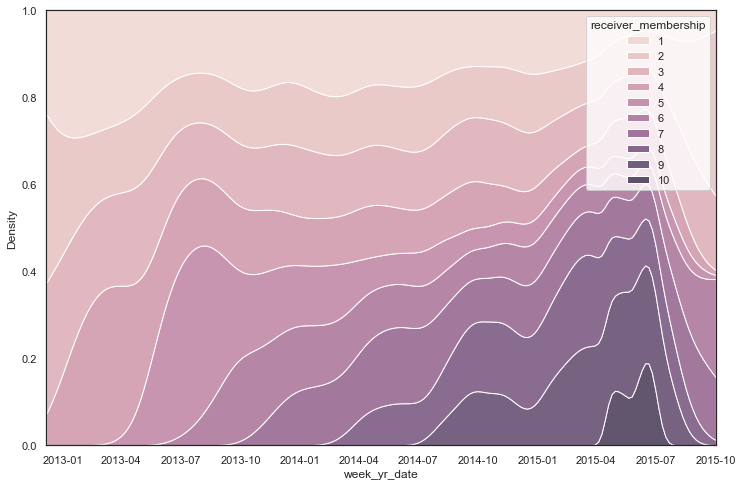

In [55]:
hue_order_l = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=successful_creators_receiver_memb,
            x="week_yr_date",
            hue="receiver_membership",
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)

In [96]:
def plot_learning(data, number, title):
    
    column_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    hue_order_l = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")
    sns.kdeplot(data=data,
            x="week_yr_date",
            hue="receiver_membership",
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)\
    .set(title='Figure {}: {} - Share of trials per receiver membership.'.format(number, title), xlabel='Week',
     ylabel='Share')
    #plt.legend(title='Receiver Membership', loc='upper left', labels = ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1']);
     

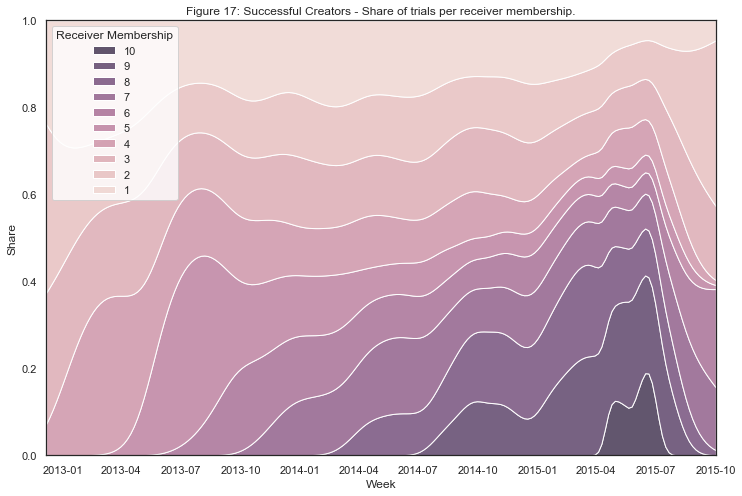

In [94]:
plot_learning(successful_creators_receiver_memb, 17, 'Successful Creators')

/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/venv/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


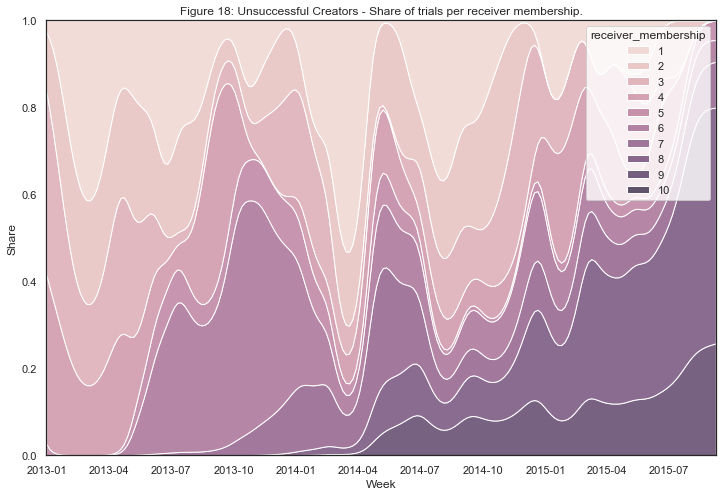

In [97]:
plot_learning(unsuccessful_creators_receiver_memb, 18, 'Unsuccessful Creators')



"||||?x`

In [88]:
unsuccessful_creators_receiver_memb.receiver_membership.value_counts()

1     2096
2     1431
3     1253
4     1098
6       82
8       28
5       24
7       23
9       15
10       1
Name: receiver_membership, dtype: int64

In [98]:
successful_creators_receiver_memb

user_id    fan_id           date_sent outbound_activity  \
23005  37824072   3010694 2013-03-01 00:00:38            follow   
23000  37824072   1461632 2013-03-01 00:00:38            follow   
23006  37824072   3817174 2013-03-01 00:00:38            follow   
23007  37824072   4645590 2013-03-01 00:00:38            follow   
23008  37824072   5063345 2013-03-01 00:00:38            follow   
...         ...       ...                 ...               ...   
73029  38104388  23648477 2015-07-12 07:32:54              like   
73068  38104388  23648477 2015-07-12 07:51:25           comment   
54848  38011411   7436630 2015-07-12 13:31:22              like   
55036  38011411  40174345 2015-07-12 13:47:52              like   
12348  38351087    326153 2015-07-12 18:38:47              like   

       interaction_week  interaction_year   week_yr  followers high_low  \
23005                 9              2013  2013-w08       29.0     high   
23000                 9              2013  2013-w08       29.0     high   
23006                 9              2013  2013-w08       29.0     high   
23007                 9              2013  2013-w08       29.0     high   
23008                 9              2013  2013-w08       29.0     high   
...                 ...               ...       ...        ...      ...   
73029                28              2015  2015-w28       42.0     high   
73068                28              2015  2015-w28       42.0     high   
54848                28              2015  2015-w28       23.0     high   
55036                28              2015  2015-w28       23.0     high   
12348                28              2015  2015-w28       82.0     high   

      follower_since week_yr_date  reward  receiver_membership  
23005            NaT   2013-02-25     0.0                    1  
23000            NaT   2013-02-25     0.0                    1  
23006            NaT   2013-02-25     0.0                    1  
23007            NaT   2013-02-25     0.0                    1  
23008            NaT   2013-02-25     0.0                    3  
...              ...          ...     ...                  ...  
73029            NaT   2015-07-13     0.0                    8  
73068            NaT   2015-07-13     0.0                    8  
54848            NaT   2015-07-13     0.0                    1  
55036            NaT   2015-07-13     0.0                    2  
12348            NaT   2015-07-13     0.0                    6  

[79862 rows x 13 columns]